# On the neural Boltzmann equation
To take the opportunity to dissect one of the papers that received the Best Paper Award in NeurIPS 2018, named *Neural Ordinary Differential Equations*. 

## Relations between differential equations and machine learning?

*A differential equation is a way to specify an arbitrary nonlinear transform by mathematically encoding prior structural assumptions.*
Let's unpack that statement a bit. 
Basically there are three common ways to define a nonlinear transform: 
1. direct modeling: directly writing down the nonlinear function only works if you know the exact functional form that relates the input to the output.
2. DE: model the evolutions of correlated variables
3. ML: a new way to do nonlinear transform

With trainings, we attempt to adjust the parameters of ML so that it generates accurate predictions (i.e., produce $ys$ for novel inputs $x$). This is just a nonlinear transformation $y=ML(x)$. The reason ML is interesting is because its form is basic but adapts to the data itself. For example, a simple neural network (in design matrix form) with sigmoid activation functions is simply matrix multiplications followed by application of sigmoid functions. Specifically,
$$
ML(x)=\sigma(W_{3}\cdot\sigma(W_{2}\cdot\sigma(W_{1}\cdot x)))
$$
with $W=(W_1,W_2,W_3)$ being learnable parameters. You then choose $W$ such that $ML(x)=y$ reasonably fits the function you wanted it to fit. The theory and practice of machine learning confirms that this is a good way to learn nonlinearities. It is known that the *Universal Approximation Theorem* states that, for enough layers or enough parameters (i.e. sufficiently large $W$ matrices), ML(x) can approximate any nonlinear function sufficiently close (subject to common constraints).

## From sequences of transformations to neural differential equations

The neural ordinary differential equation is one of many ways to put these two subjects together. The simplest way of explaining it is that, instead of learning the nonlinear transformation directly, we wish to learn the structures of the nonlinear transformation. Thus instead of doing $y=ML(x)$, we put the machine learning model on the derivative, $y'(x) = ML(x)$, and then solve the ODE. 
But why we would like to do this?


Today, many neural network architectures such as residual networks and recurrent neural
network decoders (RNNs), contain repeating blocks of layers that have the ability to retain sequential information as well as change it in every step through a learned function. Such networks may in general be described by the equation
$$
\mathbf{h}_{t+1}=\mathbf{h}_{t}+f\left(\mathbf{h}_{t}, \theta_{t}\right)
$$
Hereby, $h_t$ is the “hidden” information at timestep $t$, and $f(h_t, \theta_t)$ is the learned function of the current hidden information and parameters $\theta_t$. It's natural to imagine this as gradually increasing the number of residual layers in a residual network. If we do this we will eventually arrive at an infinitesimal (differential) version of the above equation
$$
\frac{d \mathbf{h}(t)}{d t}=f(\mathbf{h}(t), t, \theta)
$$
By solving the above ODE, we arrive at the desired sequence of hidden states.
We will have to solve the equation during each evaluation, beginning with an initial state $h_0$, forming an initial value problem.

A possible application of neural ODE may go to the approximation of differential operator with strong nonlinearity.
For example, let's consider the Boltzmann equation
$$
\frac{D f}{Dt}=
\int_{\mathscr{R}^{3}} \int_{\mathscr{S}^{2}} \Theta g\left[f\left(\mathbf{u}^{\prime}\right) f\left(\mathbf{u}_{1}^{\prime}\right)-f(\mathbf{u}) f\left(\mathbf{u}_{1}\right)\right] d \Omega d \mathbf{u}_{1}
$$
where the LHS is full derivatives of distribution function along particle trajectory, and the RHS is an integral.
We take this equation as an example to show the application of neural ODE.

First, let's load all the packages that to be used in the computation.

In [1]:
using Revise
using Kinetic
using DifferentialEquations, Flux
using DiffEqFlux, Optim
using Plots

Then, generate the variables from configuration file.

In [2]:
config = "../code/homogeneous/config.txt"
D = read_dict(config)
for key in keys(D)
    s = Symbol(key)
    @eval $s = $(D[key])
end

case = homogeneous
maxTime = 8
tlen = 9
u0 = -5
u1 = 5
nu = 60
nug = 0
v0 = -5
v1 = 5
nv = 60
nvg = 0
w0 = -5
w1 = 5
nw = 60
nwg = 0
vMeshType = rectangle
nm = 5
knudsen = 1
inK = 0
alpha = 1.0
omega = 0.5
nh = 5



Calculate initial values and parameters needed for evaluating collision operator.

In [3]:
tspan = (0.0, maxTime)
tRange = range(tspan[1], tspan[2], length=tlen)

γ = heat_capacity_ratio(inK, 3)
vSpace = VSpace3D(u0, u1, nu, v0, v1, nv, w0, w1, nw, vMeshType)

f0 = Float32.(0.5 * (1/π)^1.5 .* (exp.(-(vSpace.u .- 0.99).^2) .+ exp.(-(vSpace.u .+ 0.99).^2)) .* 
     exp.(-vSpace.v.^2) .* exp.(-vSpace.w.^2)) |> Array
prim0 = conserve_prim(moments_conserve(f0, vSpace.u, vSpace.v, vSpace.w, vSpace.weights), γ)
M0 = Float32.(maxwellian(vSpace.u, vSpace.v, vSpace.w, prim0)) |> Array

mu_ref = ref_vhs_vis(knudsen, alpha, omega)
kn_bzm = hs_boltz_kn(mu_ref, 1.0)
τ = mu_ref * 2. * prim0[end]^(0.5) / prim0[1]

0.8615212691944643

## Fast spectral method for Boltzmann collision operator

With the rapid progress of computing resources and capabilities, there have been some useful methods to calculate nonlinear Boltzmann collision integral.
In 1989, Goldstein, etc. al employed a fixed Eulerian mesh to evaluate discrete collisional dynamics. 
This method is very intuitive, but since particle velocities pre/post collisions need to fall on the grid points, it has a huge requirement on computational resources.
Bobylev etc. proved that the method of computing resources consumption is about $O(N^7)$, where $N$ is the number of discrete velocity grids used in each direction, and this method possesses only half order convergence, similar to that of DSMC method.


Another thought goes to the fast Fourier transformation (FFT) to solve the collision operator in the spectral space.
In 1988,Bobylev made a preliminary attempt to calculate the Boltzmann equation of Maxwell molecules in a homogeneous flow field.
Later, Paraschi and Perthame extended this method to general collision kernel, with a compuational cost $O(N^6)$.
In 2006, Mouhot and Paraschi developed a fast spectral method based on Carleman-type Boltzmann equation, which holds the spectral accuracy and computational cost $O(M^2N^3logN)$.
It's one of the most efficient Boltzmann collision solver by now. 


We briefly introduce it on the basis of Carleman-type Boltzmann equation,
$$
\begin{aligned}
Q(f) &=\int_{\mathscr{R}^{3}} \int_{\mathscr{S}^{2}} \Theta g\left[f\left(\mathbf{u}^{\prime}\right) f\left(\mathbf{u}_{1}^{\prime}\right)-f(\mathbf{u}) f\left(\mathbf{u}_{1}\right)\right] d \Omega d \mathbf{u}_{1} \\
&=\int_{\mathscr{R}^{3}} \int_{\mathscr{S}^{2}} \Theta g\left[f\left(\mathbf{u}+\frac{g \Omega-\mathbf{g}}{2}\right) f\left(\mathbf{u}_{1}-\frac{g \Omega-\mathbf{g}}{2}\right)-f(\mathbf{u}) f\left(\mathbf{u}_{1}\right)\right] d \Omega d \mathbf{u}_{1} \\
&=2 \int_{\mathscr{R}^{3}} \int_{\mathscr{R}^{3}} \Theta \delta\left(2 \mathbf{y} \cdot \mathbf{g}+\mathbf{y}^{2}\right)\left[f\left(\mathbf{u}+\frac{\mathbf{y}}{2}\right) f\left(\mathbf{u}_{1}-\frac{\mathbf{y}}{2}\right)-f(\mathbf{u}) f\left(\mathbf{u}_{1}\right)\right] d \mathbf{y} d \mathbf{u}_{1} \\
&=4 \int_{\mathscr{R}^{3}} \int_{\mathscr{R}^{3}} \Theta \delta\left(\mathbf{y} \cdot \mathbf{g}+\mathbf{y}^{2}\right)\left[f(\mathbf{u}+\mathbf{y}) f\left(\mathbf{u}_{1}-\mathbf{y}\right)-f(\mathbf{u}) f\left(\mathbf{u}_{1}\right)\right] d \mathbf{y} d \mathbf{u}_{1} \\
&=4 \int_{\mathscr{R}^{3}} \int_{\mathscr{R}^{3}} \Theta \delta(\mathbf{y} \cdot \mathbf{z})[f(\mathbf{u}+\mathbf{y}) f(\mathbf{u}+\mathbf{z})-f(\mathbf{u}) f(\mathbf{u}+\mathbf{y}+\mathbf{z})] d \mathbf{y} d \mathbf{z}
\end{aligned}
$$
with $\Theta=\mathscr{B} / g, \mathbf{y}=(g \Omega-\mathbf{g}) / 2, \mathbf{z}=\mathbf{u}_{1}-\mathbf{u}-\mathbf{y}=-\mathbf{g}-\mathbf{y}$.
In the Boltzmann equation, the collision kernel is $\mathscr{B}(\cos \theta, g)=\Theta g$, and $\Theta$ is the differential cross section.
A generalized collision kernel can be defined as
$$
\mathscr{B}=C_{\alpha, \gamma}^{\prime \prime} \sin ^{\alpha+\gamma-1}\left(\frac{\theta}{2}\right) \cos ^{-\gamma}\left(\frac{\theta}{2}\right) g^{\alpha}
$$
with
$$
C_{\alpha, \gamma}^{\prime \prime}=\frac{\Gamma[(7+\alpha) / 2]}{6 \Gamma[(3+\alpha+\gamma) / 2] \Gamma(2-\gamma / 2)} C_{\alpha}
$$
where $C_\alpha$ is a parameter.


In the fast spectral method, we can periodize the particle distribution function in $D_L=[-L,L]^3$, and expand it into Fourier series
$$
\begin{array}{l}
f(\mathbf{u})=\sum_{k=-N / 2}^{N / 2-1} \hat{f}_{k} \exp \left(i \xi_{k} \cdot \mathbf{u}\right) \\
\hat{f}_{k}=\frac{1}{(2 L)^{3}} \int_{D_{L}} f(\mathbf{u}) \exp \left(-i \xi_{k} \cdot \mathbf{u}\right) d \mathbf{u}
\end{array}
$$
with$x_k = k\pi/L$ being frequency component.
The collision operator can also be expanded as
$$
\hat{Q}_{j}=\sum_{l, m=-N_{k} / 2,(l+m=j)}^{N_{k} / 2-1} \hat{f}_{l} \hat{f}_{m}[\beta(l, m)-\beta(m, m)]
$$
with the kernel mode being
$$
\begin{array}{l}
\beta(l, m)=4 \int_{\mathscr{R}^{3}} \int_{\mathscr{R}^{3}} \delta(\mathbf{y} \cdot \mathbf{z}) \Theta \exp \left(i \xi_{l} \cdot \mathbf{y}+i \xi_{m} \cdot \mathbf{z}\right) d \mathbf{y} d \mathbf{z} \\
=\iint \delta\left(\mathbf{e} \cdot \mathbf{e}^{\prime}\right) \Theta\left[\int_{-R}^{R} \rho \exp \left(i \rho \xi_{l} \cdot \mathbf{e}\right) d \rho\right]\left[\int_{-R}^{R} \rho^{\prime} \exp \left(i \rho^{\prime} \xi_{m} \cdot \mathbf{e}^{\prime}\right) d \rho^{\prime}\right] d \mathbf{e} d \mathbf{e}^{\prime} \\
=4 \int\left[\int_{0}^{R} \rho \cos \left(\rho \xi_{l} \cdot \mathbf{e}\right) d \rho\right]\left[\int \delta\left(\mathbf{e} \cdot \mathbf{e}^{\prime}\right) \int_{0}^{R} \rho^{\prime} \Theta \cos \left(\rho^{\prime} \xi_{m} \cdot \mathbf{e}^{\prime}\right) d \rho^{\prime} d \mathbf{e}^{\prime}\right] d \mathbf{e}
\end{array}
$$
The separation of mode $l$ and $m$ can be achieved by numerical quadrature.
Hence, the Boltzmann integral can be evaluated by calcuating convolutions with FFT.

**You may notice the drawbacks of fast spectral method:**
1. NOT intuitive
2. requires high dimensionality of phase space



In [4]:
phi, psi, phipsi = kernel_mode( nm, vSpace.u1, vSpace.v1, vSpace.w1, vSpace.du[1,1,1], vSpace.dv[1,1,1], vSpace.dw[1,1,1],
                                vSpace.nu, vSpace.nv, vSpace.nw, alpha );

Tip 1: intuitive representation

In [5]:
function boltzmann!(df, f::Array{<:Real,3}, p, t)
    Kn, M, phi, psi, phipsi = p
    df .= boltzmann_fft(f, Kn, M, phi, psi, phipsi) # Kinetic.jl
end

function bgk!(df, f::Array{<:Real,3}, p, t)
    g, tau = p
    df .= (g .- f) ./ tau
end

bgk! (generic function with 1 method)

In [6]:
#--- Boltzmann ---#
prob = ODEProblem(boltzmann!, f0, tspan, [kn_bzm, nm, phi, psi, phipsi])
#prob = ODEProblem(bgk!, f0, tspan, [g0, τ])
data_boltz = solve(prob, Tsit5(), saveat=tRange) |> Array;

In [7]:
#--- BGK ---#
prob1 = ODEProblem(bgk!, f0, tspan, [M0, τ])
data_bgk = solve(prob, Tsit5(), saveat=tRange) |> Array;

Tip 2: dimension reduction

In [22]:
data_boltz_1D = zeros(Float32, axes(data_boltz, 1), axes(data_boltz, 4))
data_bgk_1D = zeros(Float32, axes(data_bgk, 1), axes(data_bgk, 4))
for j in axes(data_boltz_1D, 2), i in axes(data_boltz_1D, 1)
    data_boltz_1D[i,j] = sum(@. vSpace.weights[i,:,:] * data_boltz[i,:,:,j])
    data_bgk_1D[i,j] = sum(@. vSpace.weights[i,:,:] * data_bgk[i,:,:,j])
end

f0_1D = zeros(Float32, axes(f0, 1))
for i in axes(data_boltz_1D, 1)
    f0_1D[i] = sum(@. vSpace.weights[i,:,:] * f0[i,:,:])
end

M0_1D = zeros(Float32, axes(M0, 1))
for i in axes(M0, 1)
    M0_1D[i] = sum(@. vSpace.weights[i,:,:] * M0[i,:,:])
end

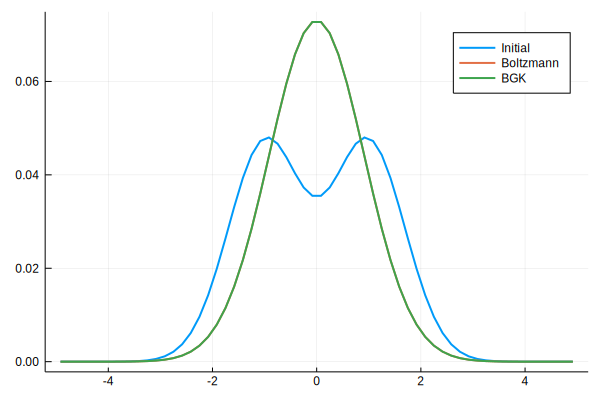

In [9]:
plot(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], data_boltz_1D[:,1], lw=2, label="Initial")
plot!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], data_boltz_1D[:,end], lw=2, label="Boltzmann")
plot!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], data_bgk_1D[:,end], lw=2, label="BGK")

Then, let's construct our neural ODE.

In [10]:
#--- neural ode ---#
dudt = FastChain( (x, p) -> x.^2, # initial guess
                   FastDense(vSpace.nu, vSpace.nu*nh, tanh), # our 1-layer network
                   FastDense(vSpace.nu*nh, vSpace.nu) )
n_ode = NeuralODE(dudt, tspan, Tsit5(), saveat=tRange)

function loss_n_ode(p)
    pred = n_ode(f0_1D, p)
    loss = sum(abs2, pred .- data_boltz_1D)
    return loss, pred
end

cb = function (p, l, pred; doplot=true)
    display(l)
    # plot current prediction against dataset
    if doplot
        pl = plot(tRange, data_boltz_1D[vSpace.nu÷2,:], lw=2, label="Exact")
        scatter!(pl, tRange, pred[vSpace.nu÷2,:], lw=2, label="NN prediction")
        display(plot(pl))
    end
    return false
end

#5 (generic function with 1 method)

Do the training with ADAM optimizer

0.08006237f0

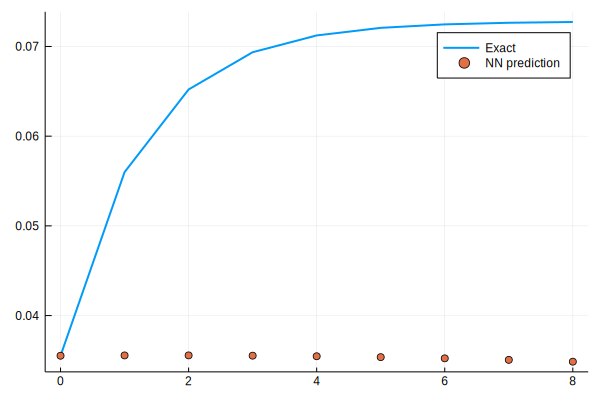

0.0561109f0

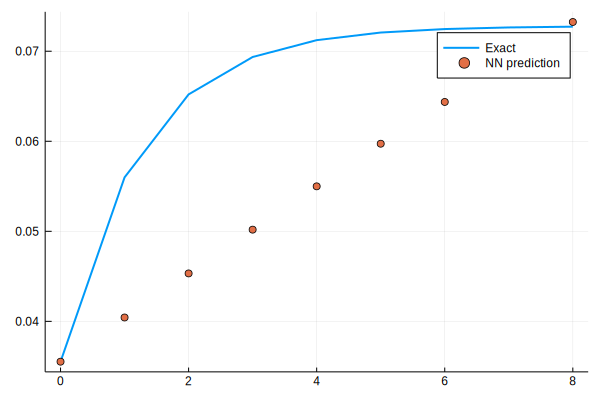

loss: 0.0561:   1%|▎                                        |  ETA: 0:00:32

0.041575f0

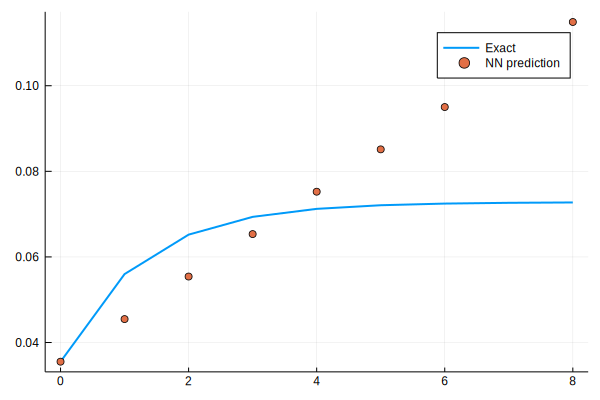

0.0373137f0

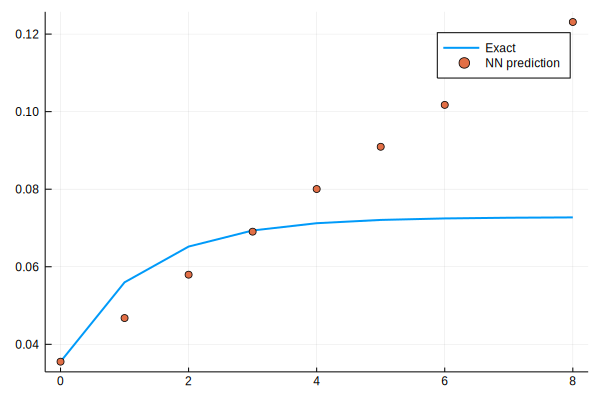

loss: 0.0373:   1%|▌                                        |  ETA: 0:00:27

0.030859698f0

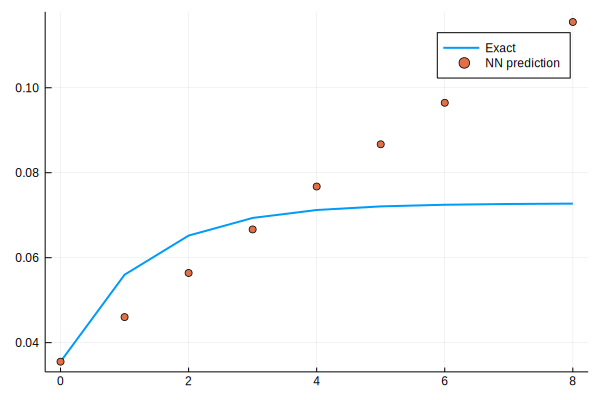

loss: 0.0309:   2%|▋                                        |  ETA: 0:00:28

0.025414977f0

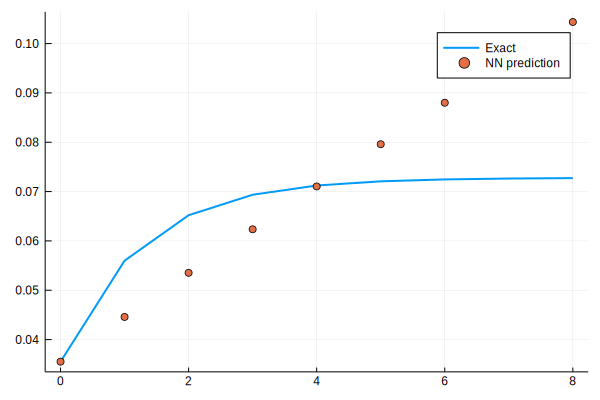

0.021276895f0

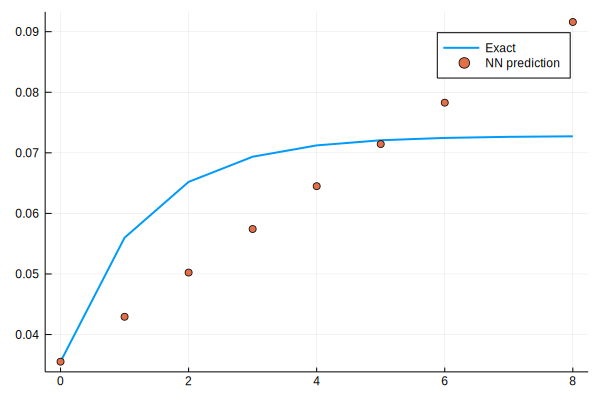

loss: 0.0213:   2%|█                                        |  ETA: 0:00:26

0.018105006f0

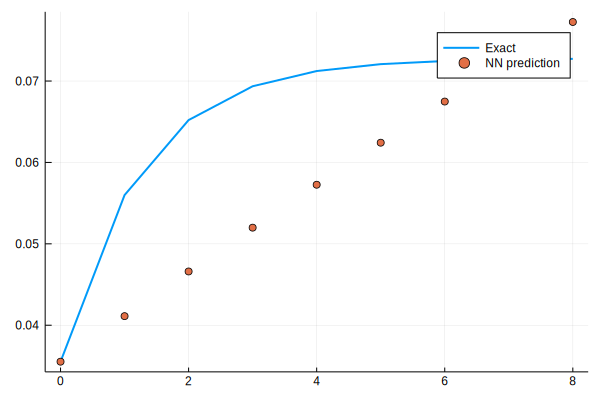

0.01747936f0

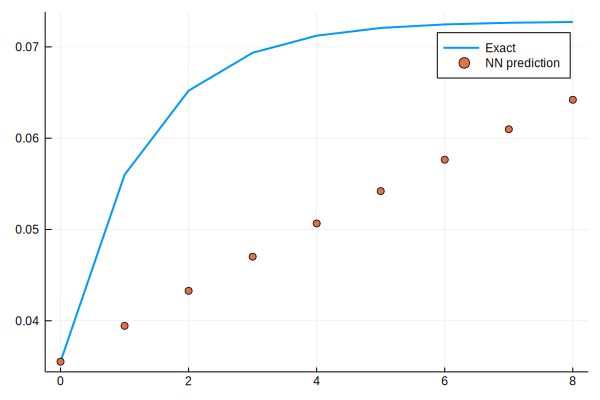

loss: 0.0175:   3%|█▎                                       |  ETA: 0:00:25

0.018902702f0

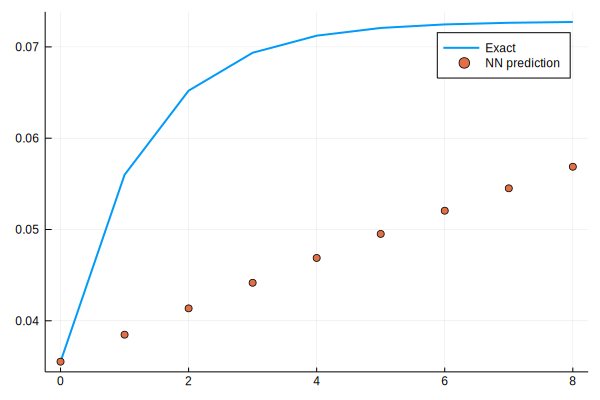

0.019424282f0

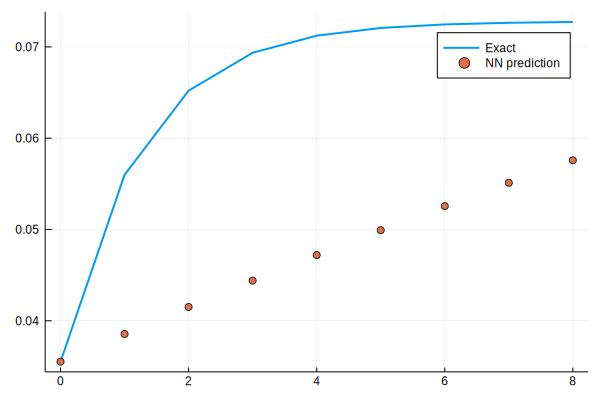

loss: 0.0194:   4%|█▌                                       |  ETA: 0:00:25

0.017311787f0

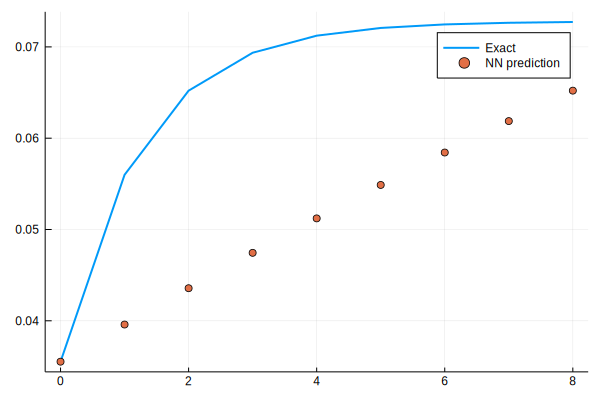

0.013580853f0

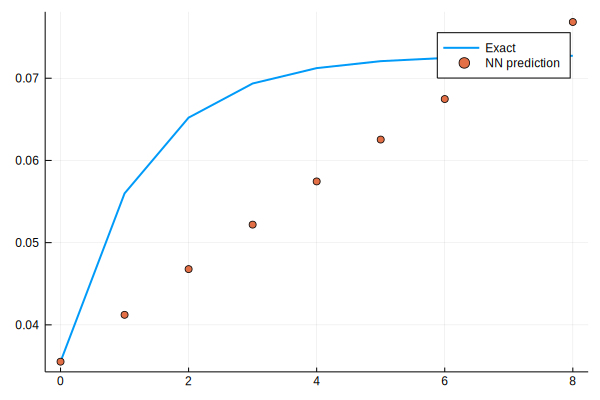

loss: 0.0136:   4%|█▊                                       |  ETA: 0:00:24

0.010613461f0

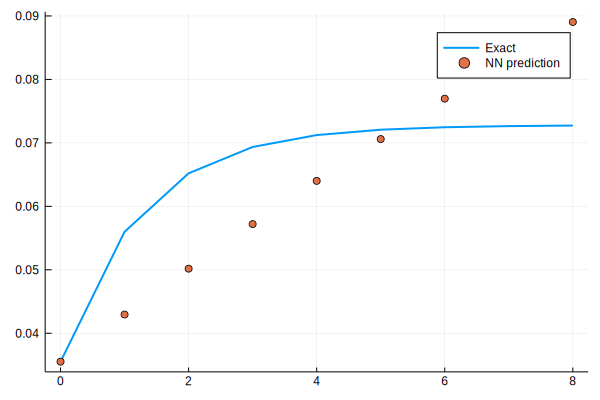

0.009985462f0

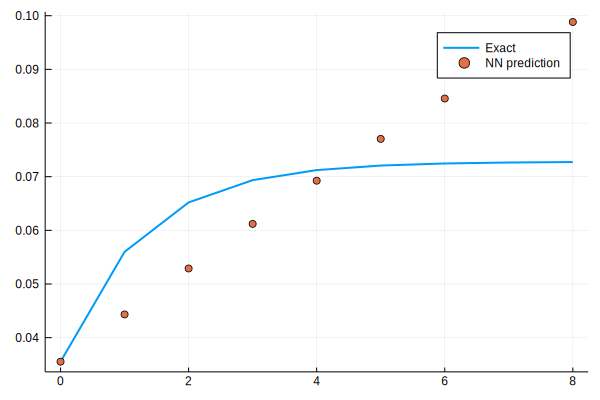

loss: 0.00999:   5%|██                                       |  ETA: 0:00:24

0.011205437f0

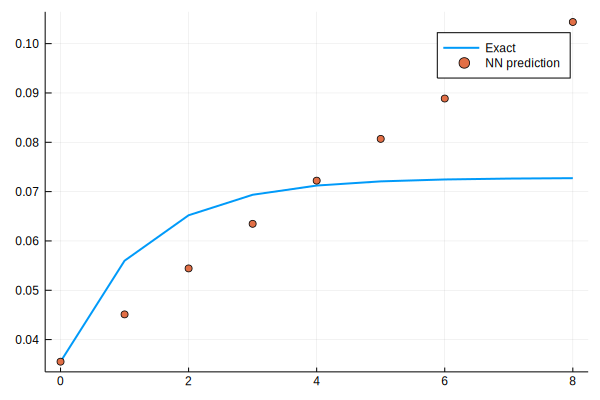

0.01241205f0

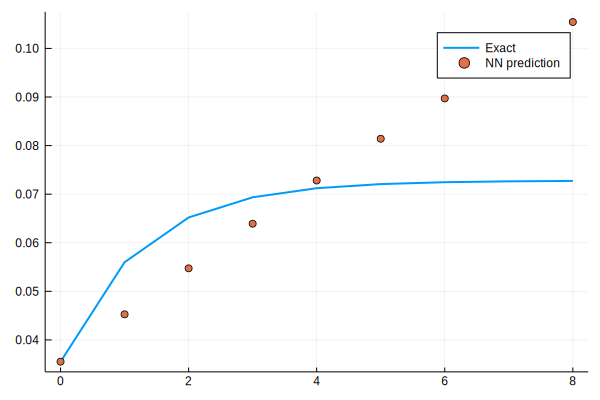

loss: 0.0124:   6%|██▎                                      |  ETA: 0:00:24

0.012623771f0

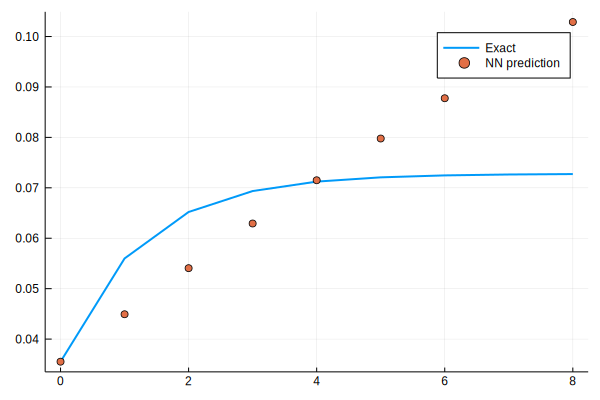

0.011793451f0

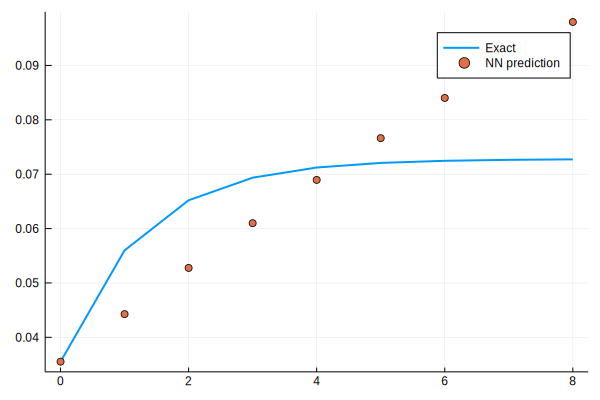

loss: 0.0118:   6%|██▋                                      |  ETA: 0:00:23

0.010039536f0

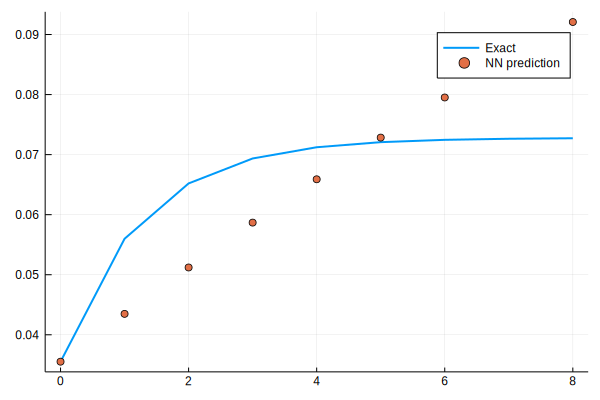

0.008221417f0

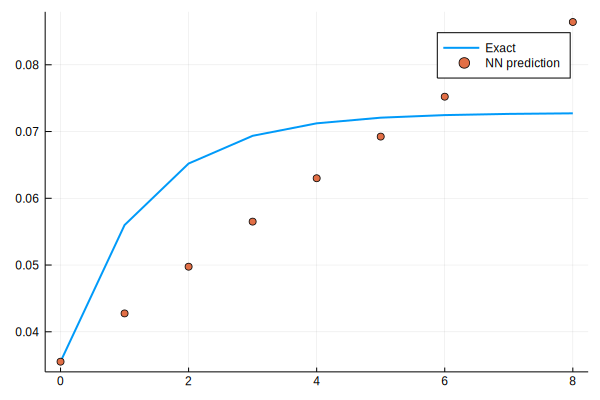

loss: 0.00822:   7%|██▉                                      |  ETA: 0:00:23

0.00745387f0

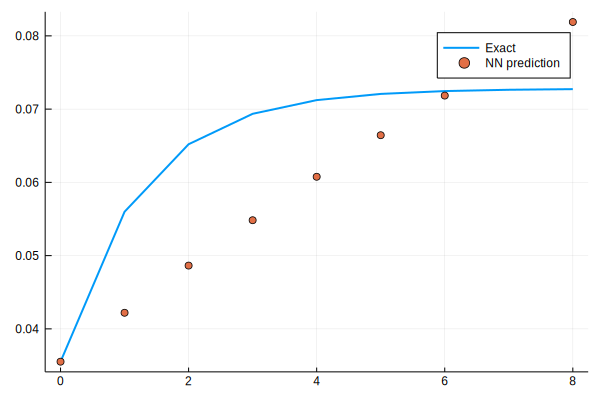

0.007821196f0

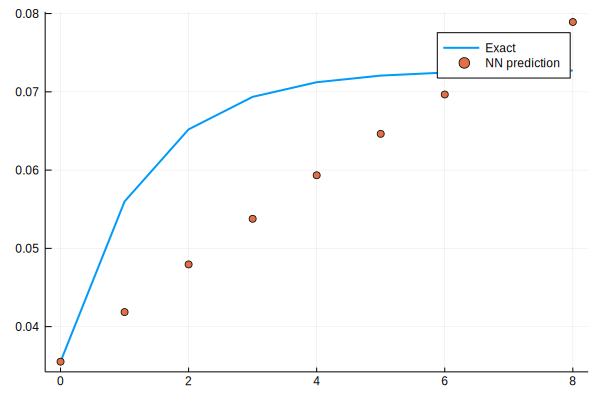

loss: 0.00782:   8%|███▏                                     |  ETA: 0:00:23

0.008635759f0

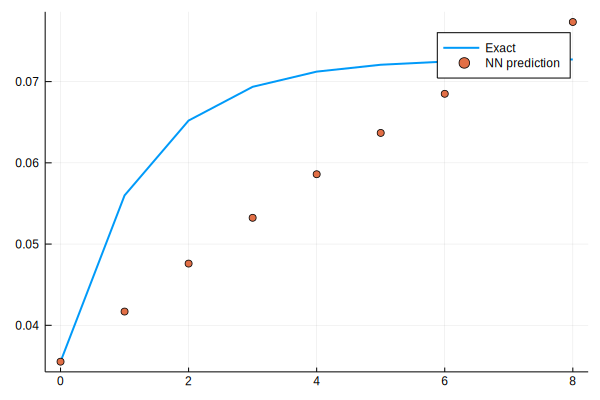

loss: 0.00864:   8%|███▎                                     |  ETA: 0:00:23

0.009219164f0

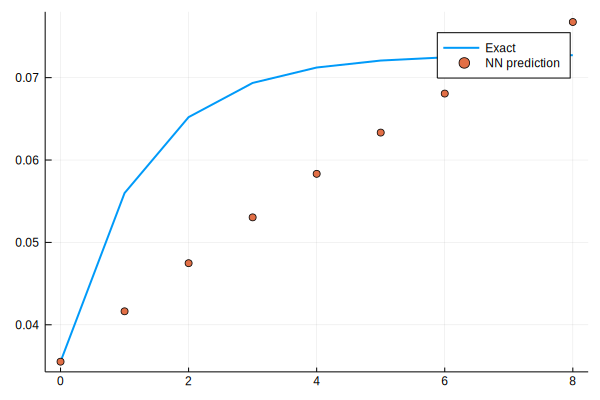

0.009081617f0

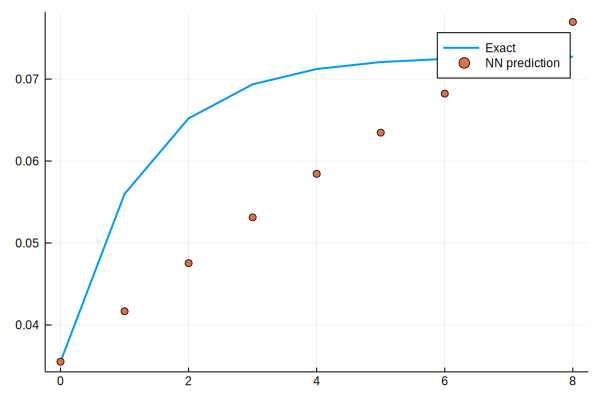

loss: 0.00908:   9%|███▌                                     |  ETA: 0:00:23

0.008229359f0

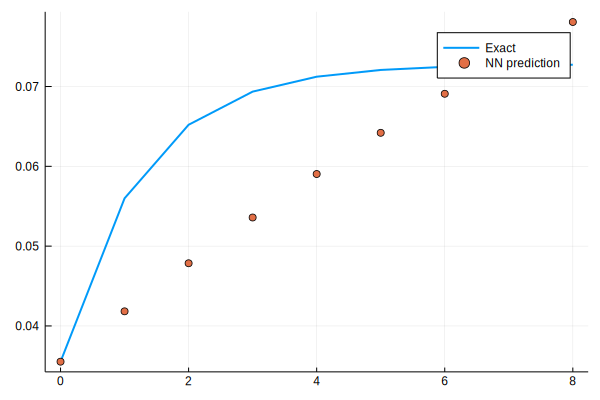

0.0072092917f0

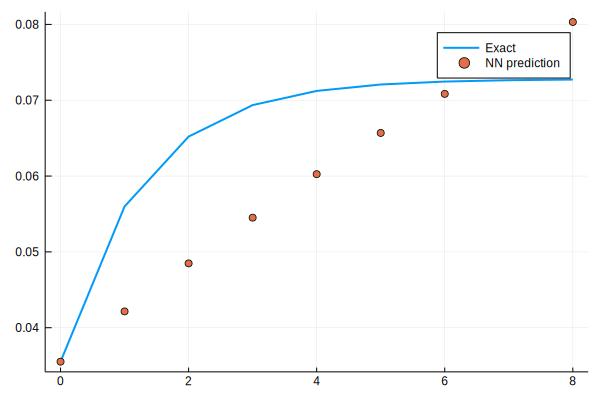

loss: 0.00721:   9%|███▉                                     |  ETA: 0:00:23

0.006557099f0

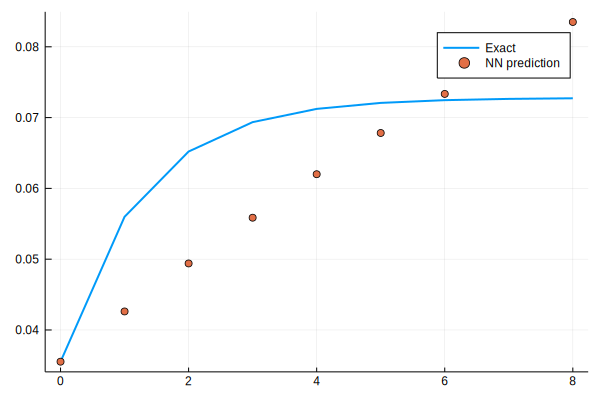

0.0064644315f0

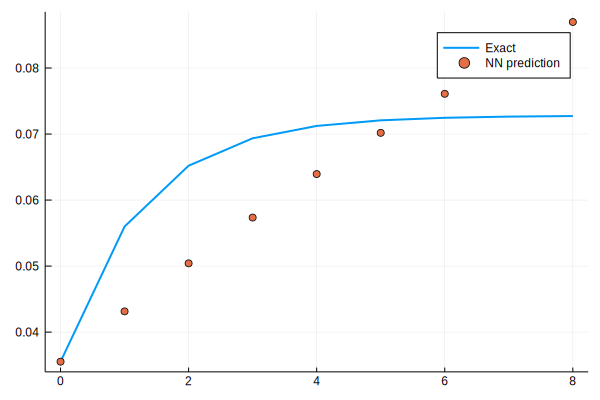

loss: 0.00646:  10%|████▏                                    |  ETA: 0:00:23

0.006794332f0

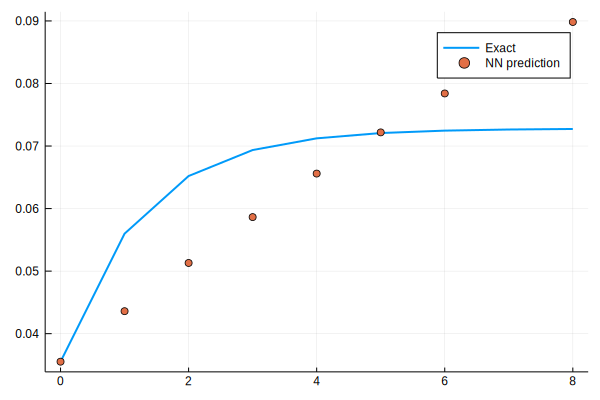

0.0071695754f0

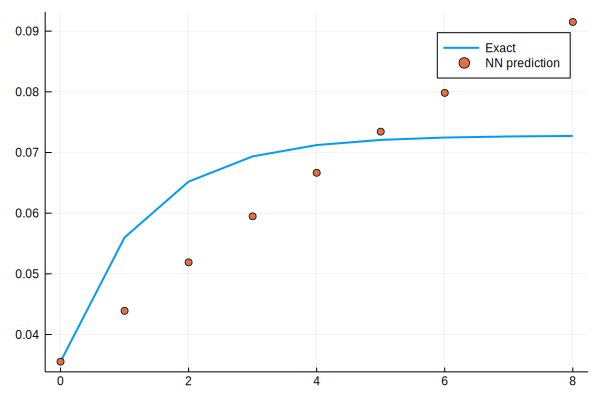

loss: 0.00717:  11%|████▍                                    |  ETA: 0:00:23

0.007219159f0

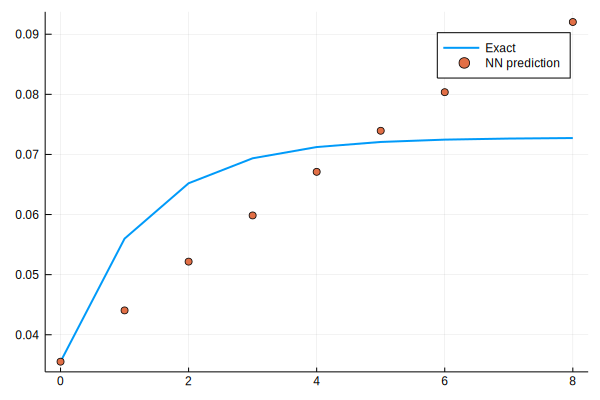

0.006885176f0

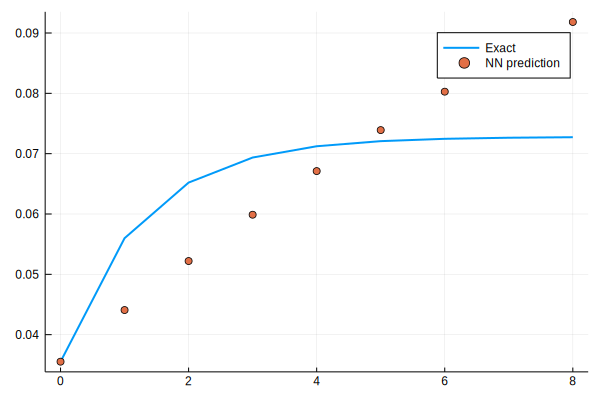

loss: 0.00689:  11%|████▋                                    |  ETA: 0:00:23

0.0064032804f0

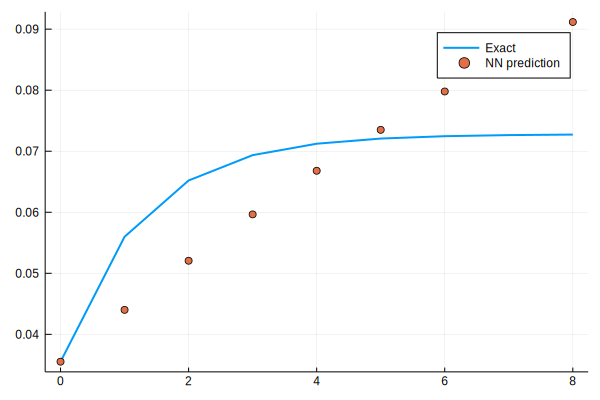

loss: 0.0064:  12%|████▊                                    |  ETA: 0:00:23

0.0060405936f0

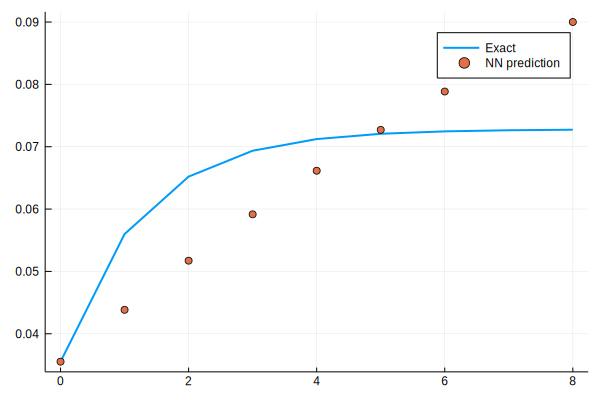

loss: 0.00604:  12%|████▉                                    |  ETA: 0:00:23

0.005913311f0

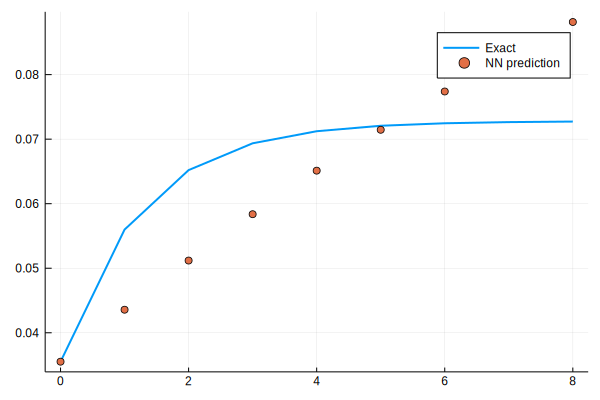

loss: 0.00591:  12%|█████                                    |  ETA: 0:00:23

0.0059496122f0

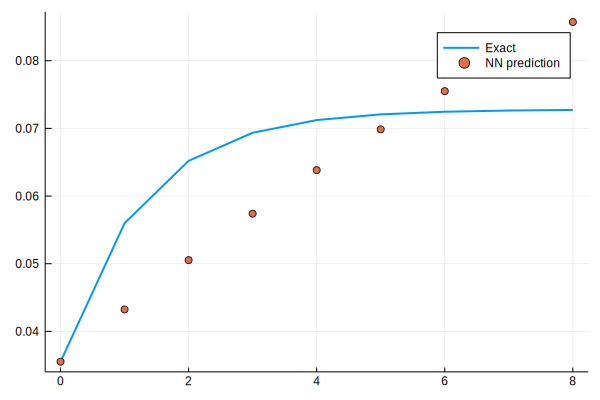

0.0059943856f0

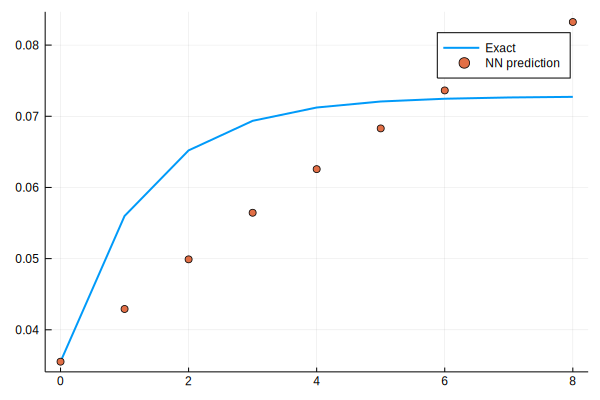

loss: 0.00599:  13%|█████▍                                   |  ETA: 0:00:23

0.0059726946f0

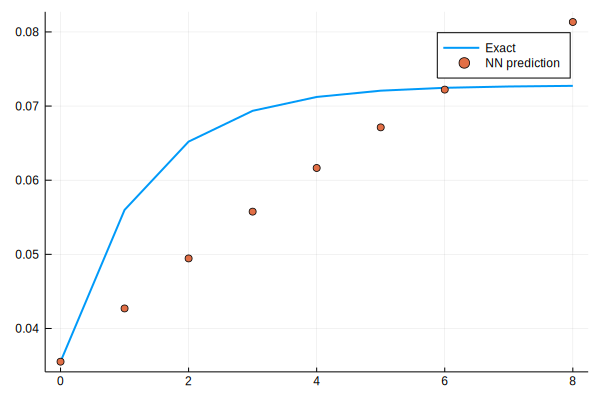

0.0058971974f0

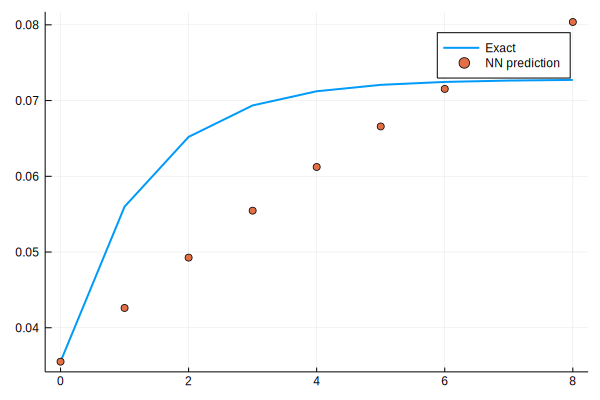

loss: 0.0059:  14%|█████▋                                   |  ETA: 0:00:23

0.0057688854f0

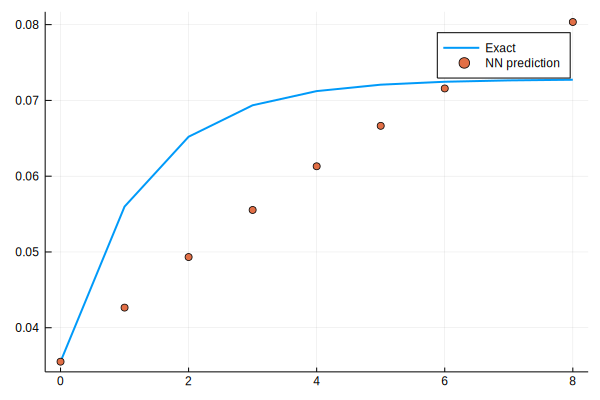

0.0055966885f0

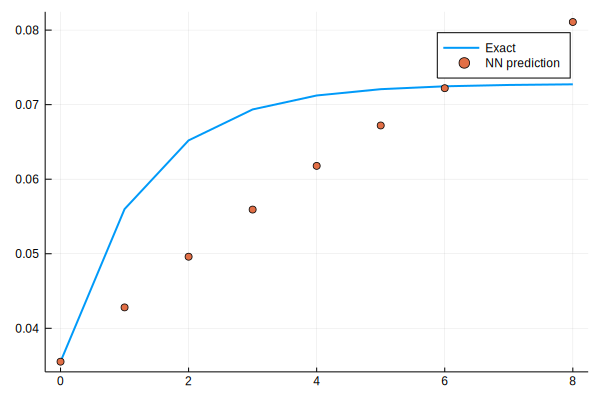

loss: 0.0056:  14%|█████▉                                   |  ETA: 0:00:23

0.005434976f0

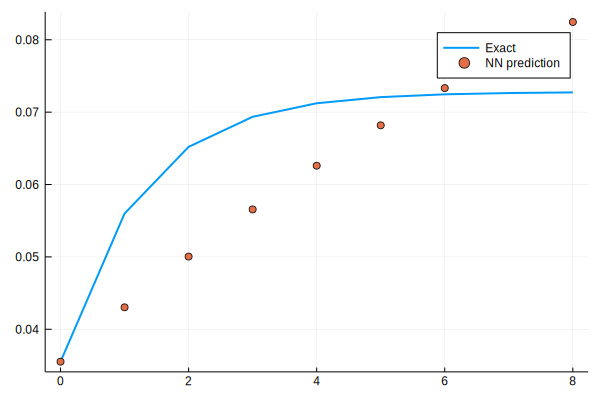

loss: 0.00543:  15%|██████                                   |  ETA: 0:00:23

0.0053228475f0

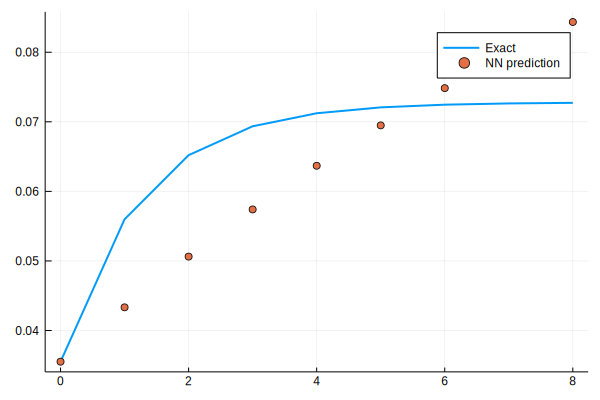

0.0052727377f0

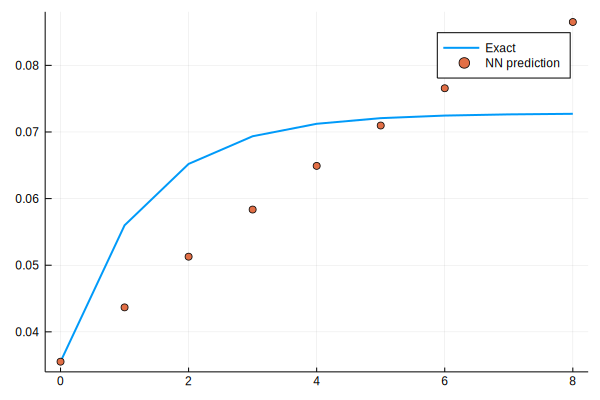

loss: 0.00527:  15%|██████▎                                  |  ETA: 0:00:22

0.005261556f0

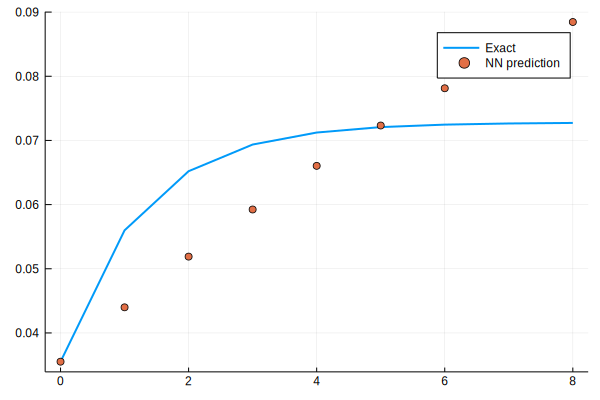

0.005233064f0

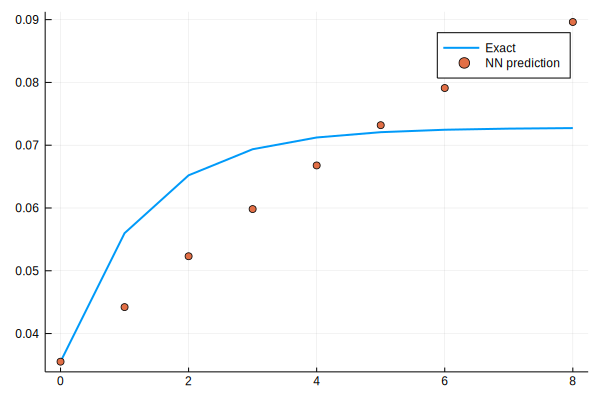

loss: 0.00523:  16%|██████▌                                  |  ETA: 0:00:22

0.0051742974f0

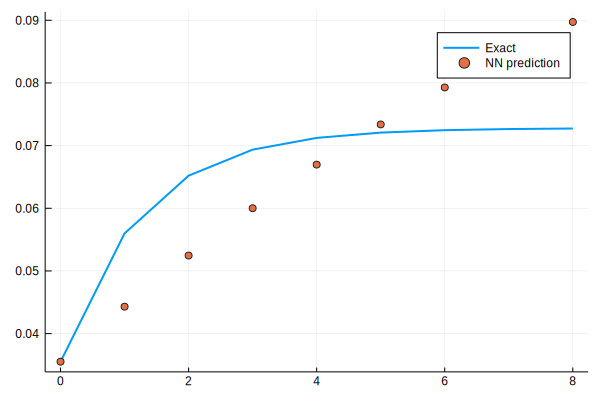

0.0050844033f0

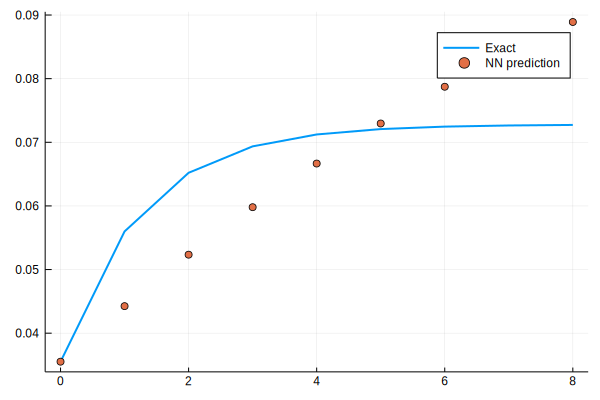

loss: 0.00508:  17%|██████▊                                  |  ETA: 0:00:22

0.0049574776f0

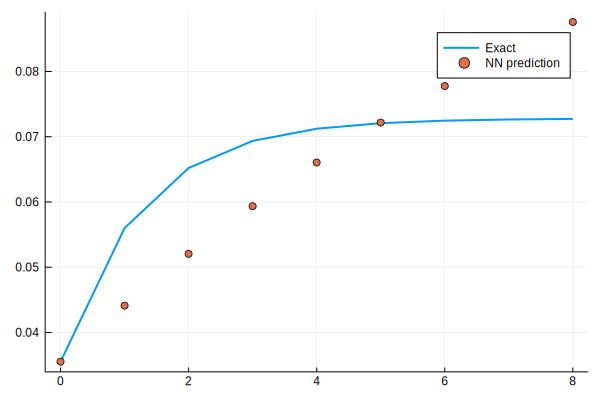

loss: 0.00496:  17%|███████                                  |  ETA: 0:00:22

0.0048365584f0

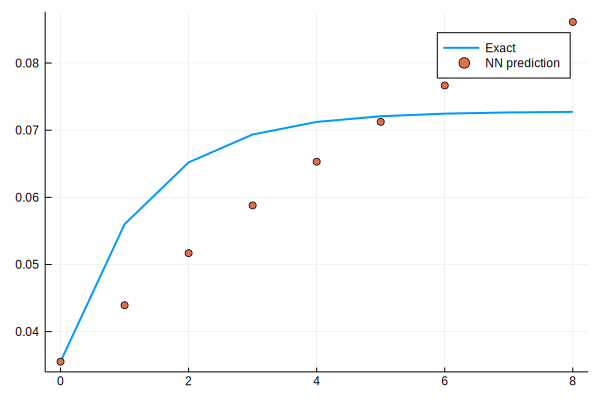

0.004765403f0

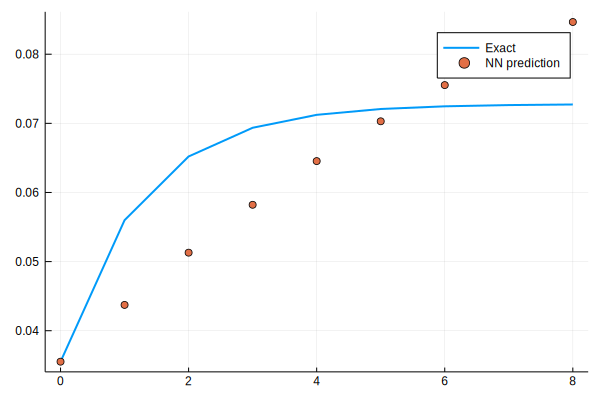

loss: 0.00477:  18%|███████▎                                 |  ETA: 0:00:22

0.004739707f0

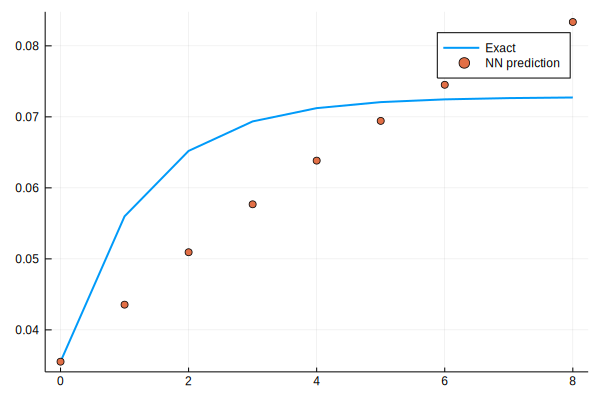

0.004715485f0

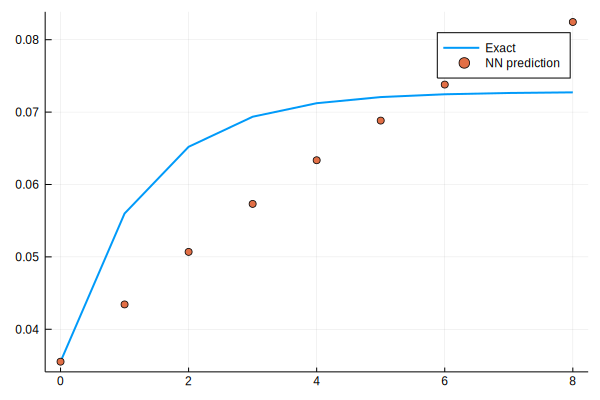

loss: 0.00472:  18%|███████▌                                 |  ETA: 0:00:22

0.00466386f0

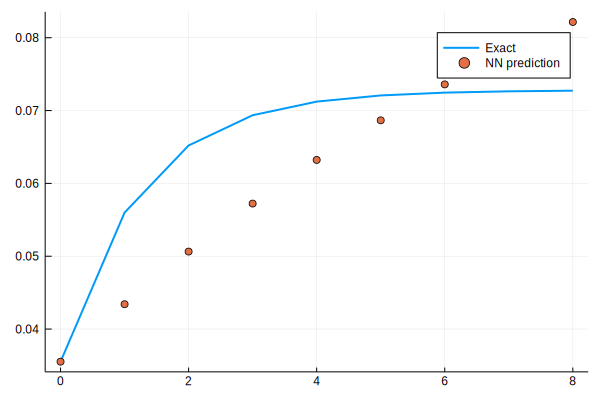

0.0045913565f0

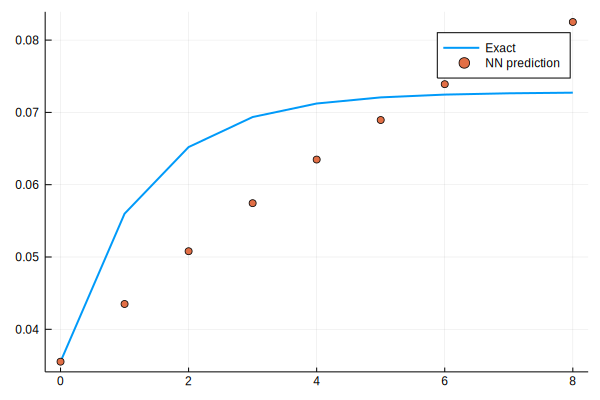

loss: 0.00459:  19%|███████▊                                 |  ETA: 0:00:22

0.00449955f0

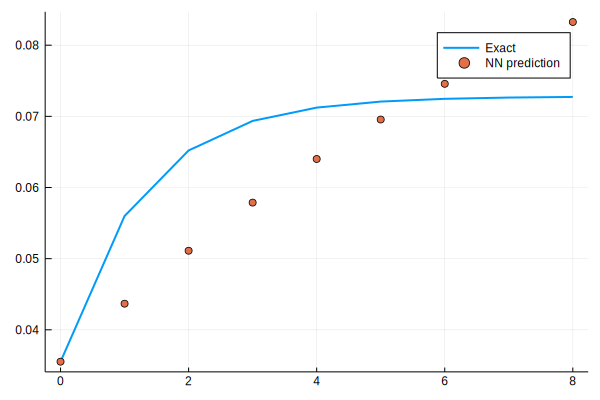

0.0044021406f0

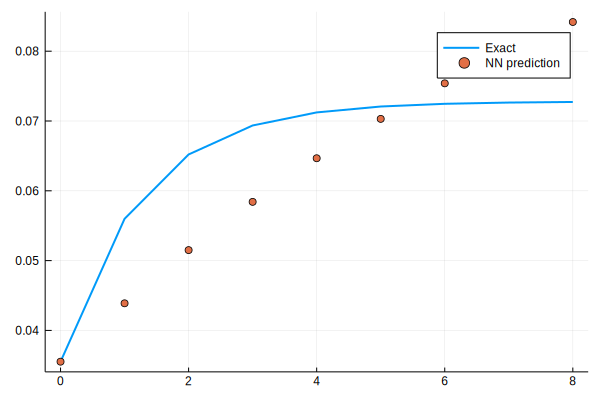

loss: 0.0044:  20%|████████                                 |  ETA: 0:00:21

0.0043300893f0

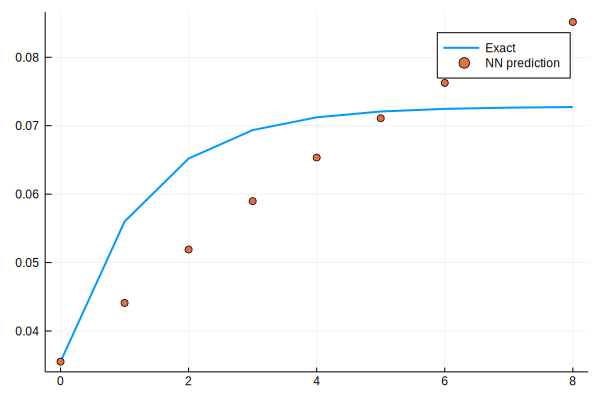

0.0042941547f0

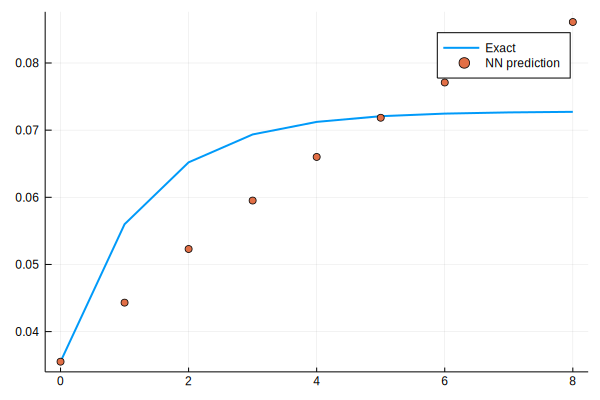

loss: 0.00429:  20%|████████▍                                |  ETA: 0:00:21

0.0042673154f0

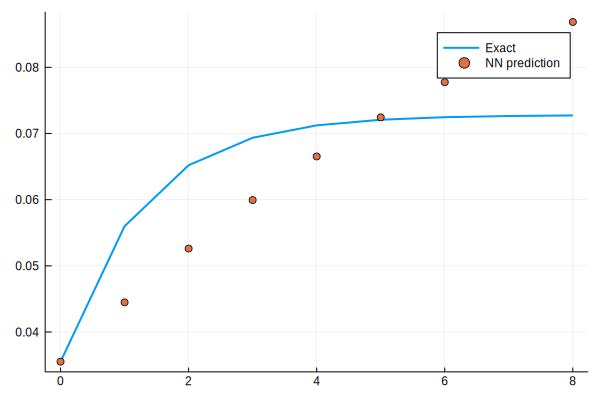

0.004215003f0

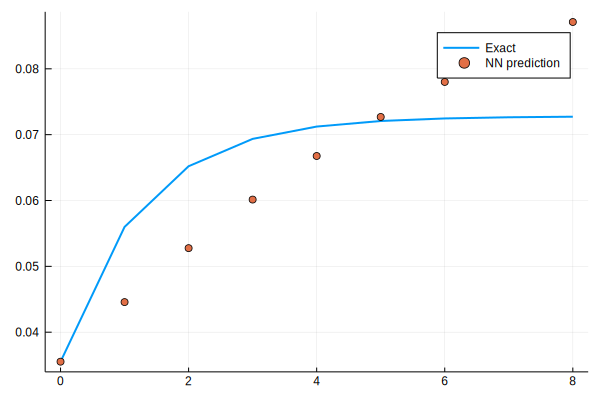

loss: 0.00422:  21%|████████▋                                |  ETA: 0:00:21

0.004137731f0

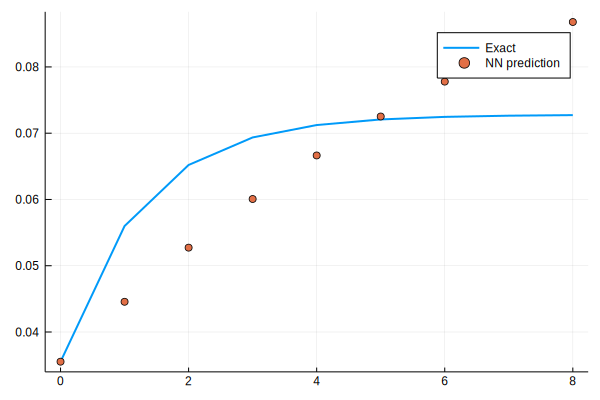

0.0040573874f0

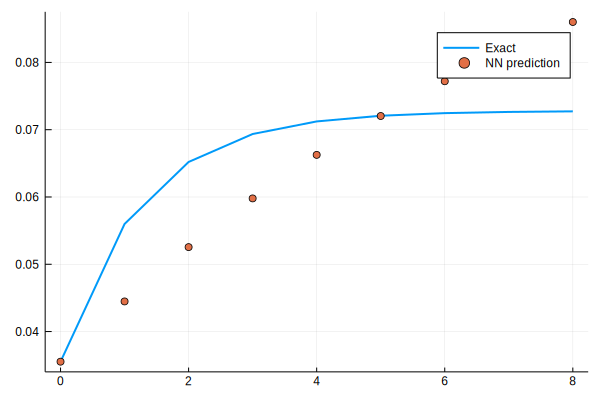

loss: 0.00406:  22%|████████▉                                |  ETA: 0:00:21

0.0039911303f0

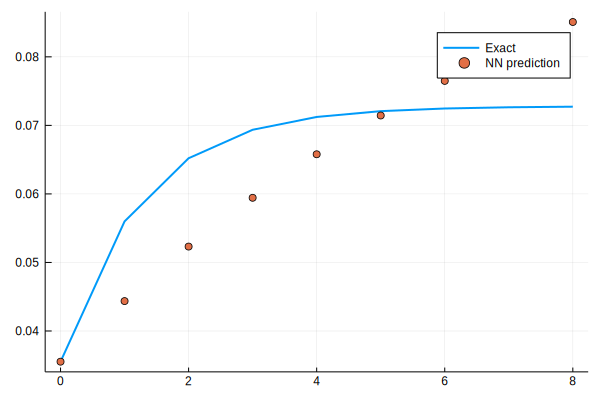

0.003939554f0

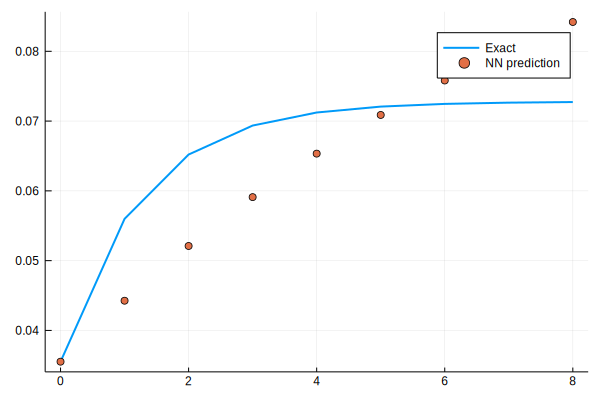

loss: 0.00394:  22%|█████████▏                               |  ETA: 0:00:21

0.0038916722f0

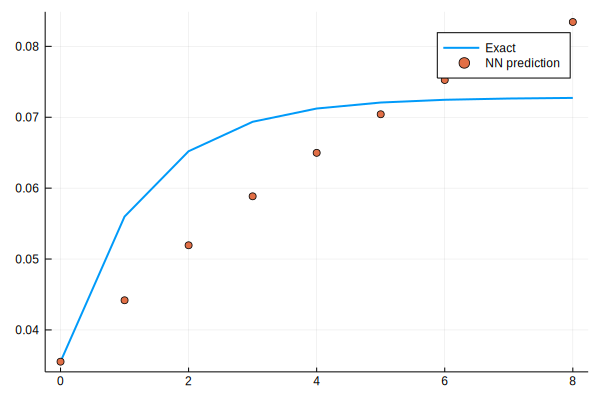

0.003842518f0

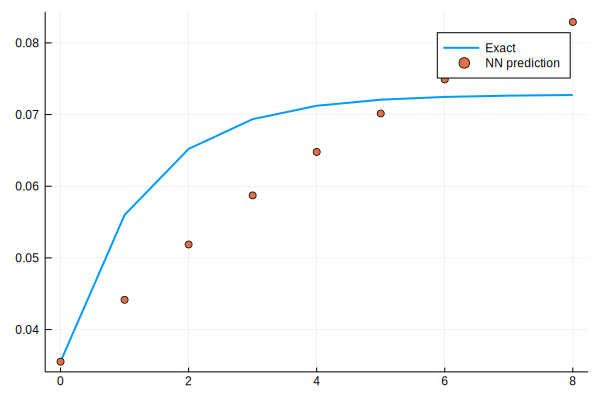

loss: 0.00384:  23%|█████████▍                               |  ETA: 0:00:20

0.0037875979f0

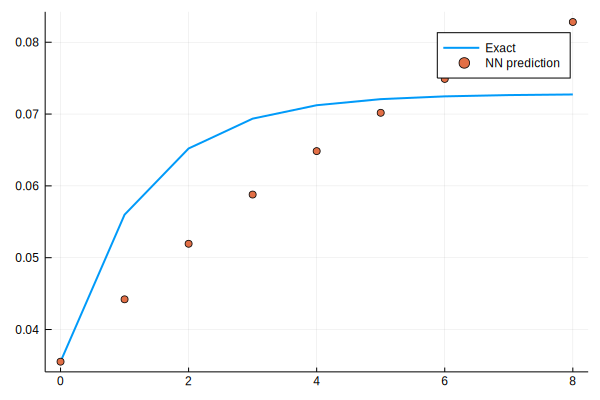

loss: 0.00379:  23%|█████████▌                               |  ETA: 0:00:21

0.0037255203f0

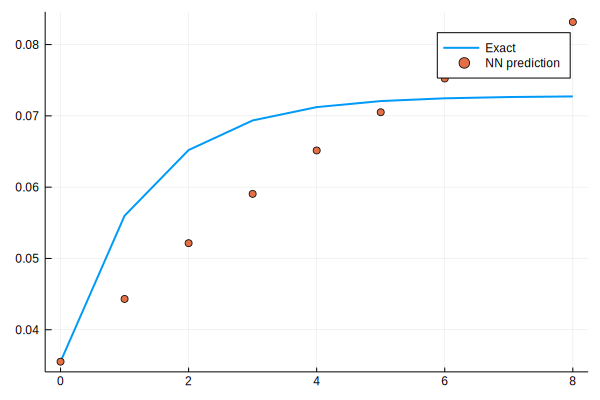

0.0036625934f0

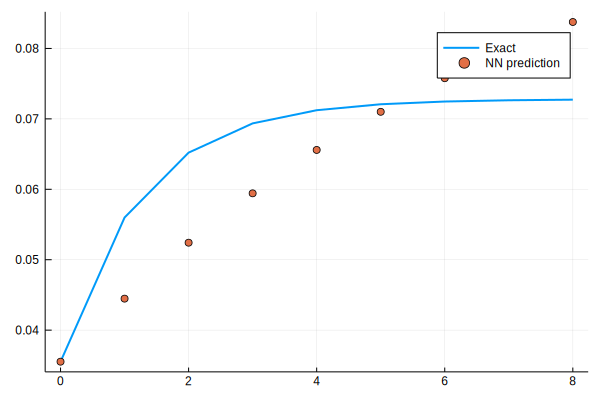

loss: 0.00366:  24%|█████████▉                               |  ETA: 0:00:20

0.0036041795f0

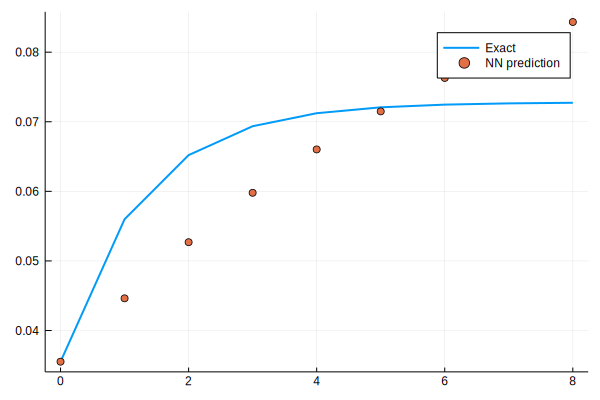

0.0035521395f0

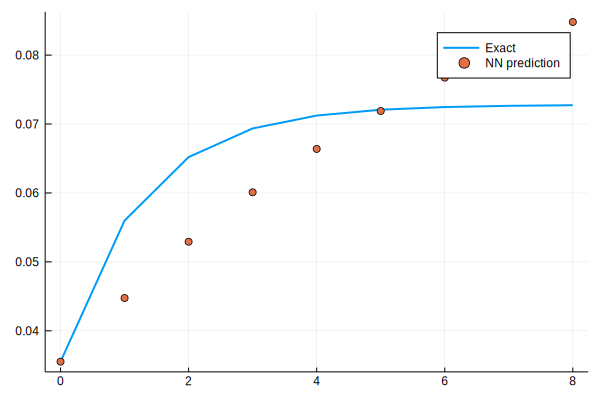

loss: 0.00355:  25%|██████████▏                              |  ETA: 0:00:20

0.0035020101f0

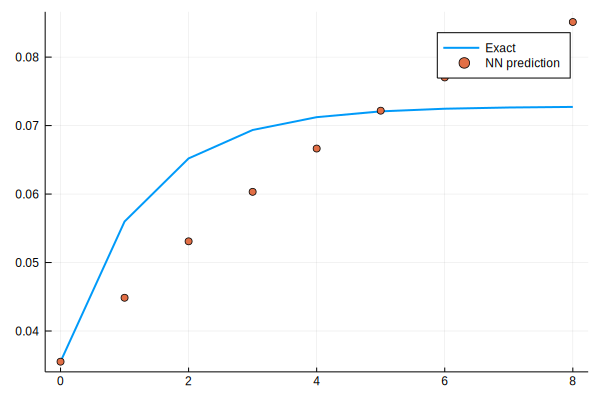

0.0034504673f0

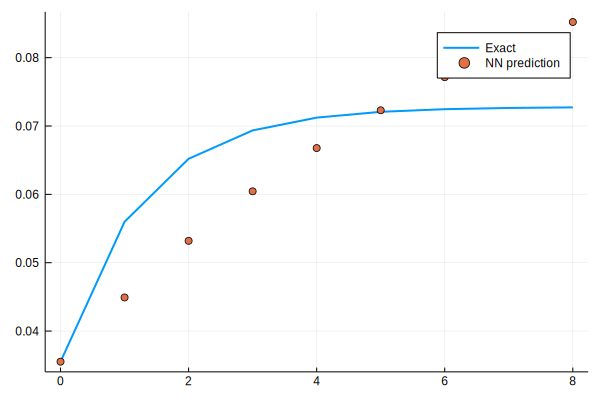

loss: 0.00345:  25%|██████████▍                              |  ETA: 0:00:20

0.0033972792f0

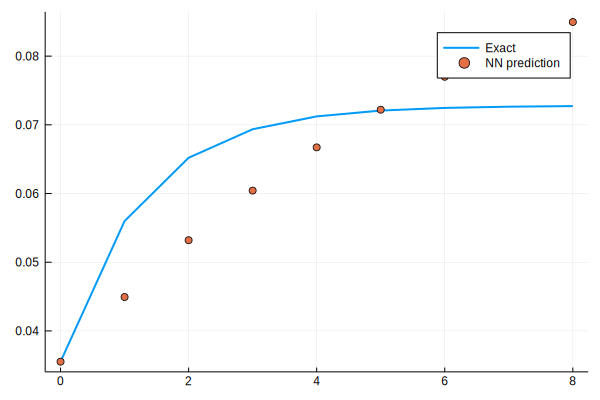

0.0033429014f0

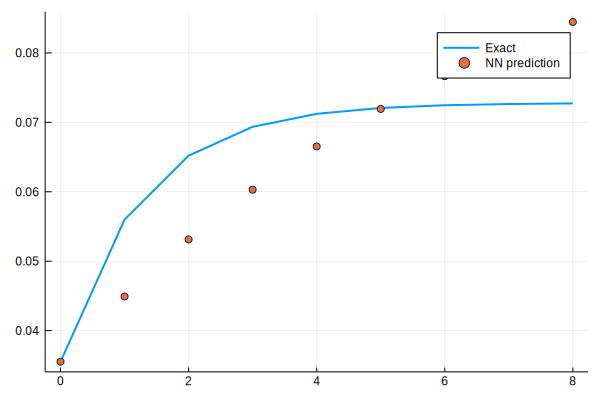

loss: 0.00334:  26%|██████████▋                              |  ETA: 0:00:20

0.0032877272f0

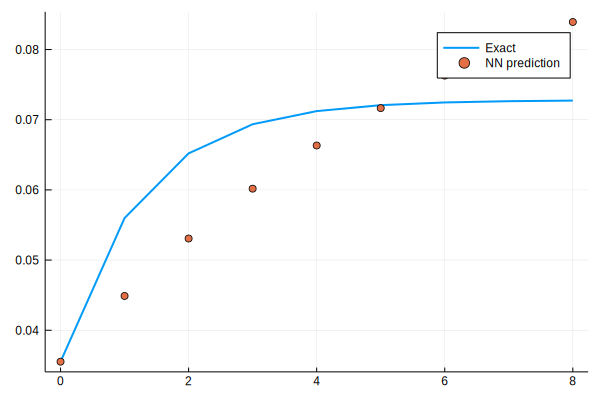

0.0032337701f0

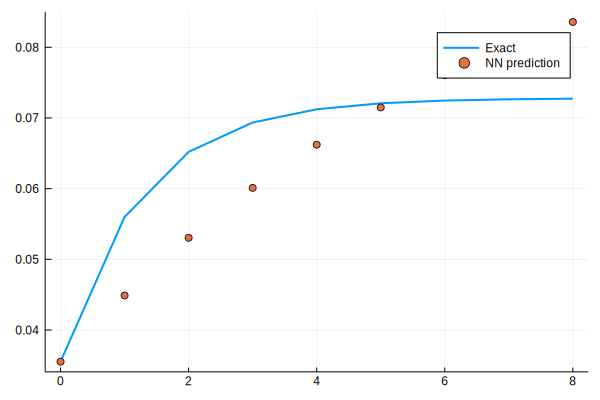

loss: 0.00323:  27%|██████████▉                              |  ETA: 0:00:20

0.0031828207f0

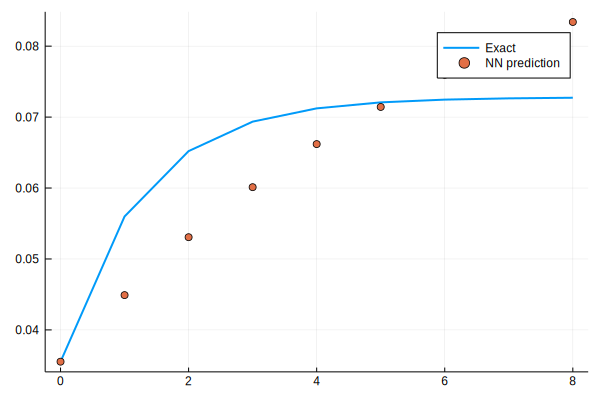

loss: 0.00318:  27%|███████████▏                             |  ETA: 0:00:20

0.003133883f0

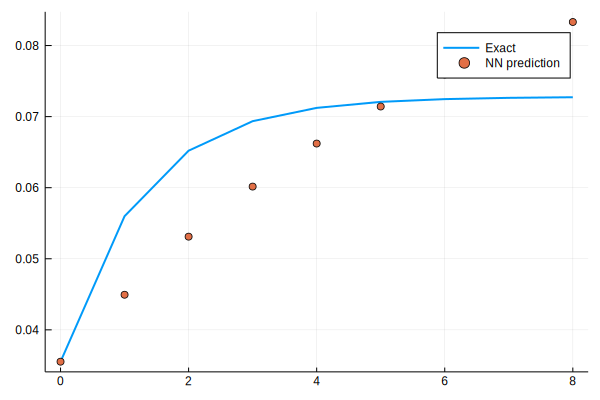

0.0030855958f0

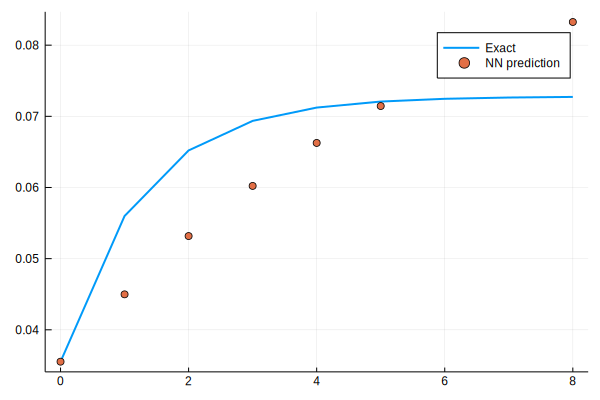

loss: 0.00309:  28%|███████████▍                             |  ETA: 0:00:20

0.0030356608f0

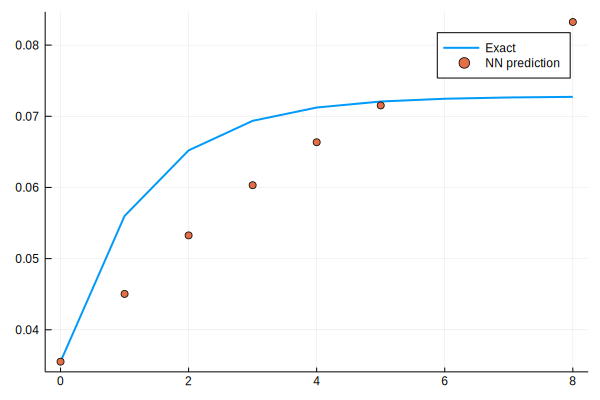

0.0029842341f0

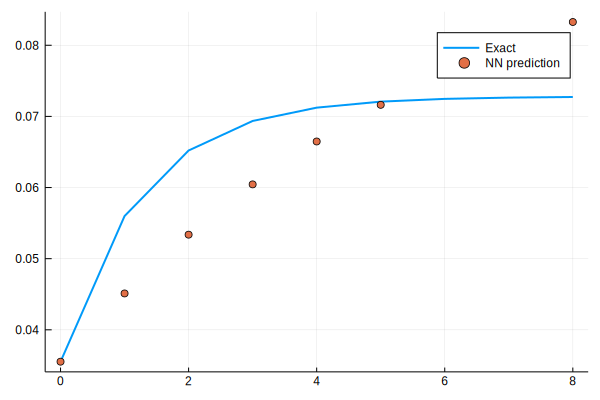

loss: 0.00298:  28%|███████████▋                             |  ETA: 0:00:19

0.0029330968f0

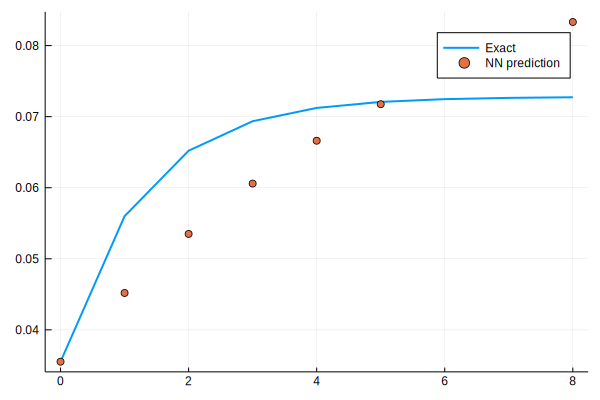

0.0028840129f0

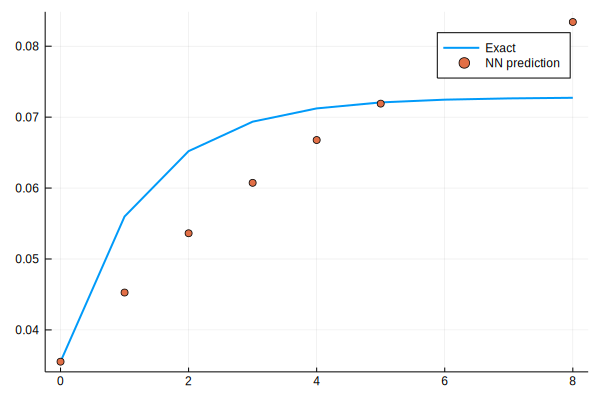

loss: 0.00288:  29%|███████████▉                             |  ETA: 0:00:19

0.0028369299f0

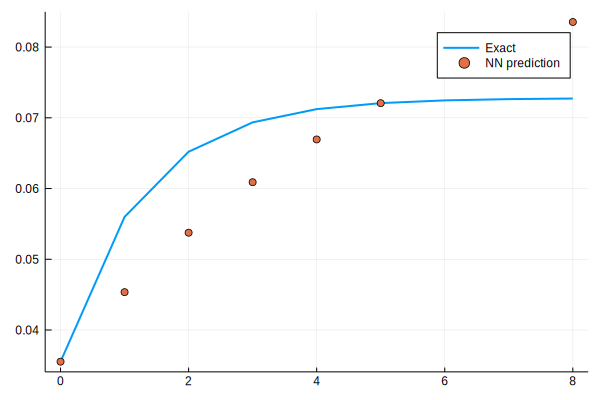

0.002791087f0

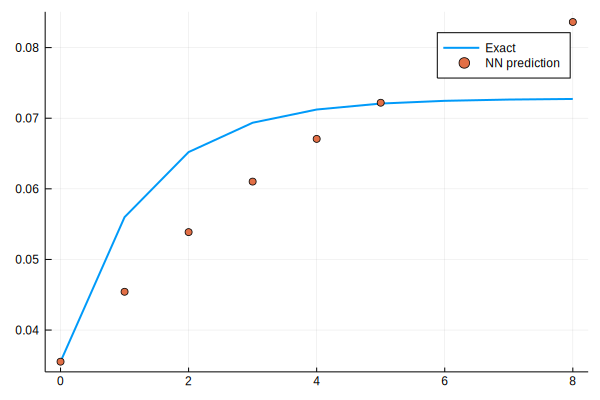

loss: 0.00279:  30%|████████████▏                            |  ETA: 0:00:19

0.0027449552f0

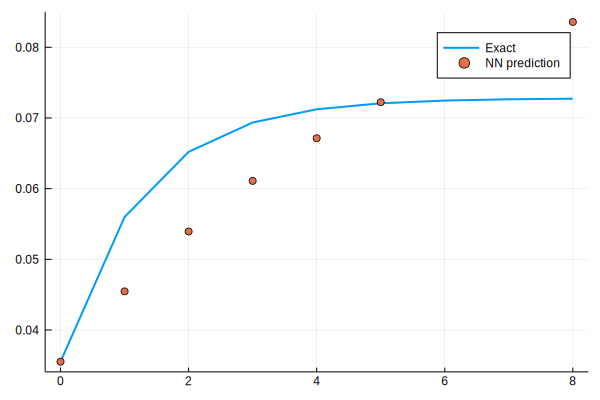

0.002697289f0

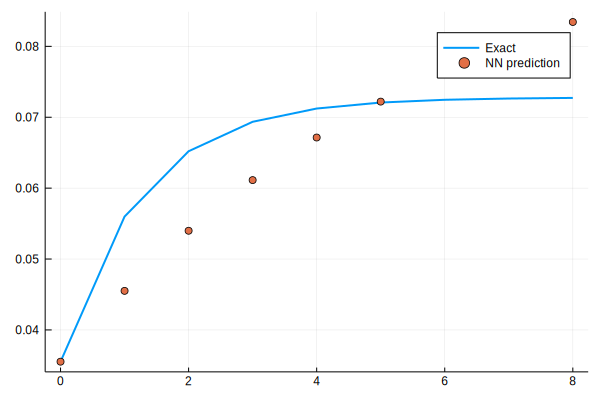

loss: 0.0027:  30%|████████████▍                            |  ETA: 0:00:19

0.0026496602f0

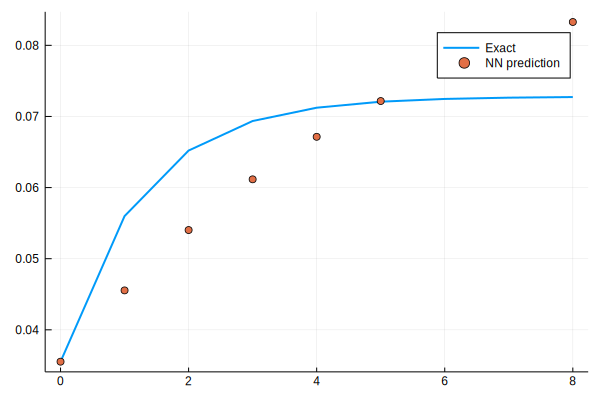

0.0026036322f0

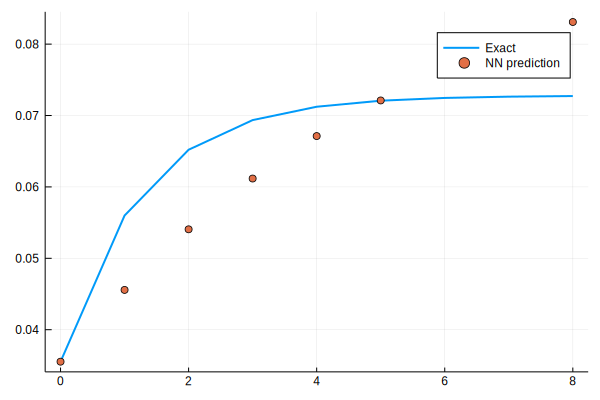

loss: 0.0026:  31%|████████████▊                            |  ETA: 0:00:19

0.0025594959f0

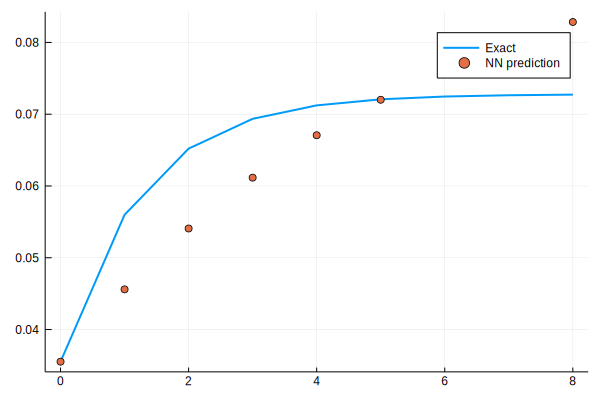

0.0025161295f0

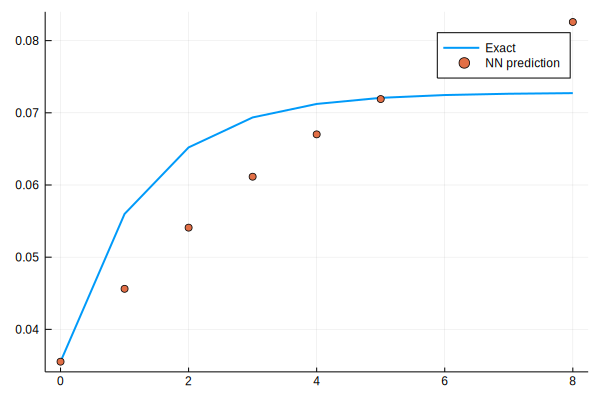

loss: 0.00252:  32%|█████████████                            |  ETA: 0:00:19

0.0024724146f0

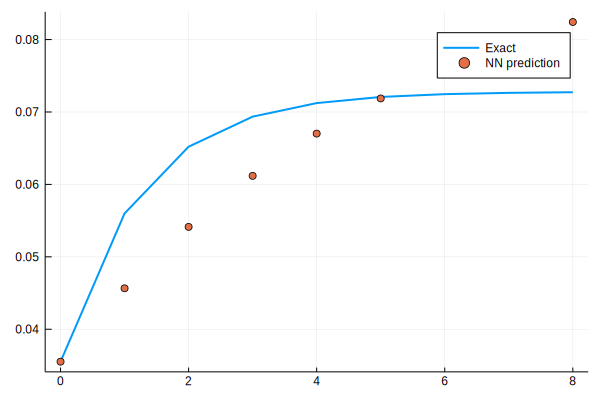

0.0024285293f0

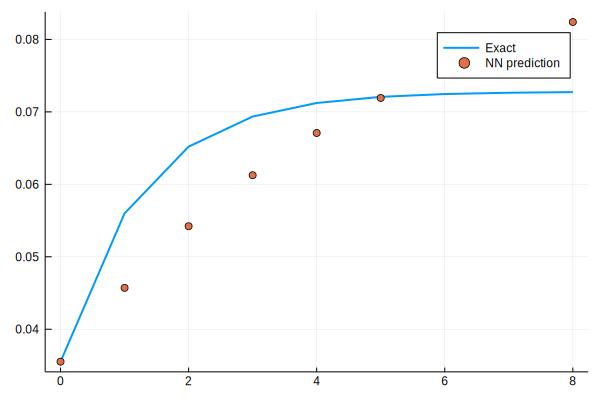

loss: 0.00243:  32%|█████████████▎                           |  ETA: 0:00:18

0.002385148f0

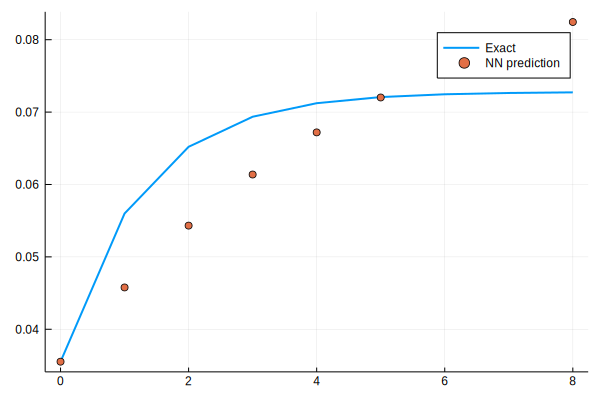

0.002342694f0

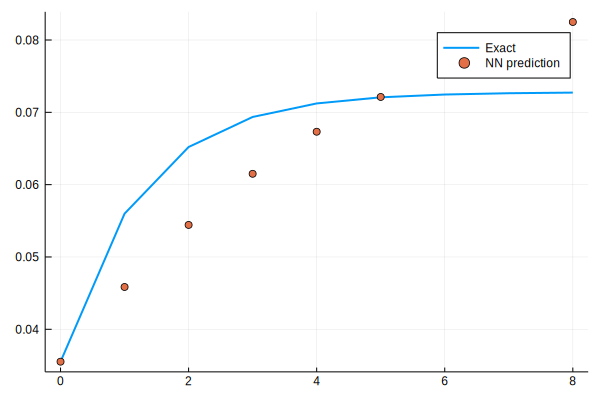

loss: 0.00234:  33%|█████████████▌                           |  ETA: 0:00:18

0.0023011914f0

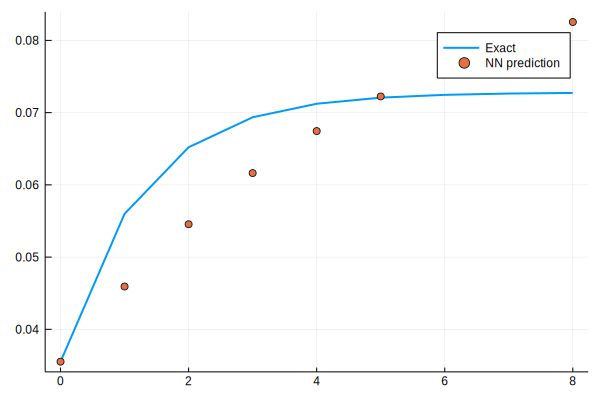

0.0022603606f0

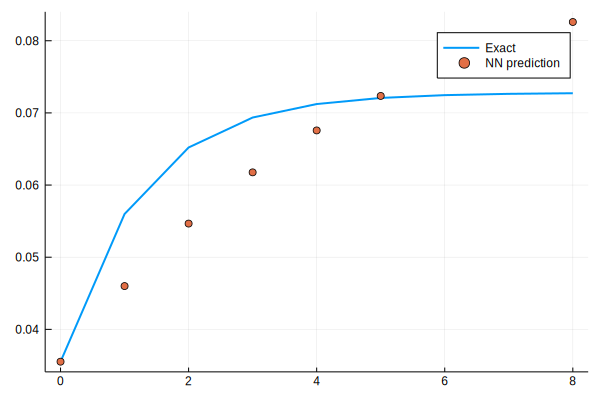

loss: 0.00226:  34%|█████████████▊                           |  ETA: 0:00:18

0.0022199159f0

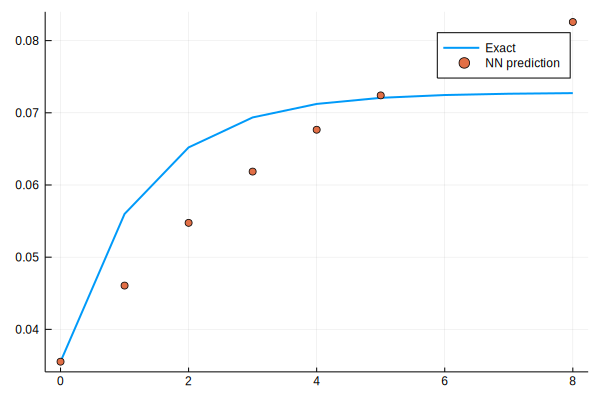

0.002179771f0

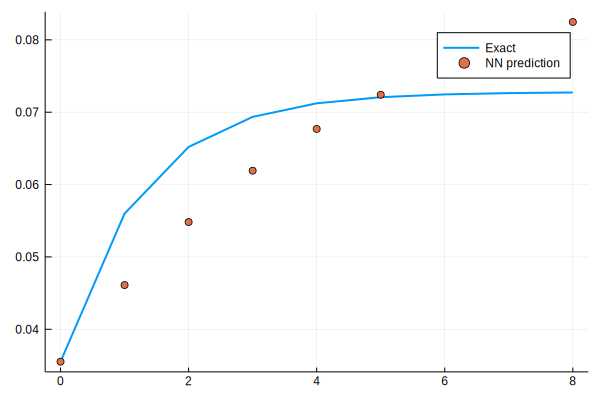

loss: 0.00218:  34%|██████████████▏                          |  ETA: 0:00:18

0.002140079f0

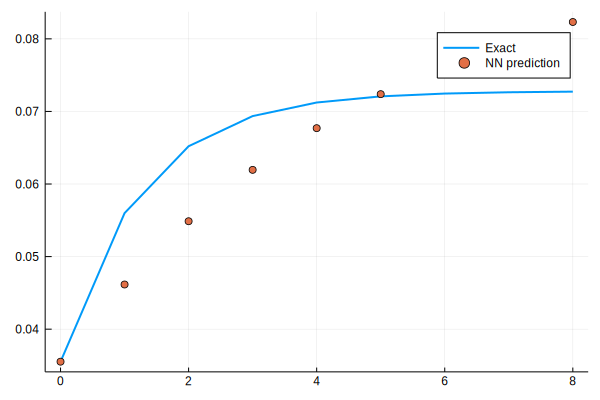

0.0021009694f0

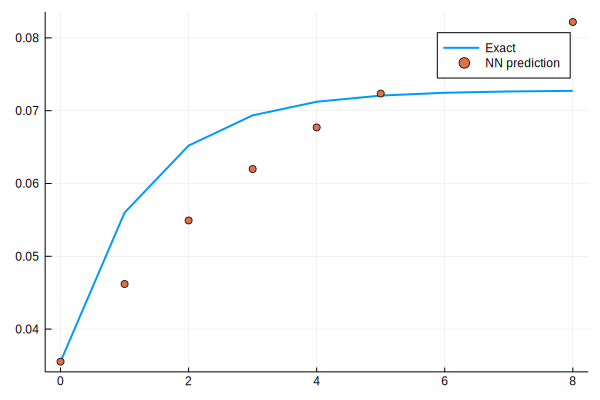

loss: 0.0021:  35%|██████████████▍                          |  ETA: 0:00:18

0.0020626113f0

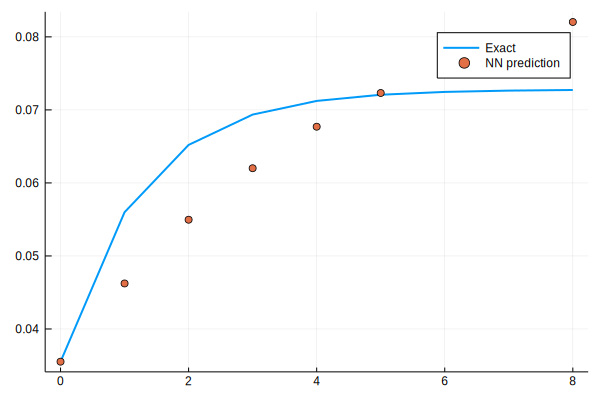

loss: 0.00206:  35%|██████████████▌                          |  ETA: 0:00:18

0.002024915f0

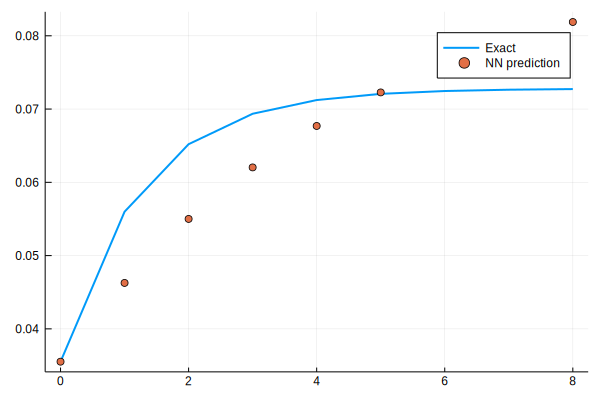

0.001987764f0

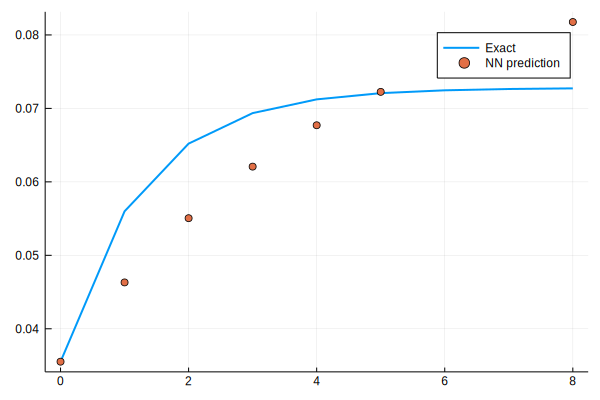

loss: 0.00199:  36%|██████████████▊                          |  ETA: 0:00:17

0.0019510887f0

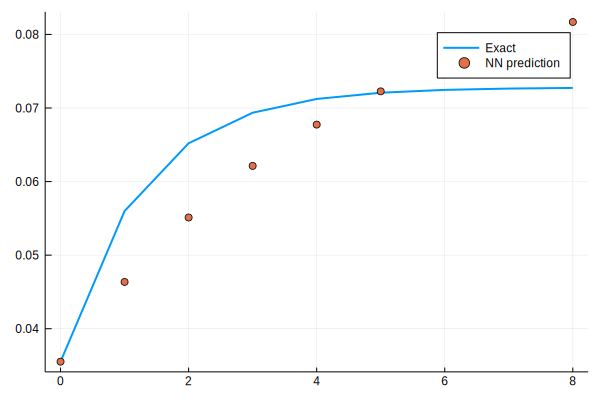

0.001914891f0

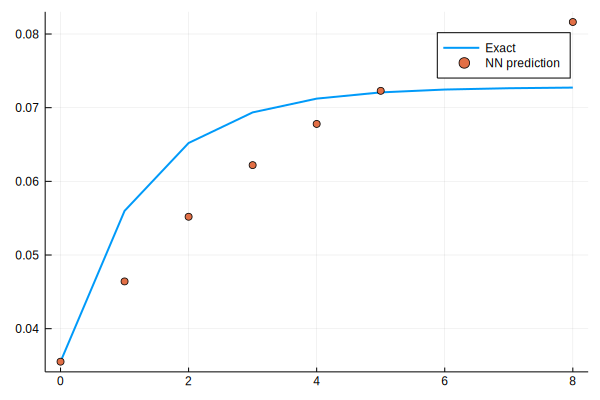

loss: 0.00191:  37%|███████████████                          |  ETA: 0:00:17

0.0018792036f0

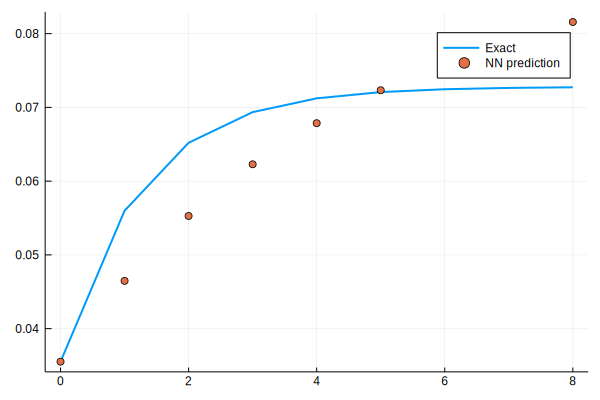

0.0018440783f0

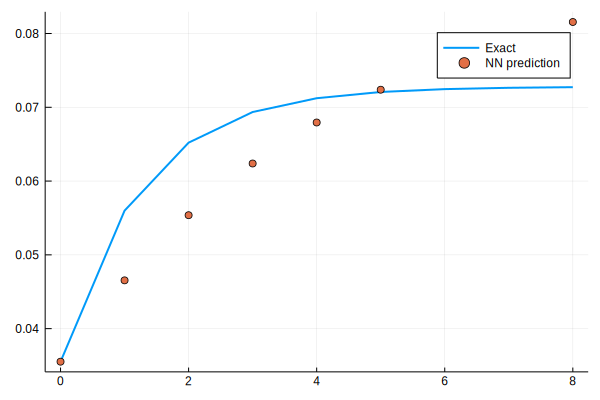

loss: 0.00184:  37%|███████████████▎                         |  ETA: 0:00:17

0.0018096009f0

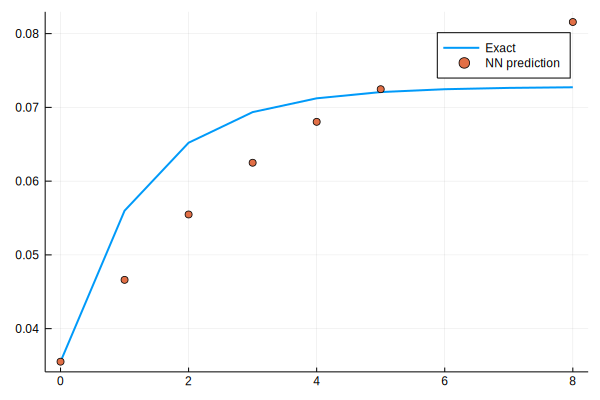

0.0017757637f0

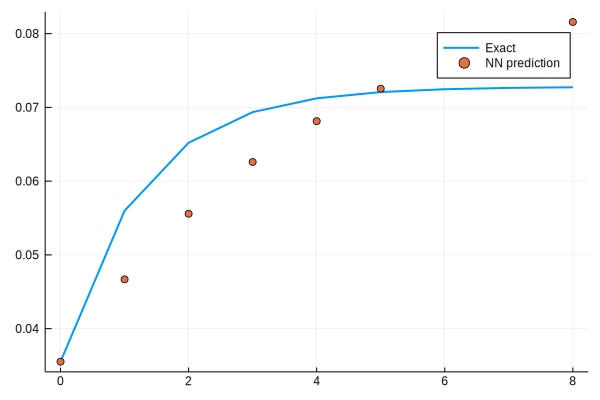

loss: 0.00178:  38%|███████████████▋                         |  ETA: 0:00:17

0.001742459f0

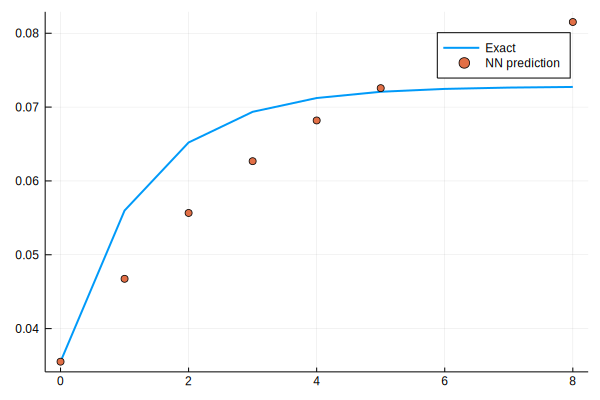

loss: 0.00174:  38%|███████████████▊                         |  ETA: 0:00:17

0.0017095717f0

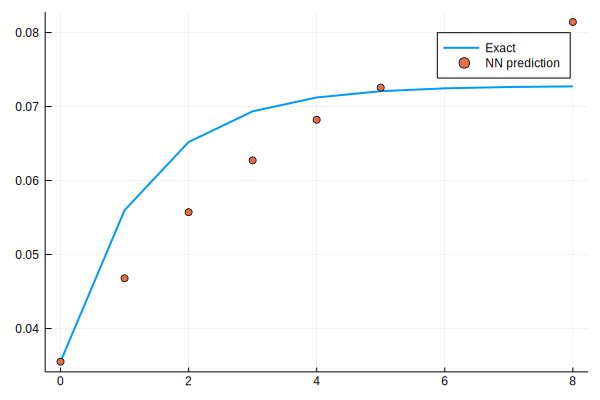

loss: 0.00171:  39%|███████████████▉                         |  ETA: 0:00:17

0.0016771493f0

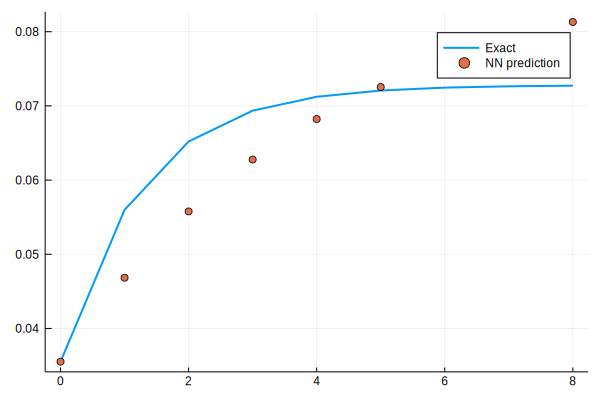

0.0016453215f0

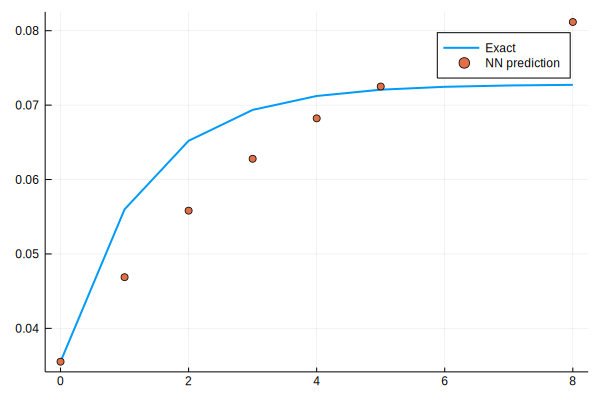

loss: 0.00165:  39%|████████████████▏                        |  ETA: 0:00:17

0.001614118f0

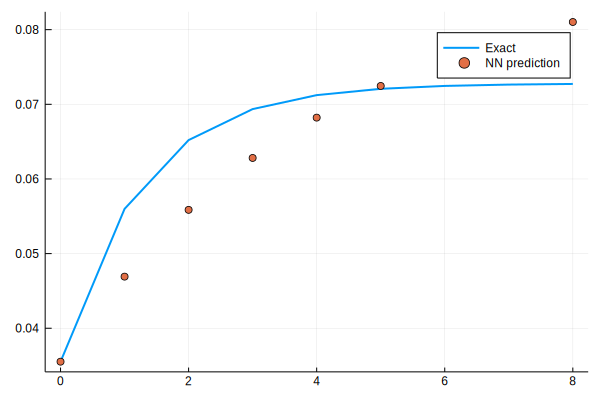

0.0015835068f0

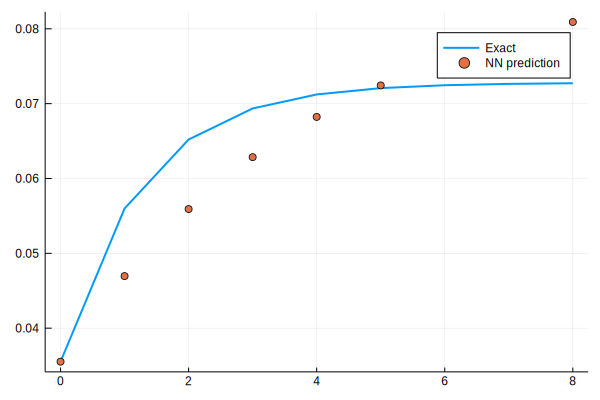

loss: 0.00158:  40%|████████████████▍                        |  ETA: 0:00:16

0.0015533479f0

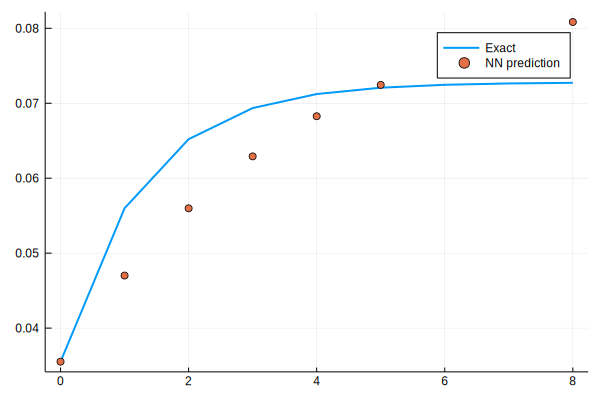

0.001523639f0

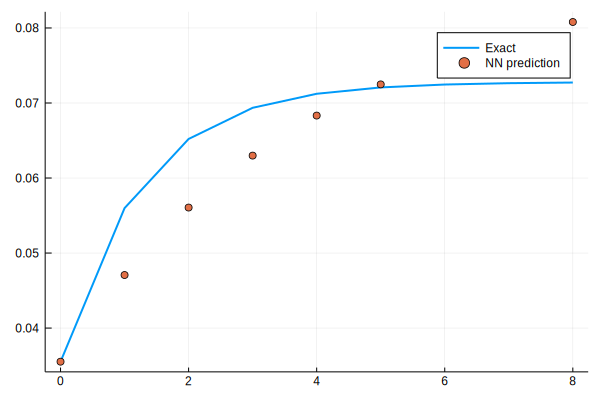

loss: 0.00152:  41%|████████████████▋                        |  ETA: 0:00:16

0.001494425f0

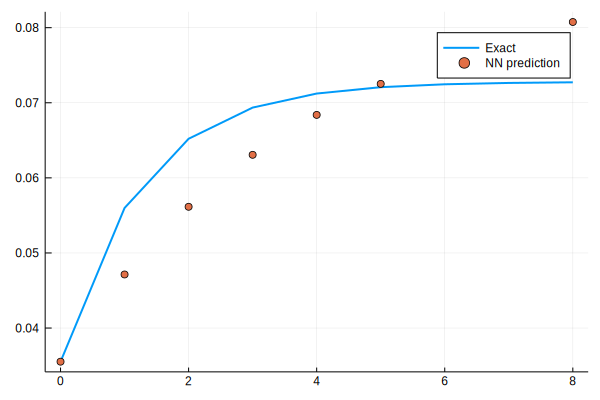

0.0014657734f0

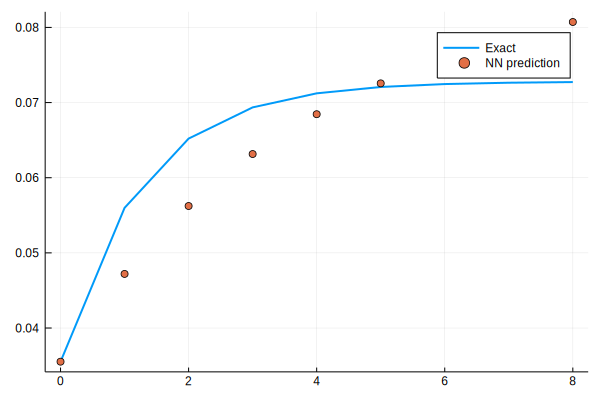

loss: 0.00147:  41%|████████████████▉                        |  ETA: 0:00:16

0.0014376765f0

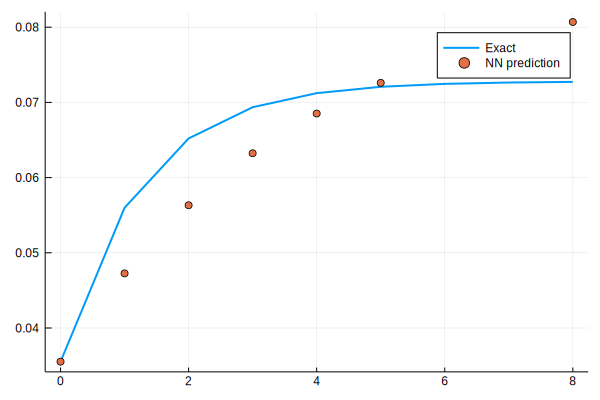

0.0014100834f0

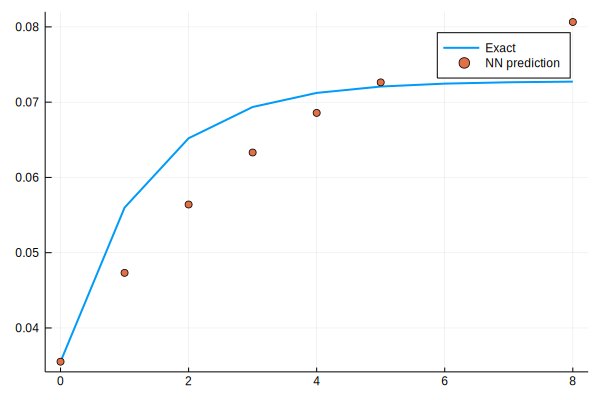

loss: 0.00141:  42%|█████████████████▎                       |  ETA: 0:00:16

0.001382944f0

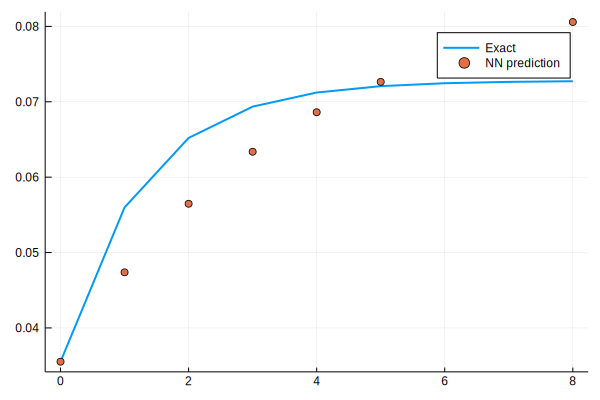

0.0013562844f0

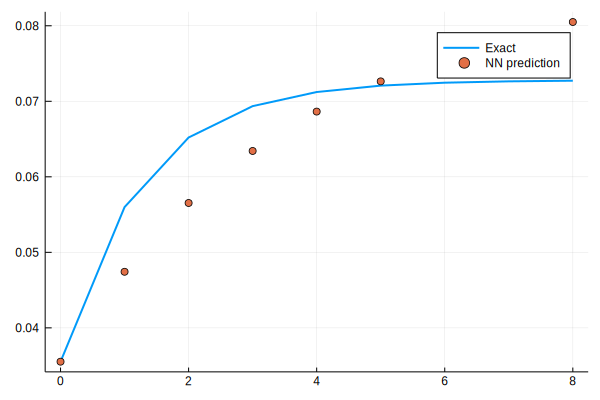

loss: 0.00136:  43%|█████████████████▌                       |  ETA: 0:00:16

0.001330107f0

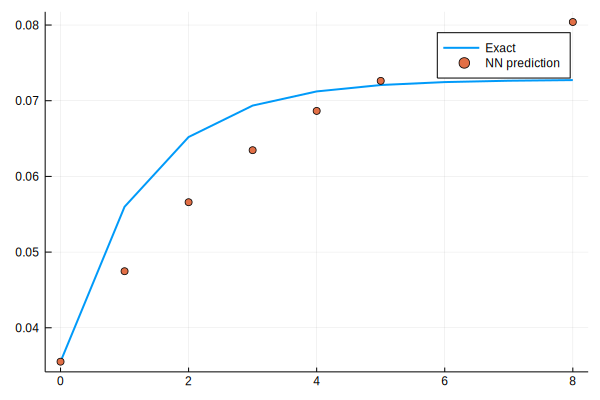

0.0013044159f0

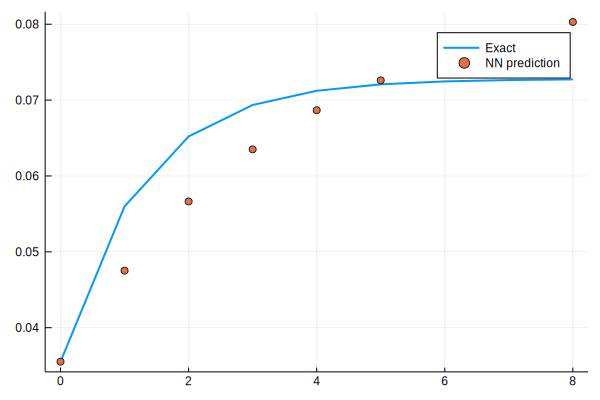

loss: 0.0013:  43%|█████████████████▊                       |  ETA: 0:00:16

0.0012792216f0

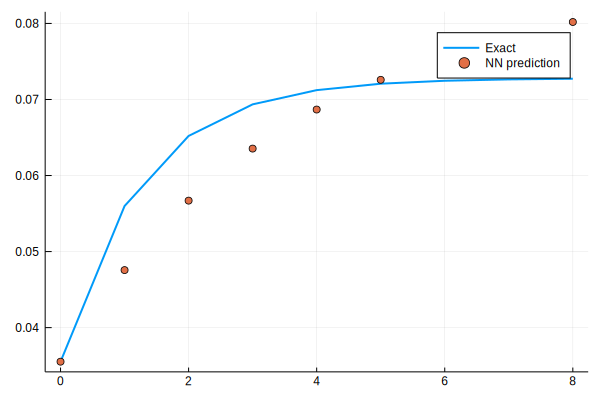

loss: 0.00128:  44%|█████████████████▉                       |  ETA: 0:00:15

0.0012544973f0

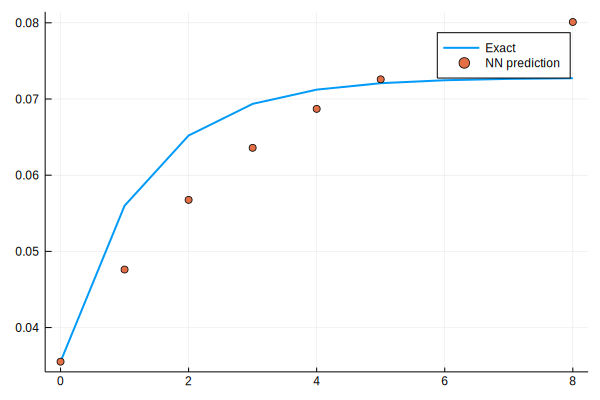

0.0012302205f0

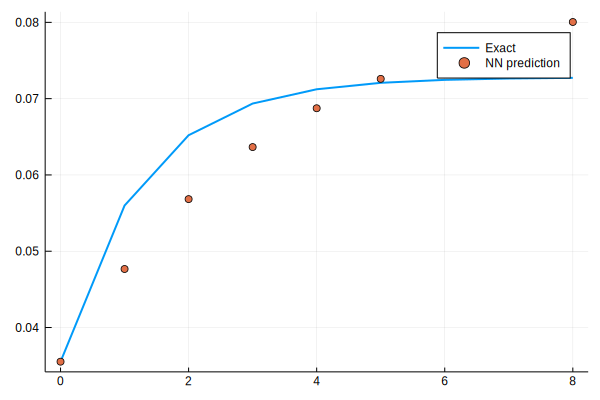

loss: 0.00123:  44%|██████████████████▏                      |  ETA: 0:00:15

0.001206384f0

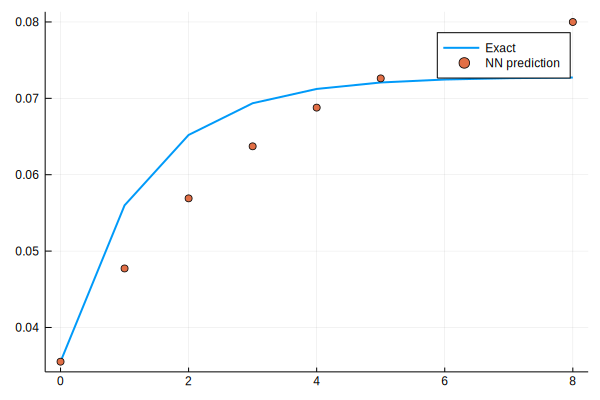

0.0011829971f0

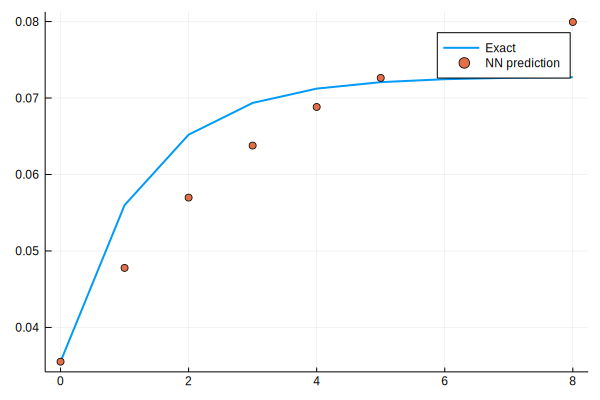

loss: 0.00118:  45%|██████████████████▌                      |  ETA: 0:00:15

0.0011600599f0

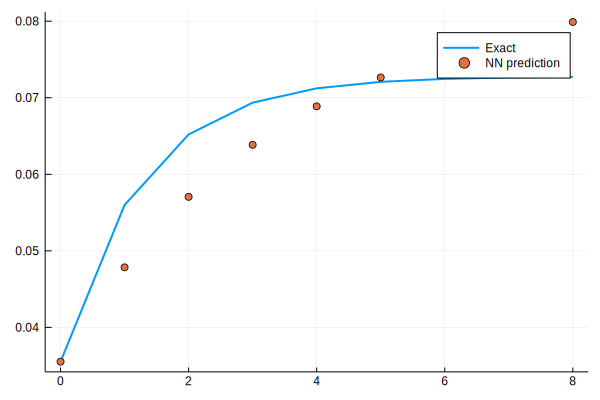

0.001137561f0

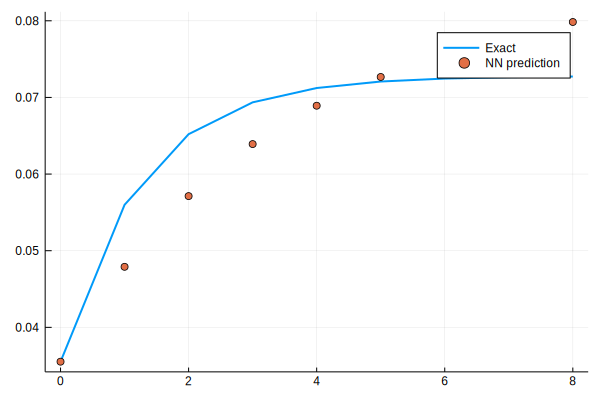

loss: 0.00114:  46%|██████████████████▊                      |  ETA: 0:00:15

0.0011154962f0

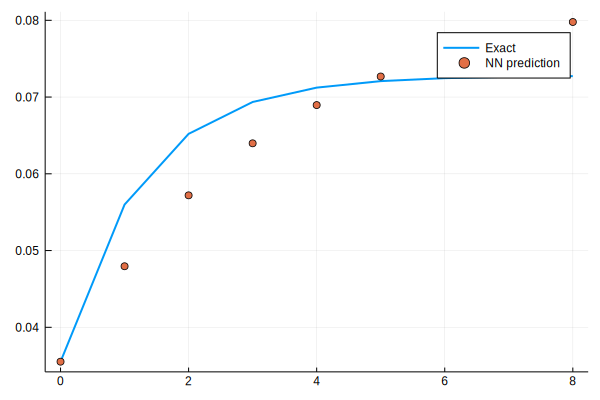

0.0010938557f0

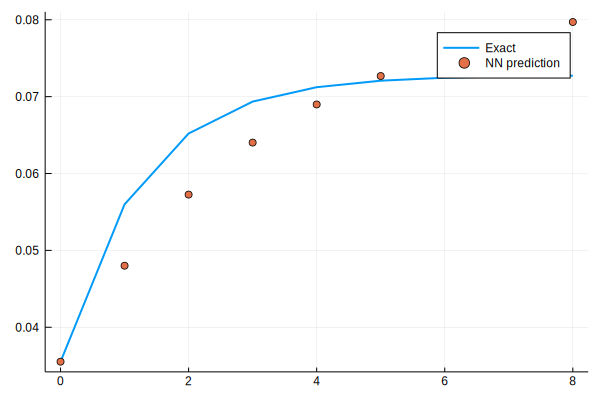

loss: 0.00109:  46%|███████████████████                      |  ETA: 0:00:15

0.0010726219f0

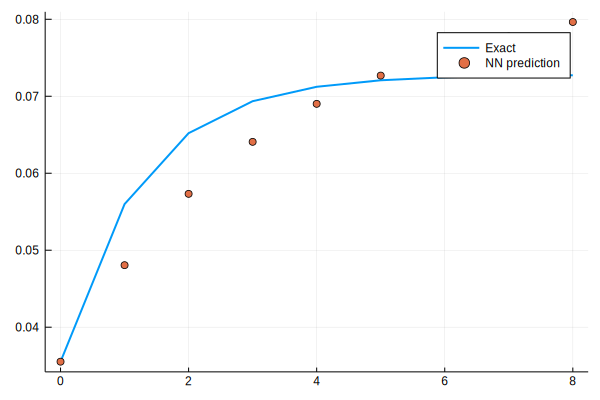

loss: 0.00107:  47%|███████████████████▏                     |  ETA: 0:00:15

0.0010517928f0

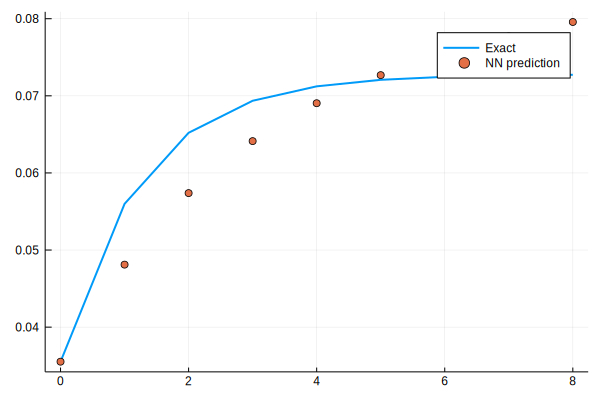

0.0010313703f0

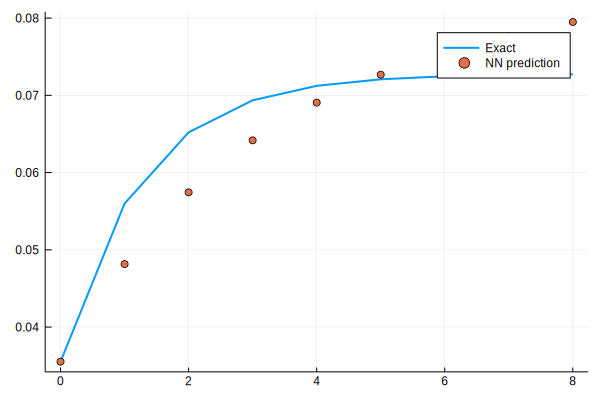

loss: 0.00103:  47%|███████████████████▍                     |  ETA: 0:00:15

0.0010113532f0

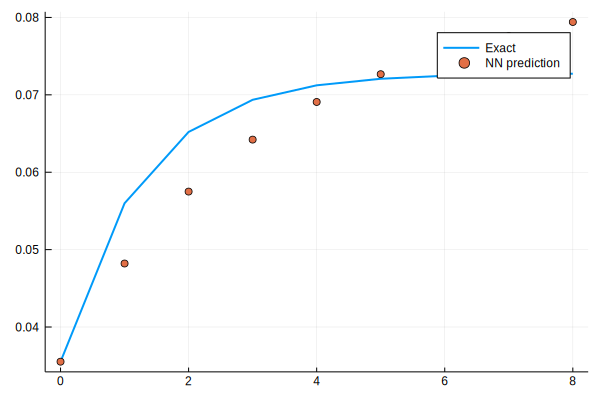

0.0009917306f0

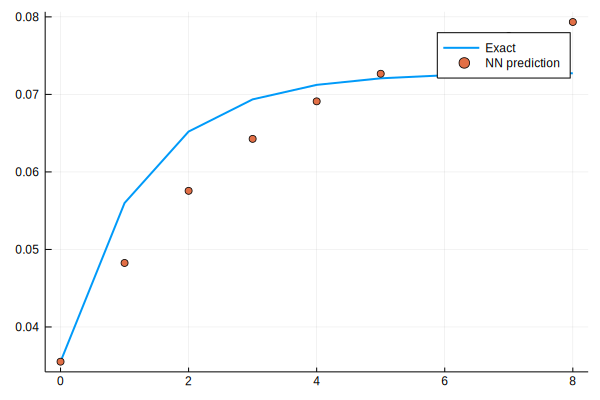

loss: 0.000992:  48%|███████████████████▋                     |  ETA: 0:00:14

0.0009724857f0

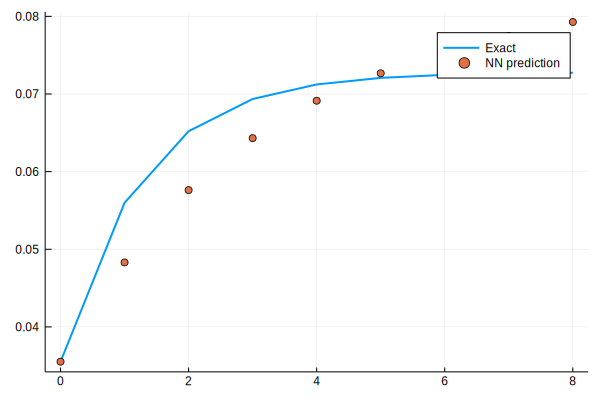

loss: 0.000972:  48%|███████████████████▊                     |  ETA: 0:00:14

0.00095361326f0

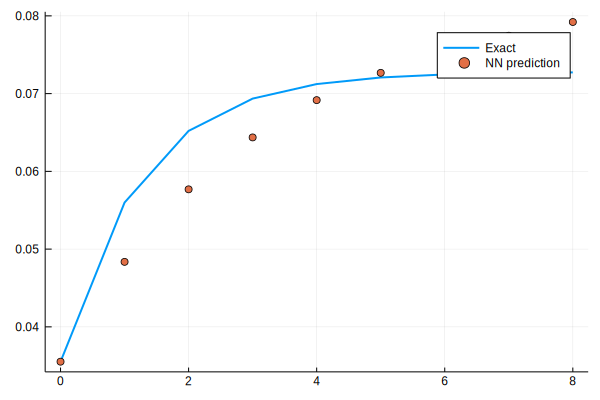

0.00093511015f0

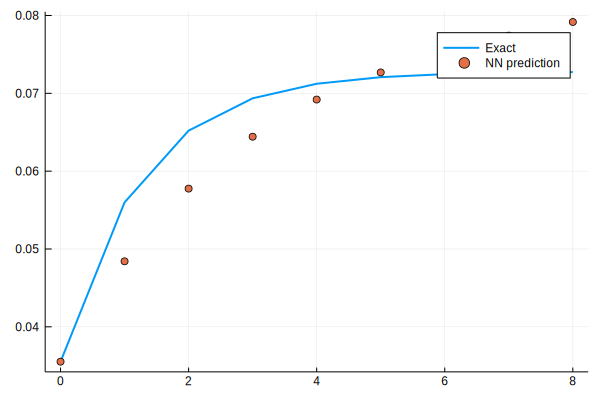

loss: 0.000935:  49%|████████████████████▏                    |  ETA: 0:00:14

0.00091697706f0

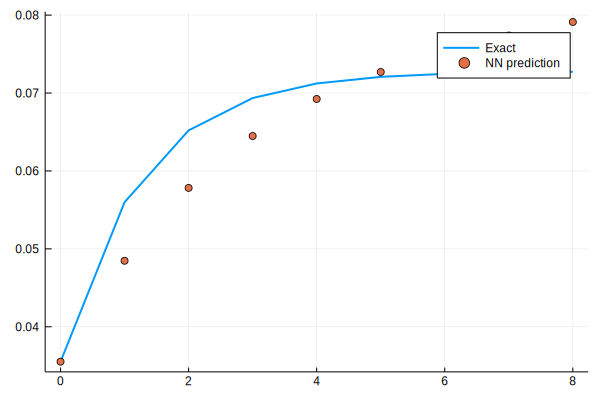

0.000899204f0

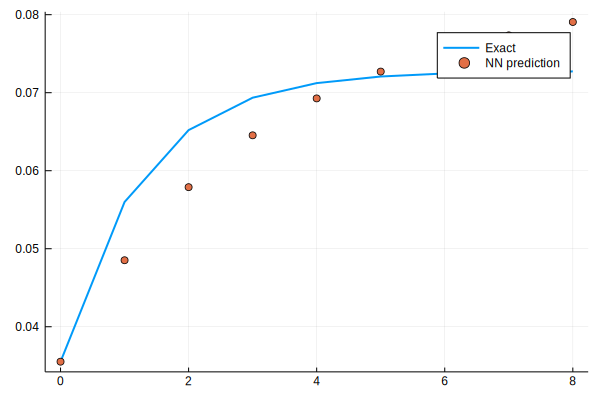

loss: 0.000899:  50%|████████████████████▍                    |  ETA: 0:00:14

0.0008817852f0

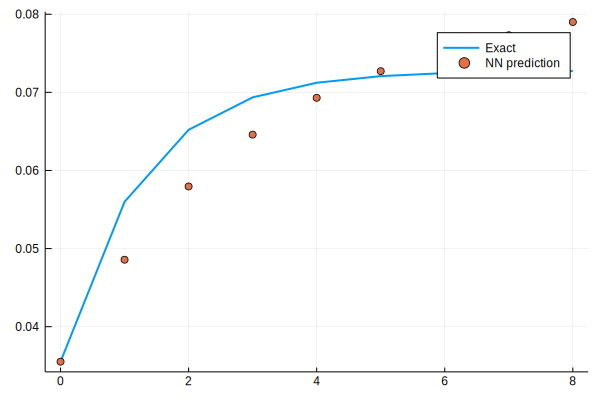

loss: 0.000882:  50%|████████████████████▌                    |  ETA: 0:00:14

0.0008647082f0

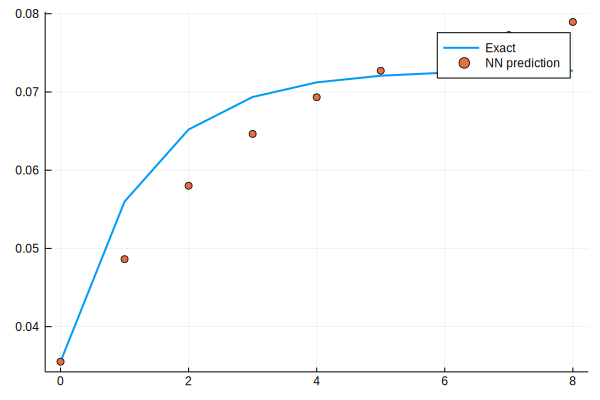

0.0008479633f0

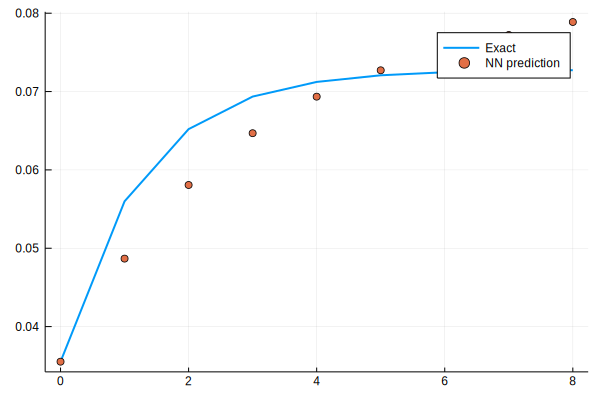

loss: 0.000848:  51%|████████████████████▊                    |  ETA: 0:00:14

0.00083156023f0

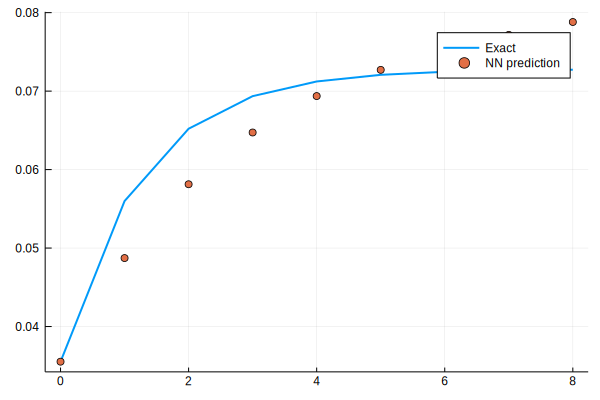

loss: 0.000832:  51%|████████████████████▉                    |  ETA: 0:00:14

0.0008154815f0

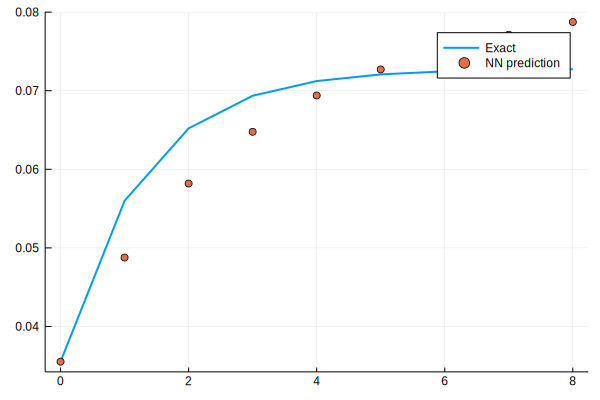

loss: 0.000815:  51%|█████████████████████                    |  ETA: 0:00:14

0.00079972413f0

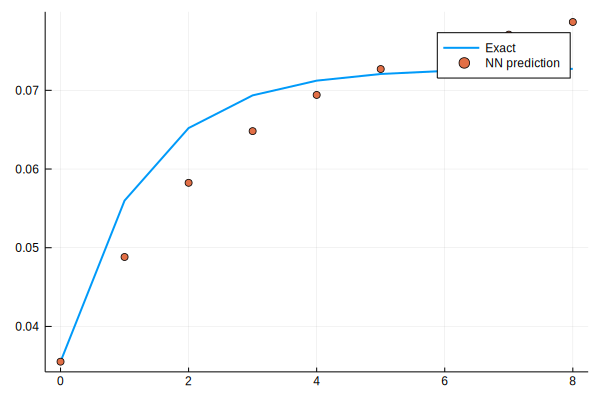

loss: 0.0008:  52%|█████████████████████▏                   |  ETA: 0:00:14

0.00078428176f0

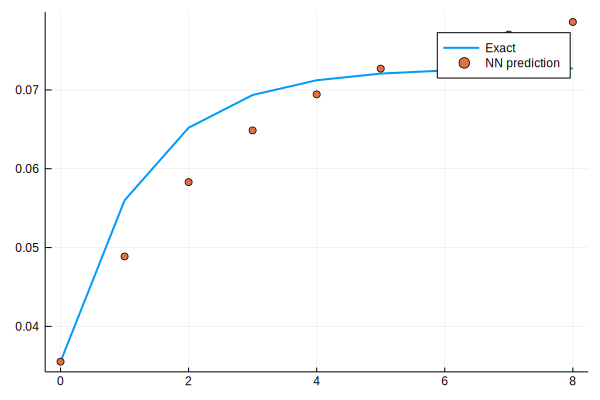

loss: 0.000784:  52%|█████████████████████▍                   |  ETA: 0:00:13

0.0007691463f0

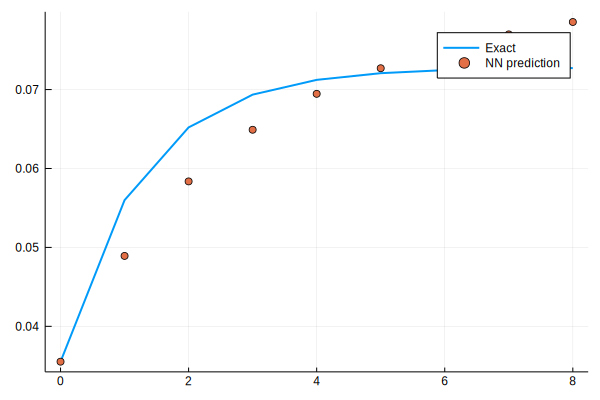

0.0007543132f0

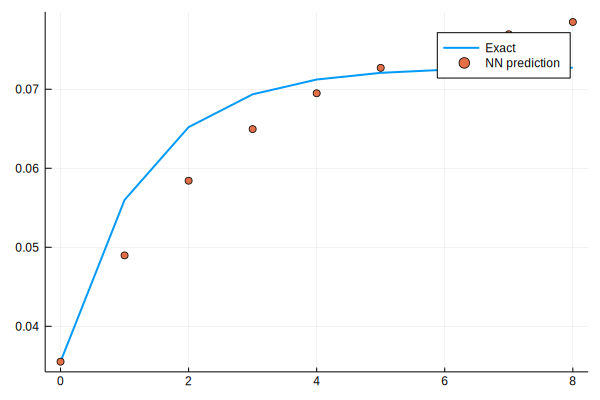

loss: 0.000754:  53%|█████████████████████▋                   |  ETA: 0:00:13

0.00073977787f0

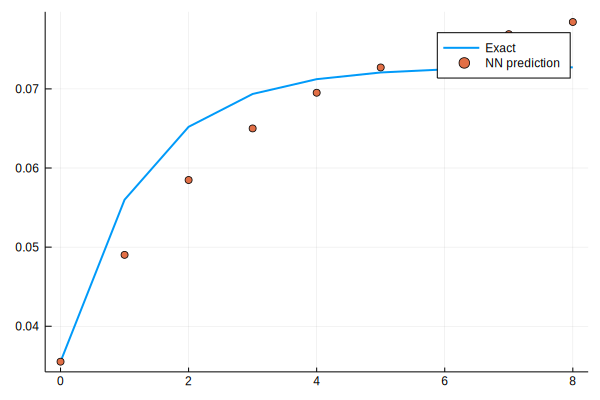

loss: 0.00074:  53%|█████████████████████▊                   |  ETA: 0:00:13

0.0007255356f0

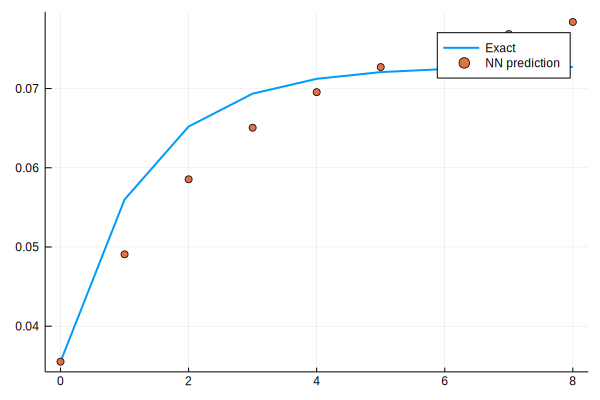

loss: 0.000726:  53%|█████████████████████▉                   |  ETA: 0:00:13

0.00071157777f0

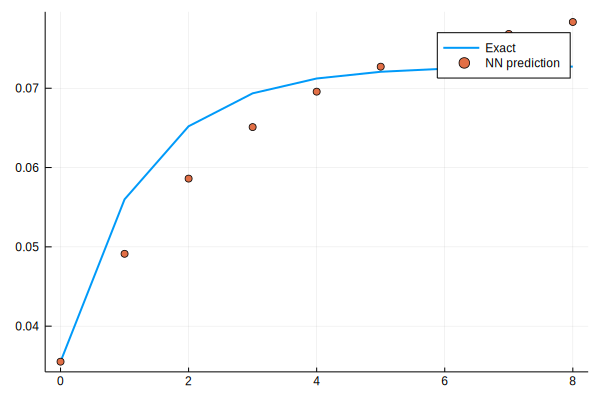

loss: 0.000712:  54%|██████████████████████                   |  ETA: 0:00:13

0.00069790095f0

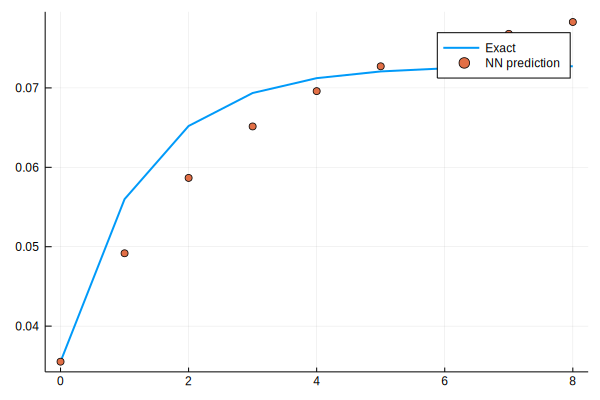

loss: 0.000698:  54%|██████████████████████▏                  |  ETA: 0:00:13

0.0006844988f0

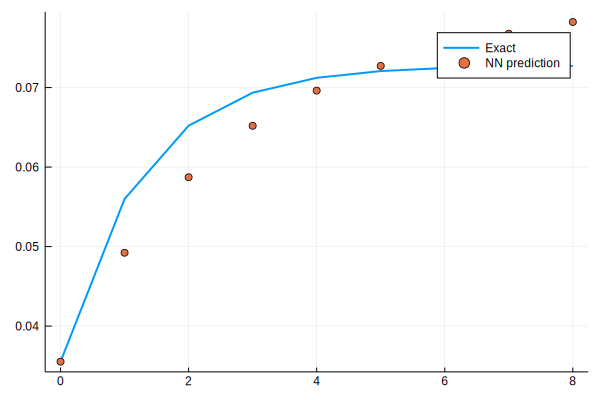

loss: 0.000684:  54%|██████████████████████▎                  |  ETA: 0:00:13

0.000671365f0

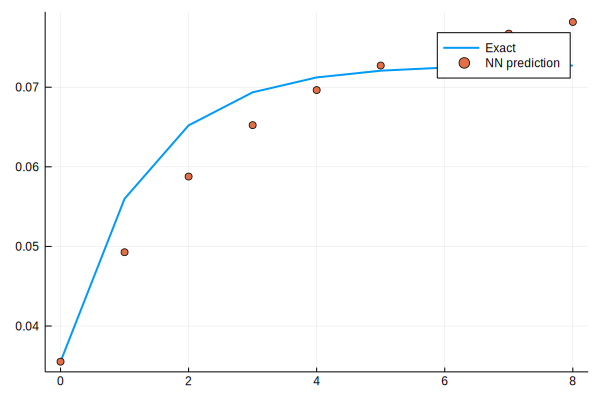

loss: 0.000671:  55%|██████████████████████▍                  |  ETA: 0:00:13

0.0006584955f0

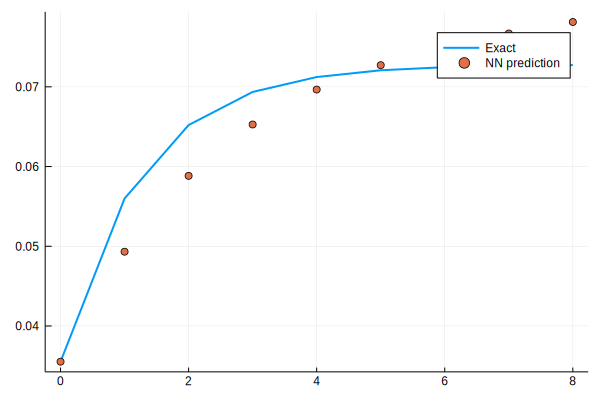

loss: 0.000658:  55%|██████████████████████▌                  |  ETA: 0:00:13

0.00064588524f0

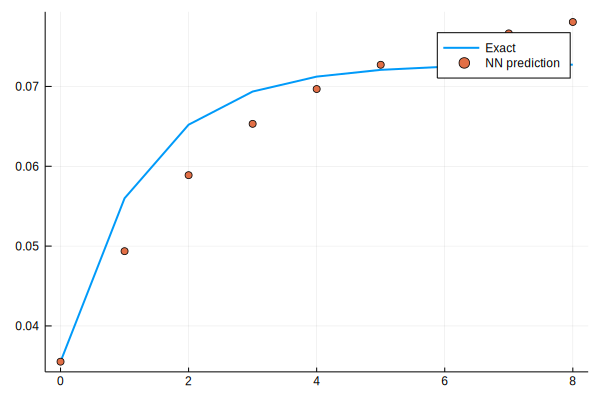

loss: 0.000646:  55%|██████████████████████▋                  |  ETA: 0:00:13

0.0006335268f0

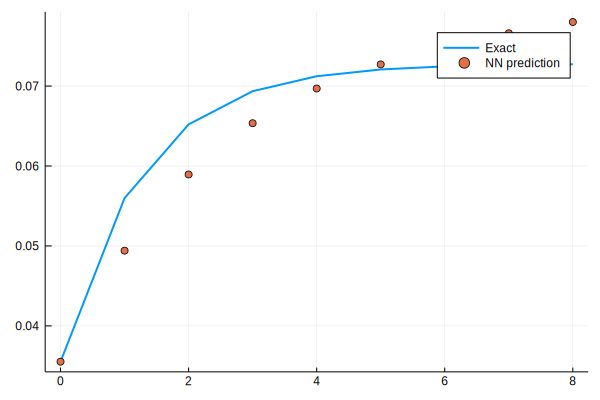

loss: 0.000634:  56%|██████████████████████▊                  |  ETA: 0:00:13

0.0006214186f0

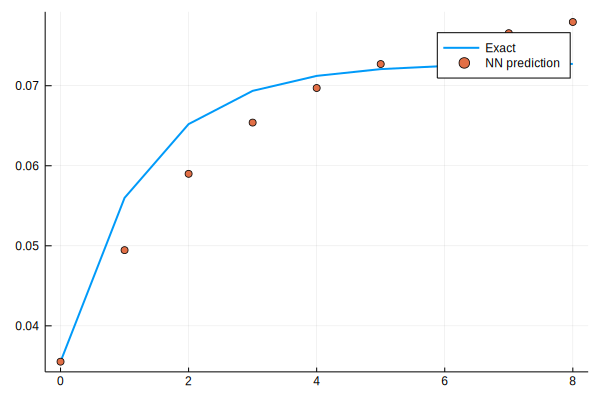

loss: 0.000621:  56%|███████████████████████                  |  ETA: 0:00:13

0.00060955423f0

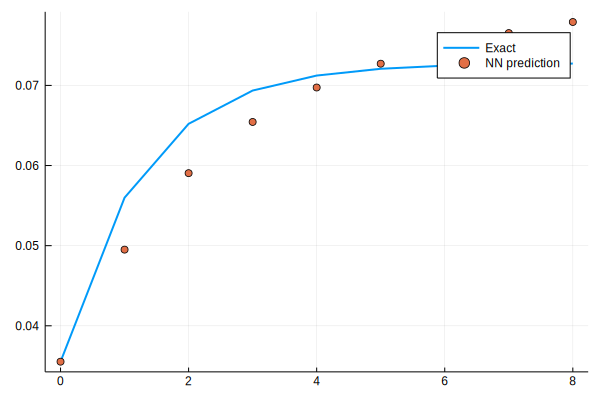

0.0005979264f0

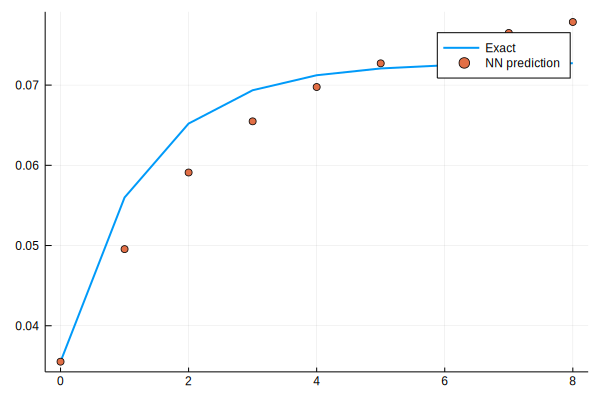

loss: 0.000598:  57%|███████████████████████▎                 |  ETA: 0:00:12

0.0005865324f0

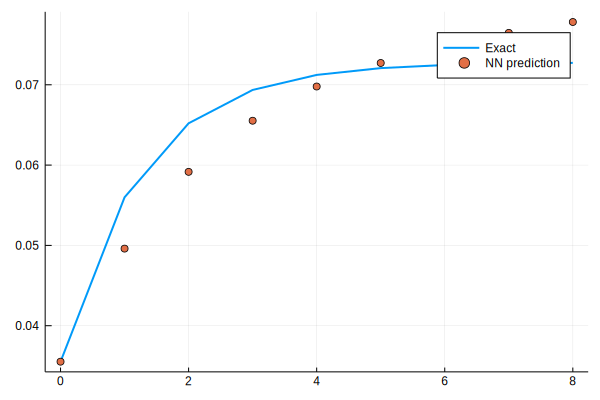

loss: 0.000587:  57%|███████████████████████▍                 |  ETA: 0:00:12

0.0005753675f0

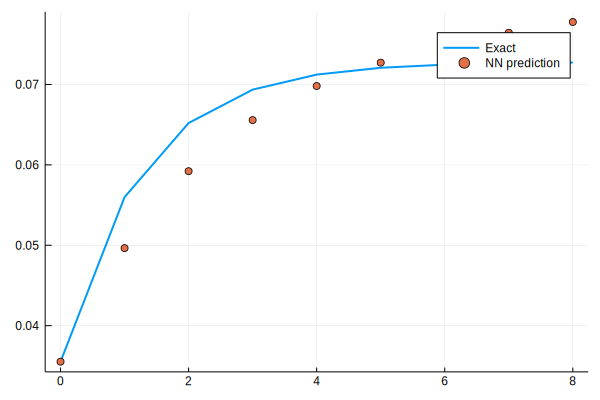

loss: 0.000575:  57%|███████████████████████▌                 |  ETA: 0:00:12

0.00056442764f0

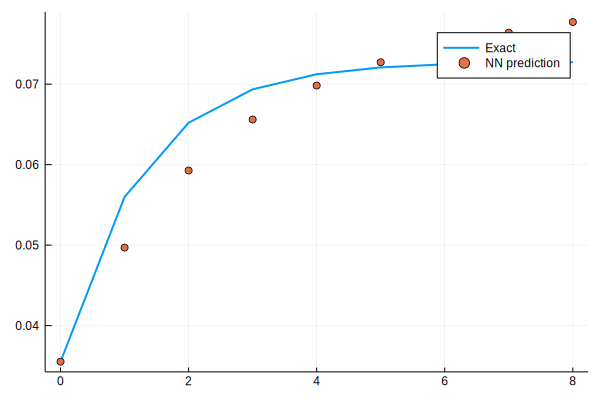

loss: 0.000564:  58%|███████████████████████▋                 |  ETA: 0:00:12

0.0005537064f0

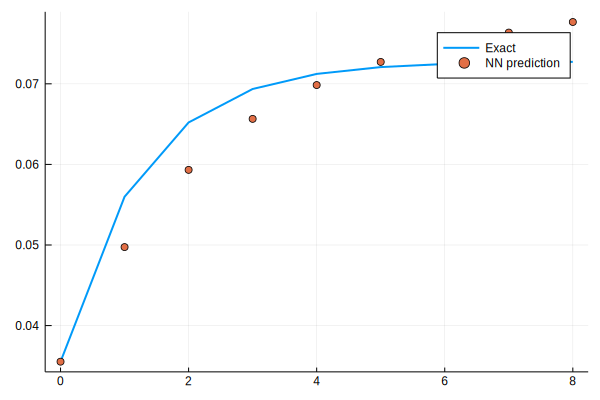

loss: 0.000554:  58%|███████████████████████▊                 |  ETA: 0:00:12

0.00054320024f0

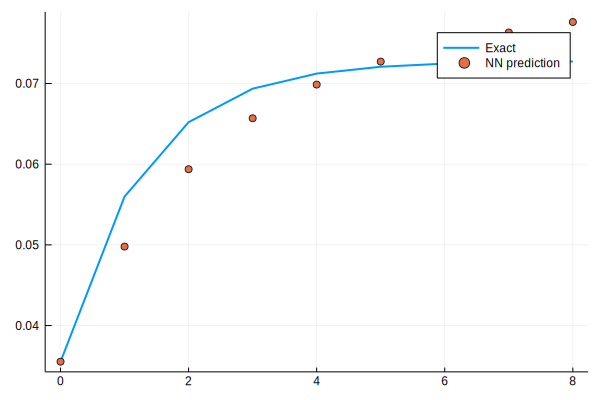

loss: 0.000543:  58%|███████████████████████▉                 |  ETA: 0:00:12

0.00053290493f0

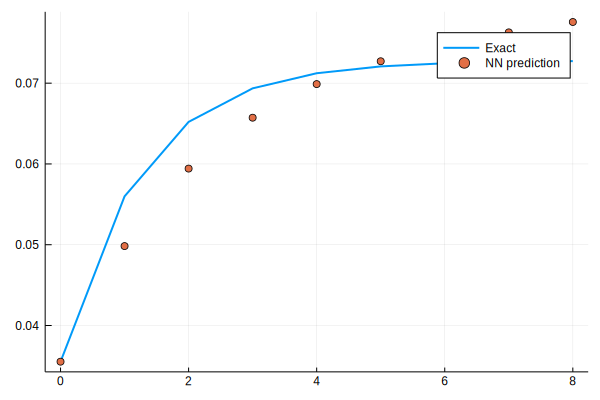

0.0005228159f0

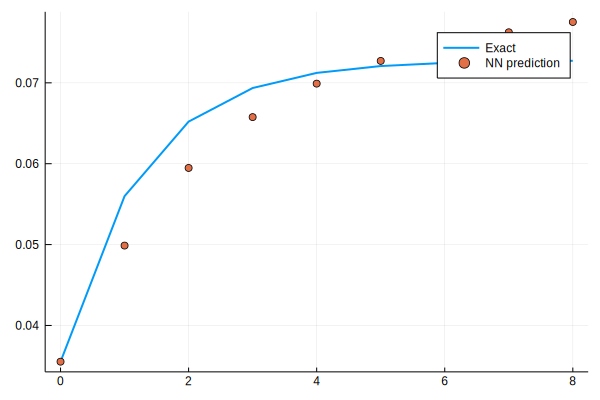

loss: 0.000523:  59%|████████████████████████▎                |  ETA: 0:00:12

0.00051292684f0

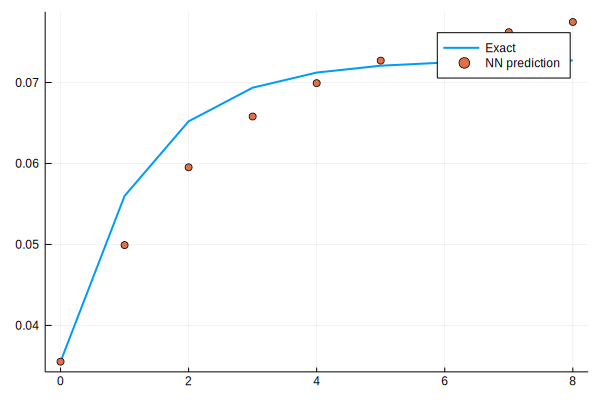

loss: 0.000513:  59%|████████████████████████▍                |  ETA: 0:00:12

0.00050323975f0

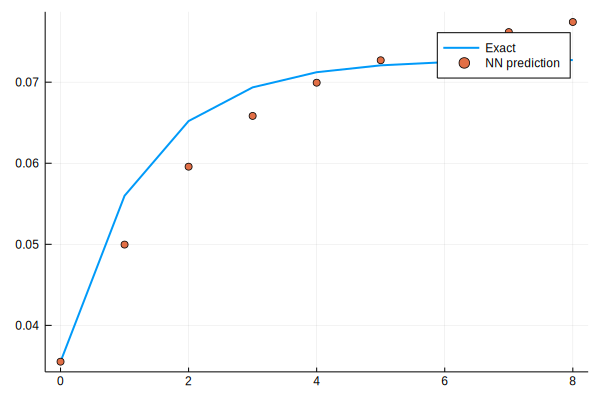

loss: 0.000503:  60%|████████████████████████▍                |  ETA: 0:00:12

0.00049374526f0

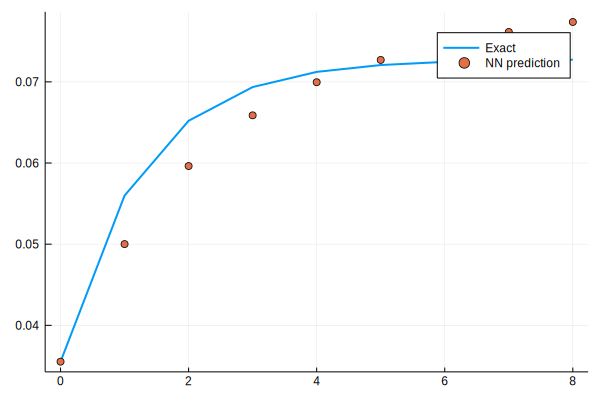

loss: 0.000494:  60%|████████████████████████▋                |  ETA: 0:00:11

0.00048443783f0

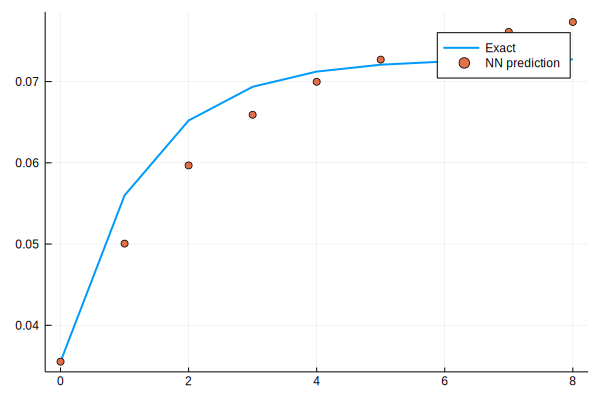

loss: 0.000484:  60%|████████████████████████▊                |  ETA: 0:00:11

0.00047531954f0

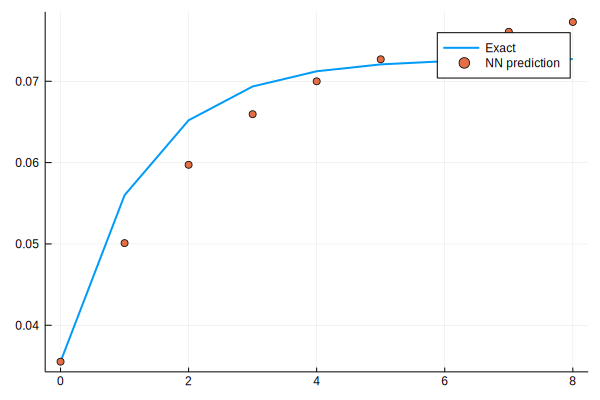

loss: 0.000475:  61%|████████████████████████▉                |  ETA: 0:00:11

0.00046638097f0

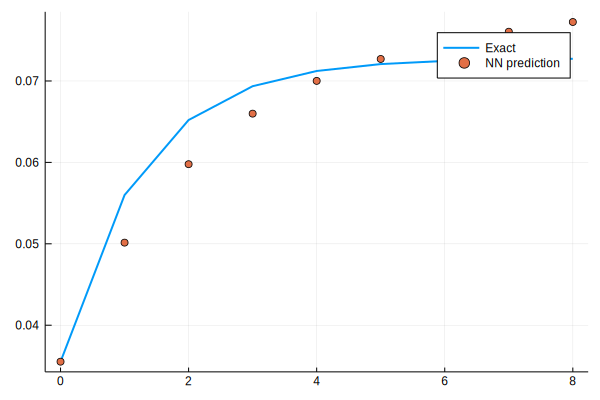

loss: 0.000466:  61%|█████████████████████████                |  ETA: 0:00:11

0.000457621f0

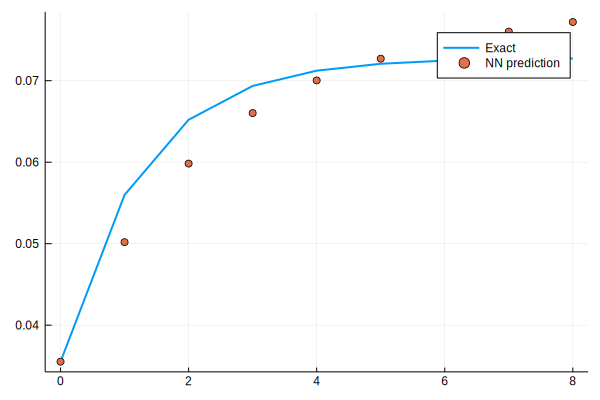

0.00044903503f0

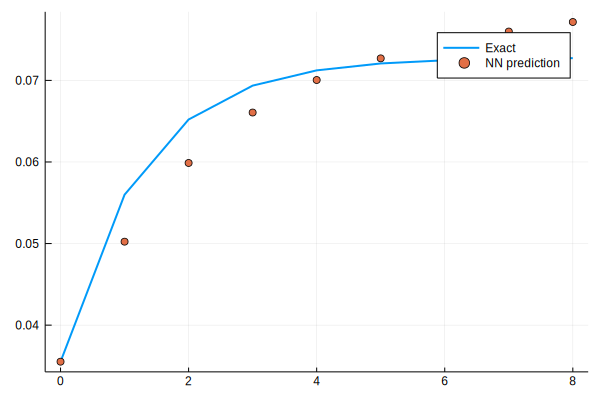

loss: 0.000449:  62%|█████████████████████████▎               |  ETA: 0:00:11

0.00044062064f0

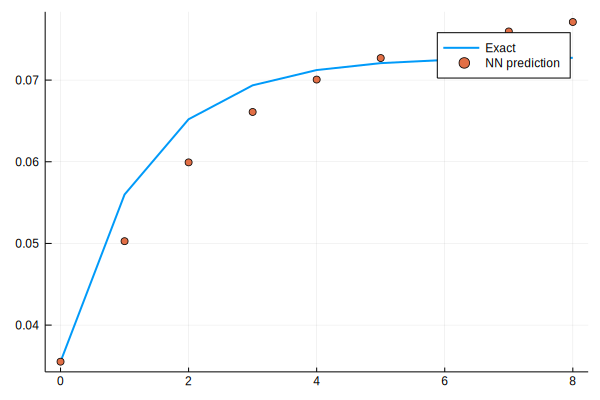

loss: 0.000441:  62%|█████████████████████████▍               |  ETA: 0:00:11

0.00043237433f0

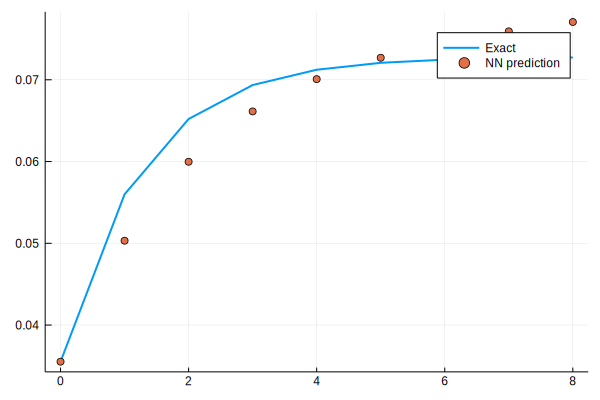

loss: 0.000432:  62%|█████████████████████████▌               |  ETA: 0:00:11

0.0004242896f0

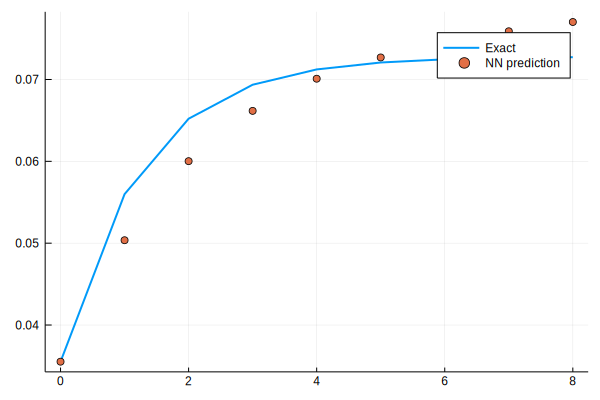

loss: 0.000424:  63%|█████████████████████████▋               |  ETA: 0:00:11

0.00041636568f0

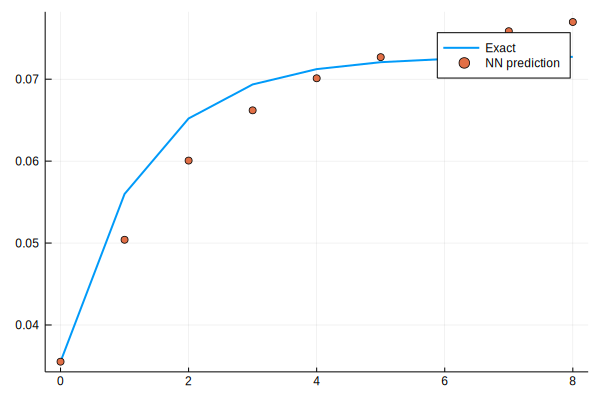

loss: 0.000416:  63%|█████████████████████████▉               |  ETA: 0:00:11

0.00040859982f0

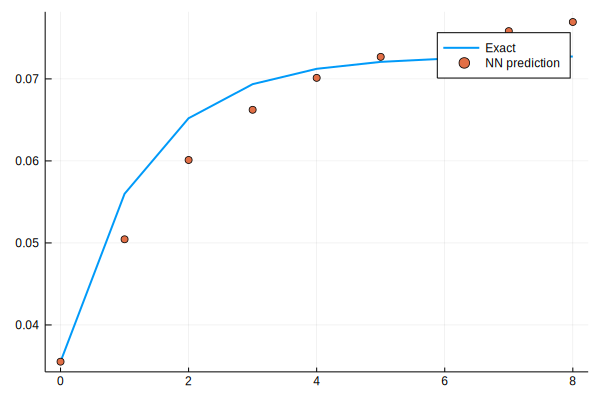

0.0004009865f0

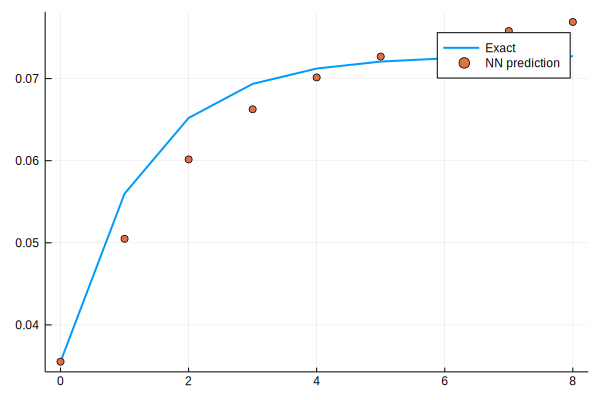

loss: 0.000401:  64%|██████████████████████████▏              |  ETA: 0:00:11

0.00039352567f0

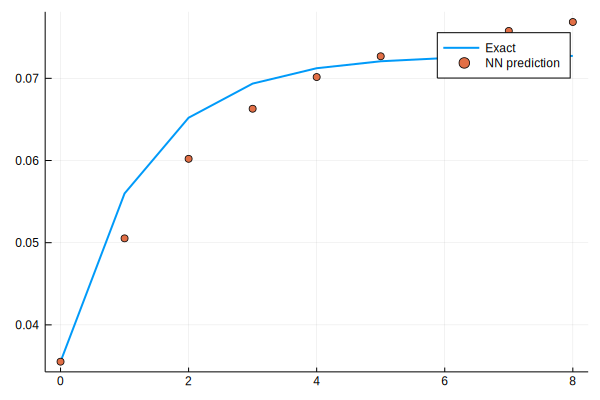

loss: 0.000394:  64%|██████████████████████████▎              |  ETA: 0:00:10

0.00038620742f0

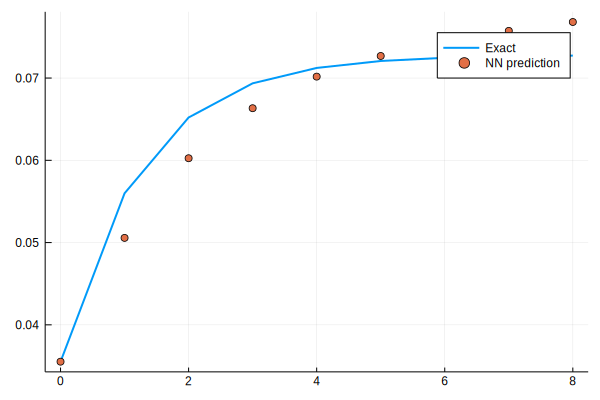

loss: 0.000386:  64%|██████████████████████████▍              |  ETA: 0:00:10

0.0003790396f0

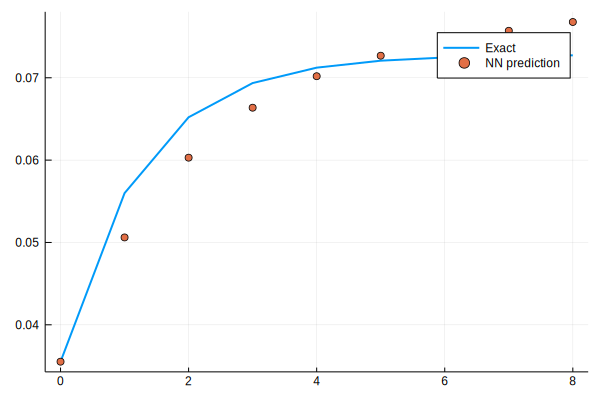

loss: 0.000379:  65%|██████████████████████████▌              |  ETA: 0:00:10

0.00037201014f0

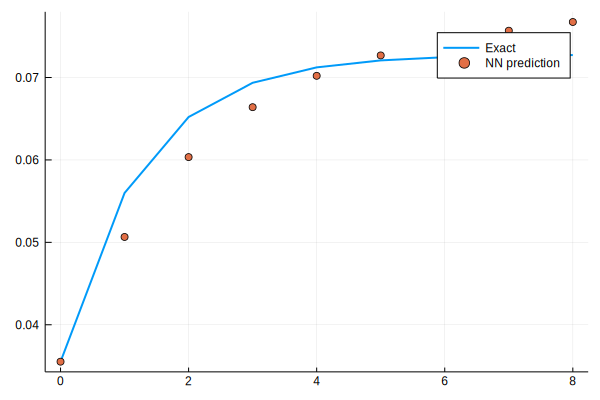

loss: 0.000372:  65%|██████████████████████████▋              |  ETA: 0:00:10

0.0003651185f0

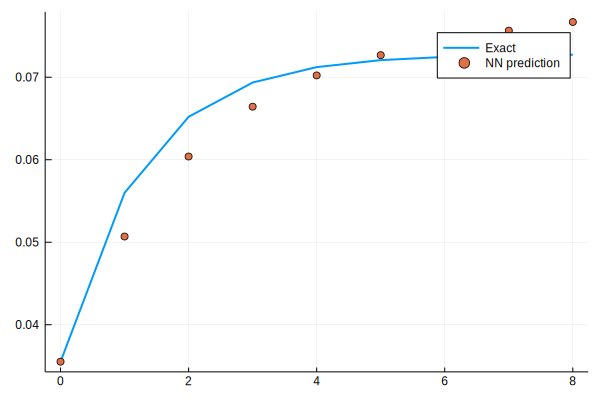

0.0003583632f0

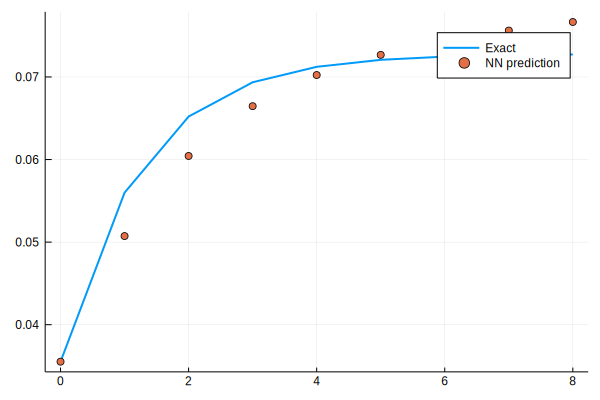

loss: 0.000358:  66%|██████████████████████████▉              |  ETA: 0:00:10

0.00035174016f0

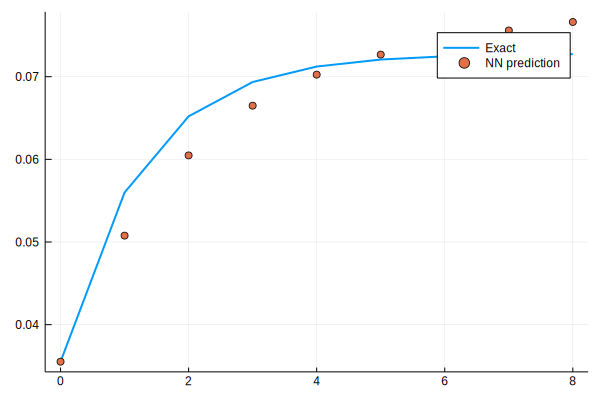

loss: 0.000352:  66%|███████████████████████████              |  ETA: 0:00:10

0.00034524672f0

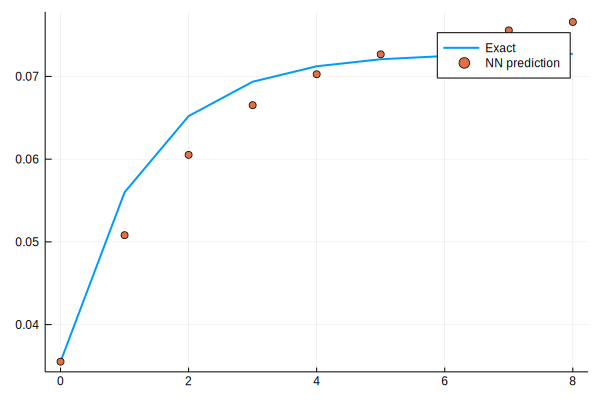

loss: 0.000345:  66%|███████████████████████████▏             |  ETA: 0:00:10

0.00033888055f0

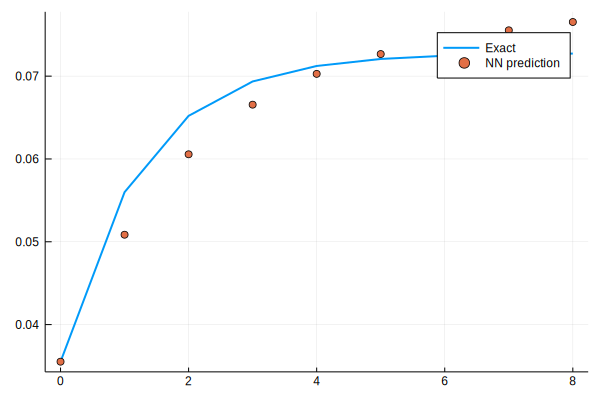

loss: 0.000339:  67%|███████████████████████████▎             |  ETA: 0:00:10

0.00033263903f0

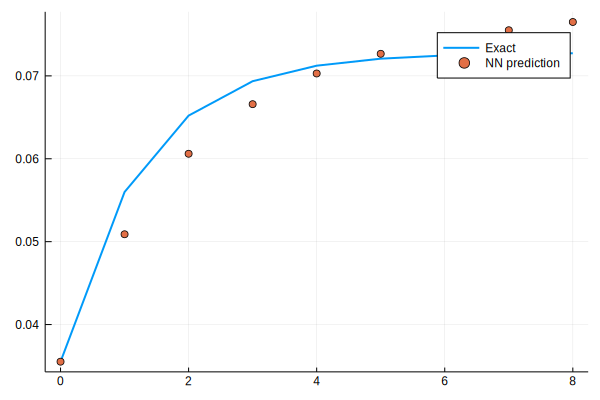

loss: 0.000333:  67%|███████████████████████████▌             |  ETA: 0:00:10

0.00032651934f0

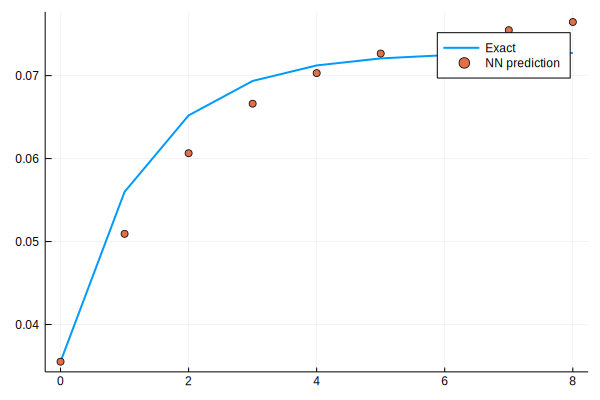

loss: 0.000327:  67%|███████████████████████████▋             |  ETA: 0:00:10

0.00032051915f0

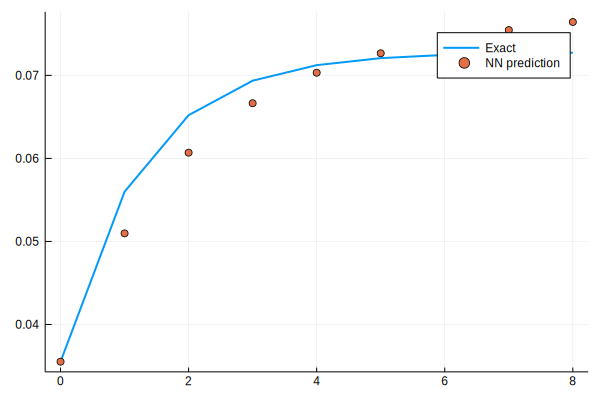

0.00031463482f0

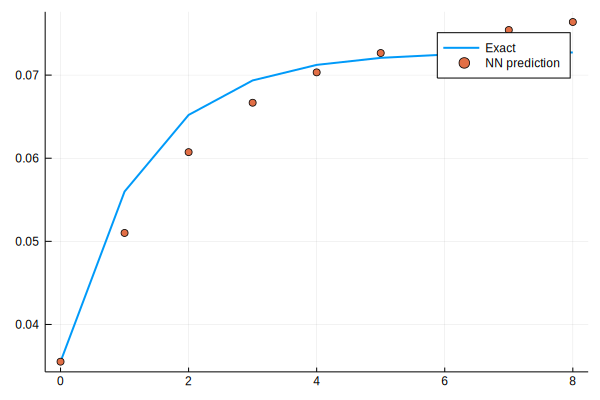

loss: 0.000315:  68%|███████████████████████████▉             |  ETA: 0:00:09

0.0003088657f0

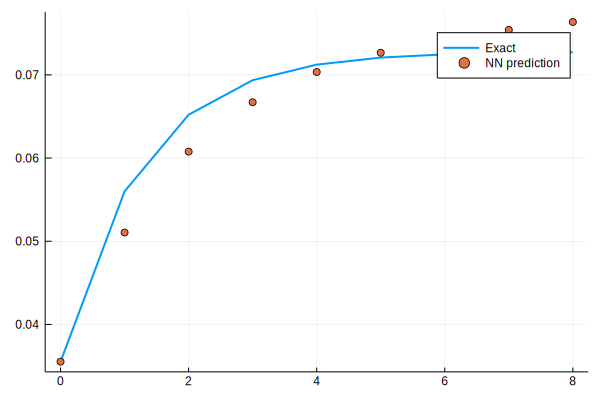

loss: 0.000309:  68%|████████████████████████████             |  ETA: 0:00:09

0.0003032102f0

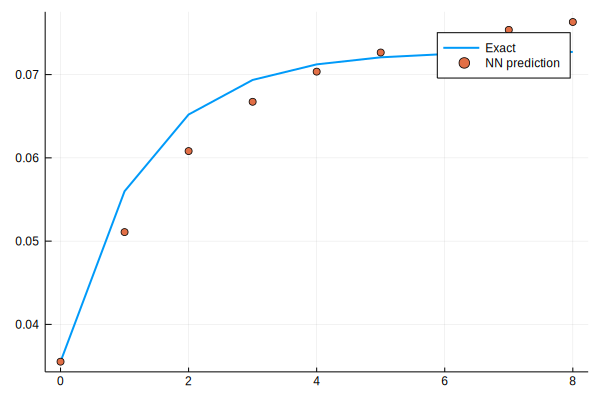

loss: 0.000303:  69%|████████████████████████████▏            |  ETA: 0:00:09

0.00029766263f0

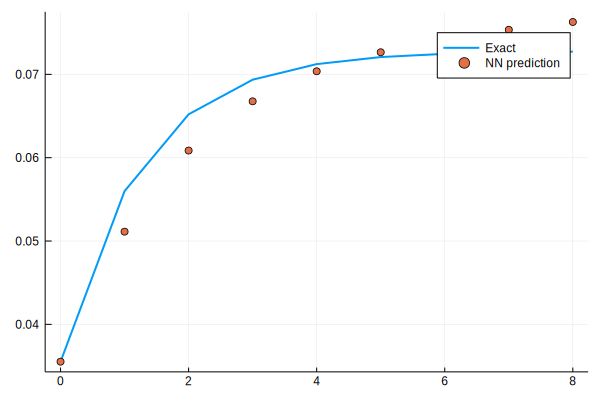

loss: 0.000298:  69%|████████████████████████████▎            |  ETA: 0:00:09

0.00029222257f0

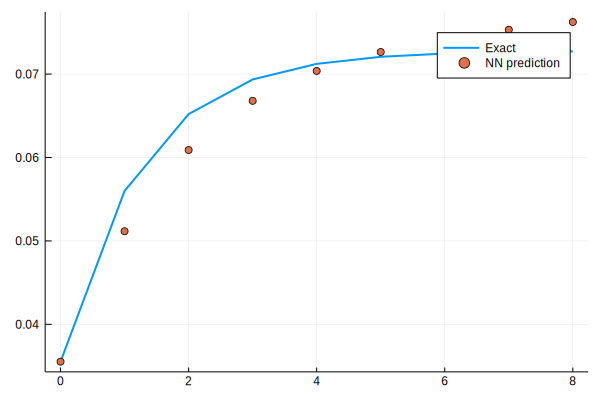

loss: 0.000292:  69%|████████████████████████████▍            |  ETA: 0:00:09

0.00028688906f0

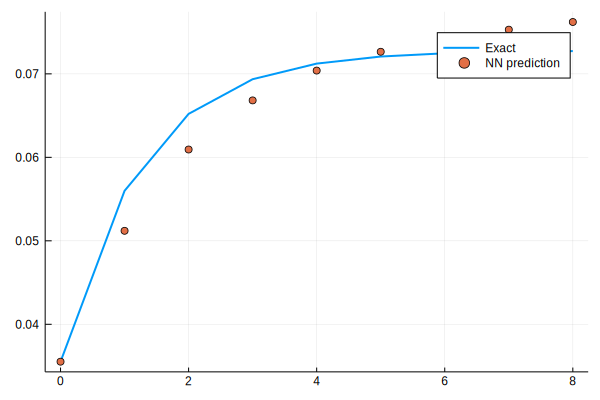

loss: 0.000287:  70%|████████████████████████████▌            |  ETA: 0:00:09

0.00028165814f0

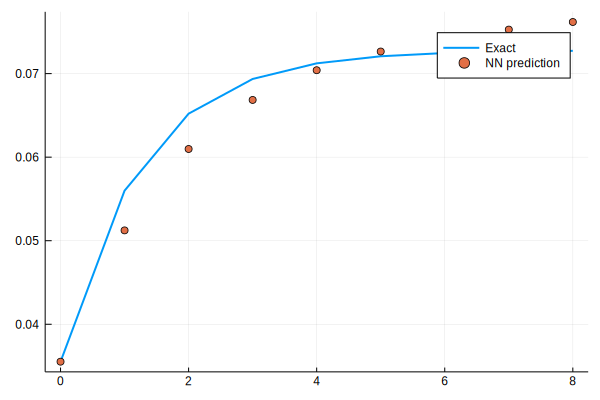

loss: 0.000282:  70%|████████████████████████████▊            |  ETA: 0:00:09

0.00027652847f0

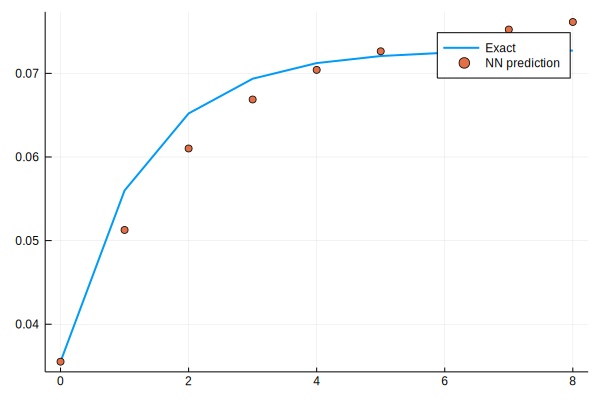

loss: 0.000277:  70%|████████████████████████████▉            |  ETA: 0:00:09

0.00027149683f0

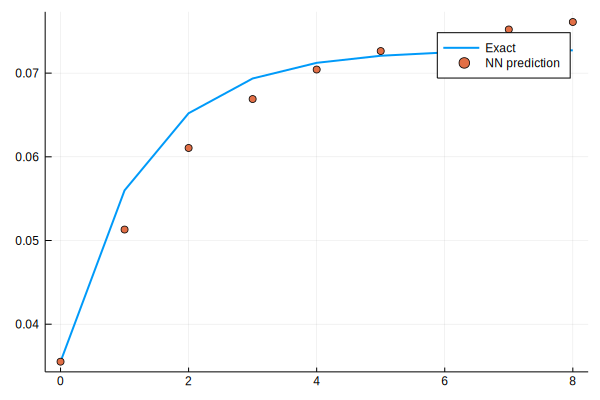

loss: 0.000271:  71%|█████████████████████████████            |  ETA: 0:00:09

0.0002665633f0

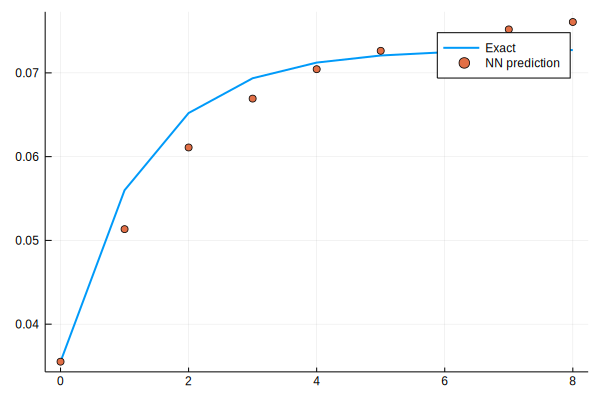

loss: 0.000267:  71%|█████████████████████████████▏           |  ETA: 0:00:08

0.0002617248f0

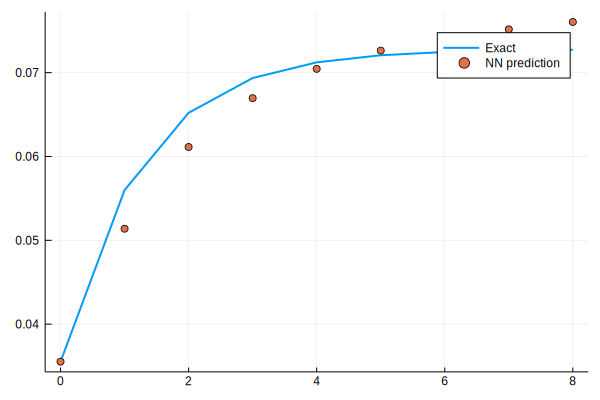

loss: 0.000262:  71%|█████████████████████████████▎           |  ETA: 0:00:08

0.00025697946f0

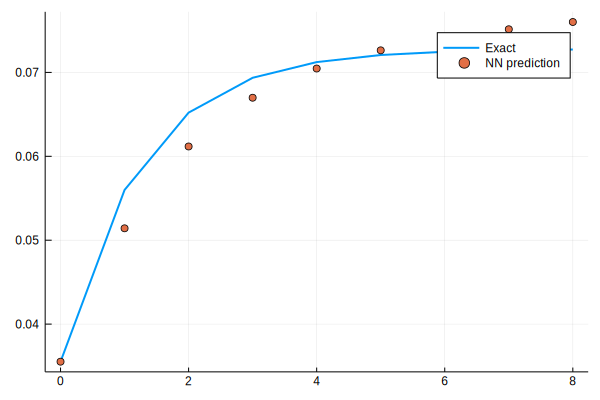

0.00025232398f0

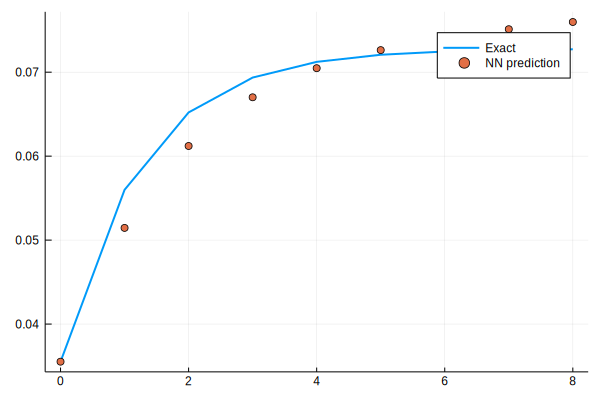

loss: 0.000252:  72%|█████████████████████████████▌           |  ETA: 0:00:08

0.00024775756f0

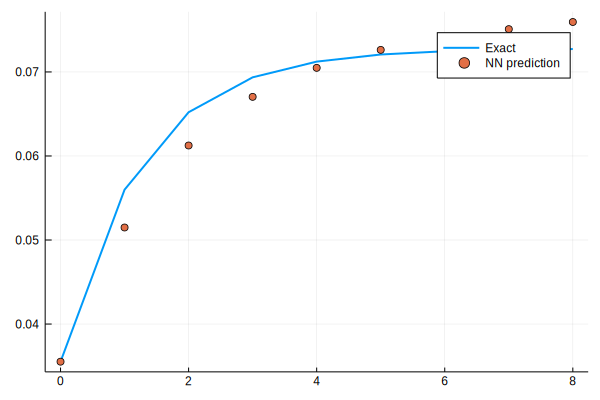

loss: 0.000248:  72%|█████████████████████████████▋           |  ETA: 0:00:08

0.00024328f0

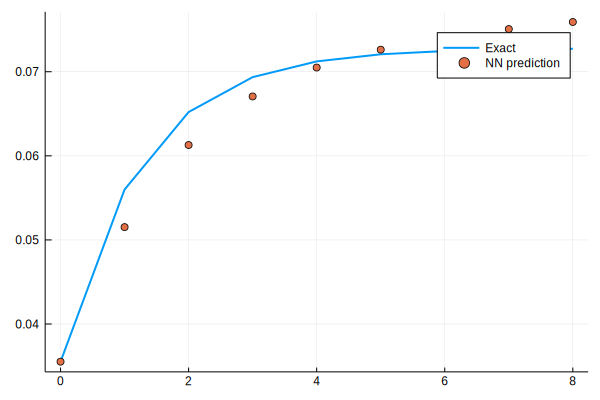

loss: 0.000243:  73%|█████████████████████████████▊           |  ETA: 0:00:08

0.00023888914f0

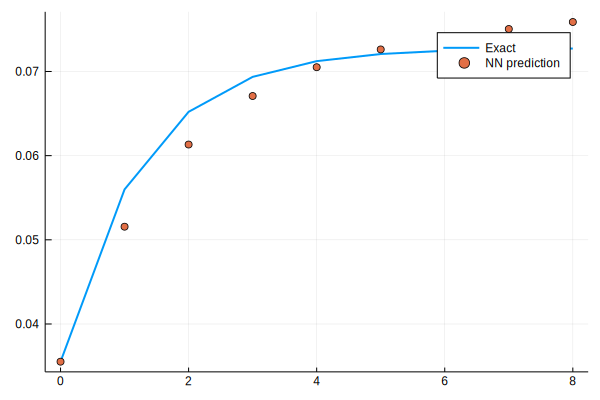

loss: 0.000239:  73%|█████████████████████████████▉           |  ETA: 0:00:08

0.00023458517f0

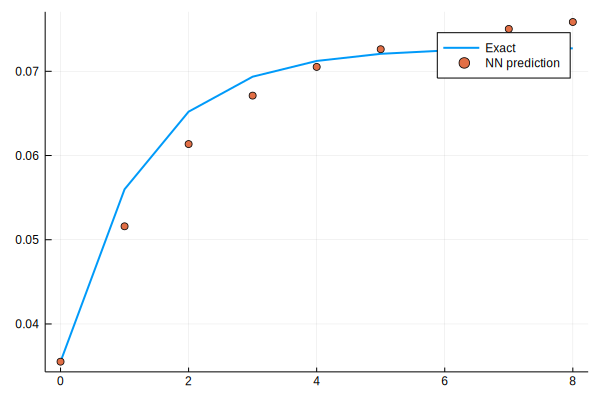

loss: 0.000235:  73%|██████████████████████████████           |  ETA: 0:00:08

0.0002303701f0

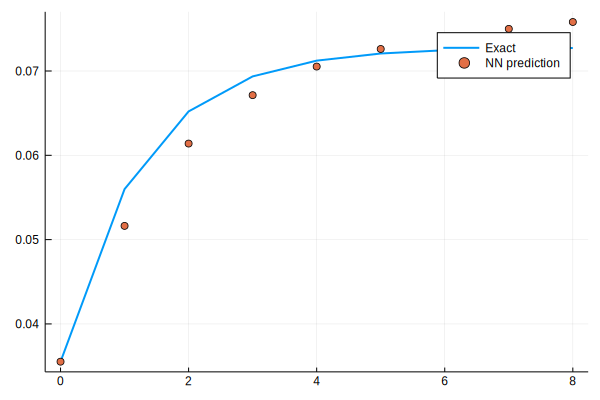

loss: 0.00023:  74%|██████████████████████████████▏          |  ETA: 0:00:08

0.00022625865f0

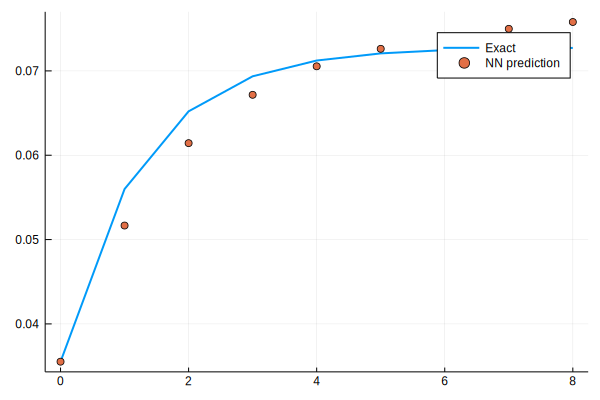

0.00022228967f0

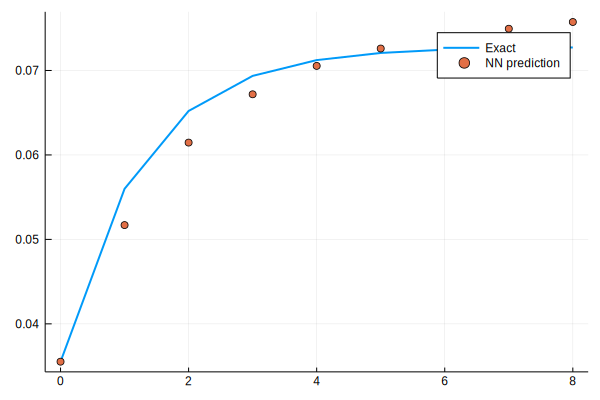

loss: 0.000222:  74%|██████████████████████████████▌          |  ETA: 0:00:08

0.00021858251f0

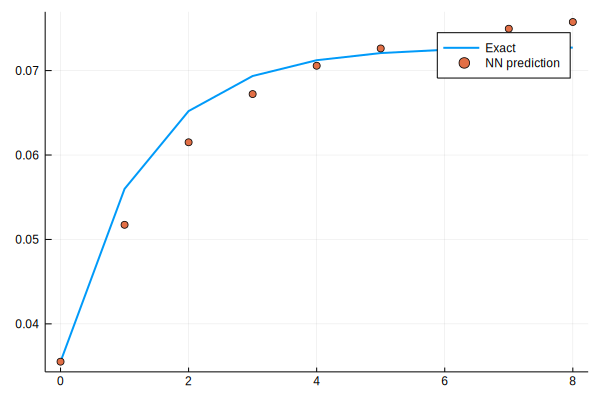

loss: 0.000219:  75%|██████████████████████████████▋          |  ETA: 0:00:07

0.00021549416f0

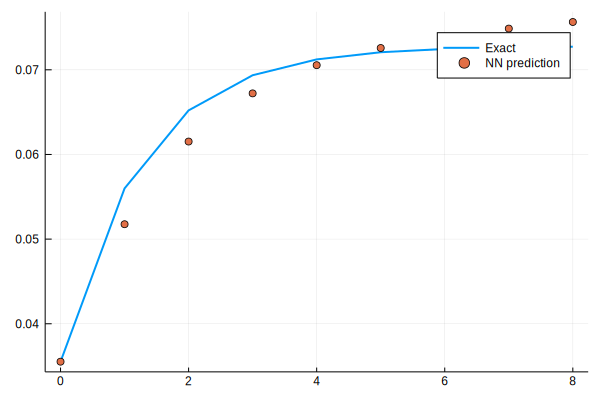

loss: 0.000215:  75%|██████████████████████████████▊          |  ETA: 0:00:07

0.00021408344f0

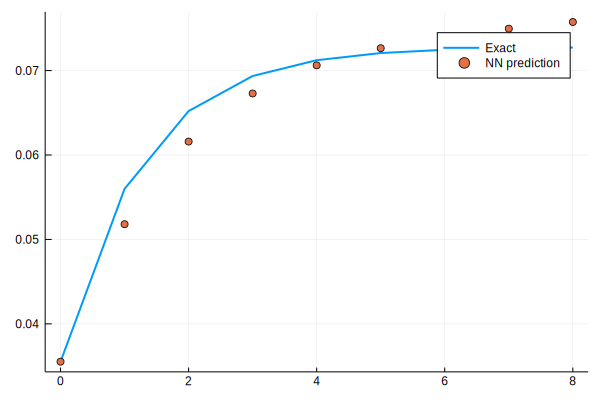

loss: 0.000214:  75%|██████████████████████████████▉          |  ETA: 0:00:07

0.00021747213f0

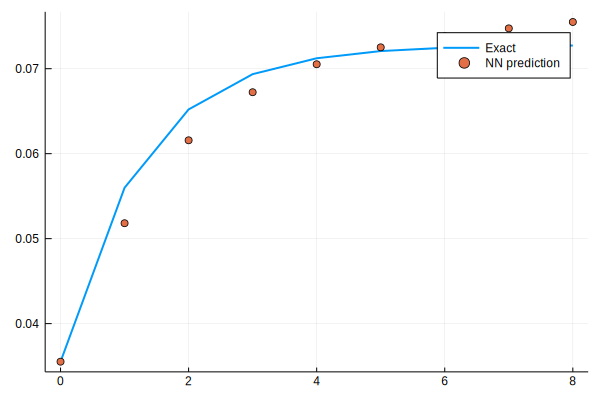

loss: 0.000217:  76%|███████████████████████████████          |  ETA: 0:00:07

0.00023373736f0

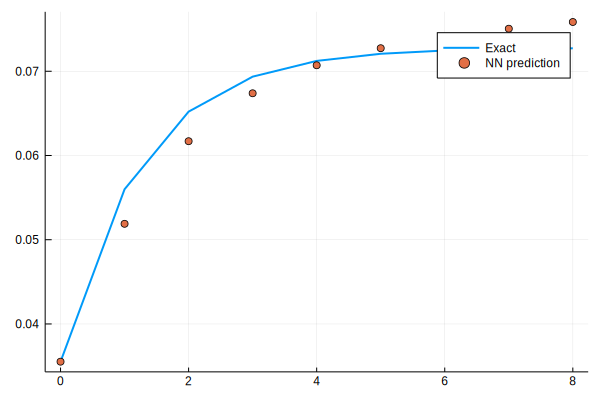

0.00028076f0

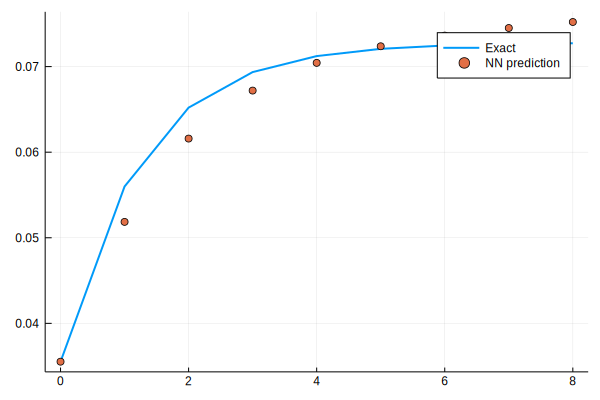

loss: 0.000281:  76%|███████████████████████████████▎         |  ETA: 0:00:07

0.00037560888f0

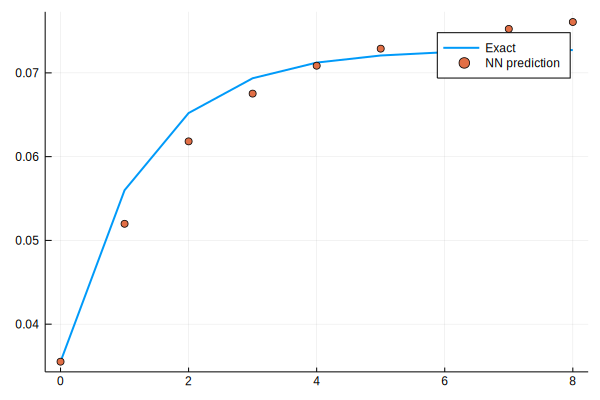

loss: 0.000376:  77%|███████████████████████████████▍         |  ETA: 0:00:07

0.0005275235f0

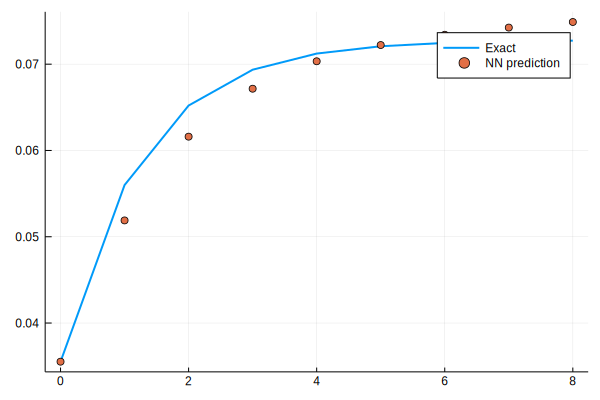

loss: 0.000528:  77%|███████████████████████████████▋         |  ETA: 0:00:07

0.00063285924f0

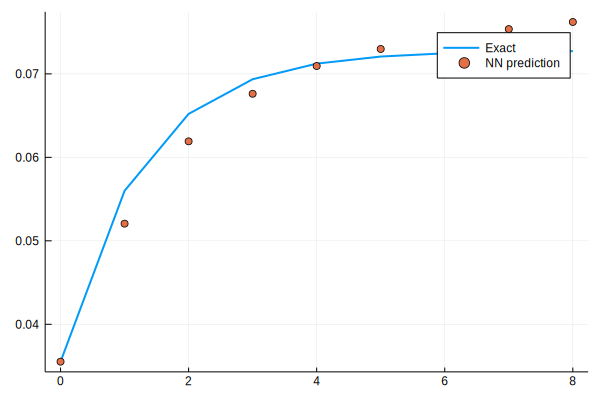

0.0006208104f0

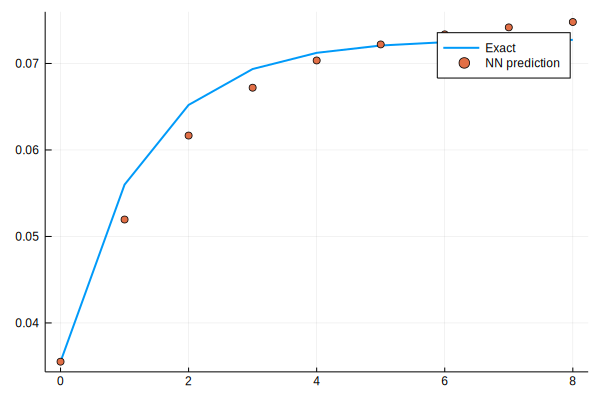

loss: 0.000621:  78%|███████████████████████████████▉         |  ETA: 0:00:07

0.00038984846f0

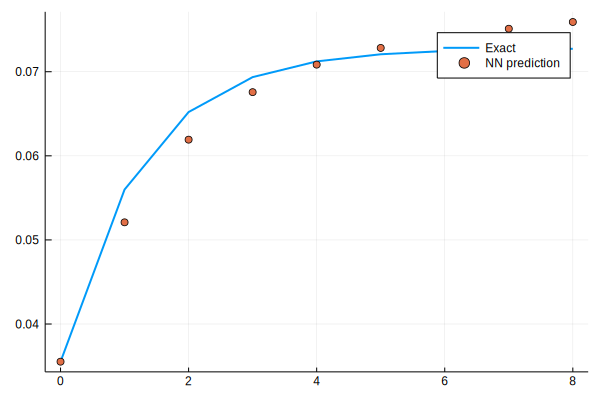

loss: 0.00039:  78%|████████████████████████████████         |  ETA: 0:00:06

0.00019994956f0

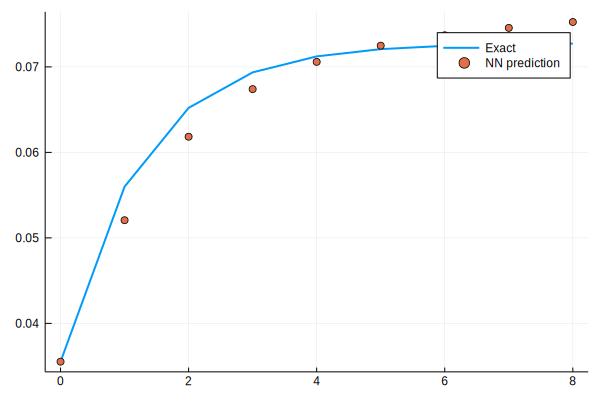

loss: 0.0002:  78%|████████████████████████████████▏        |  ETA: 0:00:06

0.00021779015f0

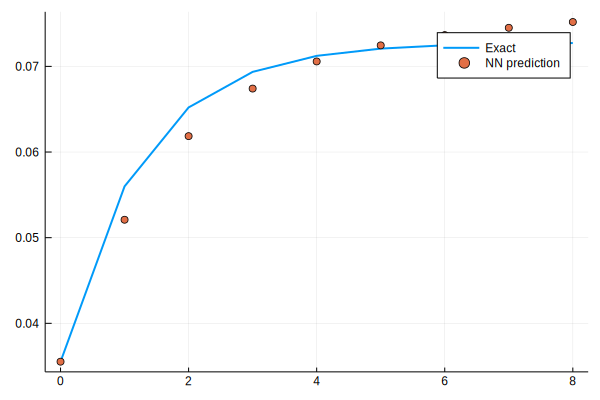

loss: 0.000218:  79%|████████████████████████████████▎        |  ETA: 0:00:06

0.00035464455f0

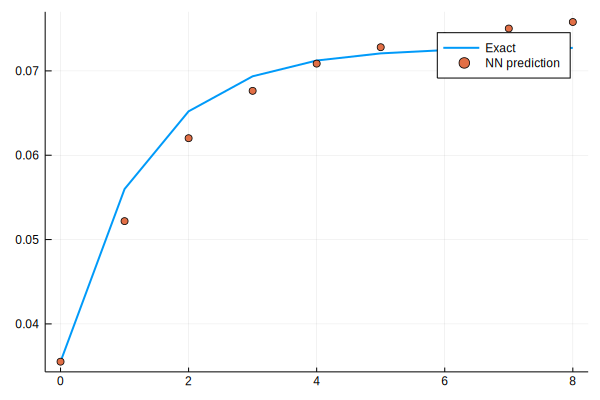

loss: 0.000355:  79%|████████████████████████████████▍        |  ETA: 0:00:06

0.00039284266f0

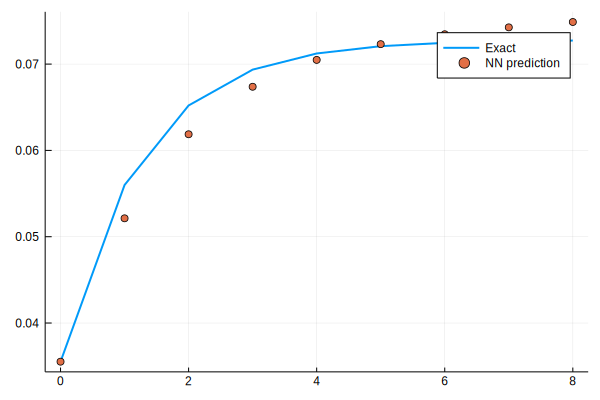

loss: 0.000393:  79%|████████████████████████████████▌        |  ETA: 0:00:06

0.00025739006f0

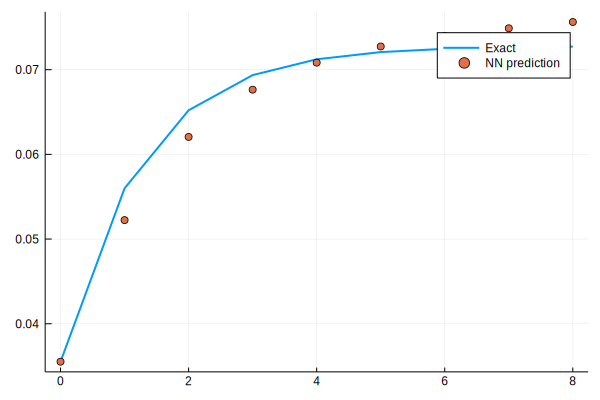

loss: 0.000257:  80%|████████████████████████████████▋        |  ETA: 0:00:06

0.00016532144f0

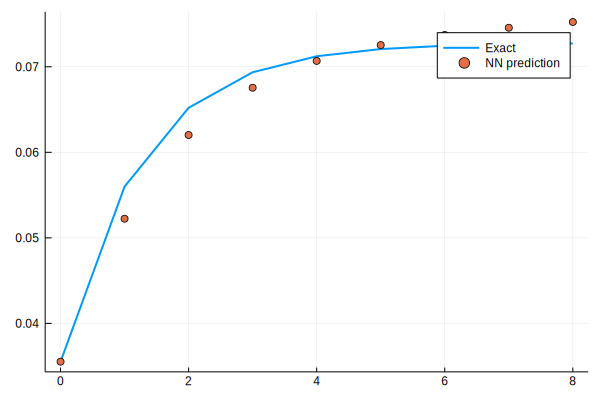

loss: 0.000165:  80%|████████████████████████████████▊        |  ETA: 0:00:06

0.00022355614f0

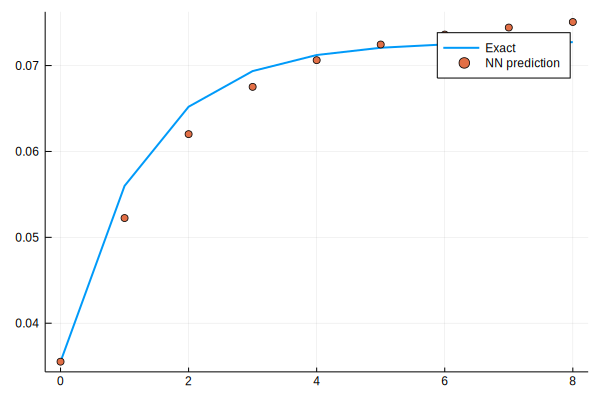

loss: 0.000224:  80%|████████████████████████████████▉        |  ETA: 0:00:06

0.0002890276f0

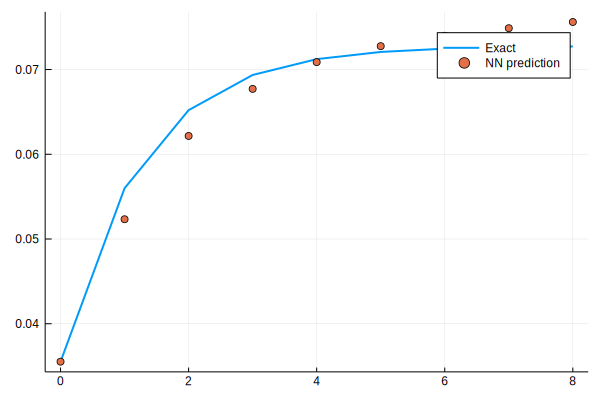

loss: 0.000289:  81%|█████████████████████████████████        |  ETA: 0:00:06

0.00024184347f0

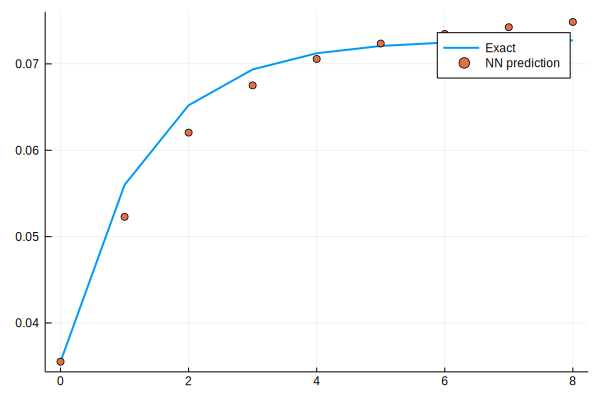

loss: 0.000242:  81%|█████████████████████████████████▎       |  ETA: 0:00:06

0.0001605469f0

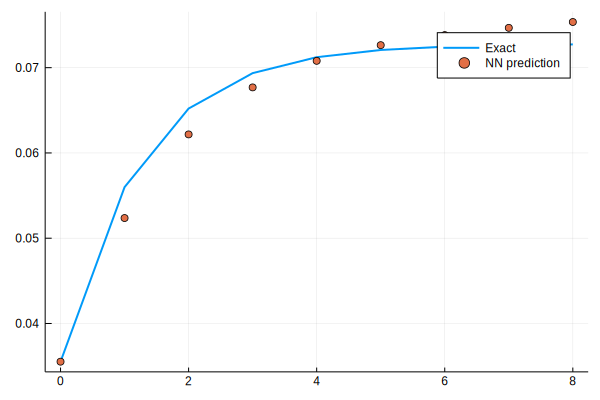

loss: 0.000161:  81%|█████████████████████████████████▍       |  ETA: 0:00:06

0.00017540823f0

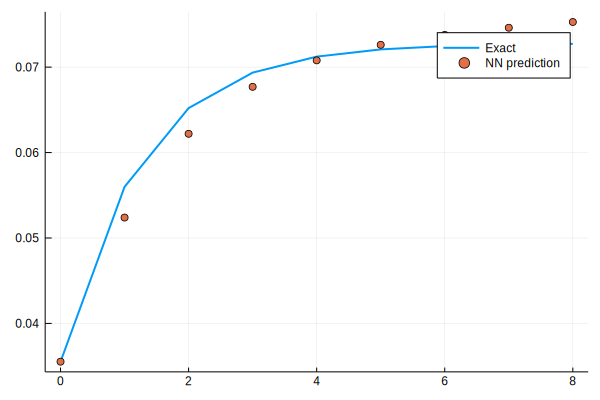

loss: 0.000175:  82%|█████████████████████████████████▌       |  ETA: 0:00:05

0.00022862692f0

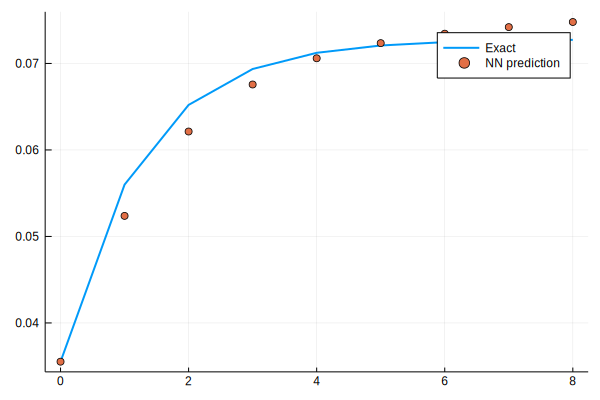

loss: 0.000229:  82%|█████████████████████████████████▋       |  ETA: 0:00:05

0.0002049655f0

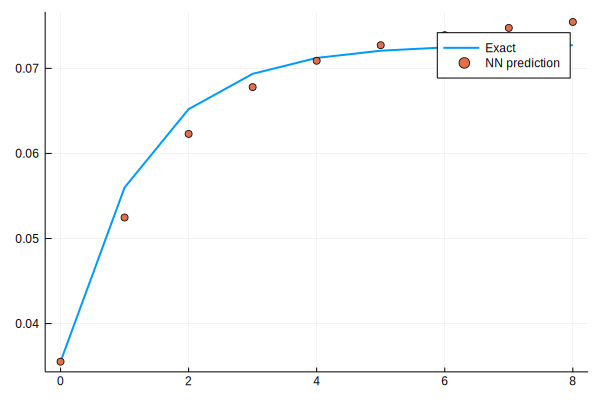

loss: 0.000205:  82%|█████████████████████████████████▊       |  ETA: 0:00:05

0.00014997857f0

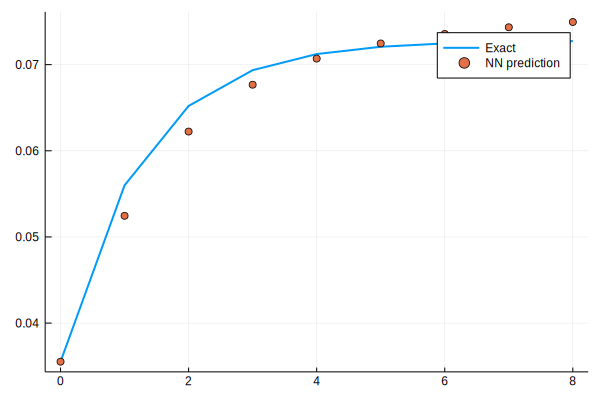

loss: 0.00015:  83%|█████████████████████████████████▉       |  ETA: 0:00:05

0.00015428738f0

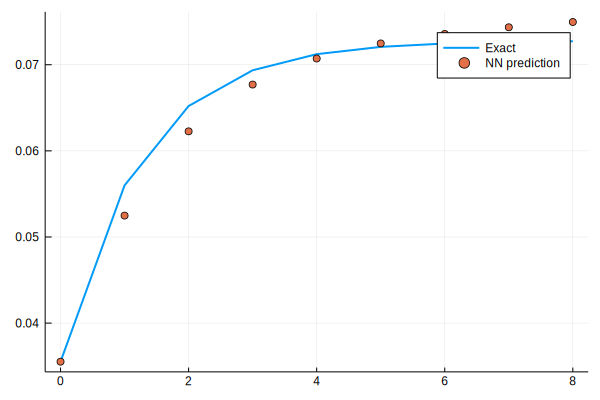

loss: 0.000154:  83%|██████████████████████████████████       |  ETA: 0:00:05

0.00018731605f0

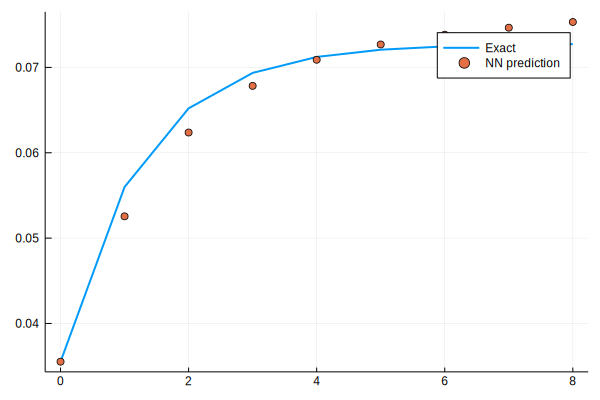

loss: 0.000187:  83%|██████████████████████████████████▏      |  ETA: 0:00:05

0.00017469922f0

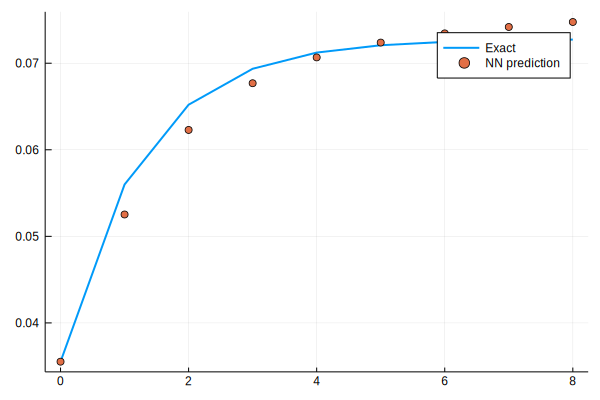

loss: 0.000175:  84%|██████████████████████████████████▎      |  ETA: 0:00:05

0.00013824056f0

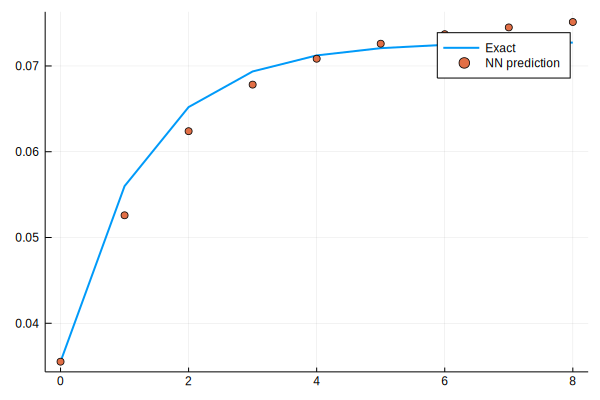

loss: 0.000138:  84%|██████████████████████████████████▌      |  ETA: 0:00:05

0.00014089698f0

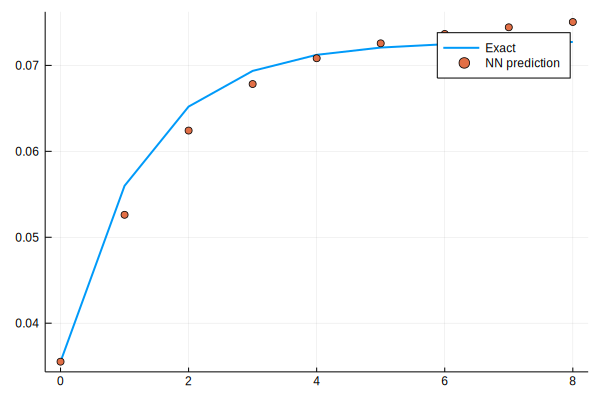

loss: 0.000141:  84%|██████████████████████████████████▋      |  ETA: 0:00:05

0.00016152793f0

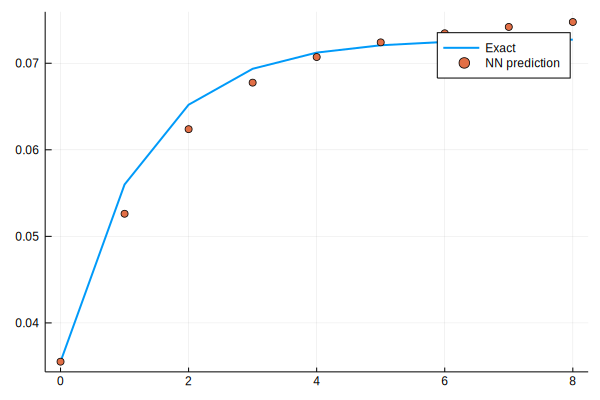

loss: 0.000162:  85%|██████████████████████████████████▋      |  ETA: 0:00:05

0.00015033706f0

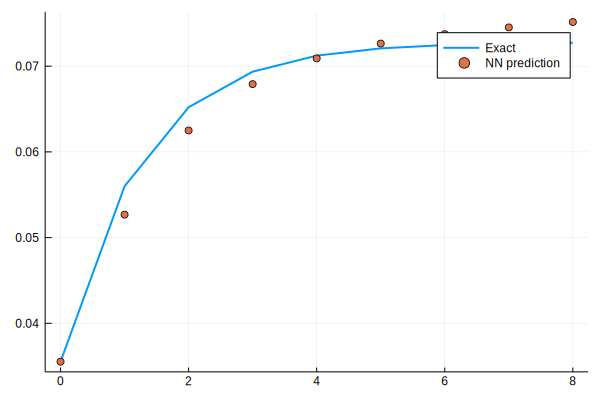

loss: 0.00015:  85%|██████████████████████████████████▉      |  ETA: 0:00:04

0.00012740595f0

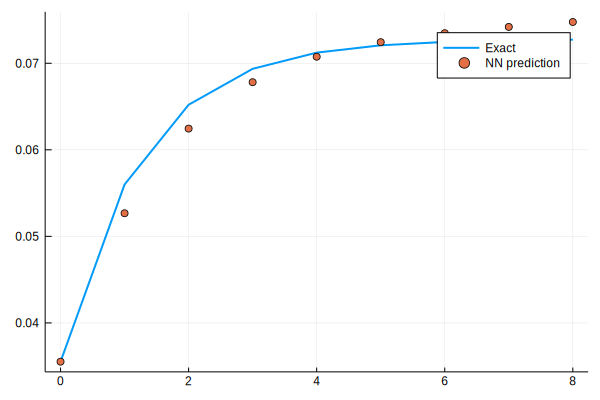

loss: 0.000127:  85%|███████████████████████████████████      |  ETA: 0:00:04

0.00012995358f0

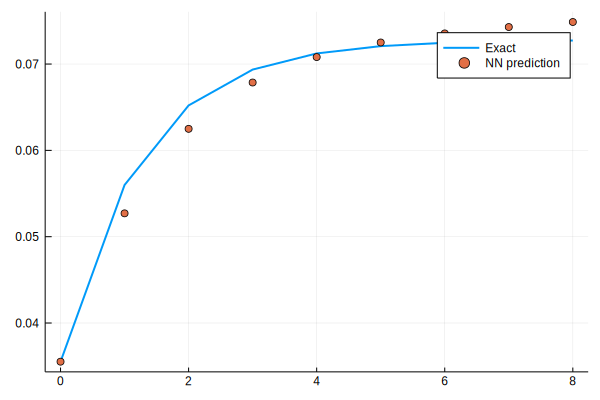

loss: 0.00013:  86%|███████████████████████████████████▏     |  ETA: 0:00:04

0.00014127183f0

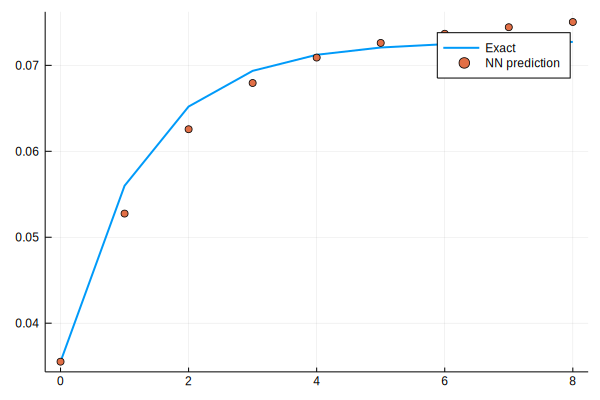

loss: 0.000141:  86%|███████████████████████████████████▎     |  ETA: 0:00:04

0.00013272949f0

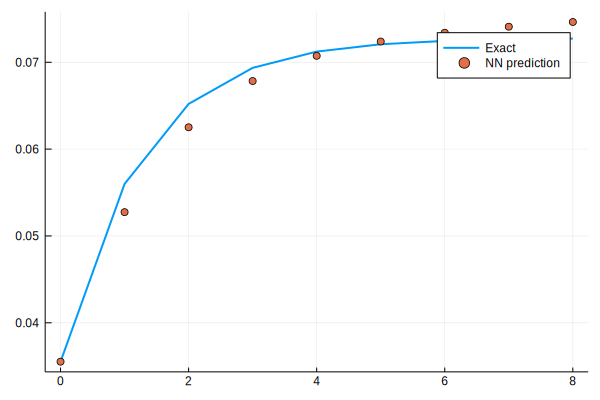

loss: 0.000133:  86%|███████████████████████████████████▍     |  ETA: 0:00:04

0.000118005555f0

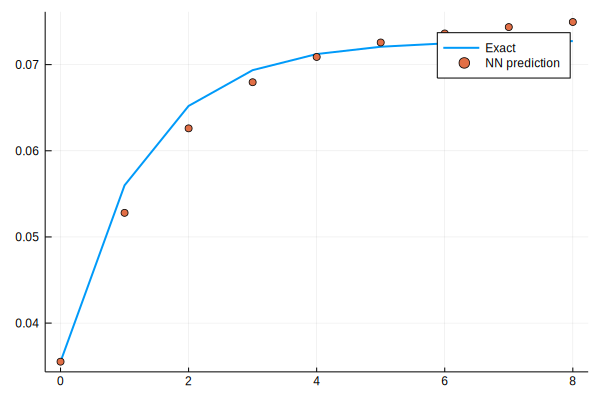

loss: 0.000118:  87%|███████████████████████████████████▌     |  ETA: 0:00:04

0.00011995937f0

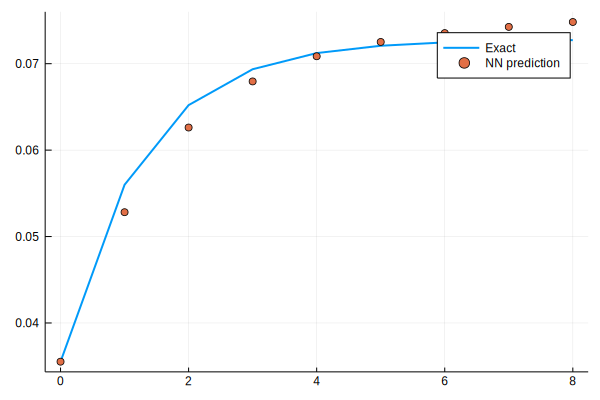

loss: 0.00012:  87%|███████████████████████████████████▋     |  ETA: 0:00:04

0.0001262356f0

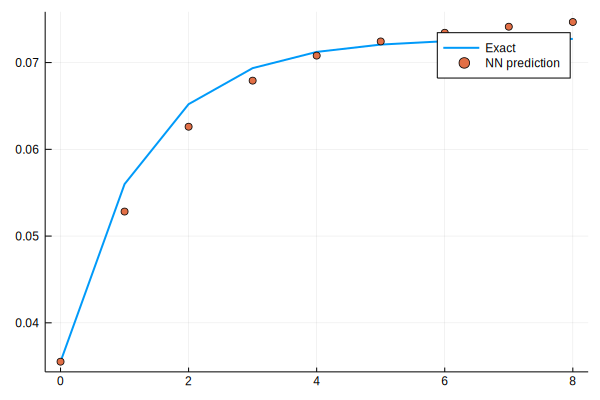

loss: 0.000126:  87%|███████████████████████████████████▊     |  ETA: 0:00:04

0.00011917448f0

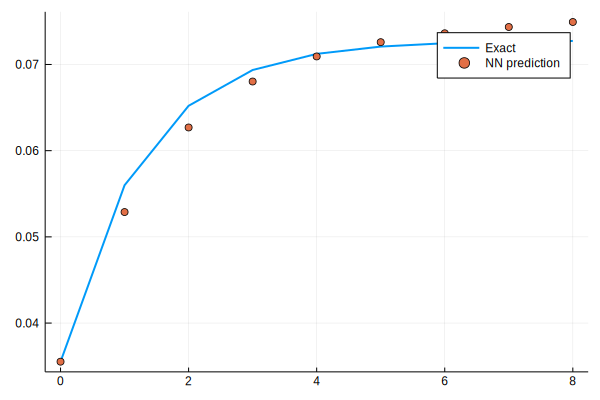

loss: 0.000119:  88%|███████████████████████████████████▉     |  ETA: 0:00:04

0.00010957096f0

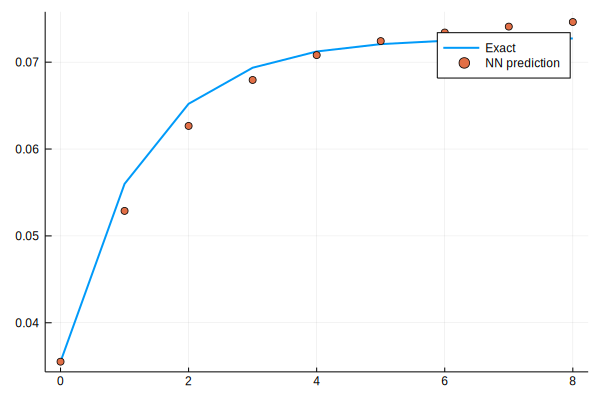

loss: 0.00011:  88%|████████████████████████████████████▏    |  ETA: 0:00:04

0.00011059541f0

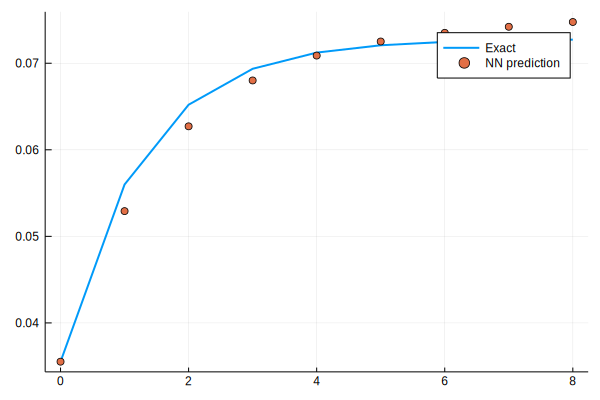

loss: 0.000111:  88%|████████████████████████████████████▎    |  ETA: 0:00:03

0.0001138705f0

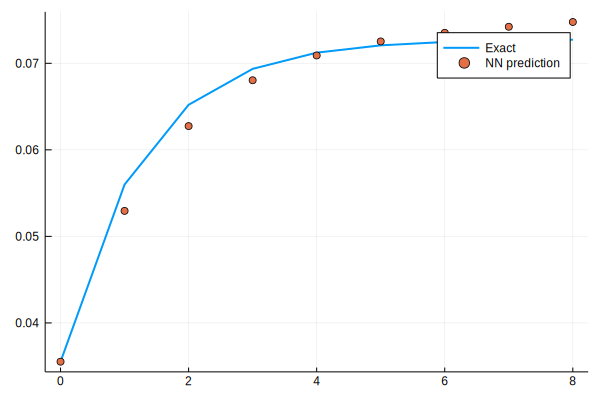

loss: 0.000114:  89%|████████████████████████████████████▍    |  ETA: 0:00:03

0.000108833134f0

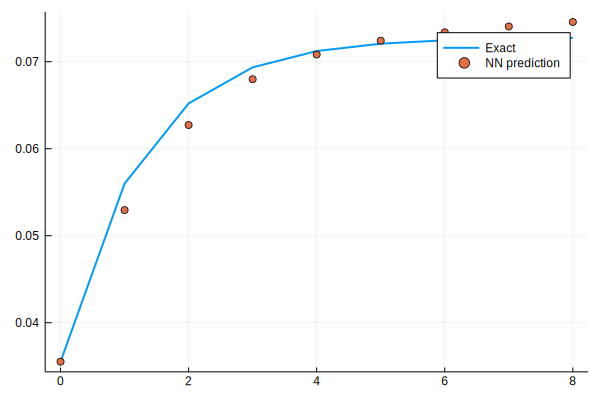

loss: 0.000109:  89%|████████████████████████████████████▌    |  ETA: 0:00:03

0.00010187523f0

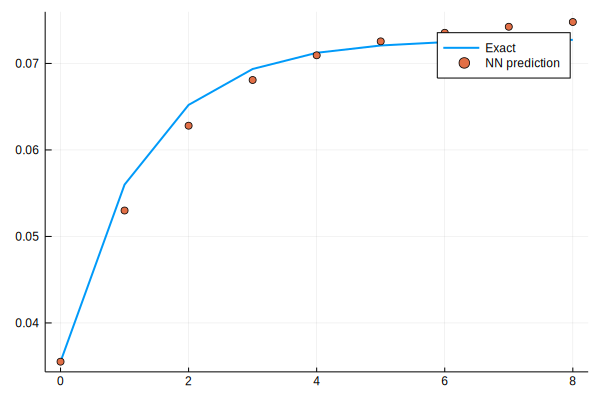

loss: 0.000102:  89%|████████████████████████████████████▋    |  ETA: 0:00:03

0.00010189571f0

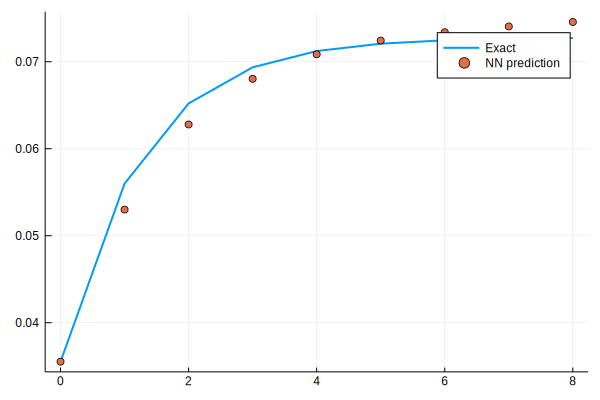

loss: 0.000102:  90%|████████████████████████████████████▊    |  ETA: 0:00:03

0.00010382627f0

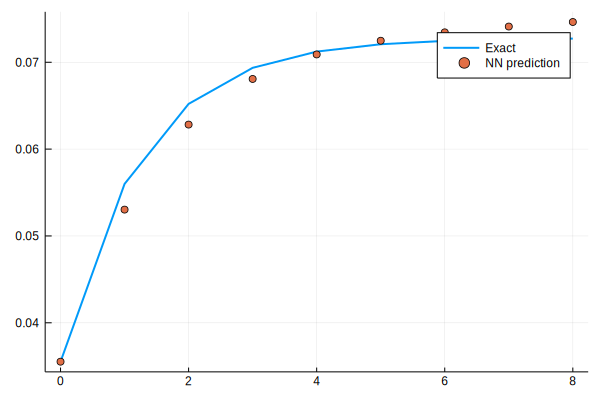

loss: 0.000104:  90%|████████████████████████████████████▉    |  ETA: 0:00:03

0.000100264966f0

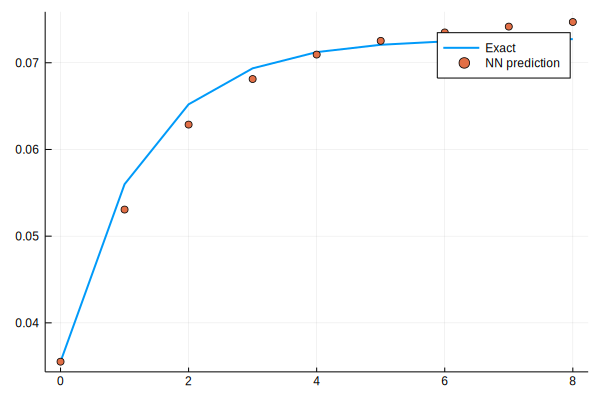

loss: 0.0001:  90%|█████████████████████████████████████    |  ETA: 0:00:03

9.501184f-5

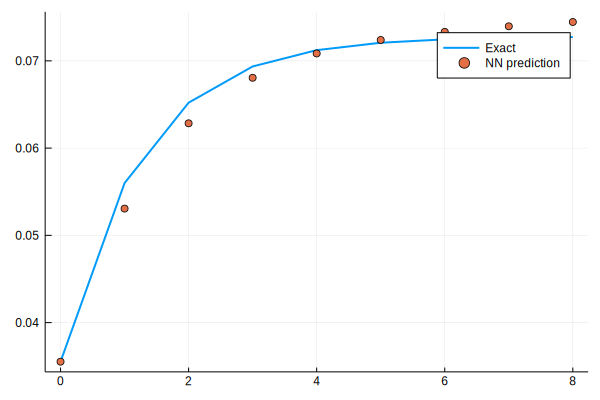

loss: 9.5e-05:  91%|█████████████████████████████████████▏   |  ETA: 0:00:03

9.406506f-5

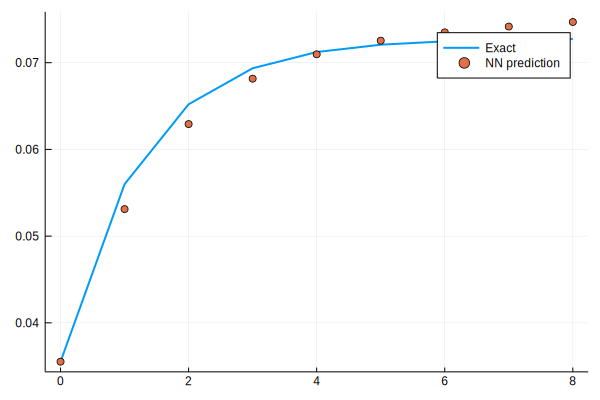

loss: 9.41e-05:  91%|█████████████████████████████████████▎   |  ETA: 0:00:03

9.5011594f-5

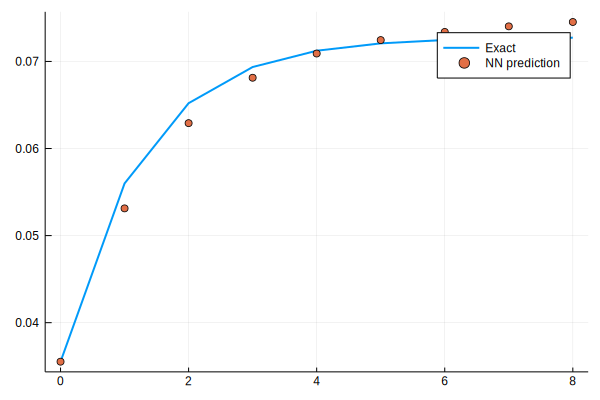

loss: 9.5e-05:  91%|█████████████████████████████████████▍   |  ETA: 0:00:03

9.2869464f-5

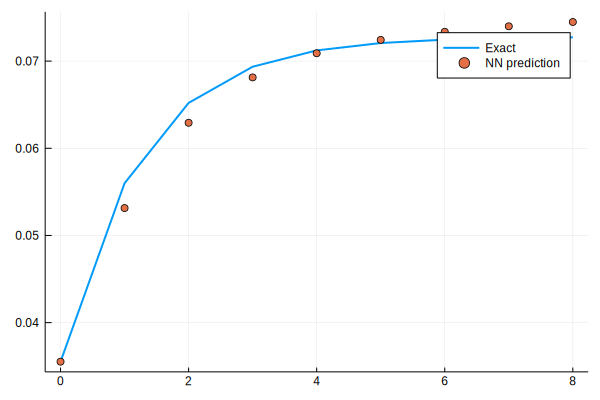

loss: 9.29e-05:  92%|█████████████████████████████████████▌   |  ETA: 0:00:03

8.886529f-5

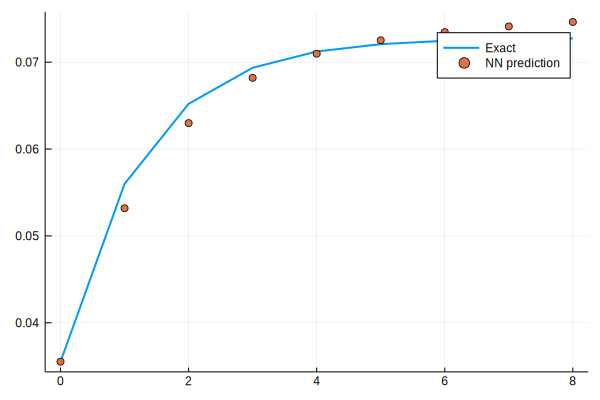

loss: 8.89e-05:  92%|█████████████████████████████████████▊   |  ETA: 0:00:02

8.7167435f-5

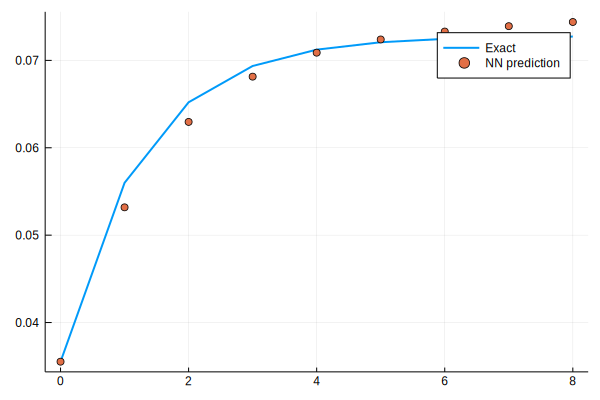

loss: 8.72e-05:  92%|█████████████████████████████████████▉   |  ETA: 0:00:02

8.736508f-5

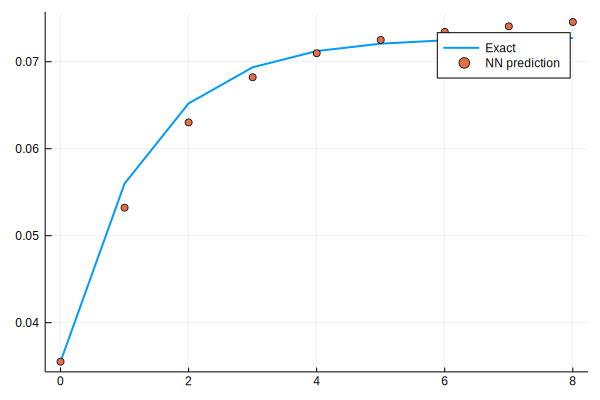

loss: 8.74e-05:  93%|██████████████████████████████████████   |  ETA: 0:00:02

8.607903f-5

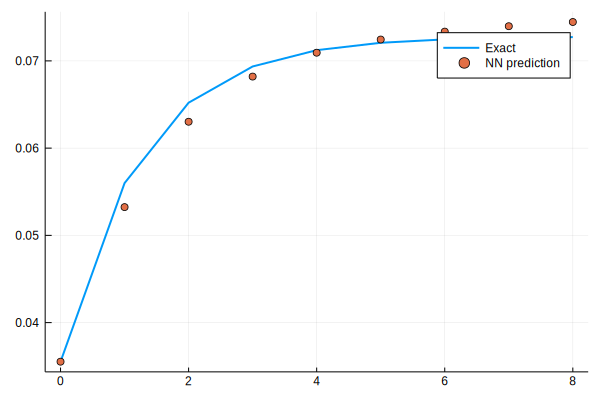

loss: 8.61e-05:  93%|██████████████████████████████████████▏  |  ETA: 0:00:02

8.314727f-5

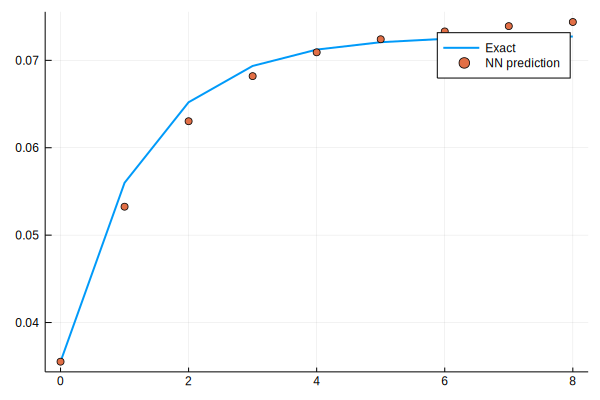

8.1147424f-5

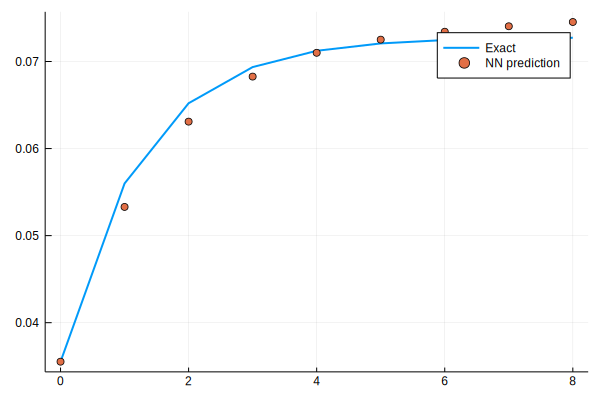

loss: 8.11e-05:  94%|██████████████████████████████████████▍  |  ETA: 0:00:02

8.068685f-5

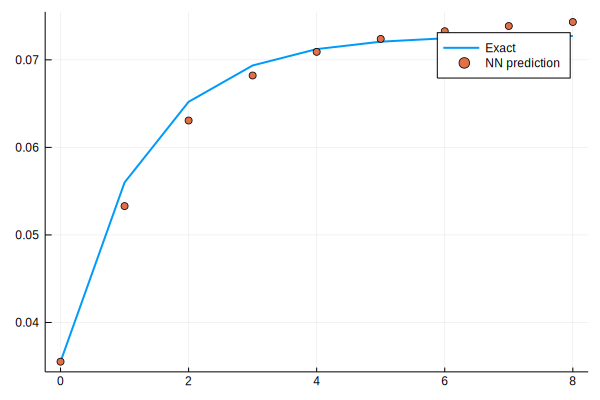

loss: 8.07e-05:  94%|██████████████████████████████████████▌  |  ETA: 0:00:02

7.9862126f-5

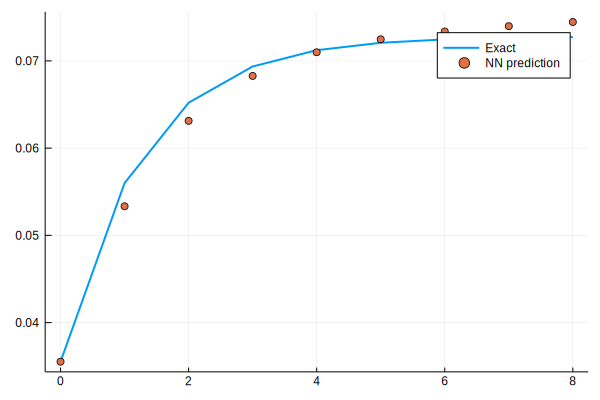

loss: 7.99e-05:  94%|██████████████████████████████████████▋  |  ETA: 0:00:02

7.777394f-5

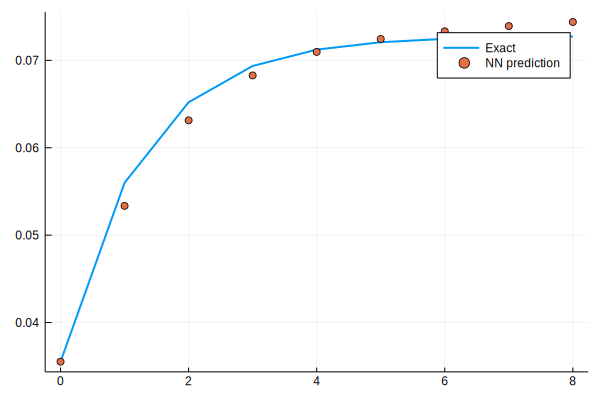

loss: 7.78e-05:  95%|██████████████████████████████████████▊  |  ETA: 0:00:02

7.572617f-5

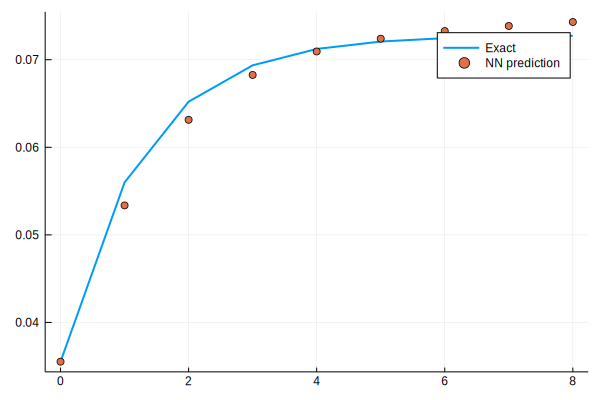

loss: 7.57e-05:  95%|███████████████████████████████████████  |  ETA: 0:00:01

7.476662f-5

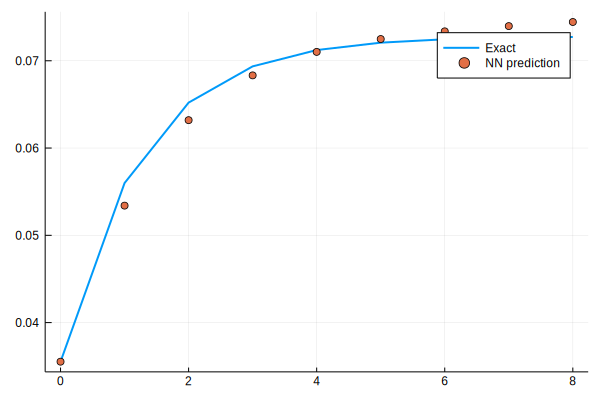

loss: 7.48e-05:  95%|███████████████████████████████████████▏ |  ETA: 0:00:01

7.414573f-5

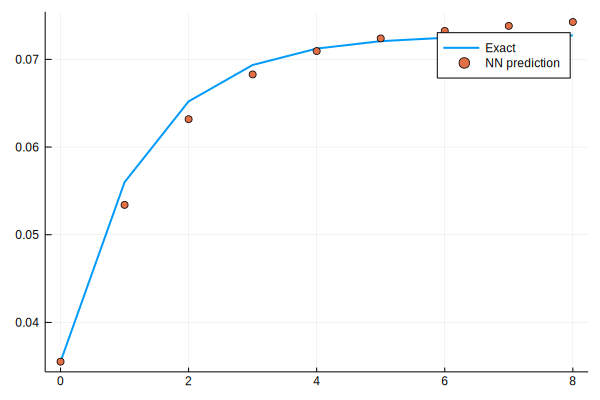

loss: 7.41e-05:  96%|███████████████████████████████████████▎ |  ETA: 0:00:01

7.277411f-5

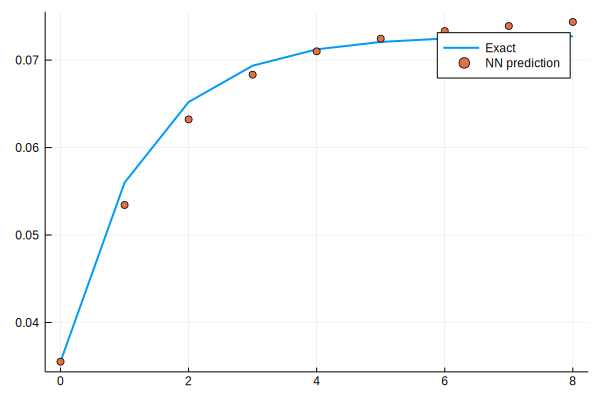

loss: 7.28e-05:  96%|███████████████████████████████████████▍ |  ETA: 0:00:01

7.0897375f-5

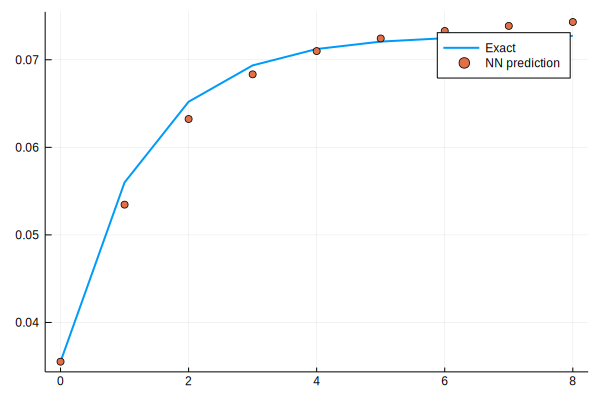

loss: 7.09e-05:  96%|███████████████████████████████████████▌ |  ETA: 0:00:01

6.949643f-5

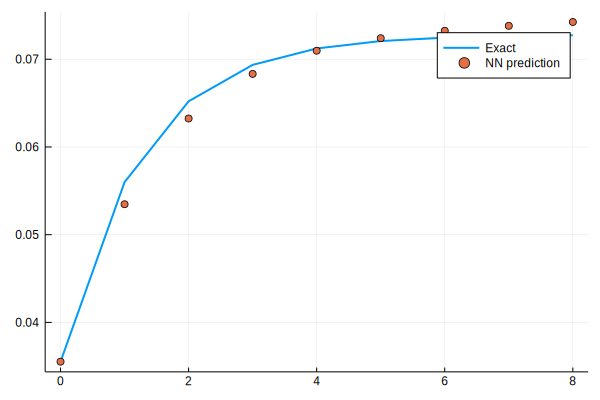

loss: 6.95e-05:  97%|███████████████████████████████████████▋ |  ETA: 0:00:01

6.873748f-5

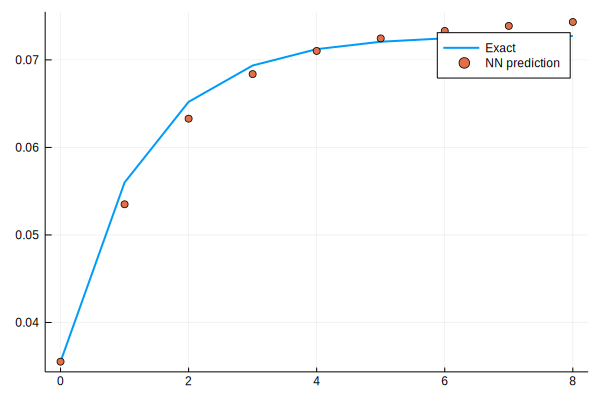

6.790683f-5

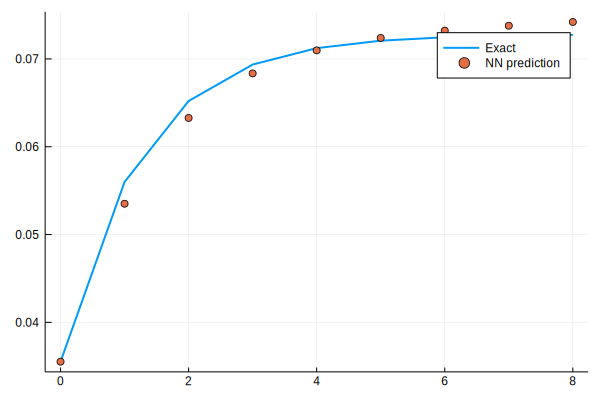

loss: 6.79e-05:  97%|███████████████████████████████████████▉ |  ETA: 0:00:01

6.655777f-5

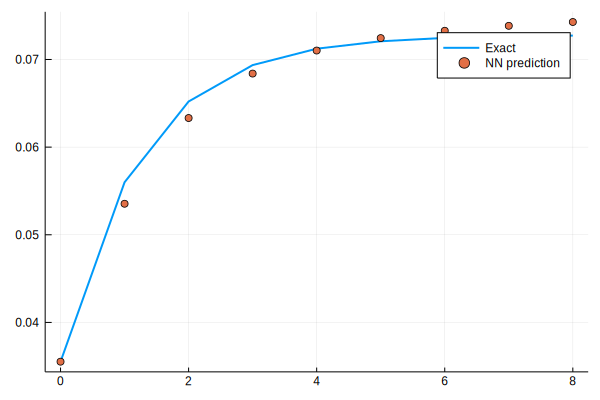

loss: 6.66e-05:  98%|████████████████████████████████████████ |  ETA: 0:00:01

6.5040855f-5

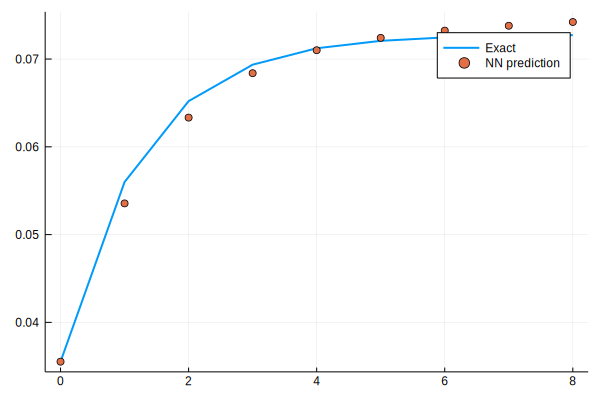

loss: 6.5e-05:  98%|████████████████████████████████████████▏|  ETA: 0:00:01

6.388552f-5

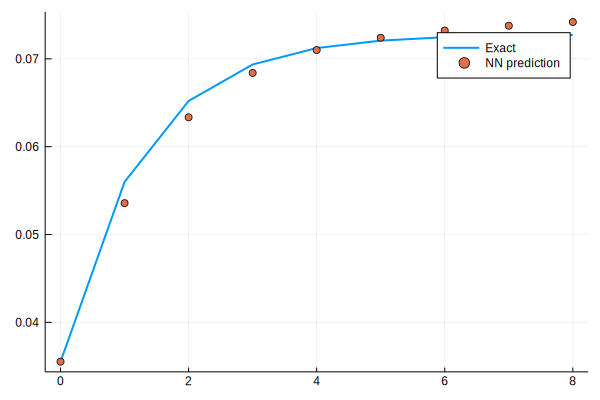

loss: 6.39e-05:  98%|████████████████████████████████████████▎|  ETA: 0:00:01

6.3076666f-5

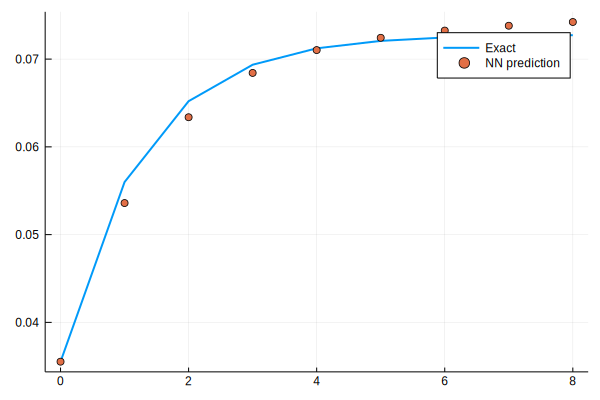

loss: 6.31e-05:  99%|████████████████████████████████████████▍|  ETA: 0:00:00

6.219888f-5

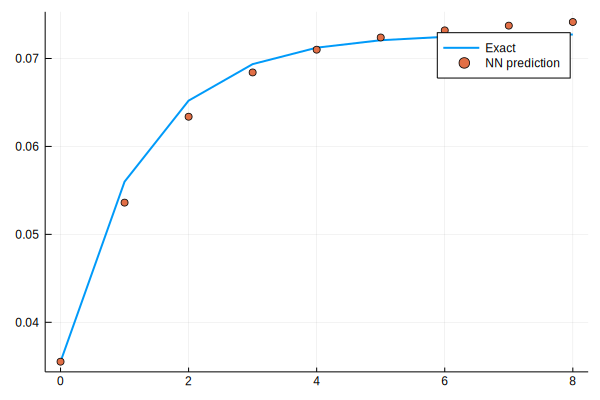

loss: 6.22e-05:  99%|████████████████████████████████████████▋|  ETA: 0:00:00

6.104536f-5

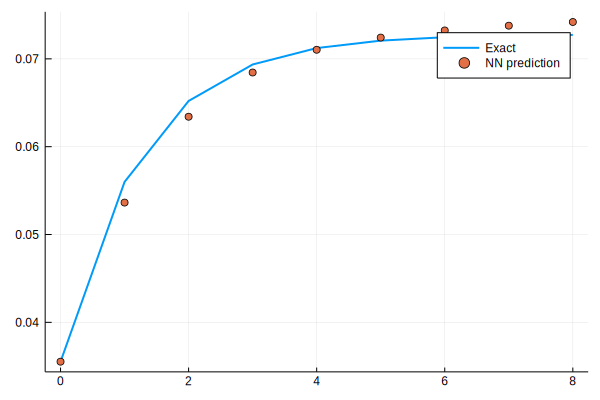

loss: 6.1e-05:  99%|████████████████████████████████████████▊|  ETA: 0:00:00

5.981441f-5

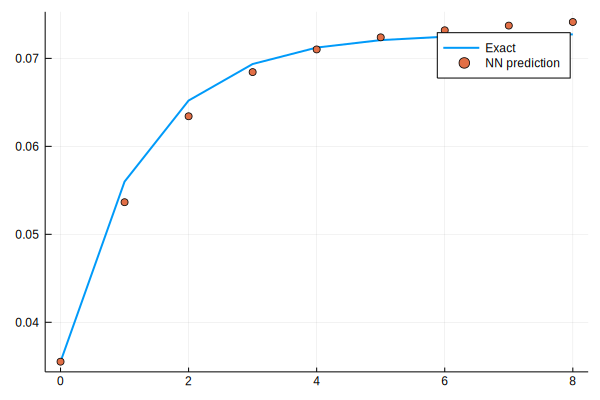

loss: 5.98e-05: 100%|████████████████████████████████████████▉|  ETA: 0:00:00

5.877248f-5

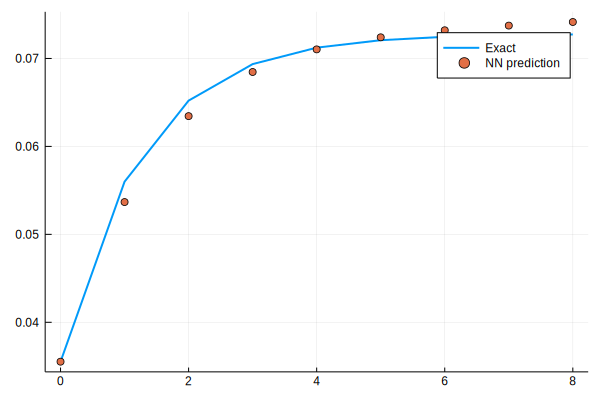

loss: 5.88e-05: 100%|█████████████████████████████████████████| Time: 0:00:29


5.877248f-5

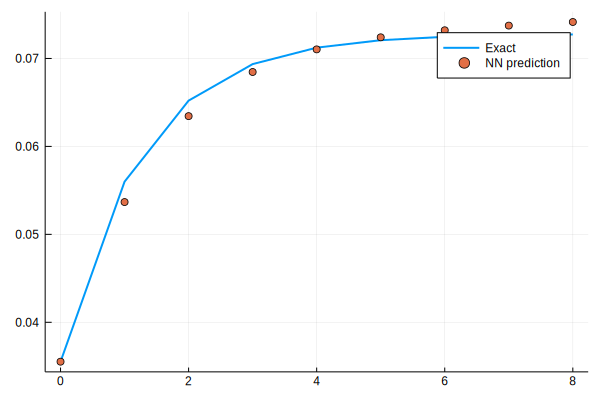

 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Minimizer: [-9.31e-02, 5.76e-02, 9.18e-02,  ...]
    Minimum:   5.877248e-05

 * Found with
    Algorithm:     ADAM
    Initial Point: [-9.07e-02, 5.36e-02, 9.67e-02,  ...]

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   30  (vs limit Inf)
    Iterations:    300
    f(x) calls:    300
    ∇f(x) calls:   300


In [17]:
res = DiffEqFlux.sciml_train(loss_n_ode, n_ode.p, ADAM(), cb=cb, maxiters=300)

Improve the training results with BFGS optimizer

5.7920013f-5

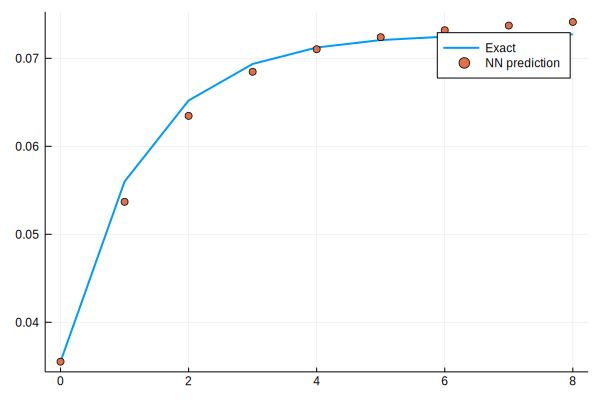

loss: 5.79e-05:   0%|▎                                        |  ETA: 0:00:21

0.28839484f0

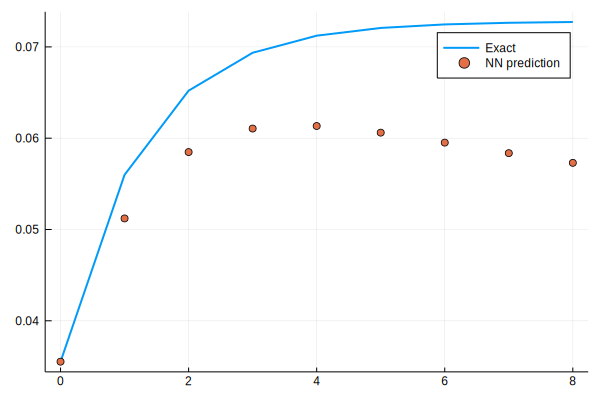

loss: 0.288:   1%|▍                                        |  ETA: 0:00:22

0.019397488f0

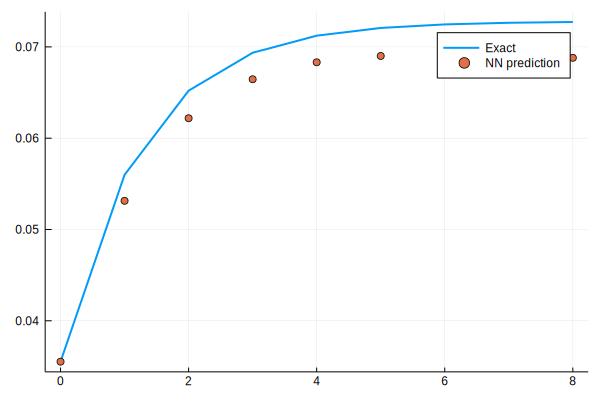

0.03995607f0

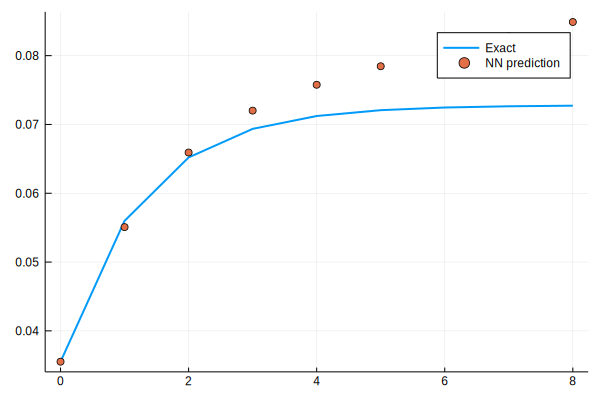

loss: 0.04:   2%|▉                                        |  ETA: 0:00:20

0.11997646f0

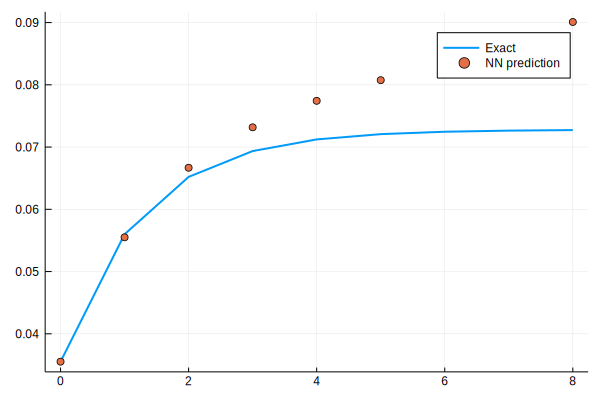

loss: 0.12:   2%|█                                        |  ETA: 0:00:20

0.13100253f0

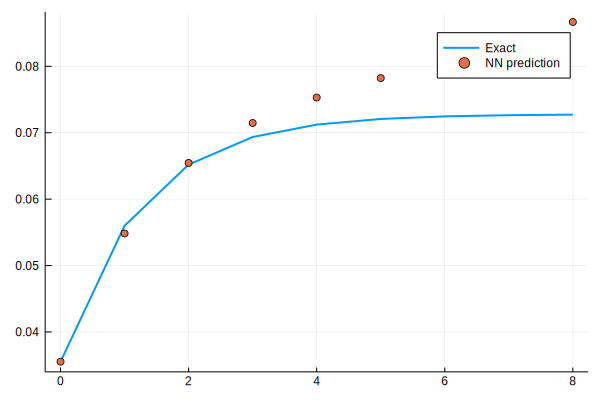

loss: 0.131:   3%|█▎                                       |  ETA: 0:00:20

0.09216064f0

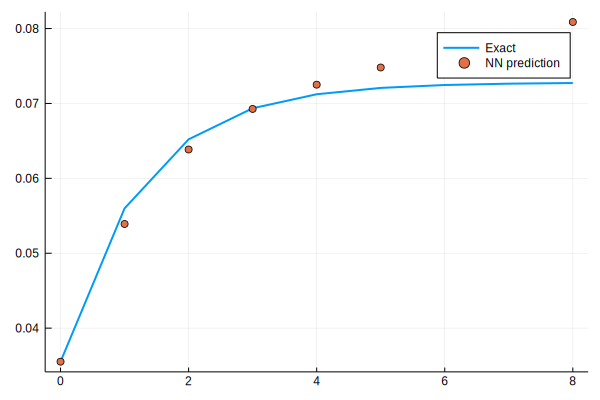

loss: 0.0922:   4%|█▍                                       |  ETA: 0:00:21

0.046455912f0

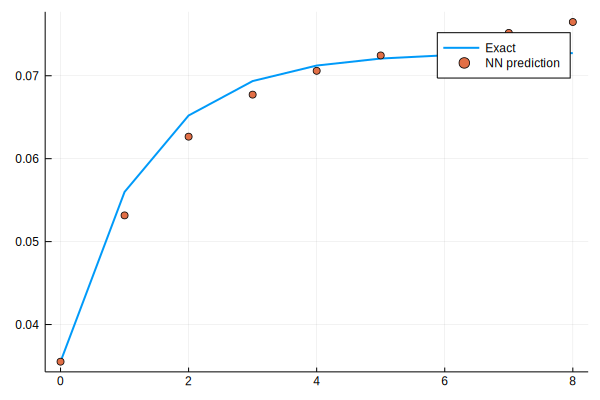

loss: 0.0465:   4%|█▋                                       |  ETA: 0:00:21

0.016736183f0

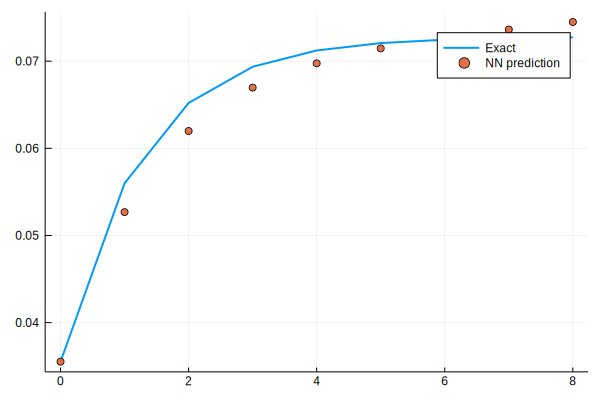

loss: 0.0167:   4%|█▉                                       |  ETA: 0:00:21

0.008635687f0

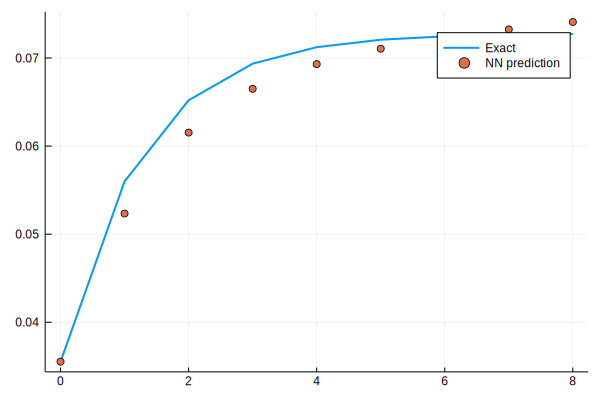

loss: 0.00864:   5%|██                                       |  ETA: 0:00:21

0.01751261f0

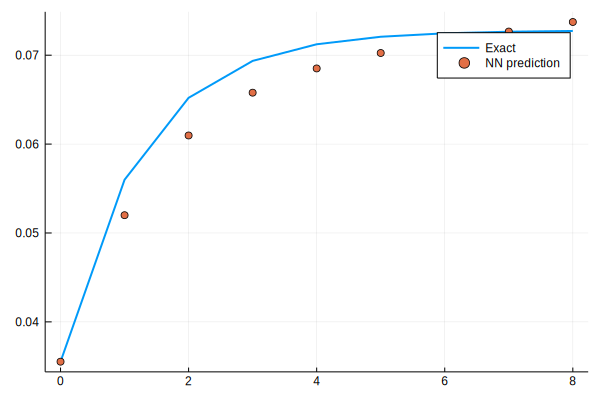

loss: 0.0175:   6%|██▎                                      |  ETA: 0:00:21

0.031665094f0

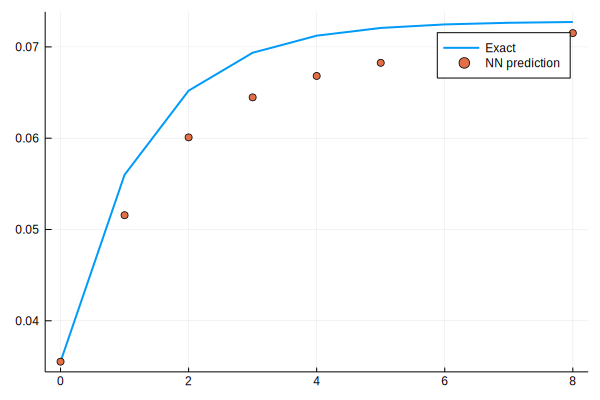

loss: 0.0317:   6%|██▌                                      |  ETA: 0:00:21

0.03979806f0

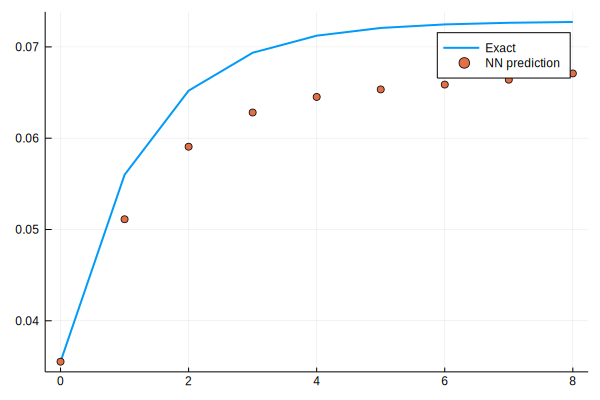

loss: 0.0398:   6%|██▋                                      |  ETA: 0:00:21

0.03837637f0

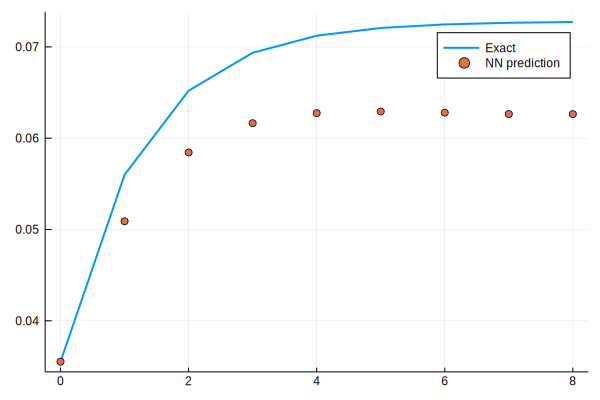

loss: 0.0384:   7%|██▉                                      |  ETA: 0:00:21

0.029971244f0

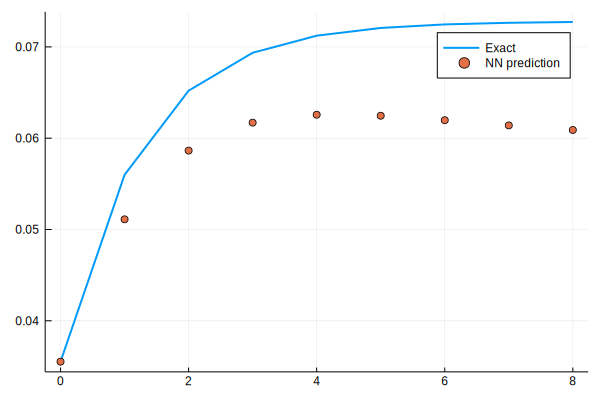

loss: 0.03:   8%|███▏                                     |  ETA: 0:00:21

0.018775012f0

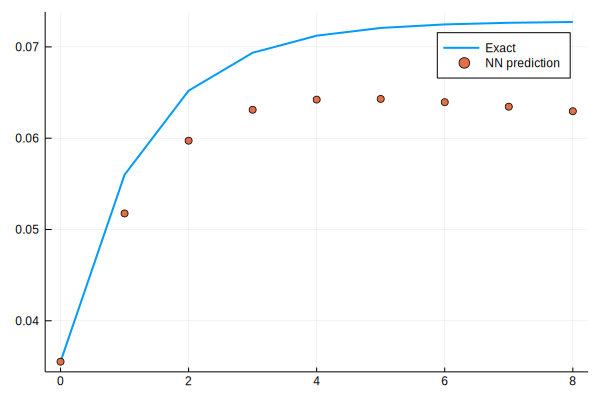

loss: 0.0188:   8%|███▎                                     |  ETA: 0:00:21

0.008904836f0

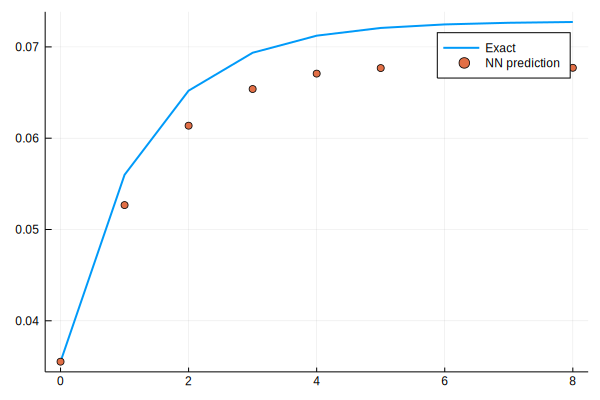

loss: 0.0089:   8%|███▌                                     |  ETA: 0:00:21

0.0032514718f0

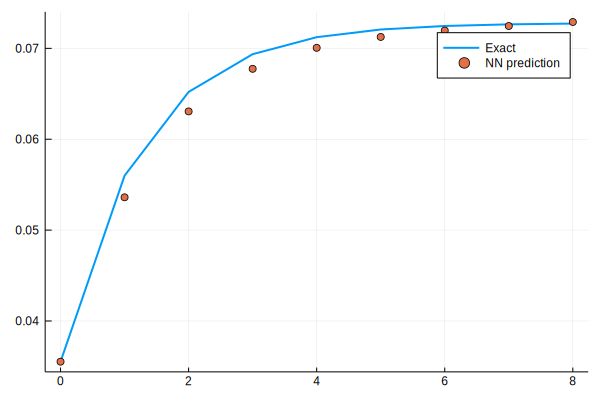

loss: 0.00325:   9%|███▊                                     |  ETA: 0:00:20

0.0025986412f0

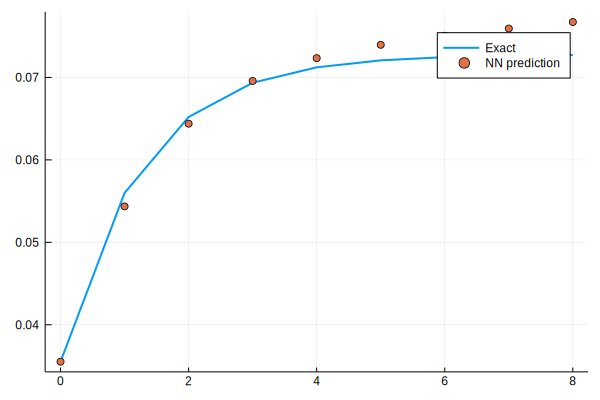

loss: 0.0026:  10%|███▉                                     |  ETA: 0:00:20

0.005766042f0

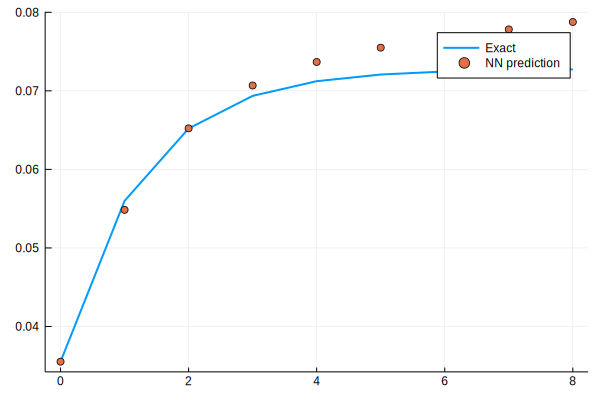

loss: 0.00577:  10%|████▏                                    |  ETA: 0:00:20

0.010197005f0

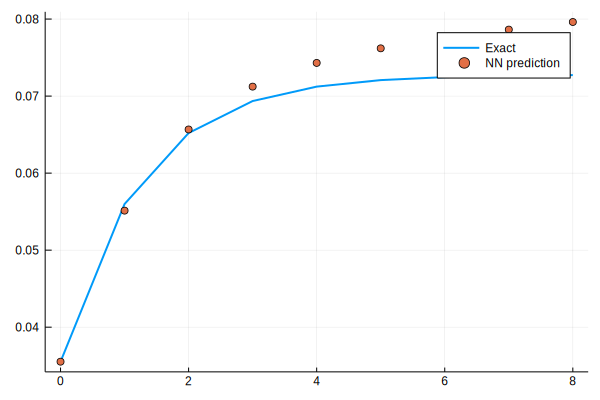

loss: 0.0102:  10%|████▎                                    |  ETA: 0:00:20

0.013257126f0

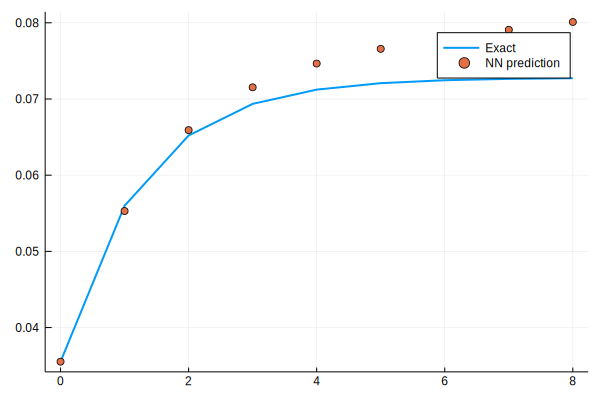

loss: 0.0133:  11%|████▌                                    |  ETA: 0:00:20

0.013780013f0

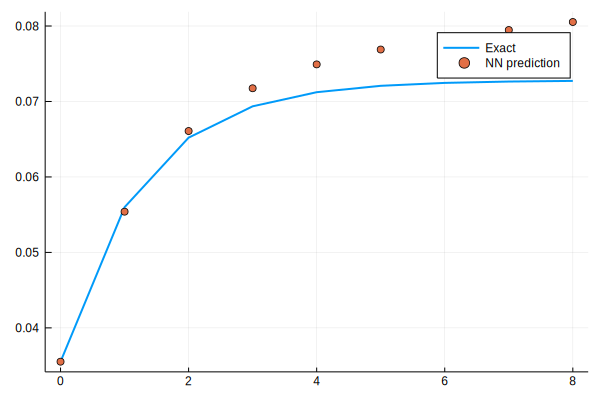

loss: 0.0138:  12%|████▊                                    |  ETA: 0:00:20

0.012142089f0

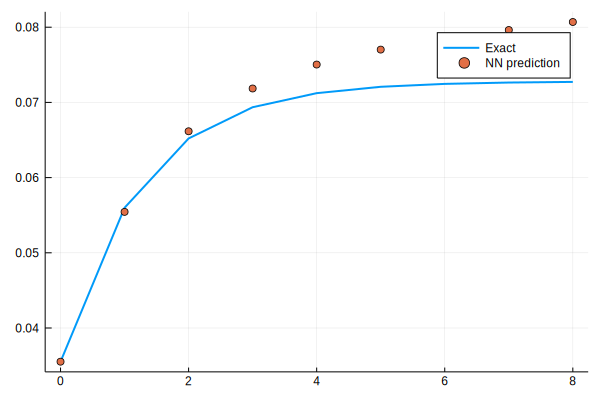

loss: 0.0121:  12%|████▉                                    |  ETA: 0:00:20

0.009181044f0

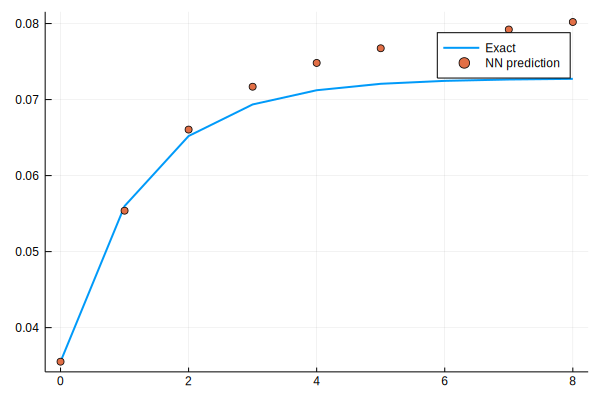

loss: 0.00918:  12%|█████▏                                   |  ETA: 0:00:20

0.00574101f0

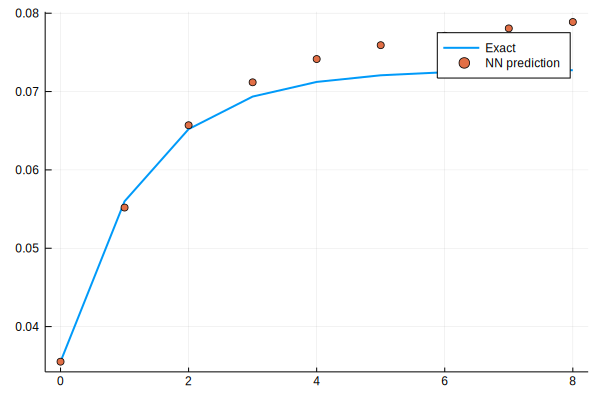

loss: 0.00574:  13%|█████▍                                   |  ETA: 0:00:20

0.0027661212f0

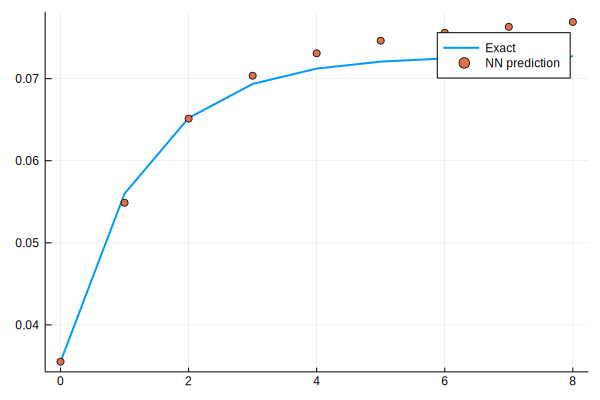

0.0010750858f0

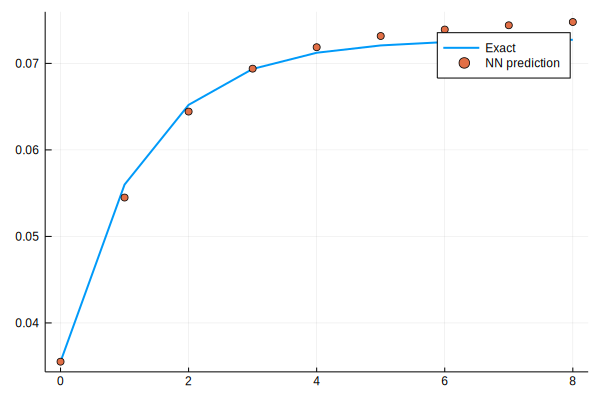

loss: 0.00108:  14%|█████▊                                   |  ETA: 0:00:20

0.0009181963f0

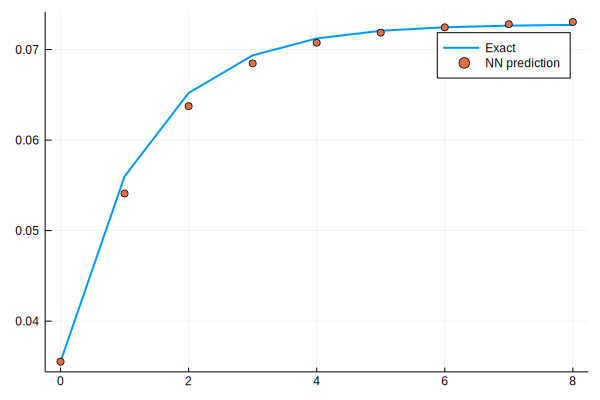

loss: 0.000918:  14%|██████                                   |  ETA: 0:00:19

0.0018518138f0

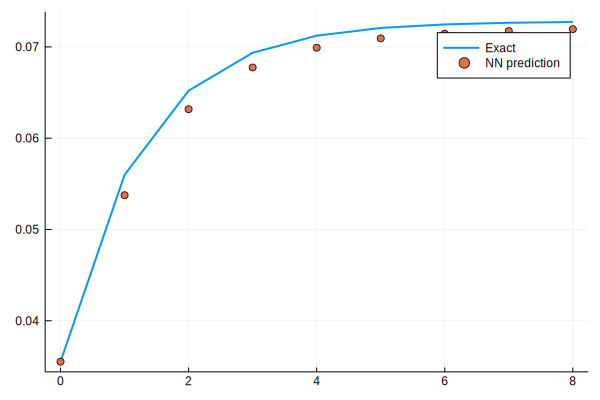

loss: 0.00185:  15%|██████▏                                  |  ETA: 0:00:19

0.0030741617f0

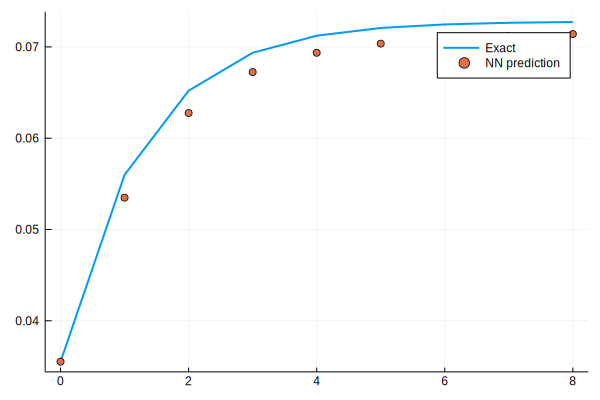

loss: 0.00307:  16%|██████▍                                  |  ETA: 0:00:19

0.003980235f0

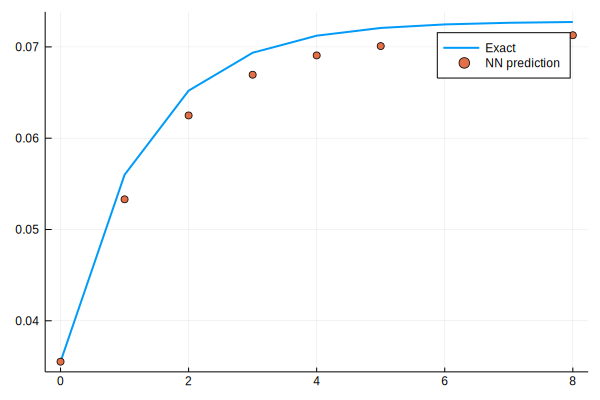

loss: 0.00398:  16%|██████▌                                  |  ETA: 0:00:19

0.0043838597f0

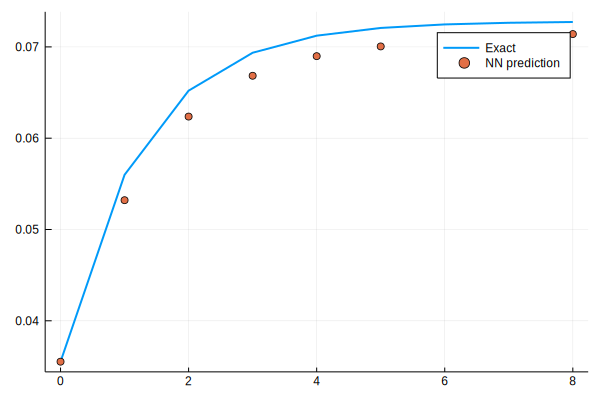

loss: 0.00438:  16%|██████▊                                  |  ETA: 0:00:19

0.004252737f0

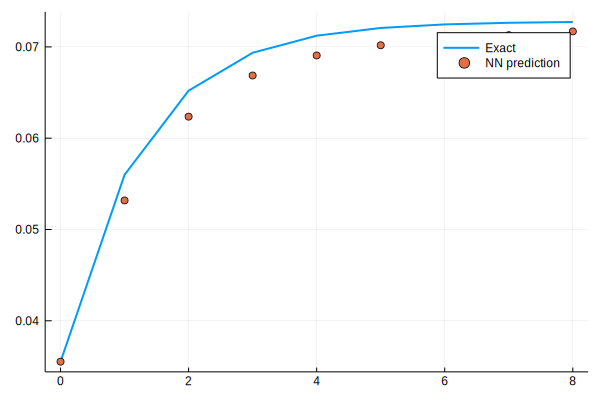

loss: 0.00425:  17%|███████                                  |  ETA: 0:00:19

0.0035488403f0

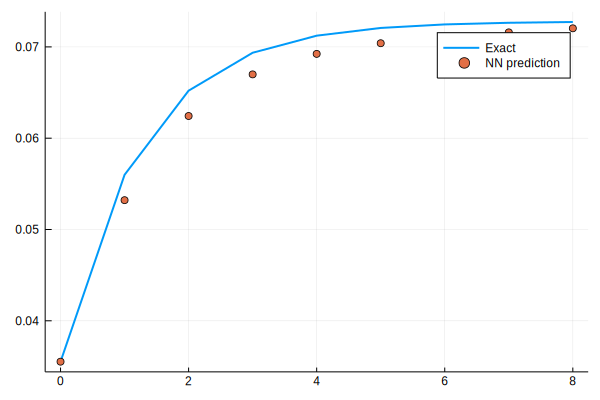

loss: 0.00355:  18%|███████▏                                 |  ETA: 0:00:19

0.0024325605f0

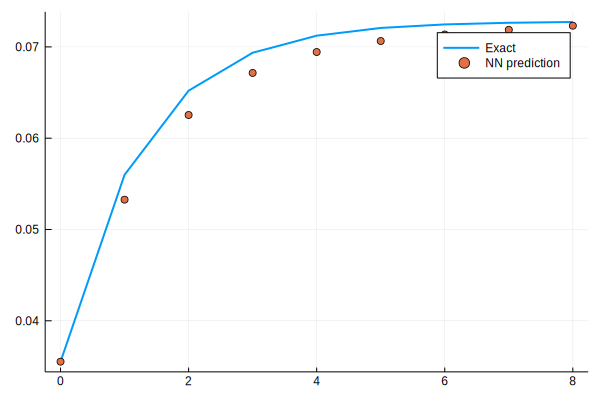

loss: 0.00243:  18%|███████▍                                 |  ETA: 0:00:19

0.0013232914f0

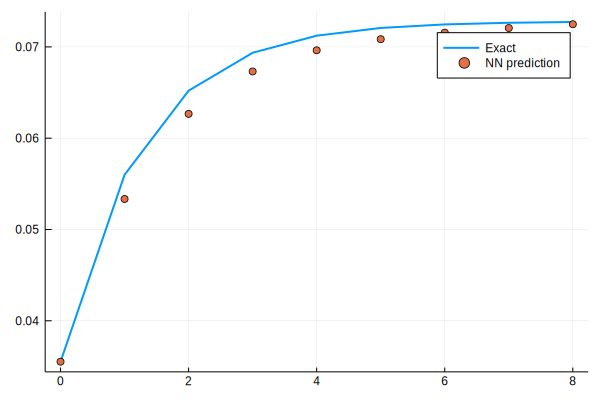

loss: 0.00132:  18%|███████▋                                 |  ETA: 0:00:18

0.0005973984f0

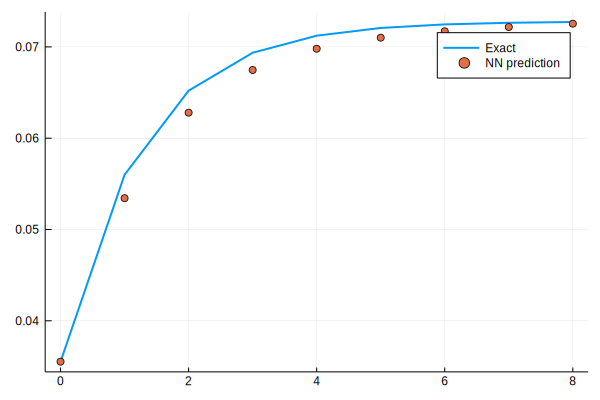

0.00036073965f0

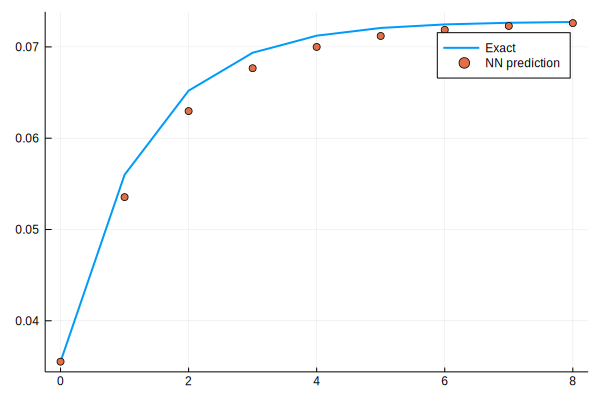

loss: 0.000361:  20%|████████                                 |  ETA: 0:00:18

0.0005208336f0

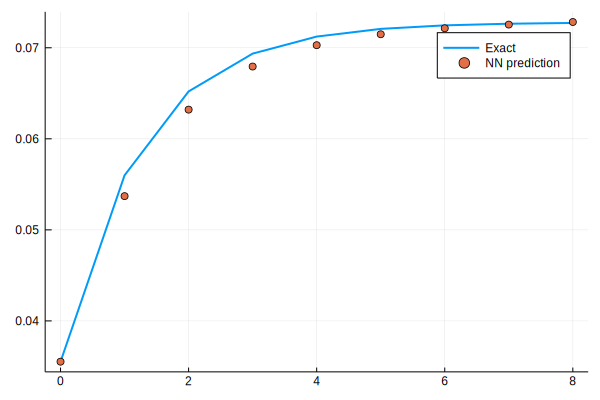

0.0008882176f0

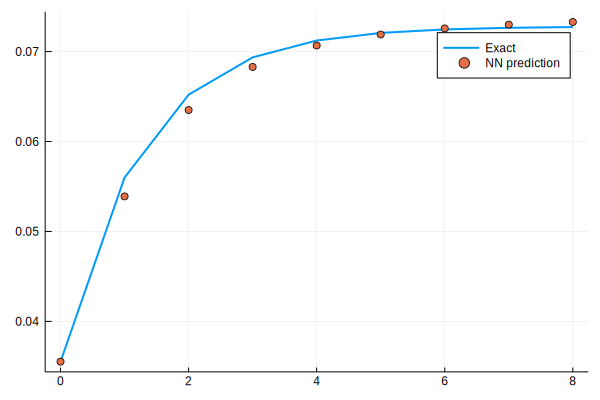

loss: 0.000888:  20%|████████▍                                |  ETA: 0:00:17

0.0012473067f0

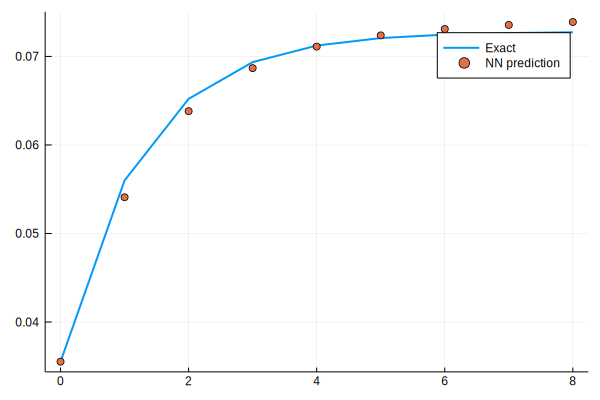

0.0014690761f0

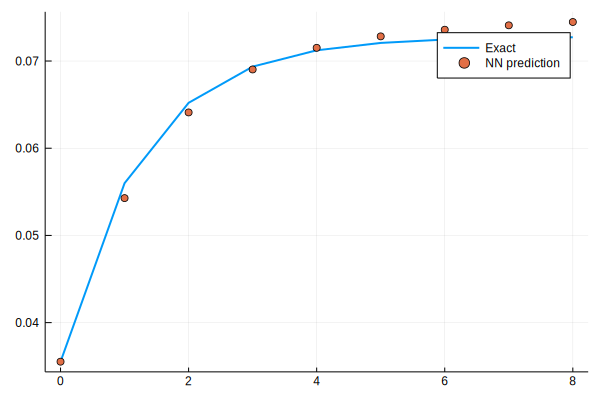

loss: 0.00147:  22%|████████▉                                |  ETA: 0:00:17

0.0015078358f0

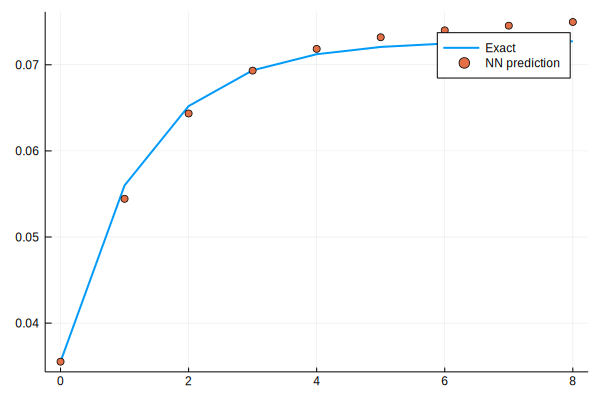

loss: 0.00151:  22%|█████████                                |  ETA: 0:00:17

0.0013328369f0

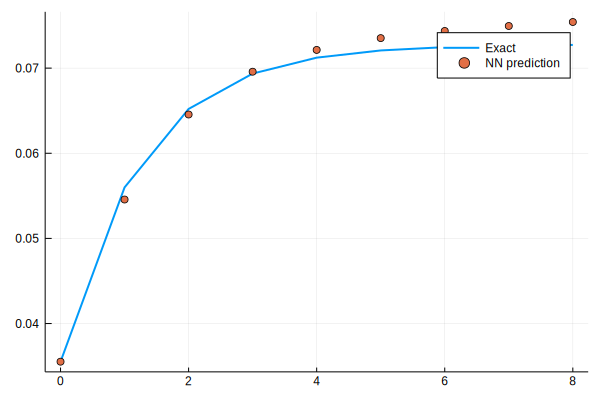

loss: 0.00133:  22%|█████████▎                               |  ETA: 0:00:17

0.000987906f0

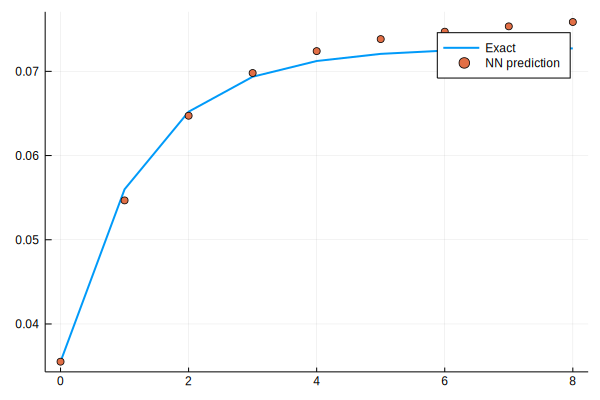

loss: 0.000988:  23%|█████████▍                               |  ETA: 0:00:17

0.0006206218f0

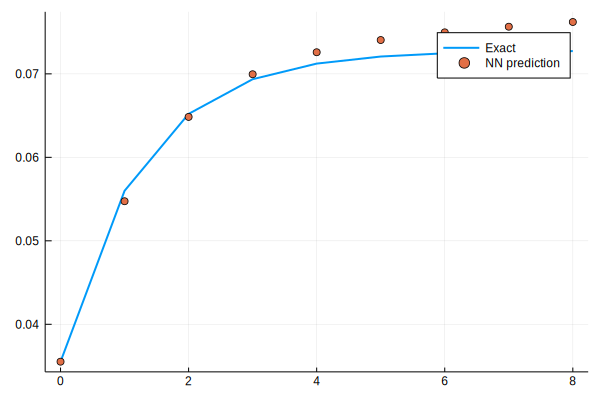

loss: 0.000621:  24%|█████████▋                               |  ETA: 0:00:17

0.0003457148f0

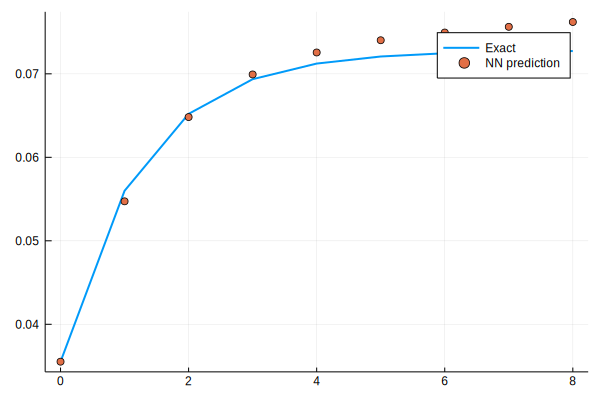

loss: 0.000346:  24%|█████████▉                               |  ETA: 0:00:17

0.00019032203f0

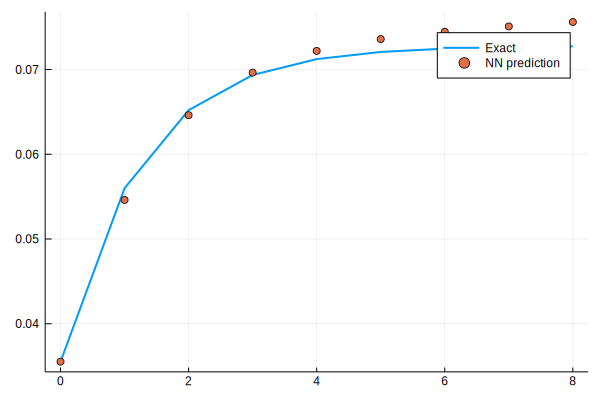

loss: 0.00019:  24%|██████████                               |  ETA: 0:00:16

0.00017148445f0

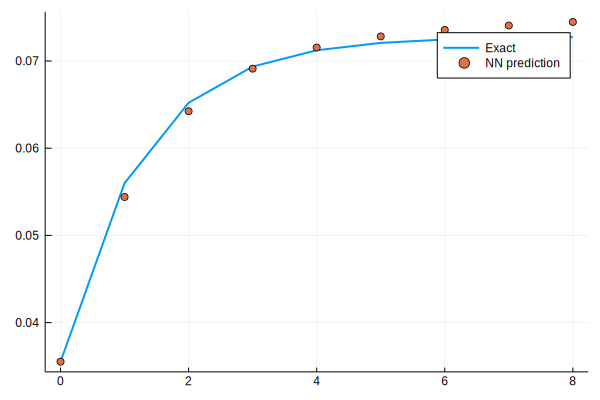

loss: 0.000171:  25%|██████████▎                              |  ETA: 0:00:16

0.0002788778f0

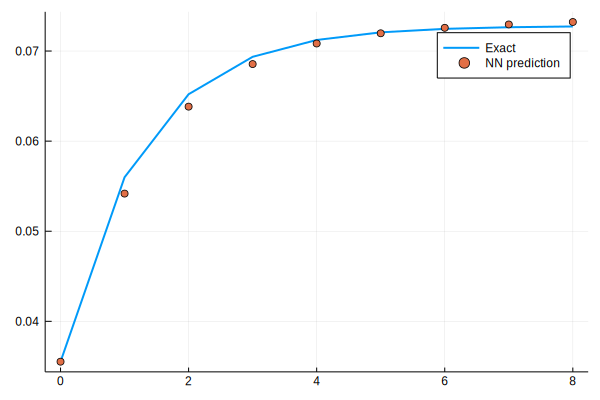

loss: 0.000279:  26%|██████████▌                              |  ETA: 0:00:16

0.00042780204f0

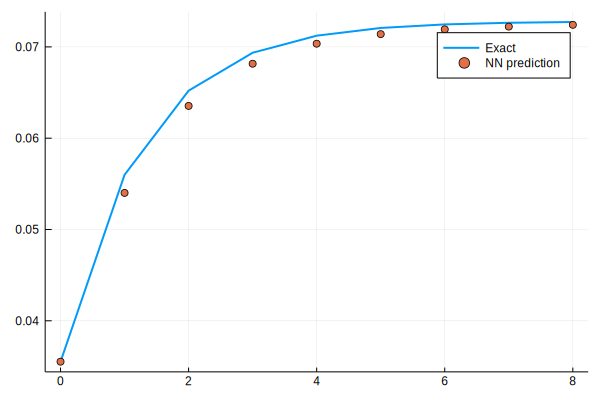

loss: 0.000428:  26%|██████████▋                              |  ETA: 0:00:16

0.00053169875f0

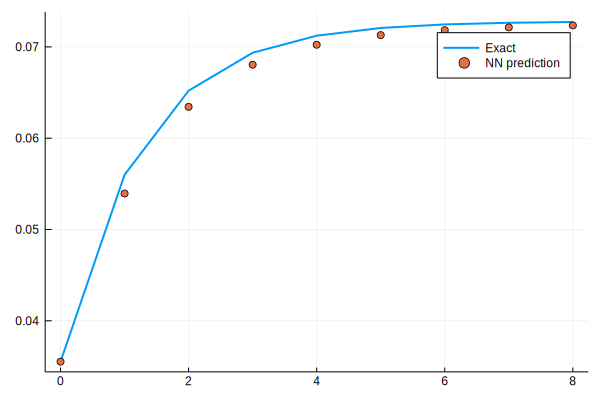

loss: 0.000532:  26%|██████████▉                              |  ETA: 0:00:16

0.00055854325f0

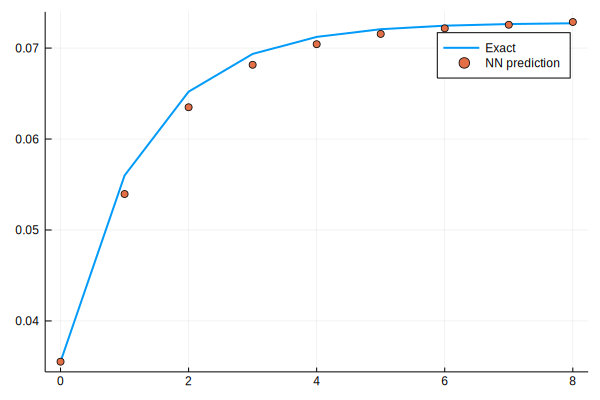

loss: 0.000559:  27%|███████████▏                             |  ETA: 0:00:16

0.0005048493f0

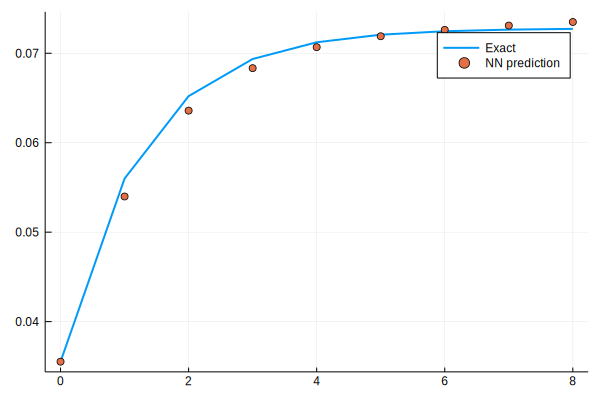

loss: 0.000505:  28%|███████████▎                             |  ETA: 0:00:16

0.0003890028f0

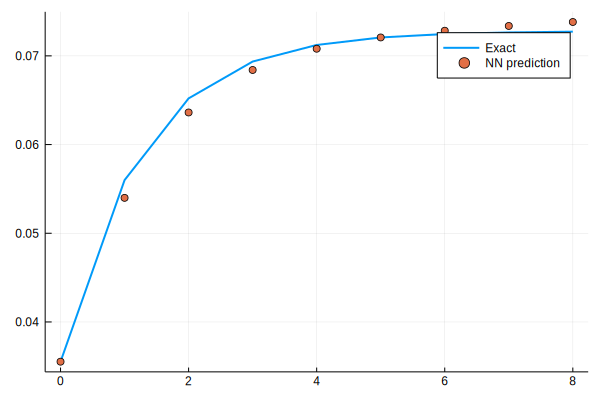

loss: 0.000389:  28%|███████████▌                             |  ETA: 0:00:16

0.00025311208f0

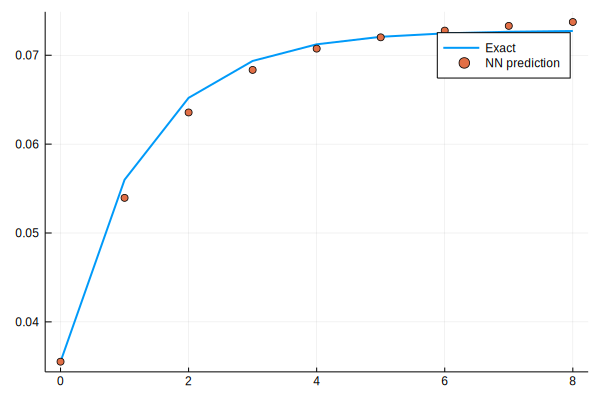

0.00014141246f0

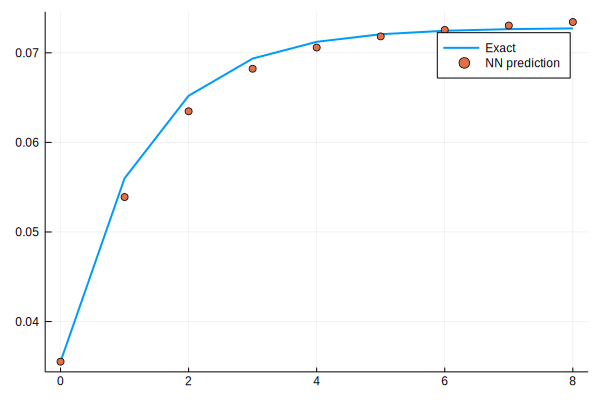

loss: 0.000141:  29%|███████████▉                             |  ETA: 0:00:15

8.746437f-5

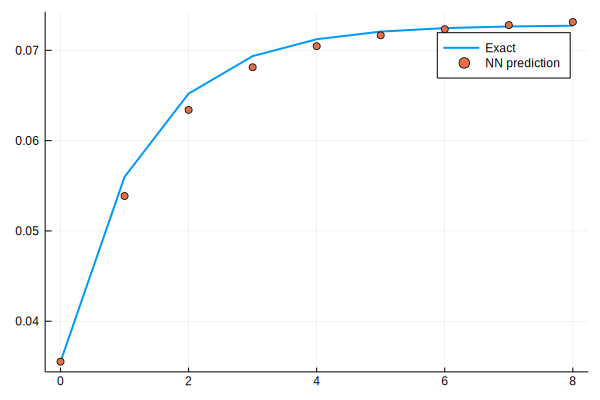

loss: 8.75e-05:  30%|████████████▏                            |  ETA: 0:00:15

9.573501f-5

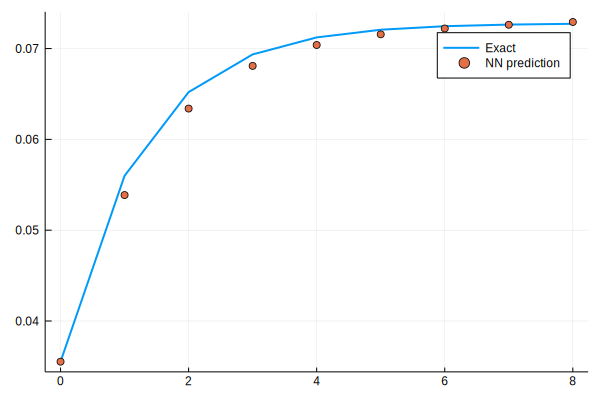

0.00013622215f0

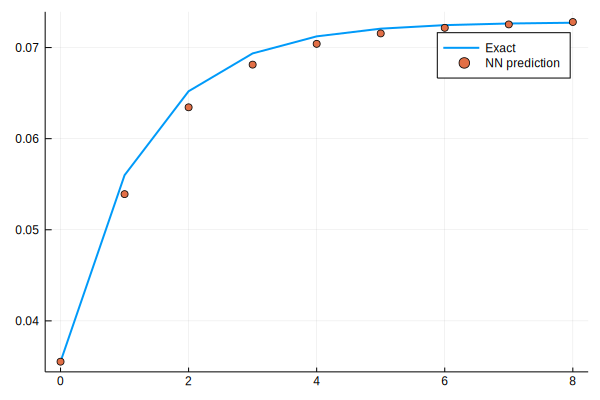

loss: 0.000136:  30%|████████████▌                            |  ETA: 0:00:15

0.00018085506f0

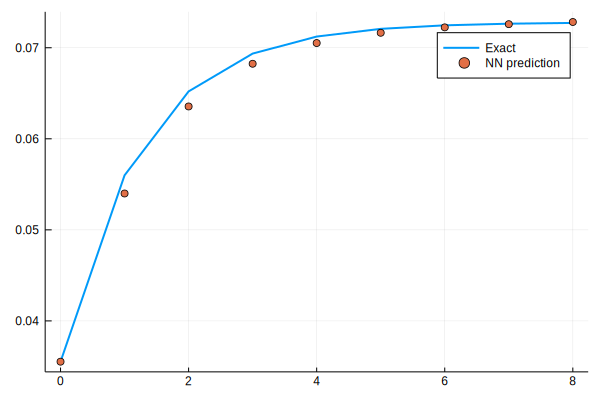

loss: 0.000181:  31%|████████████▊                            |  ETA: 0:00:15

0.00021484683f0

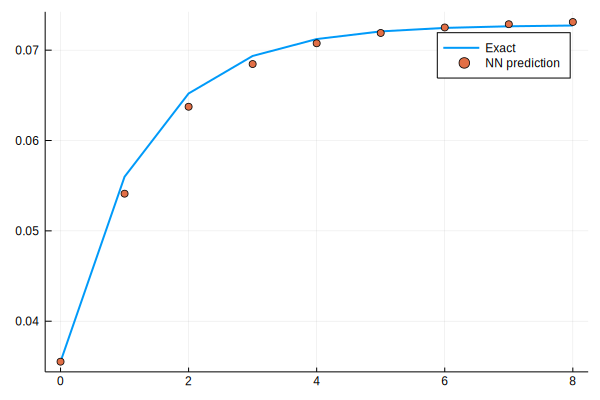

loss: 0.000215:  32%|████████████▉                            |  ETA: 0:00:15

0.00022020859f0

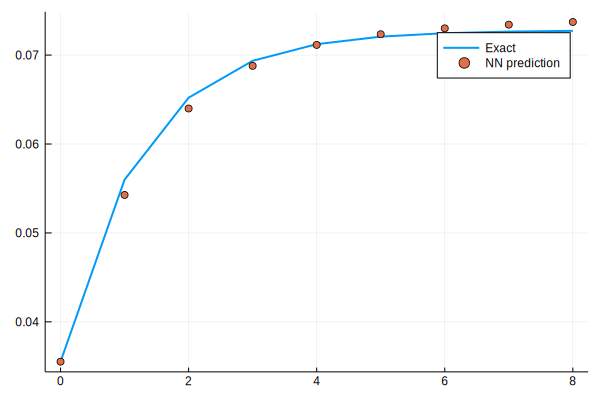

loss: 0.00022:  32%|█████████████▏                           |  ETA: 0:00:15

0.00019229208f0

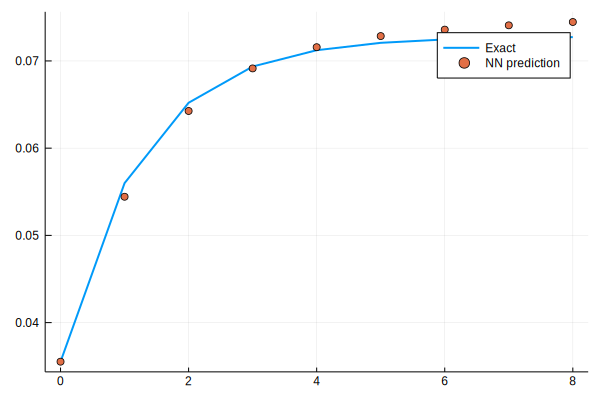

loss: 0.000192:  32%|█████████████▍                           |  ETA: 0:00:15

0.00014840165f0

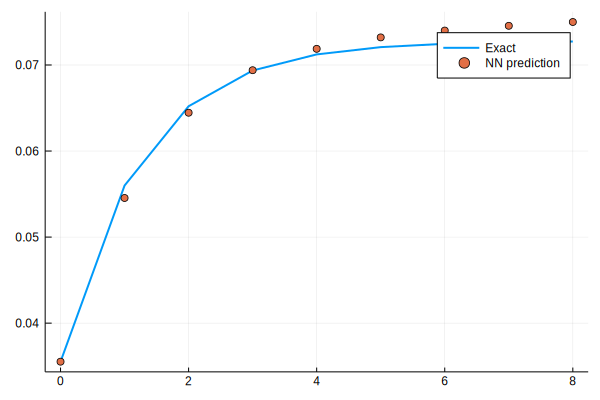

loss: 0.000148:  33%|█████████████▌                           |  ETA: 0:00:14

0.0001042636f0

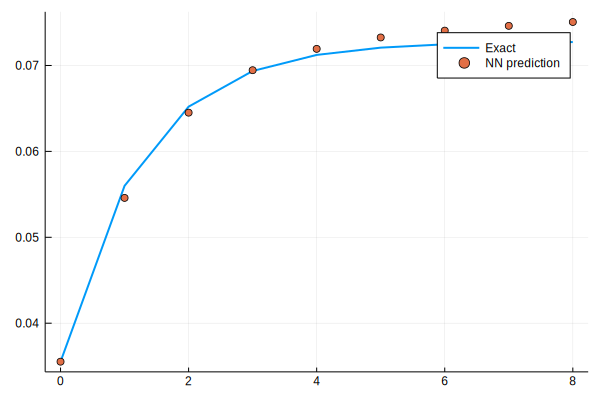

loss: 0.000104:  34%|█████████████▊                           |  ETA: 0:00:14

6.94431f-5

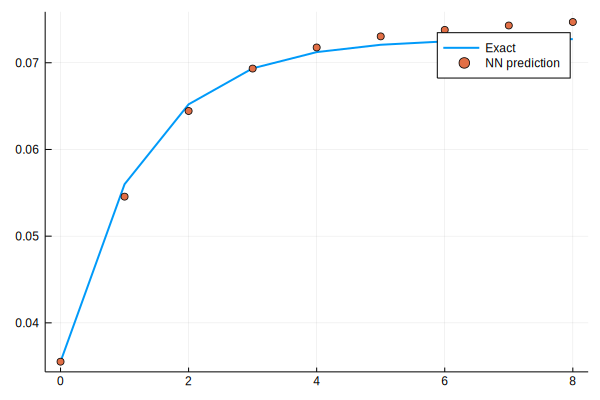

loss: 6.94e-05:  34%|██████████████                           |  ETA: 0:00:14

5.3404376f-5

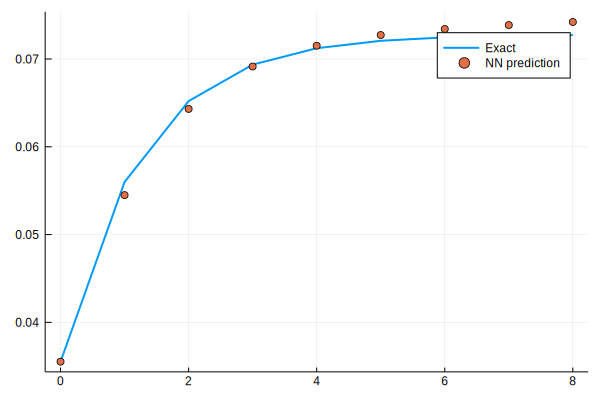

loss: 5.34e-05:  34%|██████████████▏                          |  ETA: 0:00:14

5.8036512f-5

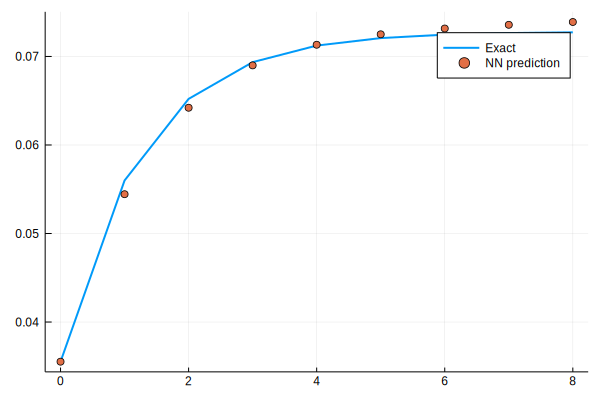

loss: 5.8e-05:  35%|██████████████▍                          |  ETA: 0:00:14

7.5497046f-5

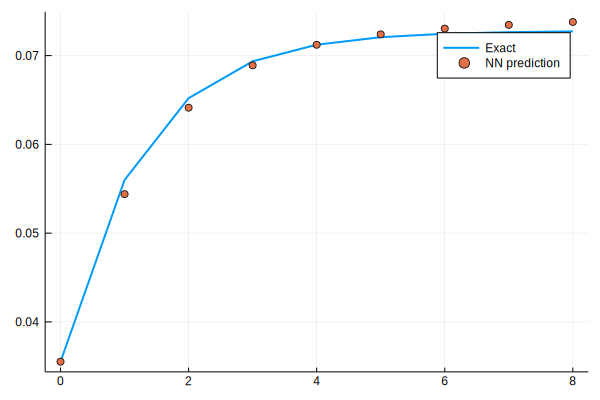

loss: 7.55e-05:  36%|██████████████▌                          |  ETA: 0:00:14

9.397397f-5

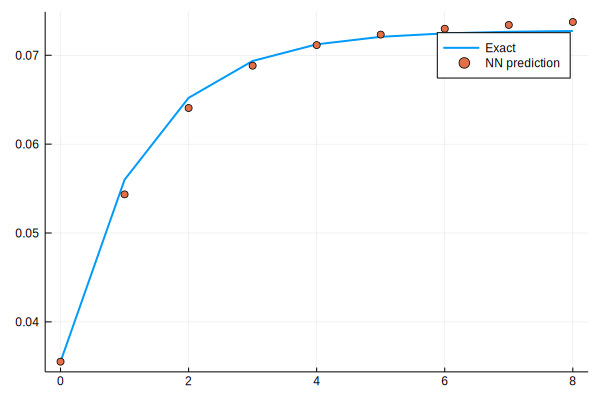

0.00010280127f0

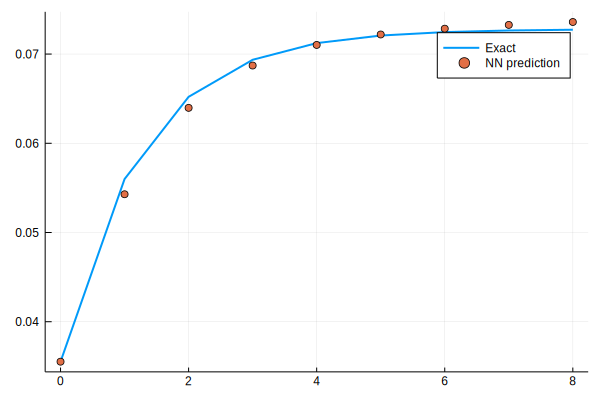

loss: 0.000103:  36%|███████████████                          |  ETA: 0:00:14

9.807178f-5

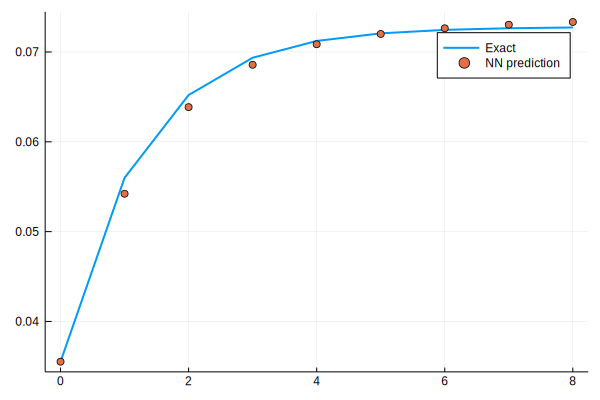

loss: 9.81e-05:  37%|███████████████▏                         |  ETA: 0:00:14

8.293195f-5

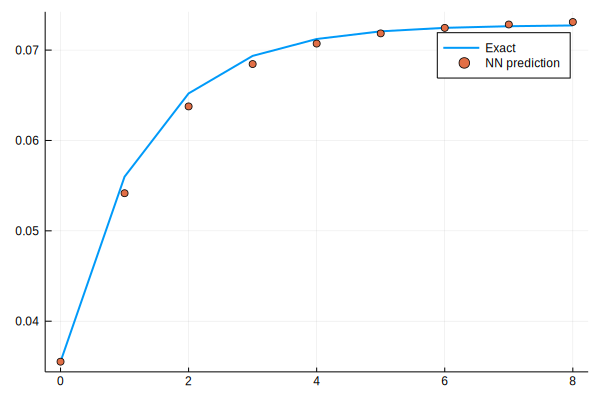

loss: 8.29e-05:  38%|███████████████▍                         |  ETA: 0:00:13

6.317563f-5

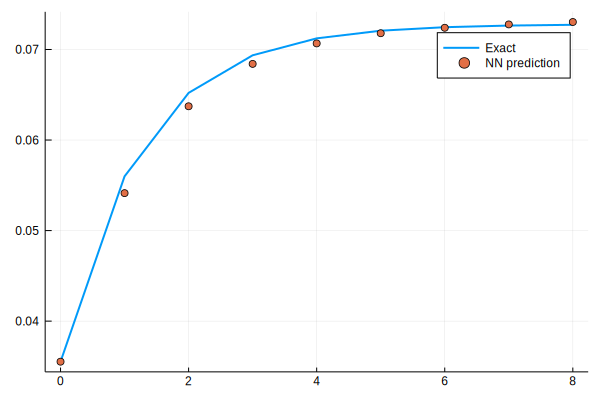

4.671179f-5

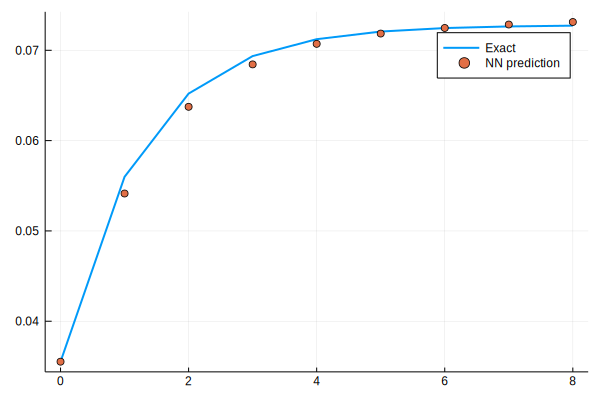

loss: 4.67e-05:  38%|███████████████▊                         |  ETA: 0:00:13

4.0091403f-5

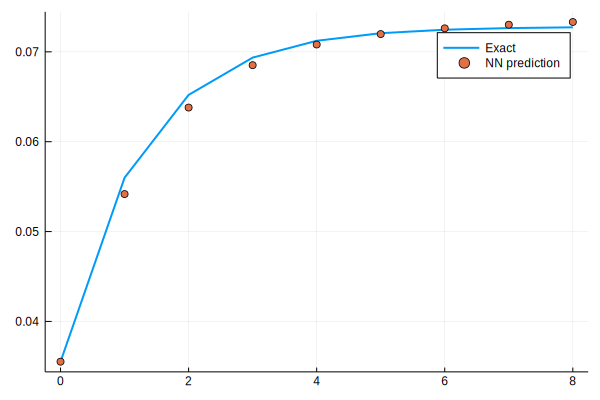

loss: 4.01e-05:  39%|████████████████                         |  ETA: 0:00:13

4.1744555f-5

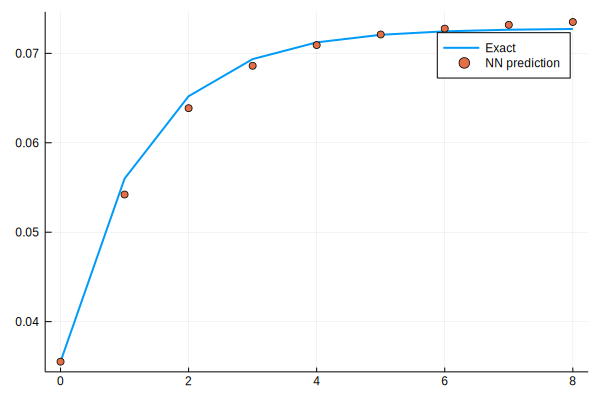

loss: 4.17e-05:  40%|████████████████▎                        |  ETA: 0:00:13

4.641463f-5

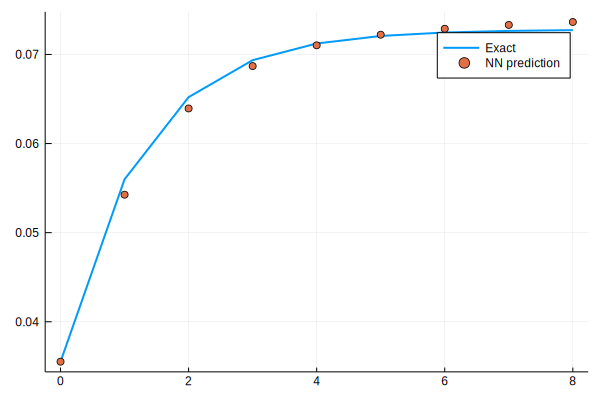

loss: 4.64e-05:  40%|████████████████▍                        |  ETA: 0:00:13

5.1626434f-5

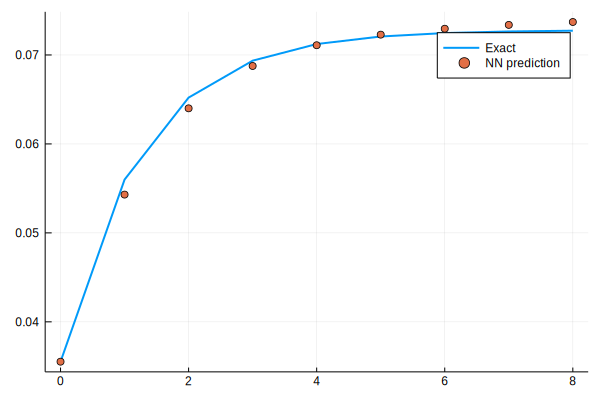

loss: 5.16e-05:  40%|████████████████▋                        |  ETA: 0:00:13

5.534392f-5

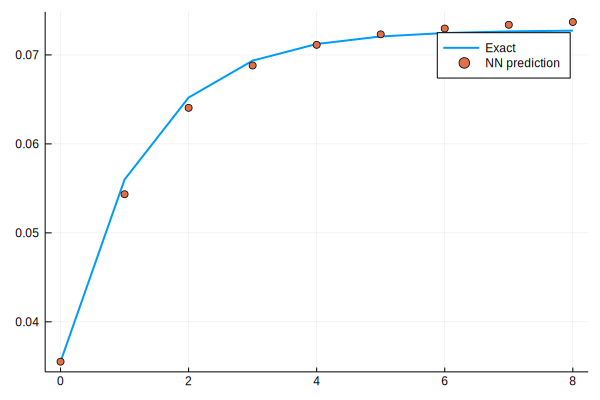

loss: 5.53e-05:  41%|████████████████▊                        |  ETA: 0:00:13

5.524138f-5

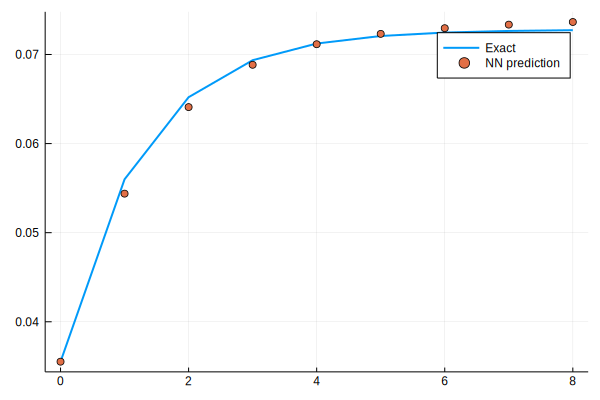

loss: 5.52e-05:  42%|█████████████████                        |  ETA: 0:00:13

5.03292f-5

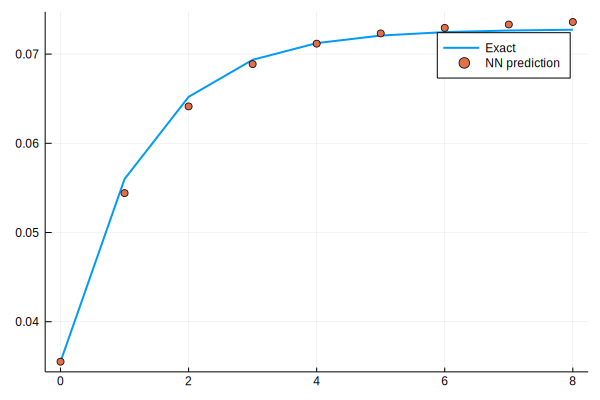

loss: 5.03e-05:  42%|█████████████████▎                       |  ETA: 0:00:12

4.251599f-5

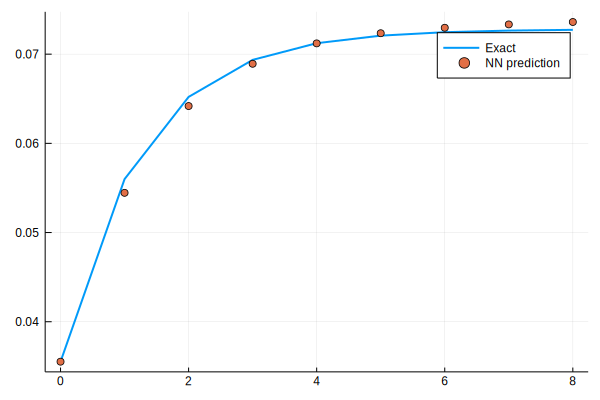

loss: 4.25e-05:  42%|█████████████████▍                       |  ETA: 0:00:12

3.6152567f-5

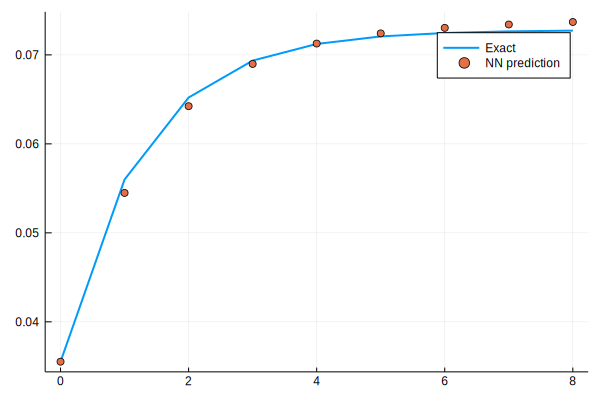

loss: 3.62e-05:  43%|█████████████████▋                       |  ETA: 0:00:12

3.2967862f-5

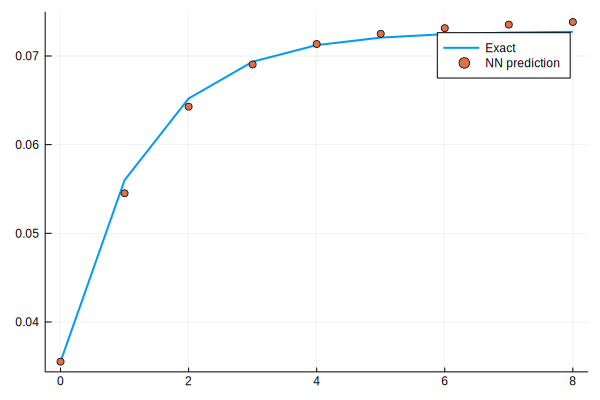

3.2376553f-5

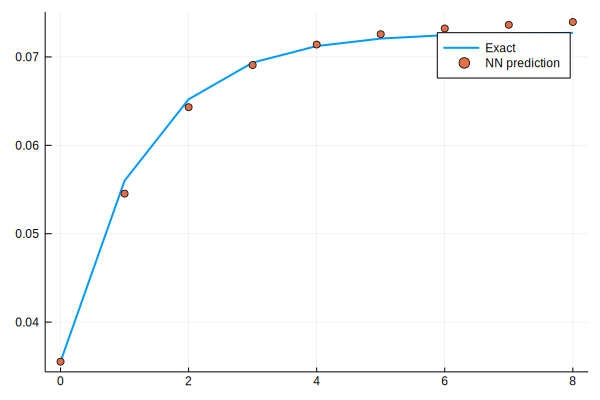

loss: 3.24e-05:  44%|██████████████████                       |  ETA: 0:00:12

3.4328106f-5

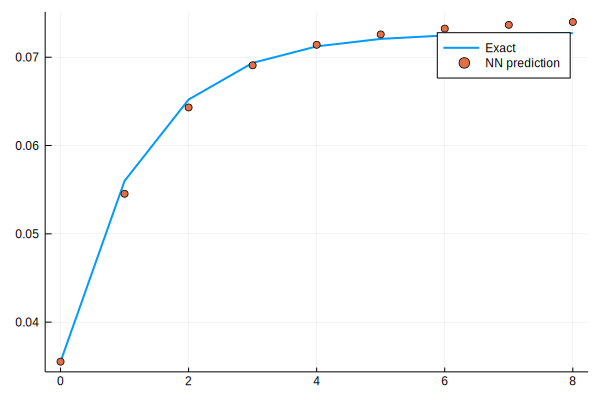

loss: 3.43e-05:  44%|██████████████████▎                      |  ETA: 0:00:12

3.717774f-5

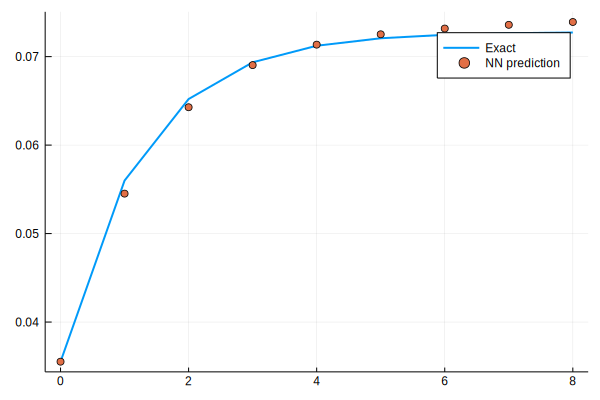

loss: 3.72e-05:  45%|██████████████████▌                      |  ETA: 0:00:12

3.8437473f-5

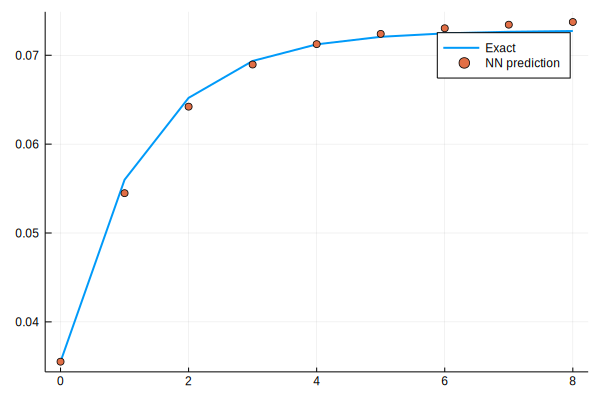

loss: 3.84e-05:  46%|██████████████████▋                      |  ETA: 0:00:12

3.7349106f-5

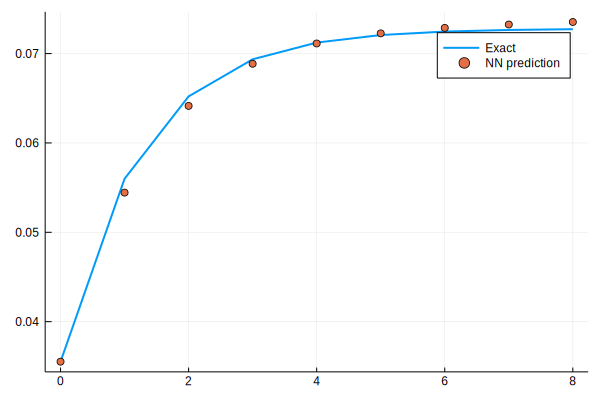

loss: 3.73e-05:  46%|██████████████████▉                      |  ETA: 0:00:12

3.48741f-5

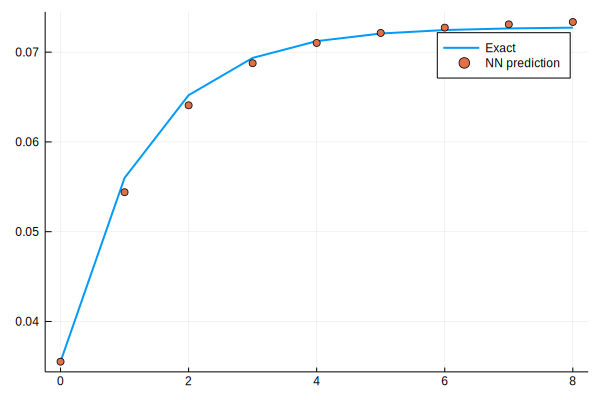

loss: 3.49e-05:  46%|███████████████████▏                     |  ETA: 0:00:11

3.2309035f-5

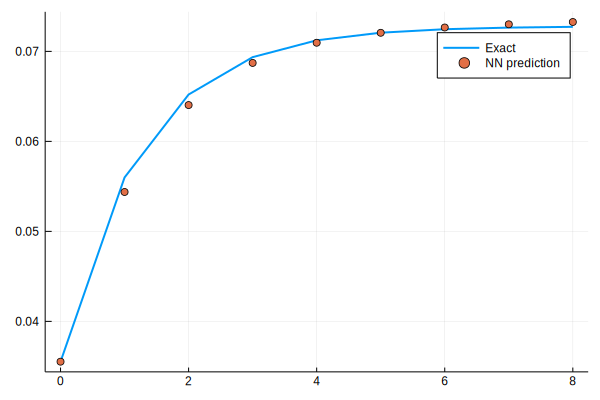

loss: 3.23e-05:  47%|███████████████████▎                     |  ETA: 0:00:11

2.993614f-5

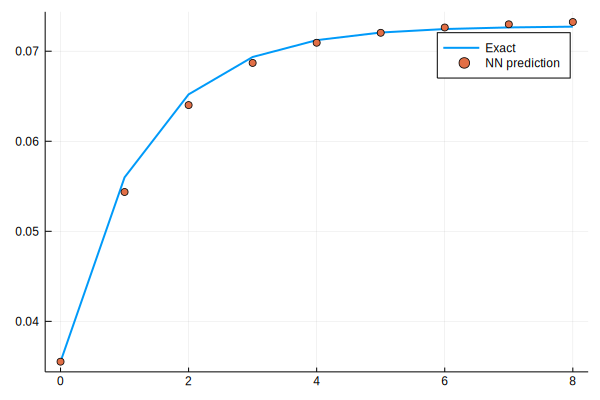

loss: 2.99e-05:  48%|███████████████████▌                     |  ETA: 0:00:11

2.8354698f-5

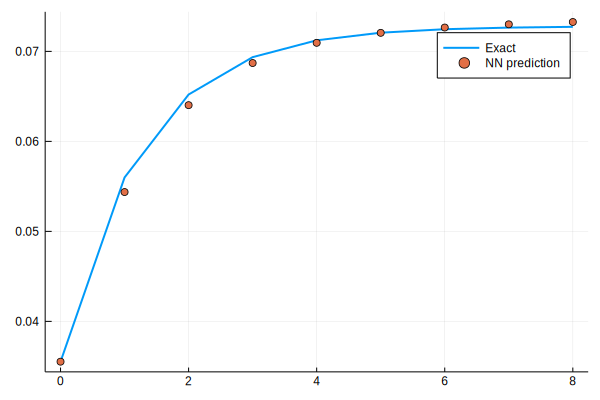

loss: 2.84e-05:  48%|███████████████████▋                     |  ETA: 0:00:11

2.8491733f-5

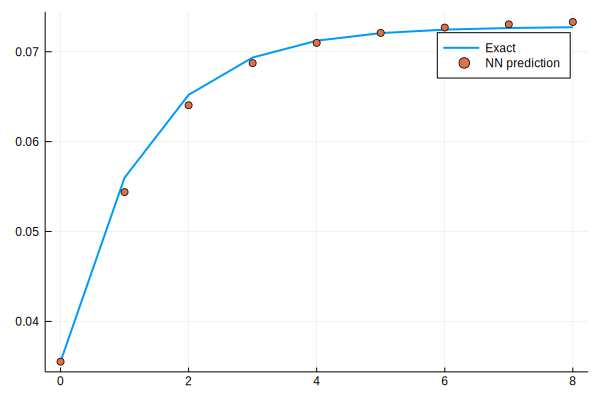

loss: 2.85e-05:  48%|███████████████████▉                     |  ETA: 0:00:11

2.9564944f-5

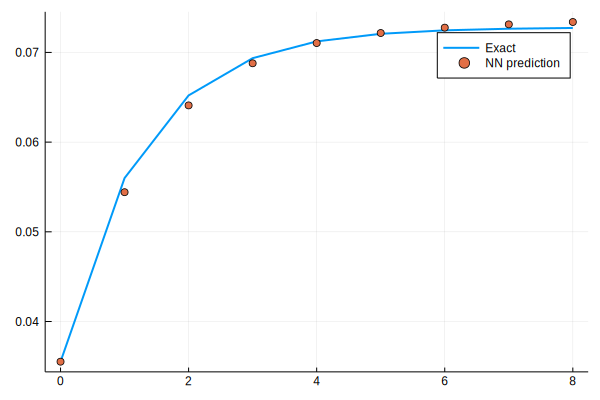

3.0196366f-5

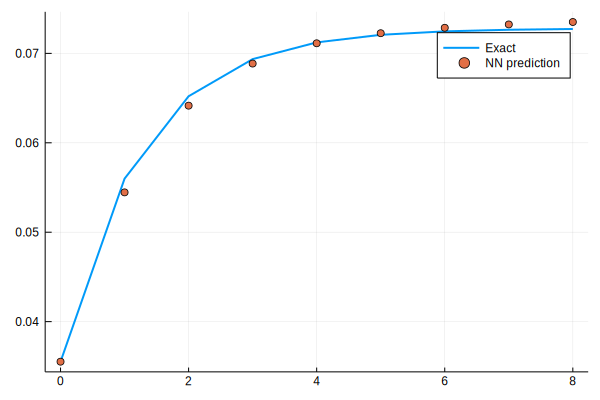

loss: 3.02e-05:  50%|████████████████████▎                    |  ETA: 0:00:11

3.0121604f-5

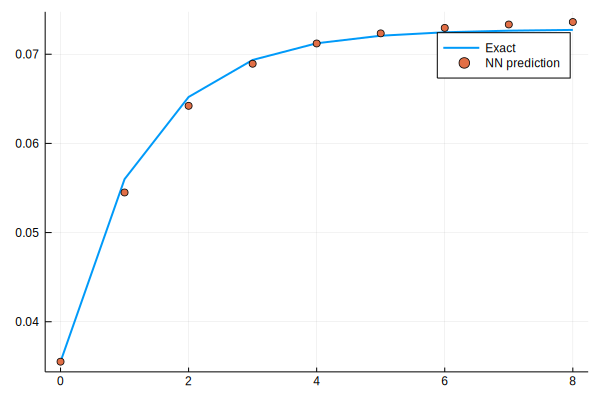

loss: 3.01e-05:  50%|████████████████████▌                    |  ETA: 0:00:11

2.9549421f-5

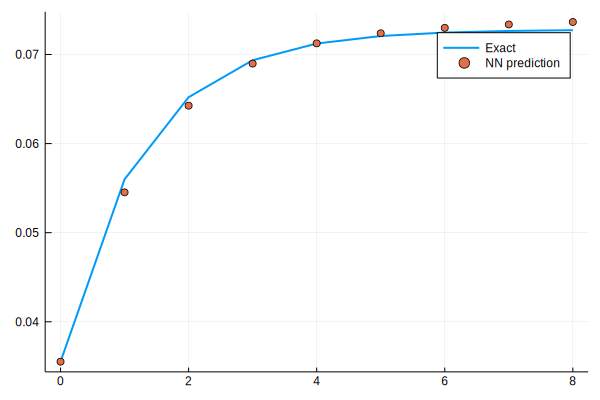

loss: 2.95e-05:  50%|████████████████████▊                    |  ETA: 0:00:11

2.8484905f-5

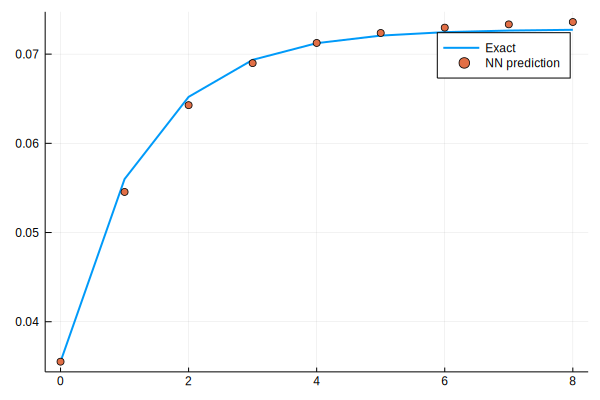

loss: 2.85e-05:  51%|████████████████████▉                    |  ETA: 0:00:11

2.720822f-5

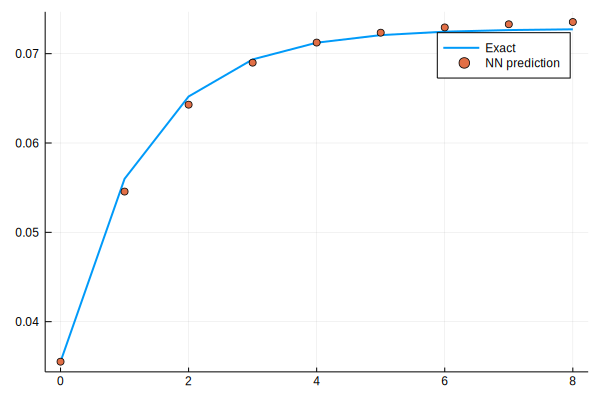

loss: 2.72e-05:  52%|█████████████████████▏                   |  ETA: 0:00:10

2.6276371f-5

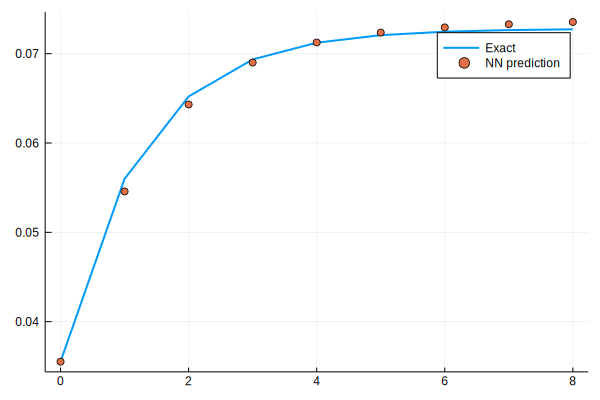

loss: 2.63e-05:  52%|█████████████████████▍                   |  ETA: 0:00:10

2.59167f-5

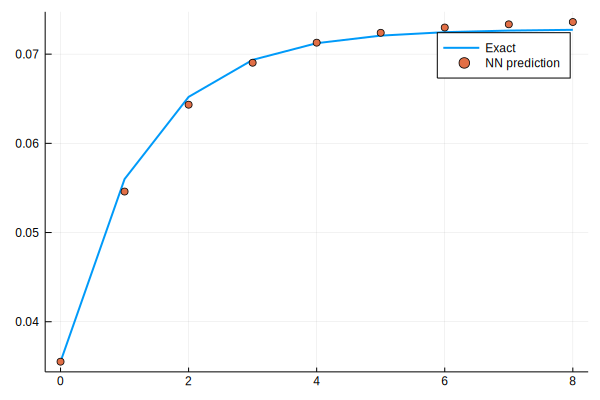

loss: 2.59e-05:  52%|█████████████████████▌                   |  ETA: 0:00:10

2.6037531f-5

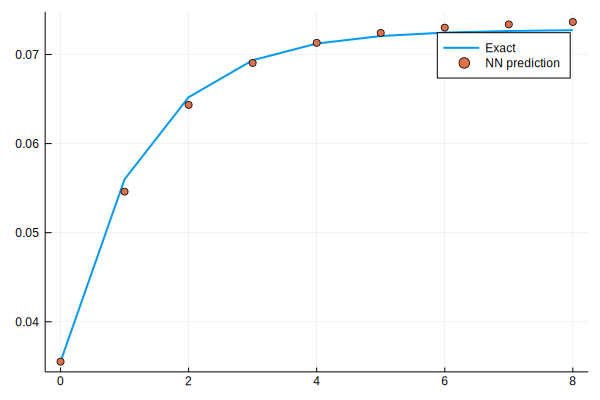

loss: 2.6e-05:  53%|█████████████████████▊                   |  ETA: 0:00:10

2.629794f-5

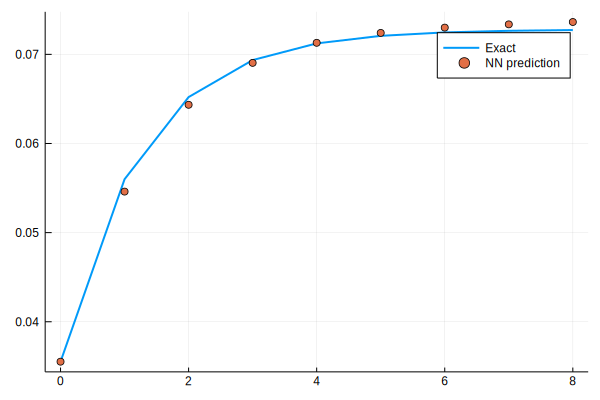

loss: 2.63e-05:  54%|█████████████████████▉                   |  ETA: 0:00:10

2.6367641f-5

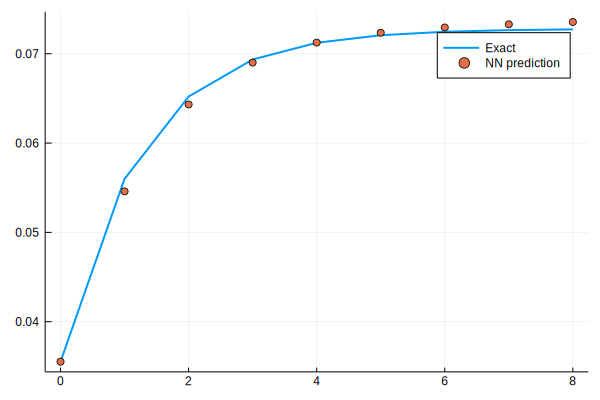

loss: 2.64e-05:  54%|██████████████████████▏                  |  ETA: 0:00:10

2.6157733f-5

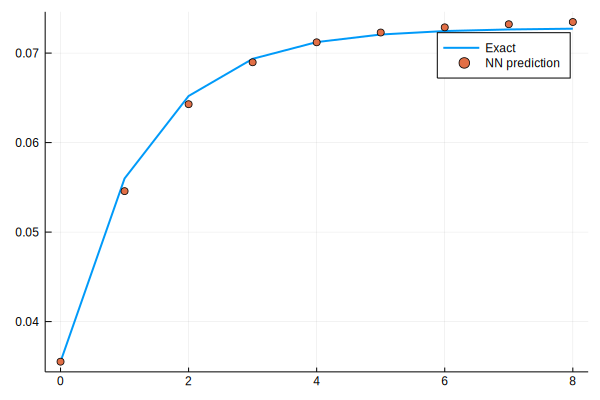

loss: 2.62e-05:  54%|██████████████████████▍                  |  ETA: 0:00:10

2.5625135f-5

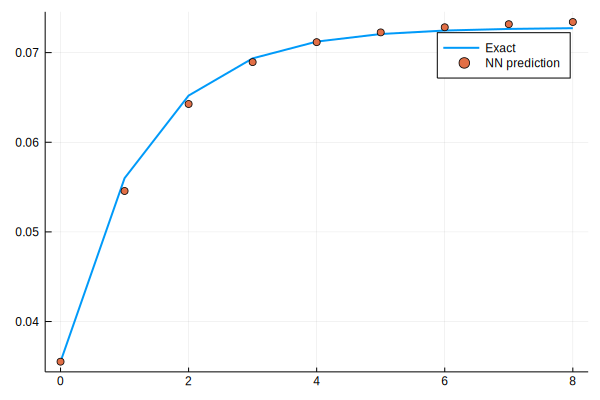

2.4979401f-5

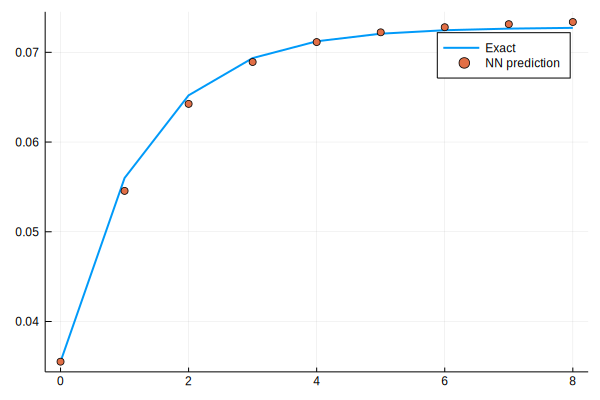

loss: 2.5e-05:  56%|██████████████████████▊                  |  ETA: 0:00:10

2.4506757f-5

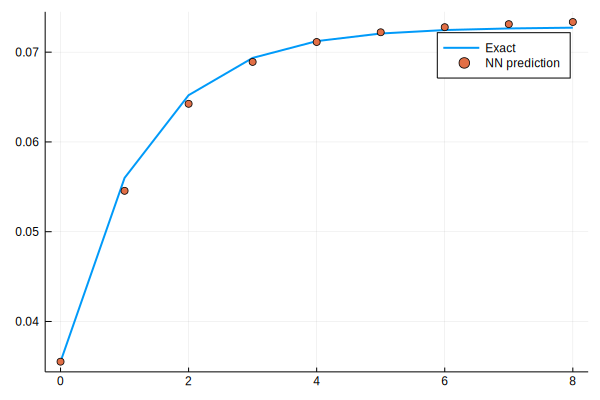

loss: 2.45e-05:  56%|███████████████████████                  |  ETA: 0:00:09

2.4205756f-5

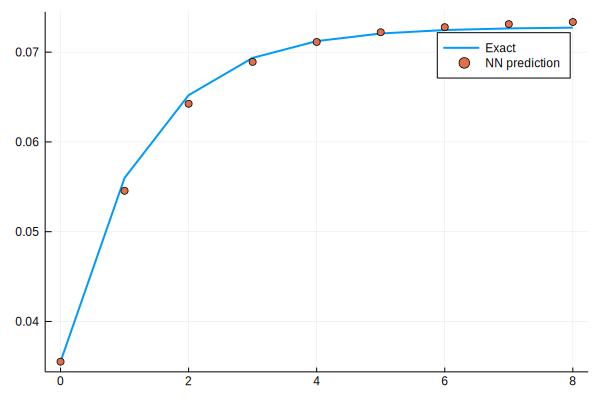

loss: 2.42e-05:  56%|███████████████████████▏                 |  ETA: 0:00:09

2.4066085f-5

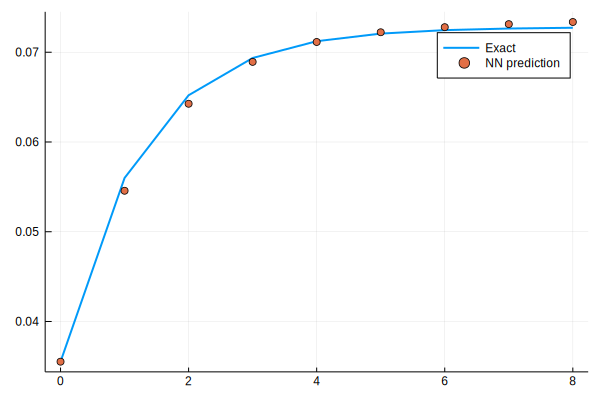

loss: 2.41e-05:  57%|███████████████████████▍                 |  ETA: 0:00:09

2.4060795f-5

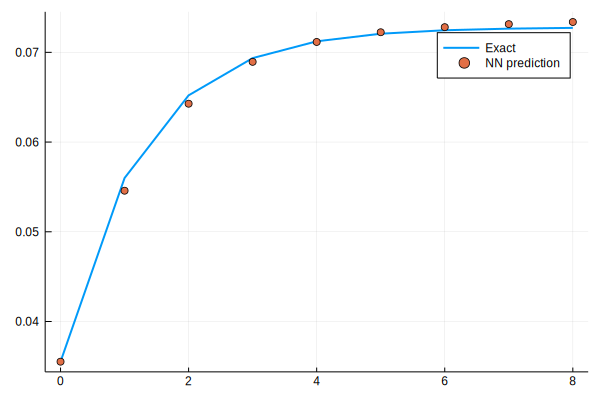

loss: 2.41e-05:  58%|███████████████████████▋                 |  ETA: 0:00:09

2.4059527f-5

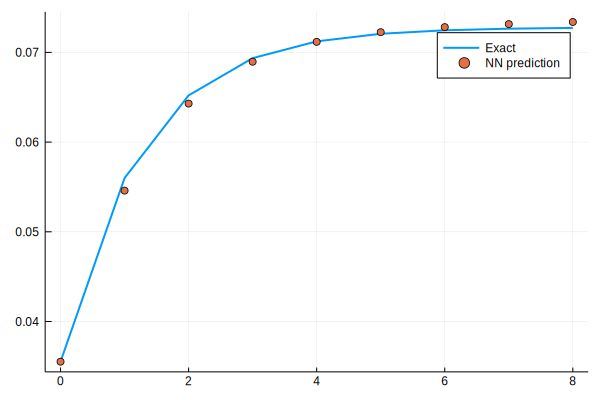

loss: 2.41e-05:  58%|███████████████████████▊                 |  ETA: 0:00:09

2.3926557f-5

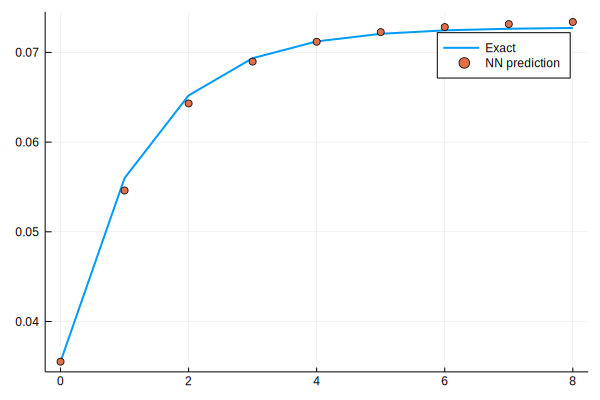

loss: 2.39e-05:  58%|████████████████████████                 |  ETA: 0:00:09

2.3617979f-5

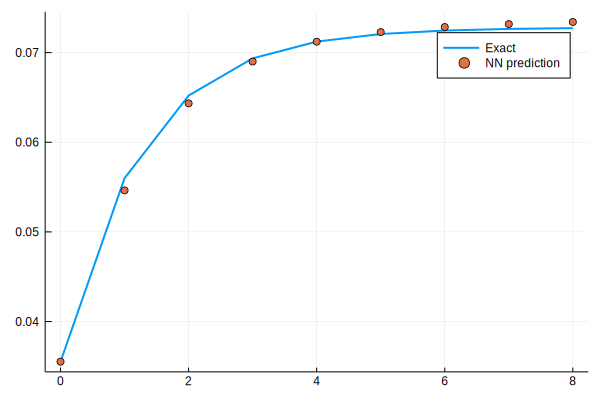

loss: 2.36e-05:  59%|████████████████████████▎                |  ETA: 0:00:09

2.3266624f-5

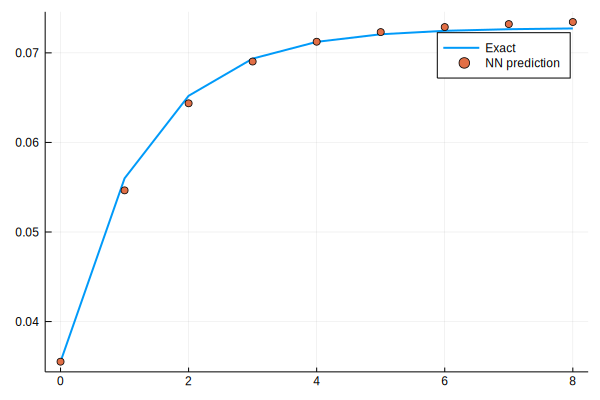

loss: 2.33e-05:  60%|████████████████████████▍                |  ETA: 0:00:09

2.29549f-5

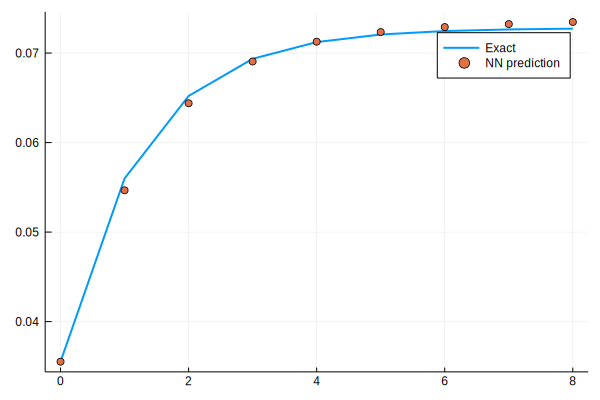

loss: 2.3e-05:  60%|████████████████████████▋                |  ETA: 0:00:09

2.2725793f-5

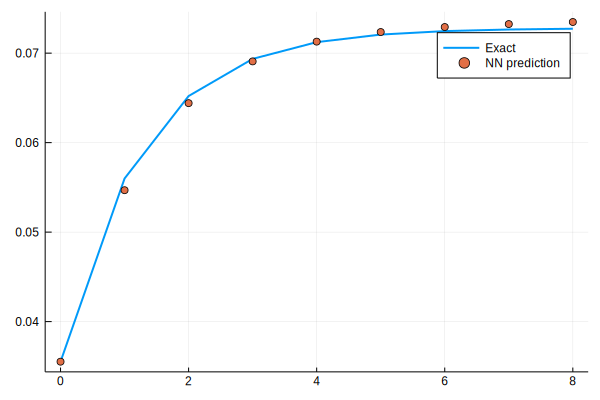

loss: 2.27e-05:  60%|████████████████████████▊                |  ETA: 0:00:08

2.2609367f-5

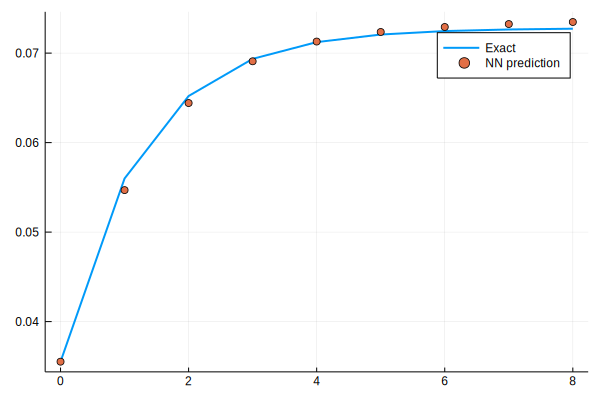

loss: 2.26e-05:  61%|█████████████████████████                |  ETA: 0:00:08

2.2509616f-5

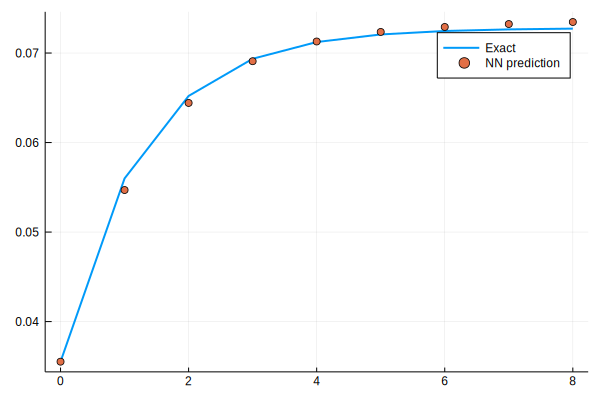

2.2394417f-5

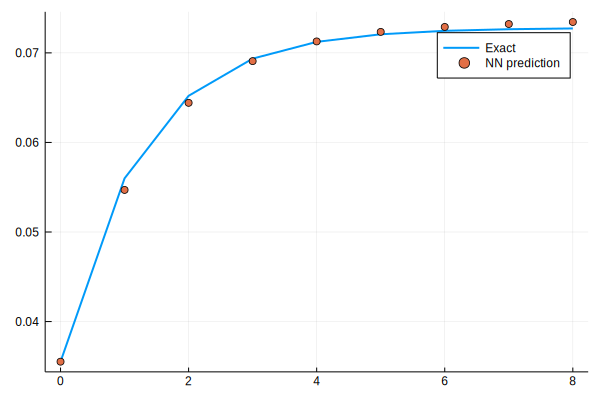

loss: 2.24e-05:  62%|█████████████████████████▍               |  ETA: 0:00:08

2.2266555f-5

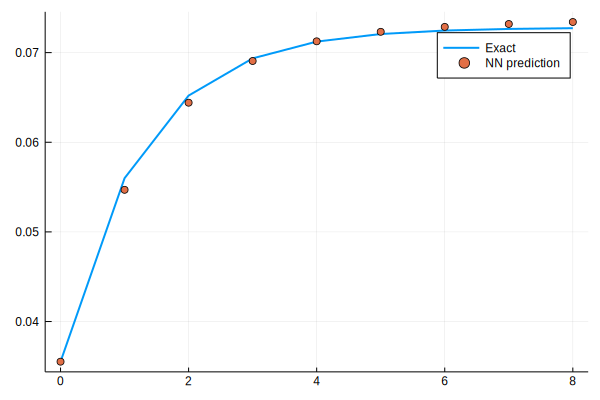

loss: 2.23e-05:  62%|█████████████████████████▋               |  ETA: 0:00:08

2.2083475f-5

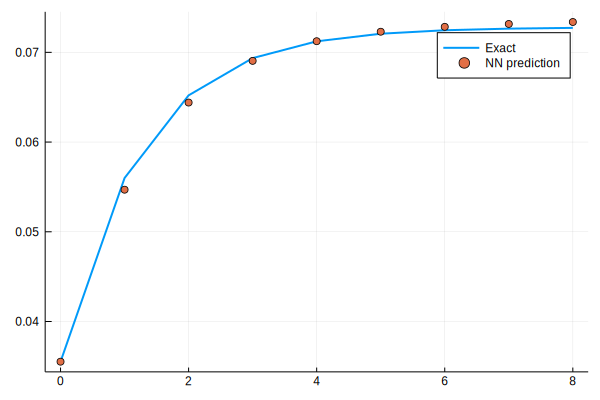

loss: 2.21e-05:  63%|█████████████████████████▉               |  ETA: 0:00:08

2.185145f-5

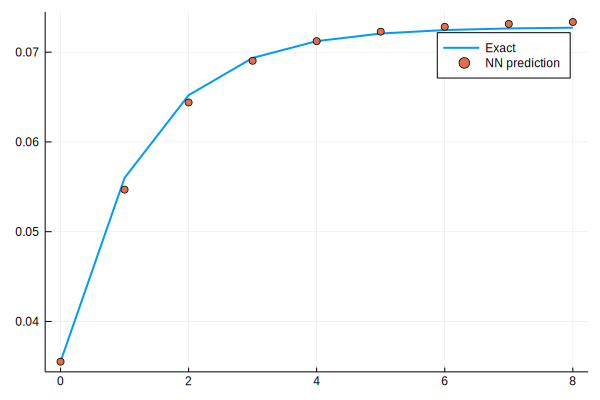

loss: 2.19e-05:  64%|██████████████████████████               |  ETA: 0:00:08

2.1617863f-5

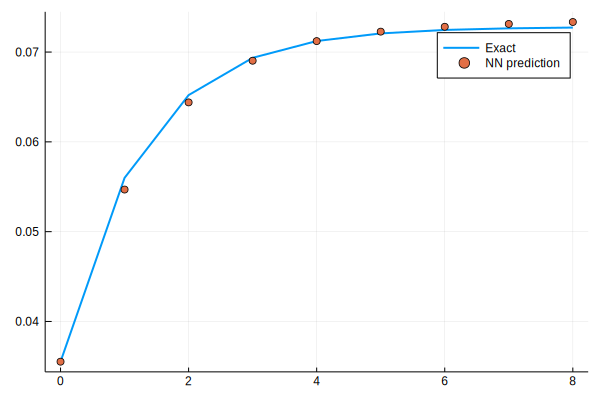

loss: 2.16e-05:  64%|██████████████████████████▎              |  ETA: 0:00:08

2.143605f-5

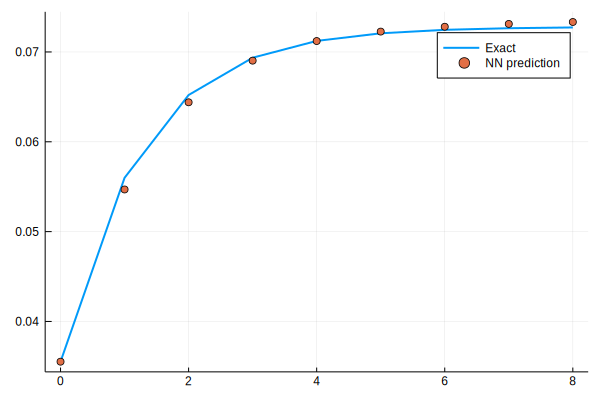

loss: 2.14e-05:  64%|██████████████████████████▌              |  ETA: 0:00:08

2.1307038f-5

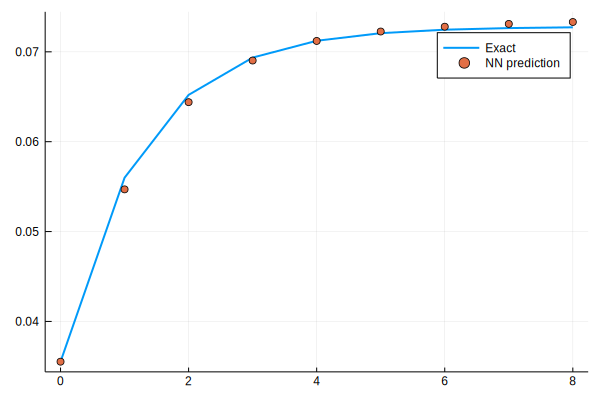

loss: 2.13e-05:  65%|██████████████████████████▋              |  ETA: 0:00:07

2.1197944f-5

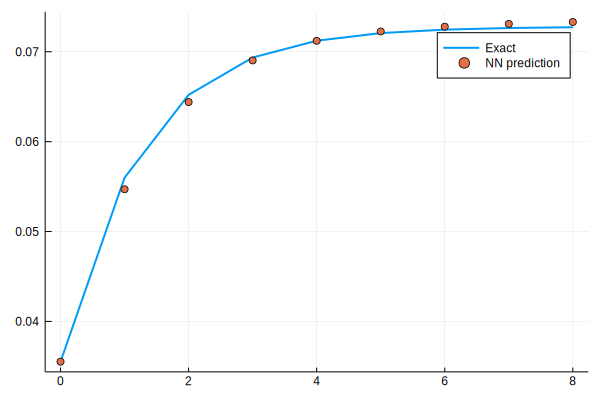

loss: 2.12e-05:  66%|██████████████████████████▉              |  ETA: 0:00:07

2.108345f-5

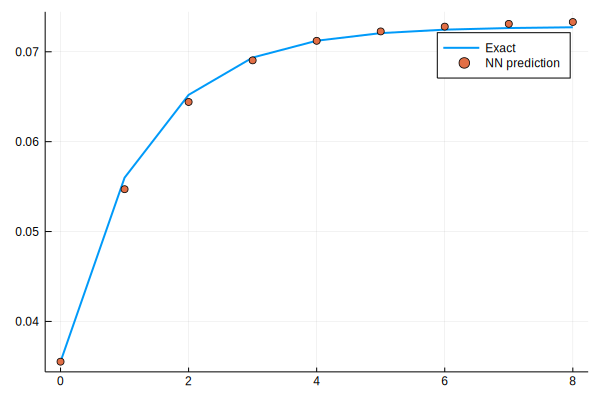

loss: 2.11e-05:  66%|███████████████████████████              |  ETA: 0:00:07

2.0933092f-5

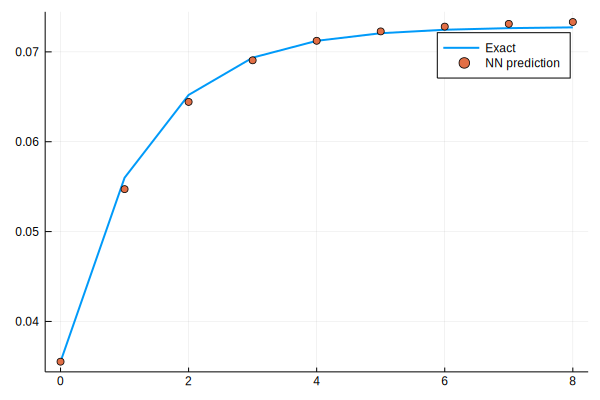

loss: 2.09e-05:  66%|███████████████████████████▎             |  ETA: 0:00:07

2.0761745f-5

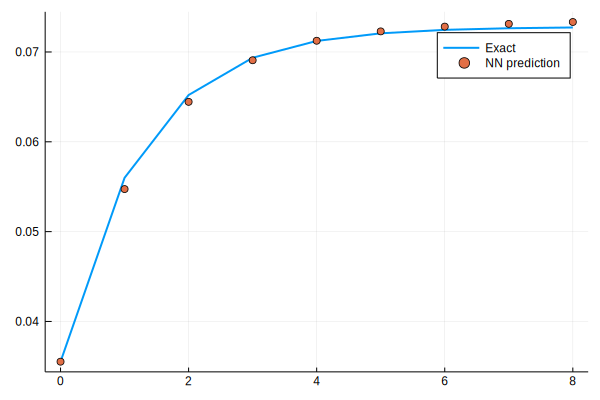

2.0593503f-5

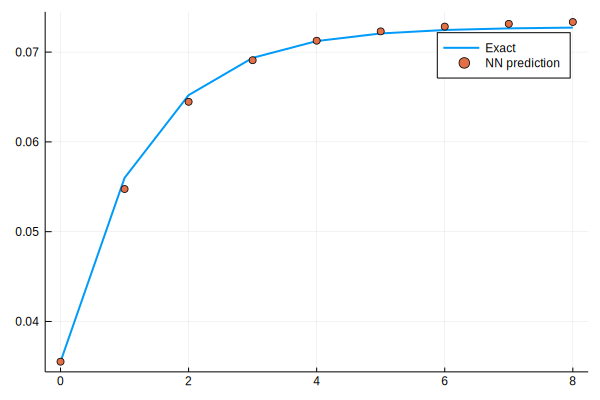

loss: 2.06e-05:  68%|███████████████████████████▋             |  ETA: 0:00:07

2.0426989f-5

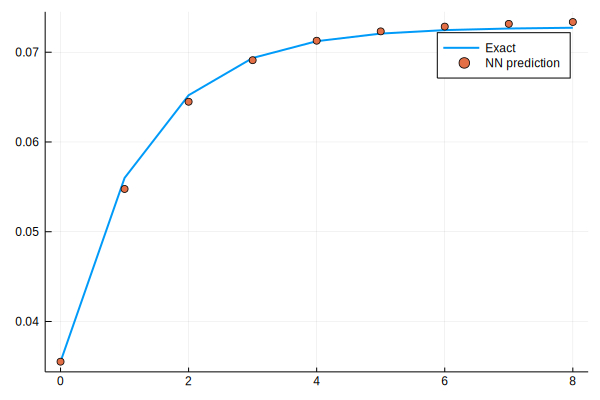

loss: 2.04e-05:  68%|███████████████████████████▉             |  ETA: 0:00:07

2.0274434f-5

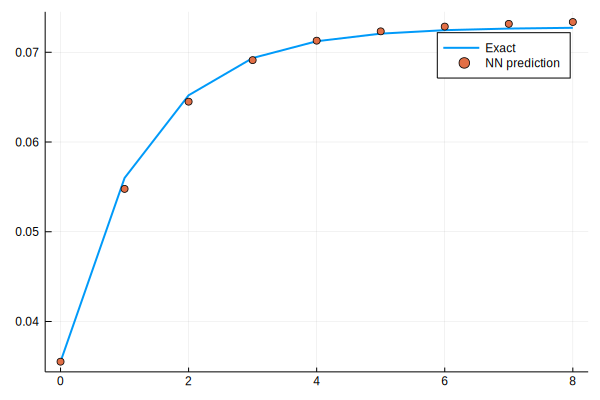

loss: 2.03e-05:  68%|████████████████████████████▏            |  ETA: 0:00:07

2.0139118f-5

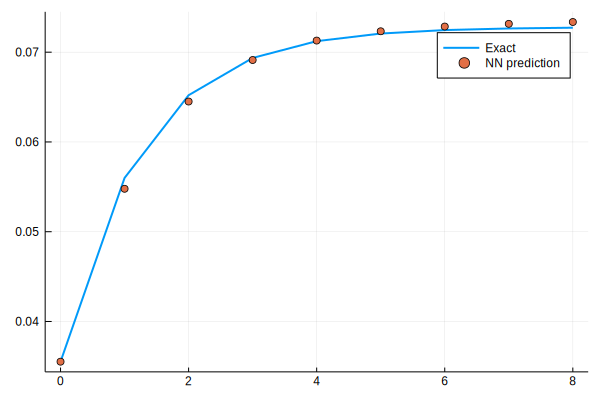

loss: 2.01e-05:  69%|████████████████████████████▎            |  ETA: 0:00:07

2.001767f-5

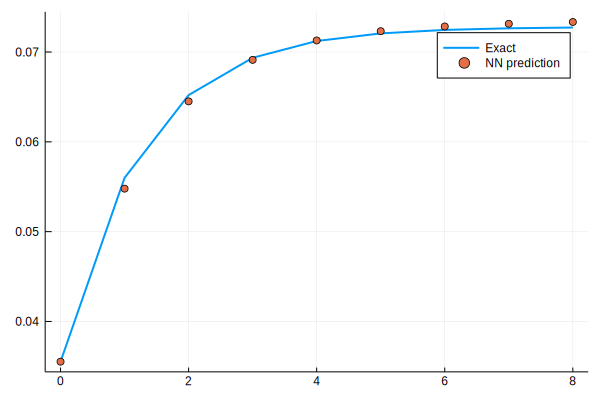

loss: 2e-05:  70%|████████████████████████████▌            |  ETA: 0:00:07

1.9894343f-5

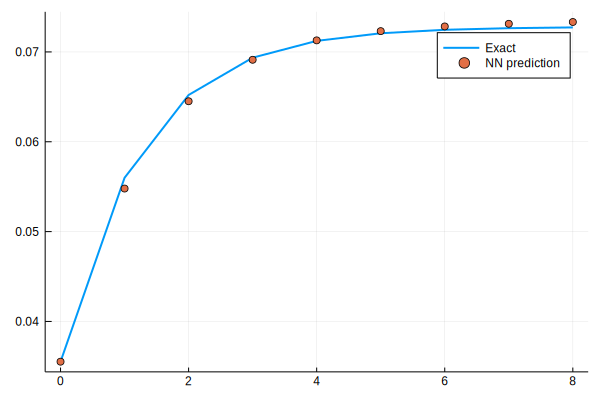

loss: 1.99e-05:  70%|████████████████████████████▊            |  ETA: 0:00:06

1.9759651f-5

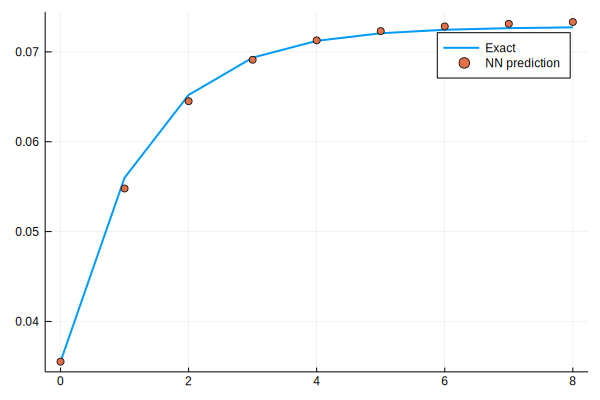

loss: 1.98e-05:  70%|████████████████████████████▉            |  ETA: 0:00:06

1.9613504f-5

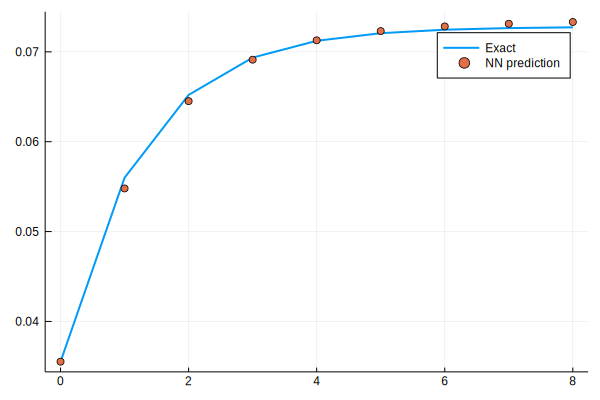

loss: 1.96e-05:  71%|█████████████████████████████▏           |  ETA: 0:00:06

1.9458994f-5

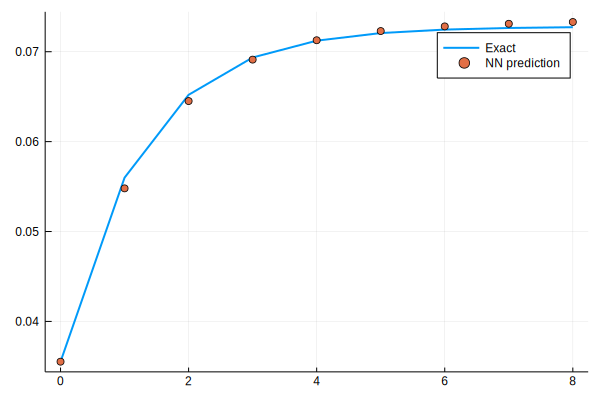

loss: 1.95e-05:  72%|█████████████████████████████▍           |  ETA: 0:00:06

1.9314899f-5

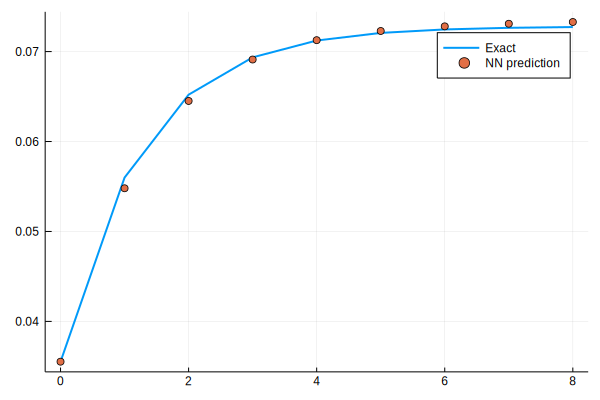

loss: 1.93e-05:  72%|█████████████████████████████▌           |  ETA: 0:00:06

1.9183728f-5

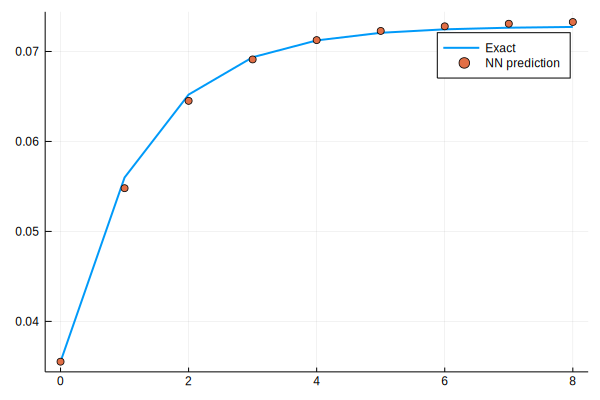

loss: 1.92e-05:  72%|█████████████████████████████▊           |  ETA: 0:00:06

1.9058554f-5

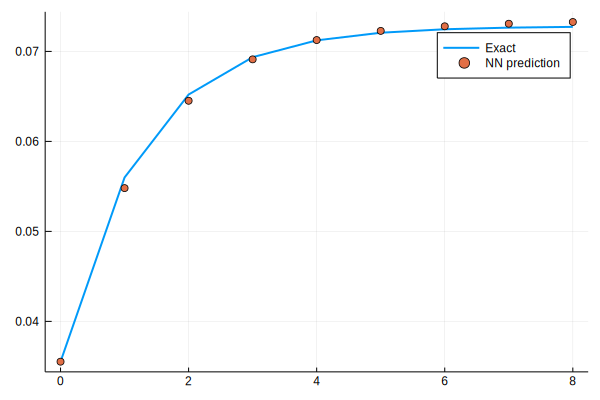

loss: 1.91e-05:  73%|█████████████████████████████▉           |  ETA: 0:00:06

1.8935727f-5

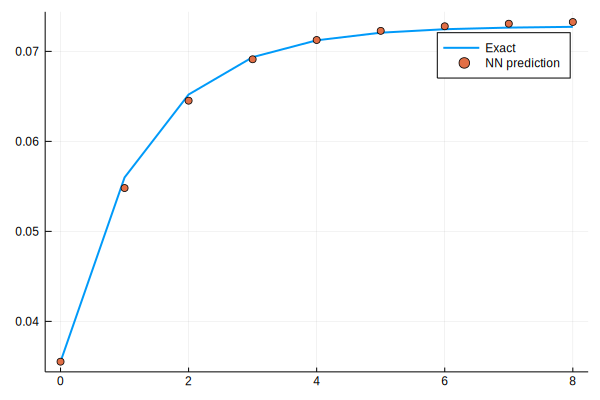

loss: 1.89e-05:  74%|██████████████████████████████▏          |  ETA: 0:00:06

1.8810768f-5

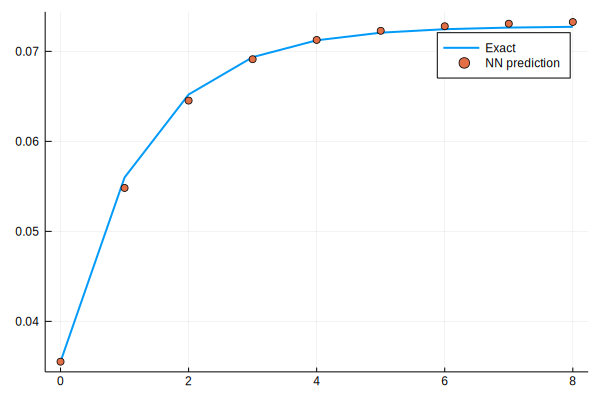

loss: 1.88e-05:  74%|██████████████████████████████▍          |  ETA: 0:00:06

1.8679622f-5

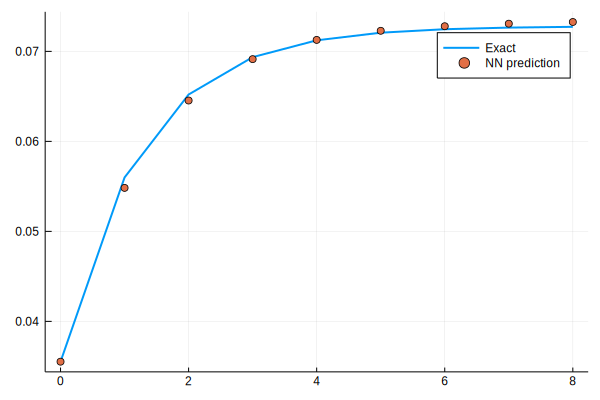

loss: 1.87e-05:  74%|██████████████████████████████▌          |  ETA: 0:00:05

1.8546398f-5

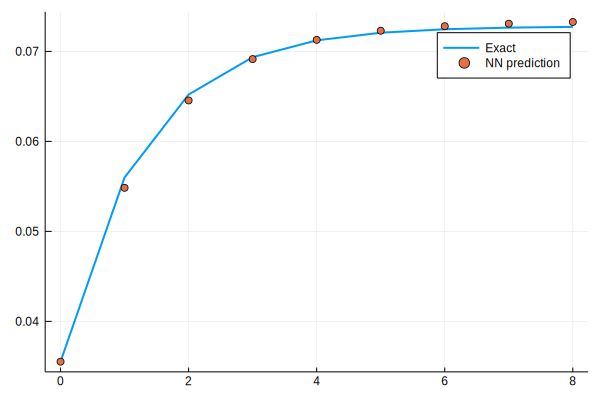

loss: 1.85e-05:  75%|██████████████████████████████▊          |  ETA: 0:00:05

1.8414383f-5

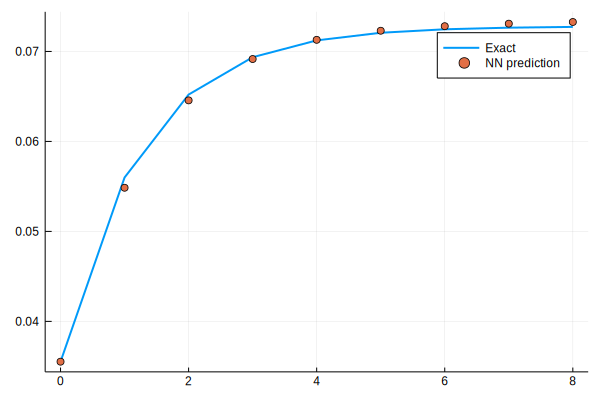

loss: 1.84e-05:  76%|███████████████████████████████          |  ETA: 0:00:05

1.8283947f-5

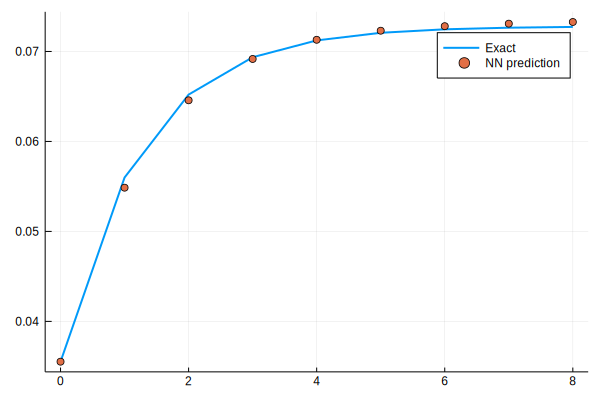

loss: 1.83e-05:  76%|███████████████████████████████▏         |  ETA: 0:00:05

1.8158951f-5

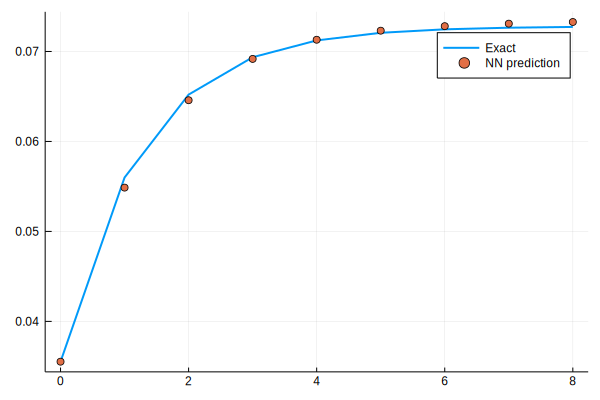

loss: 1.82e-05:  76%|███████████████████████████████▍         |  ETA: 0:00:05

1.8040218f-5

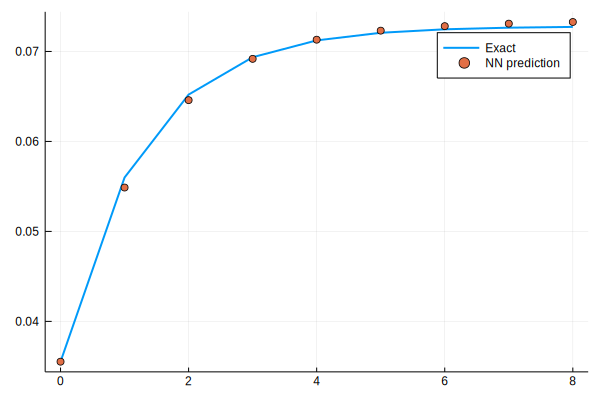

loss: 1.8e-05:  77%|███████████████████████████████▋         |  ETA: 0:00:05

1.7921311f-5

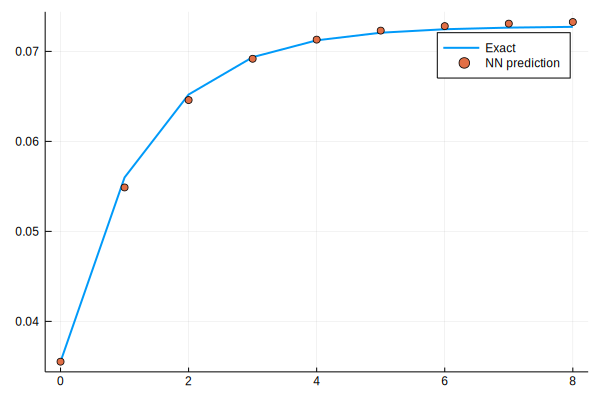

loss: 1.79e-05:  78%|███████████████████████████████▊         |  ETA: 0:00:05

1.7800285f-5

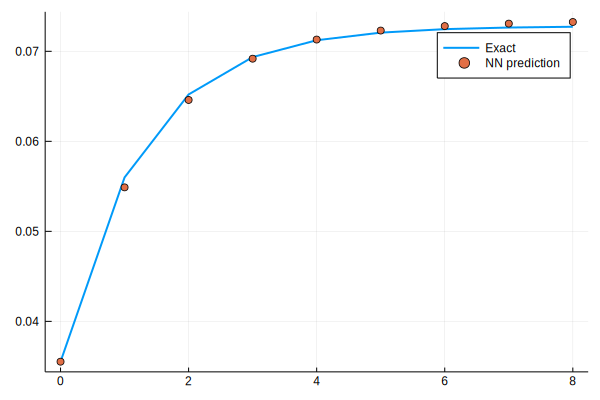

loss: 1.78e-05:  78%|████████████████████████████████         |  ETA: 0:00:05

1.7677285f-5

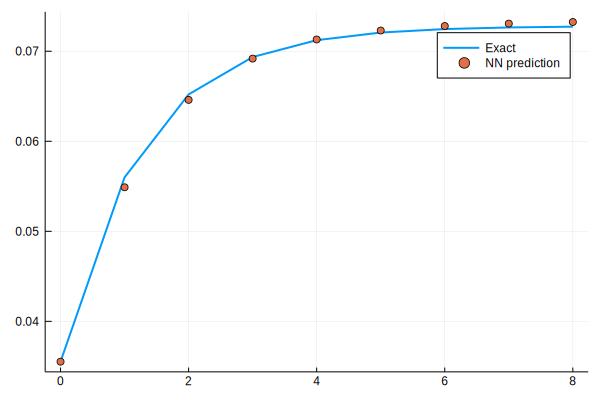

1.7553264f-5

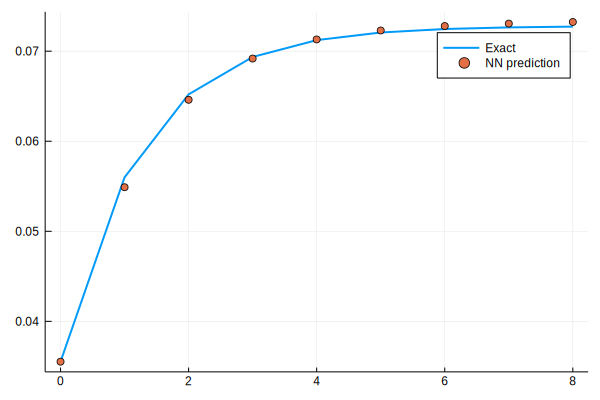

loss: 1.76e-05:  79%|████████████████████████████████▍        |  ETA: 0:00:04

1.7430979f-5

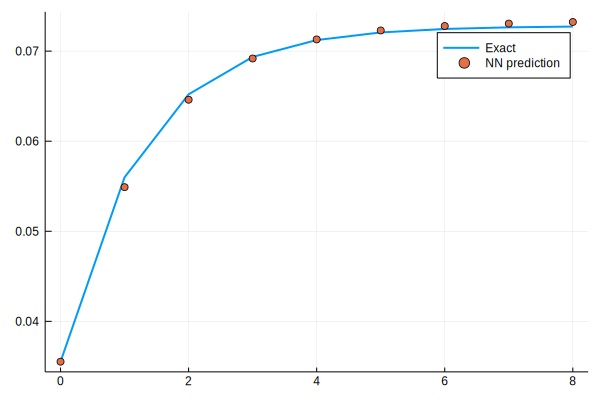

loss: 1.74e-05:  80%|████████████████████████████████▋        |  ETA: 0:00:04

1.73118f-5

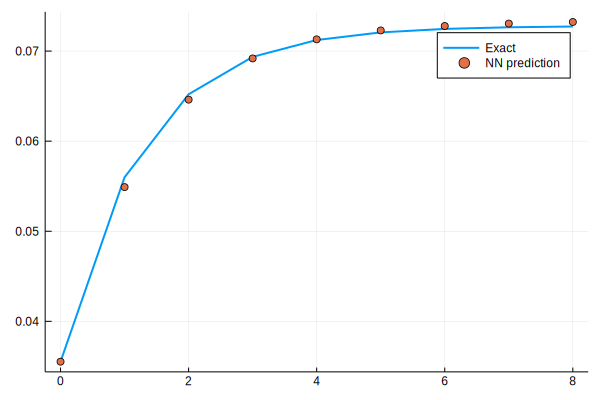

loss: 1.73e-05:  80%|████████████████████████████████▊        |  ETA: 0:00:04

1.7195542f-5

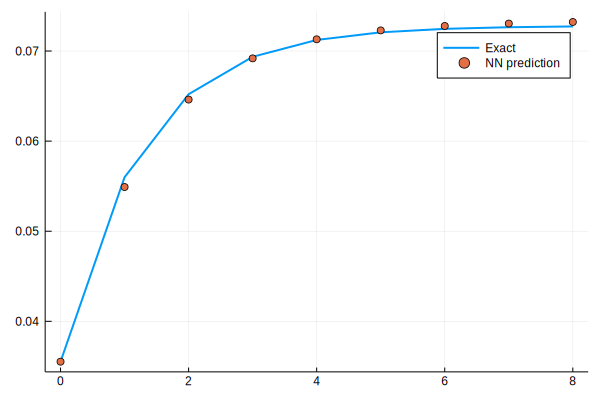

loss: 1.72e-05:  80%|█████████████████████████████████        |  ETA: 0:00:04

1.7080632f-5

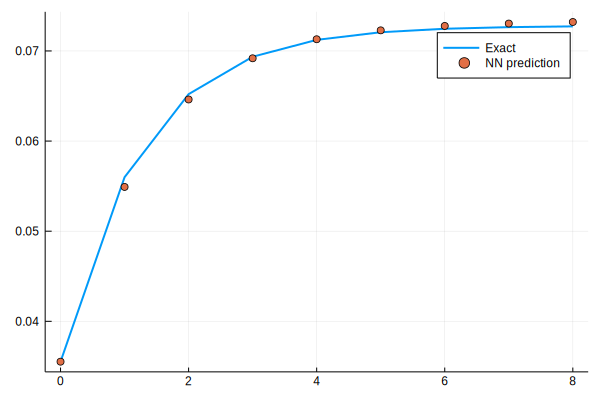

loss: 1.71e-05:  81%|█████████████████████████████████▎       |  ETA: 0:00:04

1.696611f-5

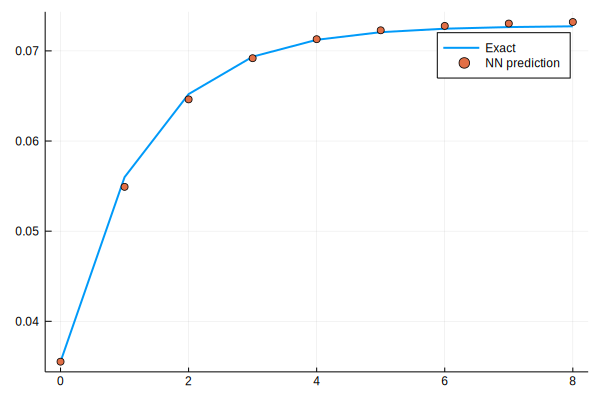

loss: 1.7e-05:  82%|█████████████████████████████████▍       |  ETA: 0:00:04

1.685107f-5

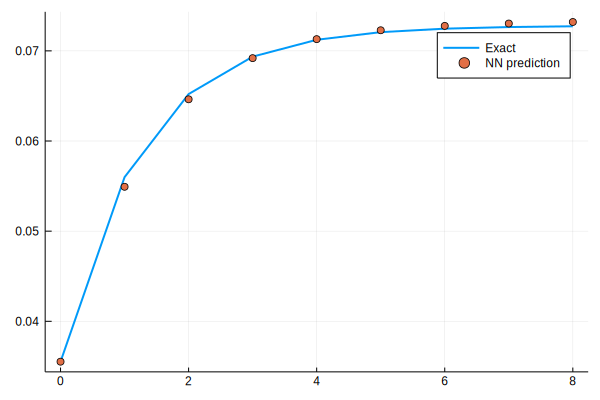

loss: 1.69e-05:  82%|█████████████████████████████████▋       |  ETA: 0:00:04

1.673498f-5

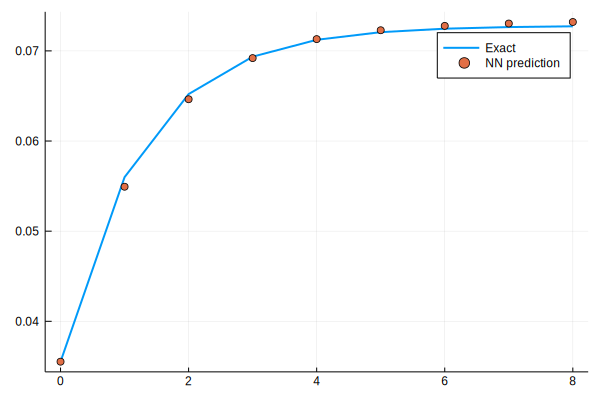

loss: 1.67e-05:  82%|█████████████████████████████████▉       |  ETA: 0:00:04

1.661999f-5

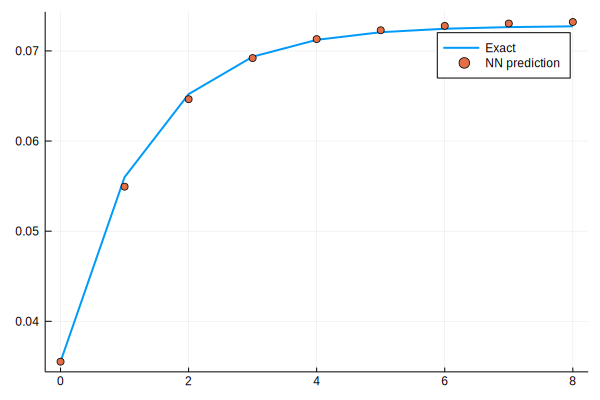

loss: 1.66e-05:  83%|██████████████████████████████████       |  ETA: 0:00:04

1.6506378f-5

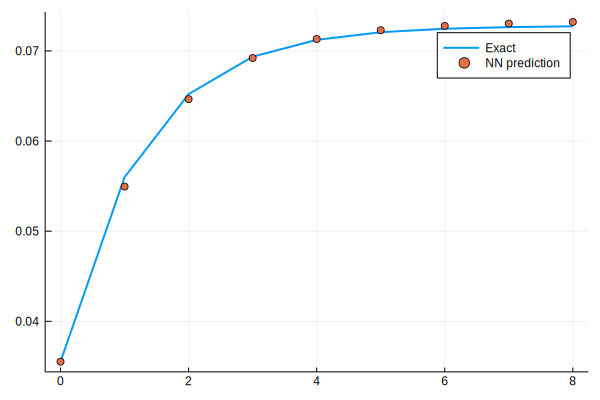

loss: 1.65e-05:  84%|██████████████████████████████████▎      |  ETA: 0:00:04

1.639475f-5

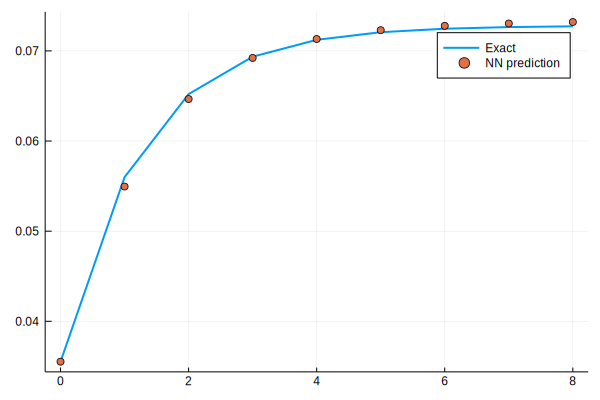

loss: 1.64e-05:  84%|██████████████████████████████████▌      |  ETA: 0:00:03

1.6284508f-5

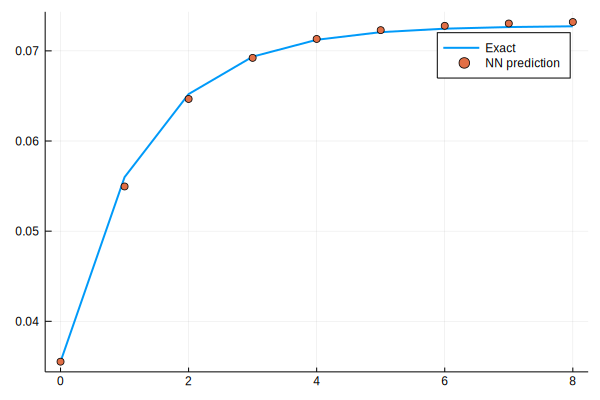

loss: 1.63e-05:  84%|██████████████████████████████████▋      |  ETA: 0:00:03

1.6175249f-5

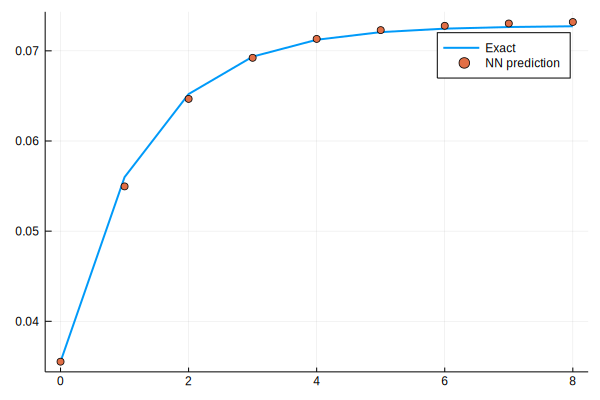

loss: 1.62e-05:  85%|██████████████████████████████████▉      |  ETA: 0:00:03

1.6065964f-5

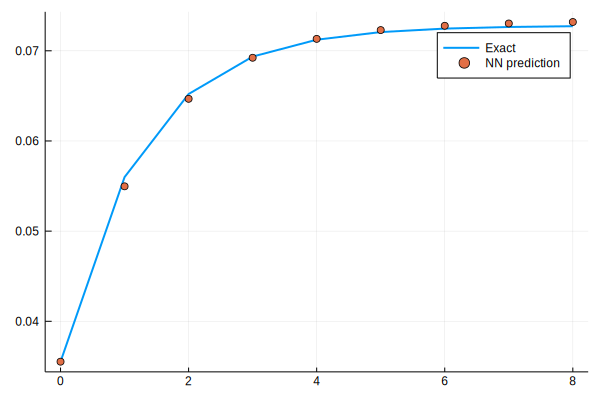

loss: 1.61e-05:  86%|███████████████████████████████████      |  ETA: 0:00:03

1.5956464f-5

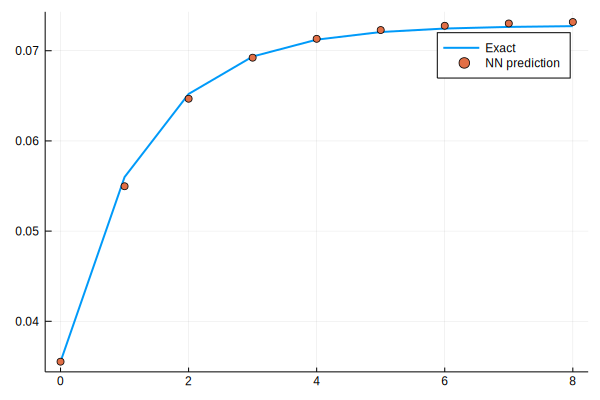

loss: 1.6e-05:  86%|███████████████████████████████████▎     |  ETA: 0:00:03

1.5847943f-5

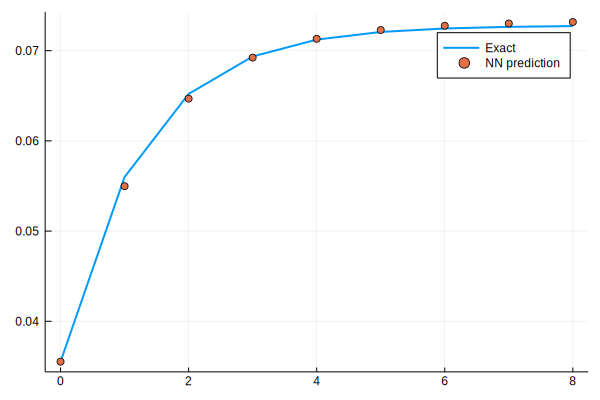

loss: 1.58e-05:  86%|███████████████████████████████████▌     |  ETA: 0:00:03

1.5740165f-5

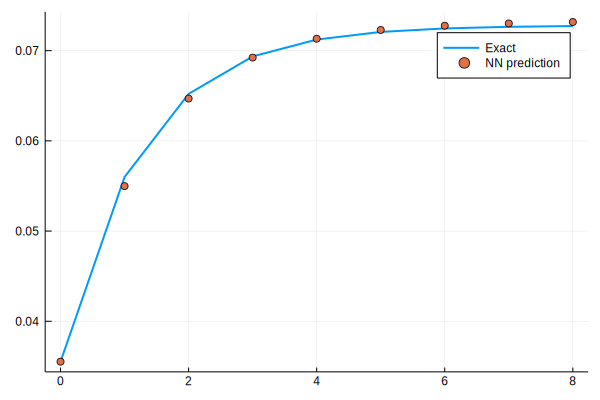

loss: 1.57e-05:  87%|███████████████████████████████████▋     |  ETA: 0:00:03

1.5633306f-5

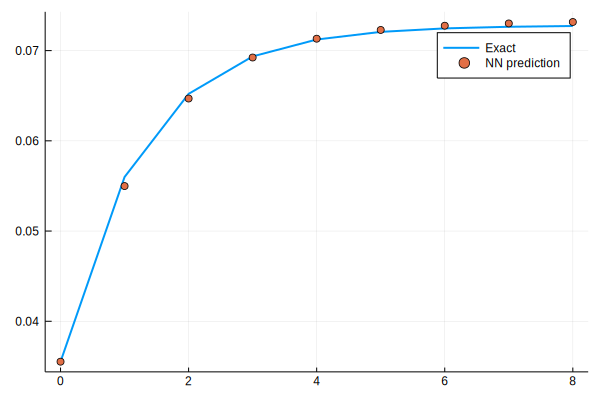

loss: 1.56e-05:  88%|███████████████████████████████████▉     |  ETA: 0:00:03

1.5527763f-5

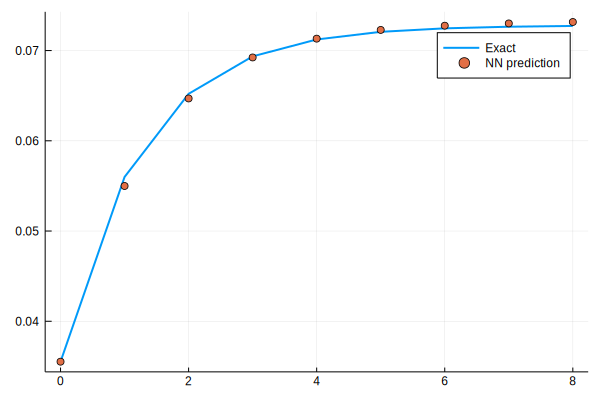

loss: 1.55e-05:  88%|████████████████████████████████████▏    |  ETA: 0:00:03

1.5423577f-5

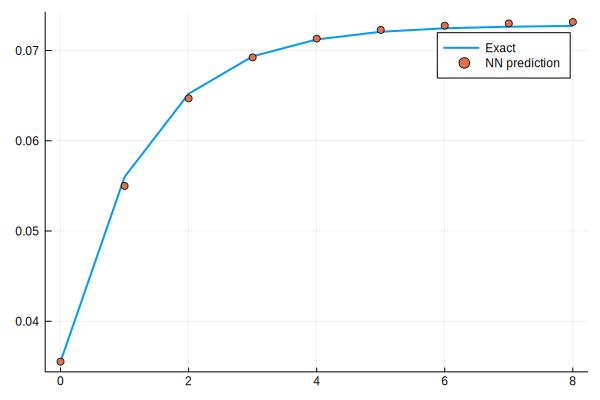

loss: 1.54e-05:  88%|████████████████████████████████████▎    |  ETA: 0:00:02

1.531969f-5

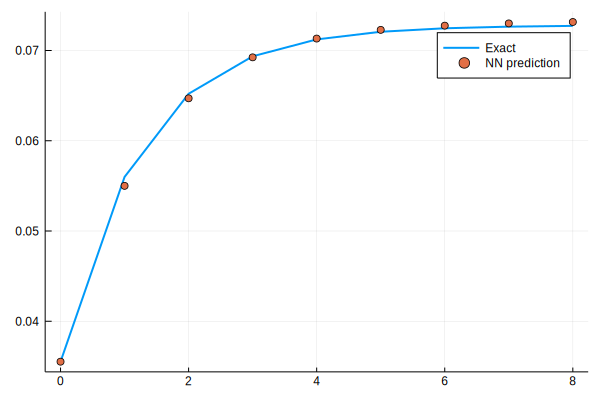

loss: 1.53e-05:  89%|████████████████████████████████████▌    |  ETA: 0:00:02

1.52163475f-5

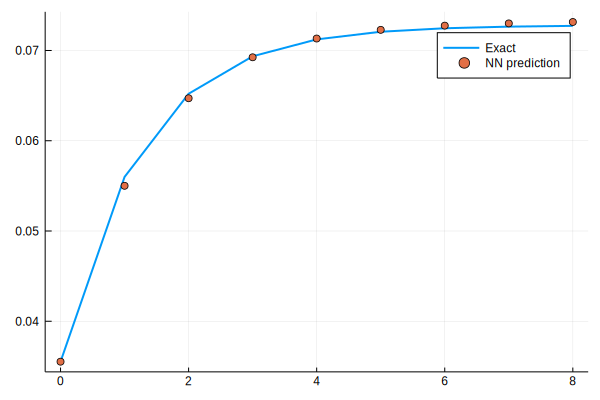

loss: 1.52e-05:  90%|████████████████████████████████████▊    |  ETA: 0:00:02

1.5113275f-5

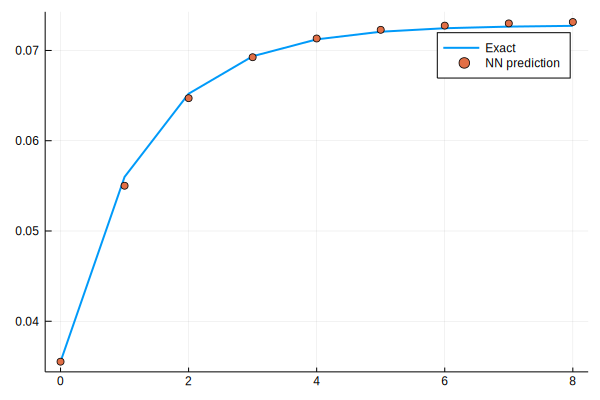

loss: 1.51e-05:  90%|████████████████████████████████████▉    |  ETA: 0:00:02

1.50111f-5

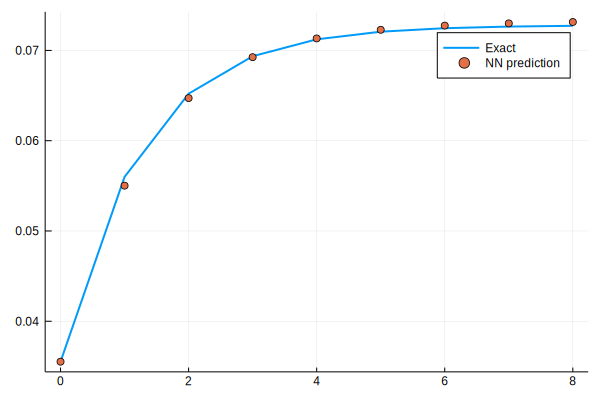

loss: 1.5e-05:  90%|█████████████████████████████████████▏   |  ETA: 0:00:02

1.490985f-5

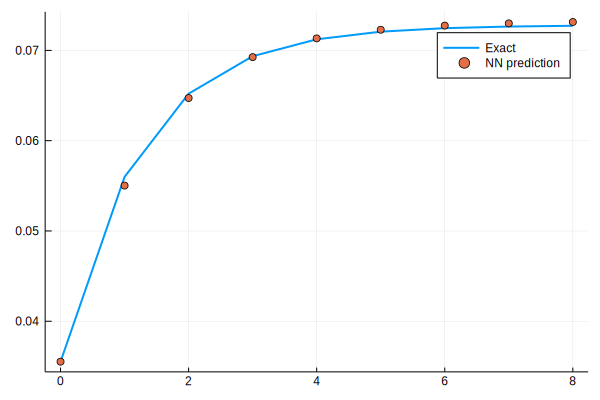

loss: 1.49e-05:  91%|█████████████████████████████████████▎   |  ETA: 0:00:02

1.4809074f-5

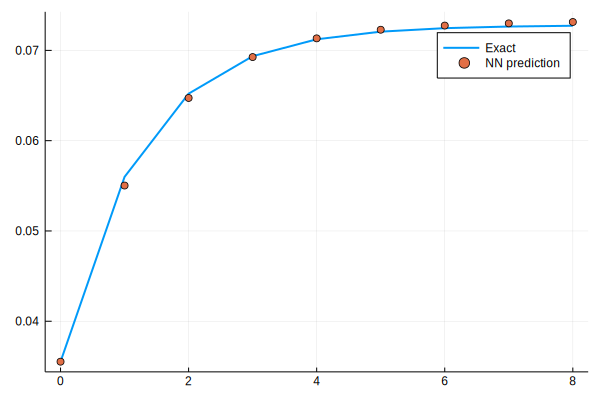

loss: 1.48e-05:  92%|█████████████████████████████████████▌   |  ETA: 0:00:02

1.4709517f-5

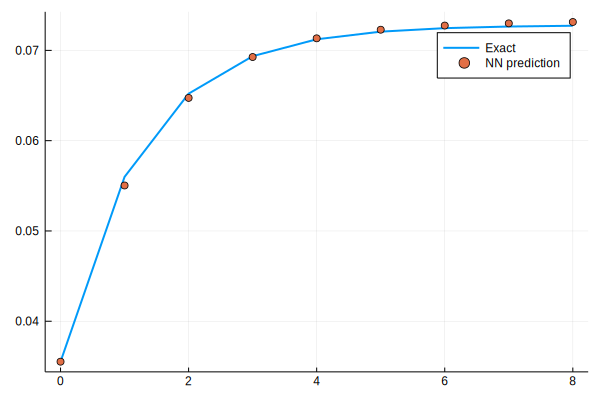

loss: 1.47e-05:  92%|█████████████████████████████████████▊   |  ETA: 0:00:02

1.4610746f-5

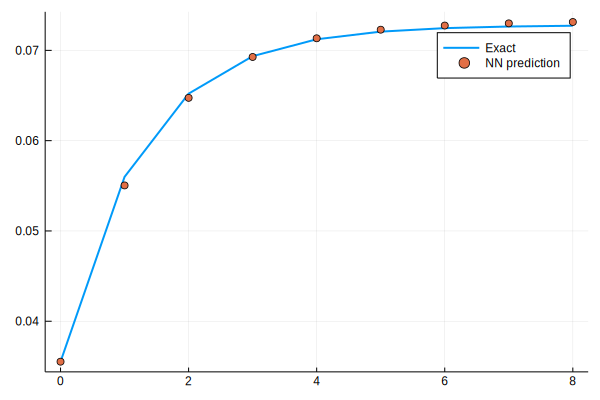

loss: 1.46e-05:  92%|█████████████████████████████████████▉   |  ETA: 0:00:02

1.45127f-5

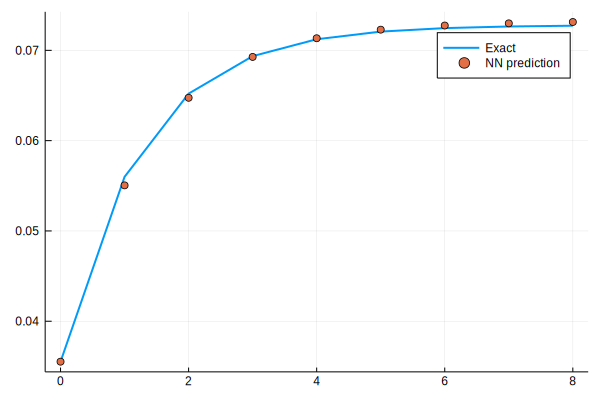

loss: 1.45e-05:  93%|██████████████████████████████████████▏  |  ETA: 0:00:02

1.4414755f-5

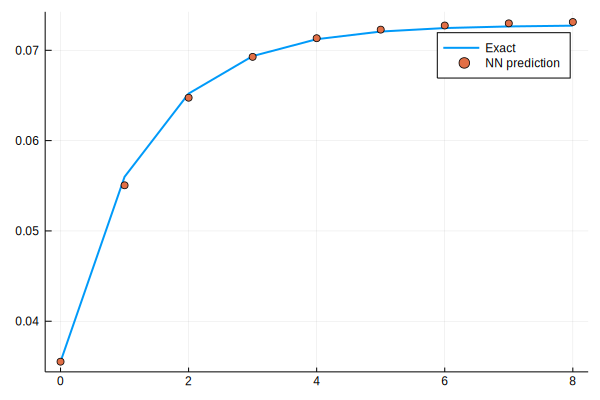

loss: 1.44e-05:  94%|██████████████████████████████████████▍  |  ETA: 0:00:01

1.4317738f-5

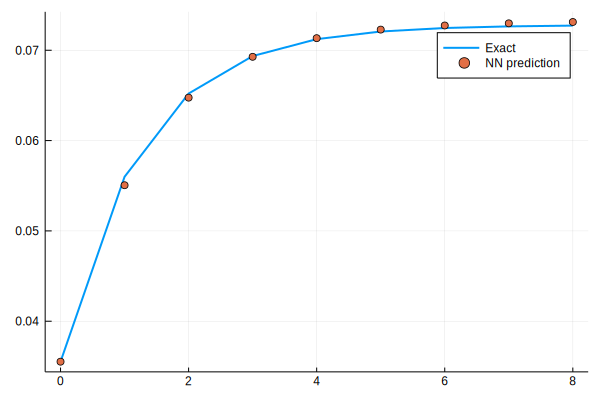

loss: 1.43e-05:  94%|██████████████████████████████████████▌  |  ETA: 0:00:01

1.4221656f-5

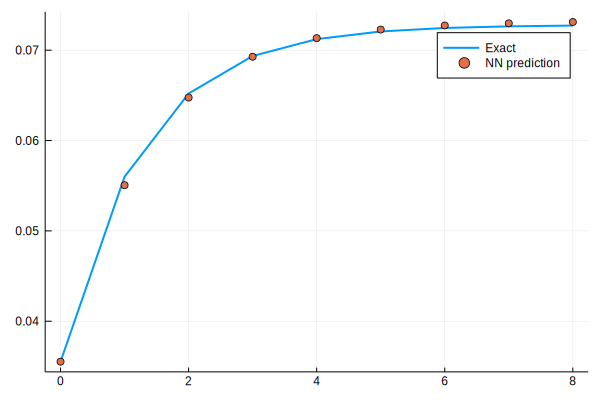

loss: 1.42e-05:  94%|██████████████████████████████████████▊  |  ETA: 0:00:01

1.4125837f-5

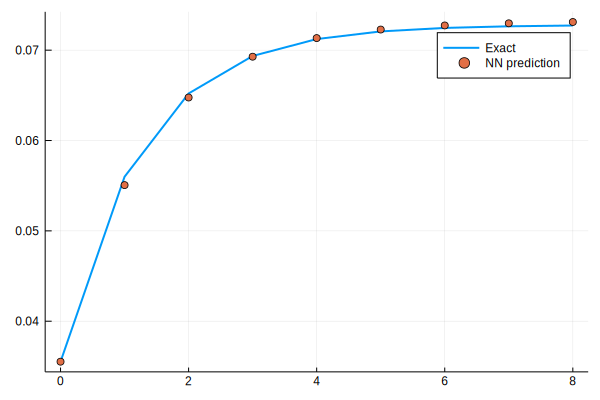

loss: 1.41e-05:  95%|███████████████████████████████████████  |  ETA: 0:00:01

1.4031215f-5

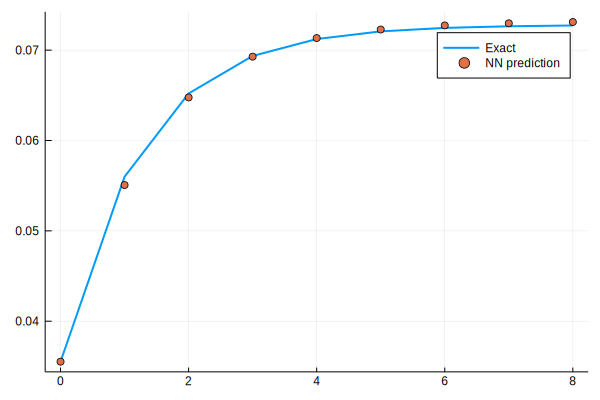

loss: 1.4e-05:  96%|███████████████████████████████████████▏ |  ETA: 0:00:01

1.3936992f-5

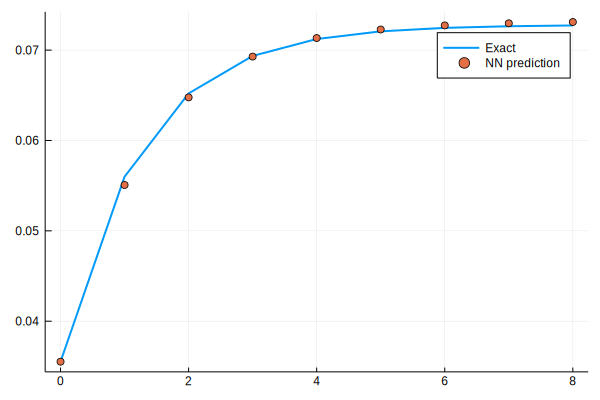

loss: 1.39e-05:  96%|███████████████████████████████████████▍ |  ETA: 0:00:01

1.3843951f-5

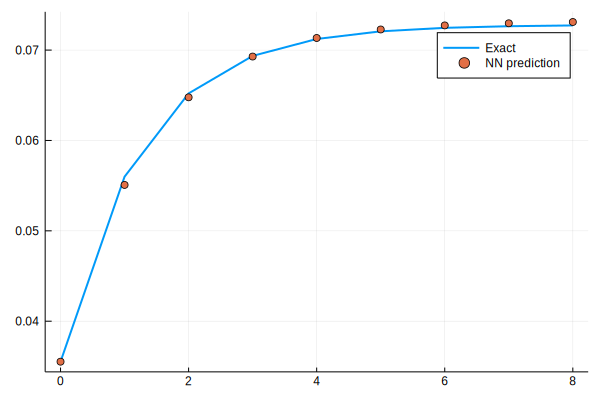

loss: 1.38e-05:  96%|███████████████████████████████████████▋ |  ETA: 0:00:01

1.3750887f-5

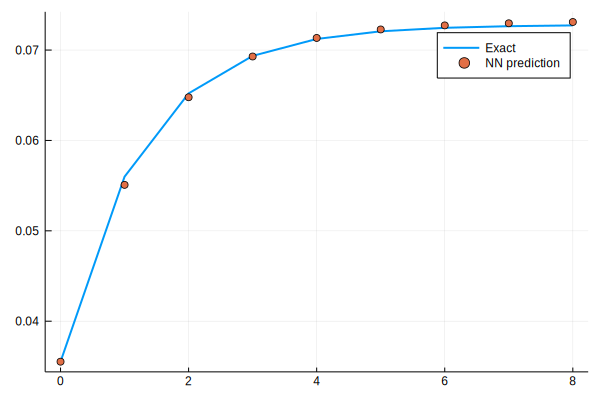

loss: 1.38e-05:  97%|███████████████████████████████████████▊ |  ETA: 0:00:01

1.3658725f-5

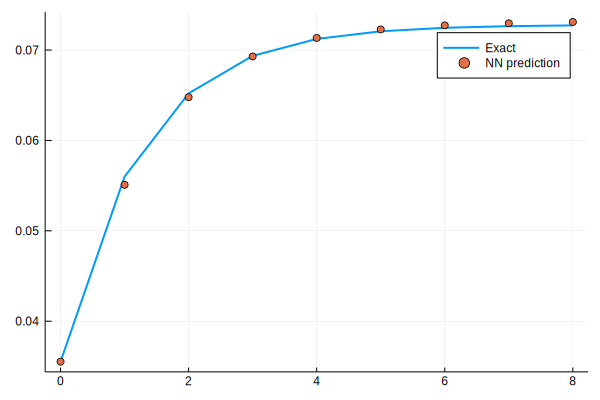

loss: 1.37e-05:  98%|████████████████████████████████████████ |  ETA: 0:00:01

1.3566929f-5

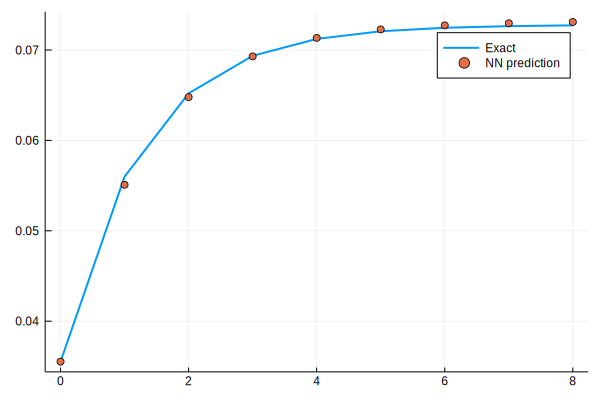

loss: 1.36e-05:  98%|████████████████████████████████████████▏|  ETA: 0:00:00

1.3476719f-5

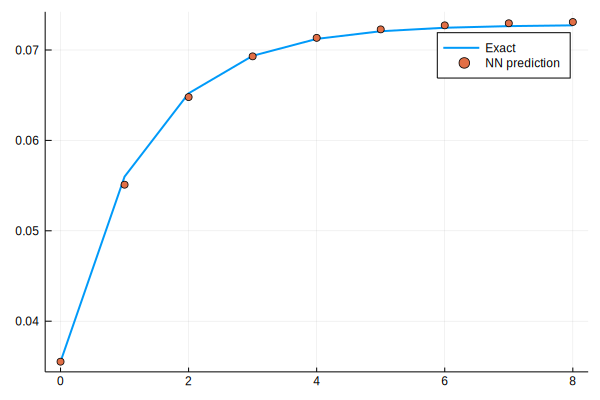

loss: 1.35e-05:  98%|████████████████████████████████████████▍|  ETA: 0:00:00

1.3386488f-5

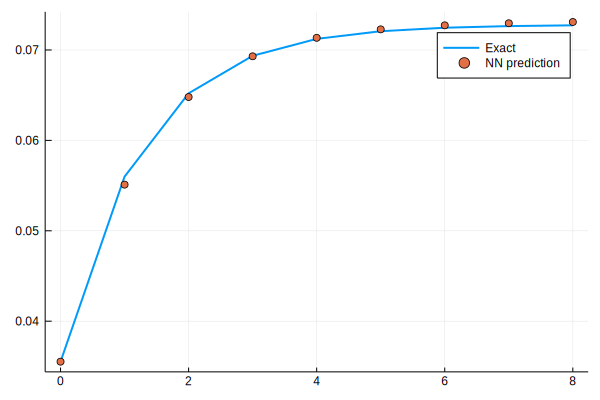

loss: 1.34e-05:  99%|████████████████████████████████████████▋|  ETA: 0:00:00

1.3296966f-5

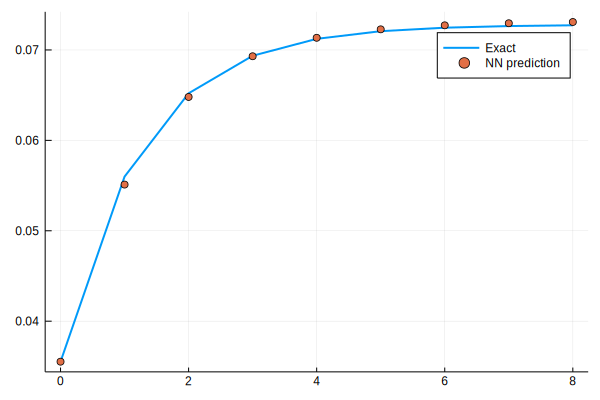

loss: 1.33e-05: 100%|████████████████████████████████████████▊|  ETA: 0:00:00

1.3208375f-5

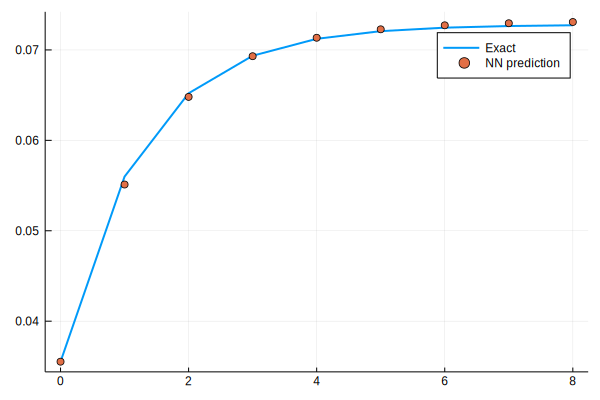

loss: 1.32e-05: 100%|█████████████████████████████████████████| Time: 0:00:21


1.3208375f-5

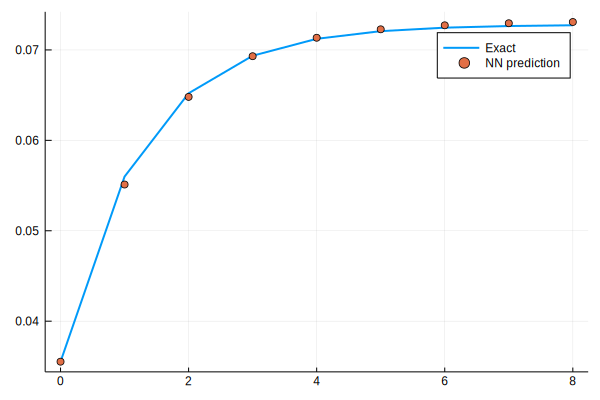

 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Minimizer: [-9.86e-02, 6.23e-02, 9.51e-02,  ...]
    Minimum:   1.320838e-05

 * Found with
    Algorithm:     ADAM
    Initial Point: [-9.31e-02, 5.76e-02, 9.18e-02,  ...]

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   22  (vs limit Inf)
    Iterations:    200
    f(x) calls:    200
    ∇f(x) calls:   200


In [19]:
res = DiffEqFlux.sciml_train(loss_n_ode, res.minimizer, ADAM(), cb=cb, maxiters=200)

PDF at $t=8$

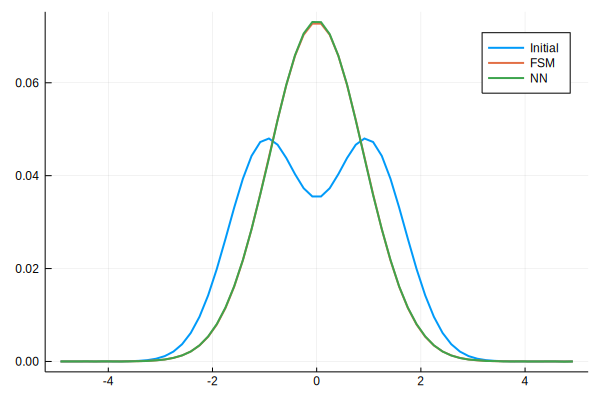

In [20]:
plot(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], data_boltz_1D[:,1], lw=2, label="Initial")
plot!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], data_boltz_1D[:,end], lw=2, label="FSM")
plot!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], n_ode(f0_1D, res.minimizer).u[end], lw=2, label="NN")

Trajectories of PDF

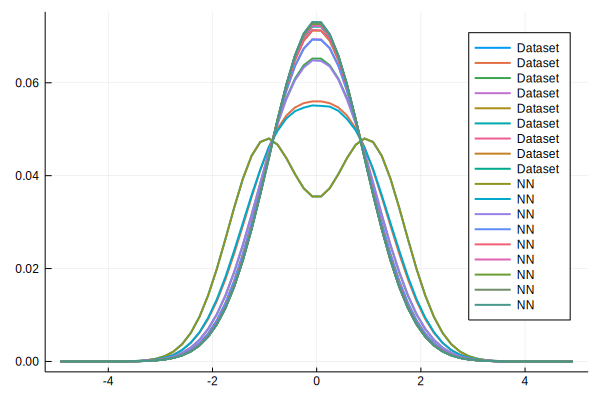

In [21]:
plot(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], data_boltz_1D[:,:], lw=2, label="Dataset")
plot!(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], n_ode(f0_1D, res.minimizer).u[:], lw=2, label="NN")

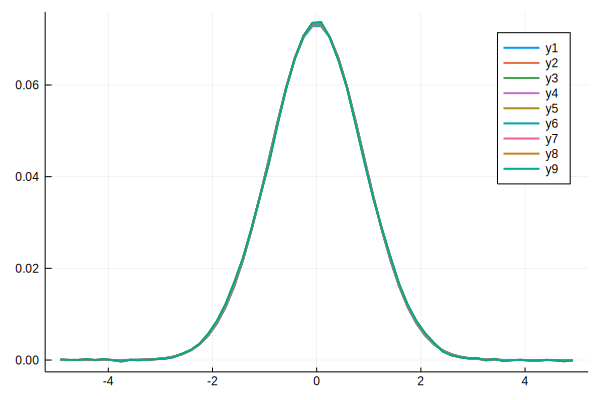

In [24]:
plot(vSpace.u[:,vSpace.nv÷2,vSpace.nw÷2], n_ode(M0_1D, res.minimizer).u[:], lw=2)